In [1]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2DTranspose
import sys

import numpy as np
from numpy import expand_dims
from os import makedirs

170508288/170498071 [==============================] - 6s 0us/step
Train: X=  (50000, 32, 32, 3)


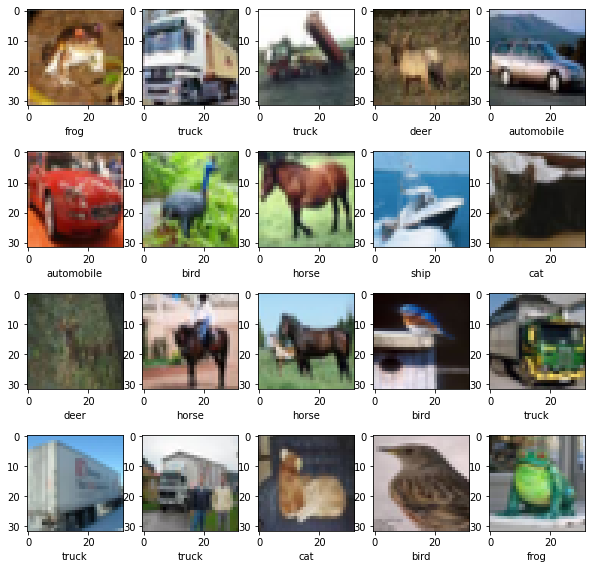

In [2]:
#import data
data=tf.keras.datasets.cifar10.load_data()
# load dataset
(X_train, y_train), (_,_) = data
print('Train: X= ' , (X_train.shape))

#obtained from tensorflow website, labels of the y class
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.figure(figsize=(10,10))
for i in range(20):
    # define subplot
    plt.subplot(4,5,i+1)
    plt.imshow(X_train[i])
    plt.xlabel(labelNames[int(y_train[i])])
plt.show()

# Data Cleaning

In [3]:
# load dataset
(X_train, y_train), (_,_) = data
X_data=X_train.astype('float32')
X_data= (X_data - 127.5) / 127.5

# DCGAN Base Code

In [4]:
def define_generator(latent_dim):
    n_nodes = 256 * 4 * 4
    
    model = Sequential()
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.18))
    
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [5]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [6]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X, y

In [7]:
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(lr=0.0001, beta_1=0.3)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [8]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X, y

In [9]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.00022, beta_1=0.48)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [10]:
def summarize_performance(step, g_model, latent_dim, name, n_samples=100):
    X, _ = generate_fake_samples(g_model, latent_dim, n_samples)
    X = (X + 1) / 2.0
    for i in range(10 * 10):
        plt.subplot(10, 10, 1 + i)
        plt.axis('off')
        plt.imshow(X[i])
    plt.savefig(f'./{name}/generated_plot_{step+1}.png')
    plt.close()
    g_model.save(f'./{name}/model_{step+1}.h5')

In [11]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, name):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.ylim(0, 2)
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    plt.savefig(f'./{name}/plot_line_plot_loss.png')
    plt.close()

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, name, n_epochs=150, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            #train discriminator
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch(X_real, y_real)
            
            # generate image examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch(X_fake, y_fake)
            
            #train generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize and save loss
            if (j+1) % 30 == 0:
                print('>%d, d1=%.3f, d2=%.3f g=%.3f, a1=%d, a2=%d' %
                (i+1, d_loss1, d_loss2, g_loss, int(100*d_acc1), int(100*d_acc2)))
                d1_hist.append(d_loss1)
                d2_hist.append(d_loss2)
                g_hist.append(g_loss)
                a1_hist.append(d_acc1)
                a2_hist.append(d_acc2)
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, latent_dim, name)
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist, name)

In [13]:
latent_dim = 100
d_model_Plane = define_discriminator()
g_model_Plane = define_generator(latent_dim)
gan_model_Plane = define_gan(g_model_Plane, d_model_Plane)

2022-02-12 09:57:12.078019: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 09:57:12.198582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 09:57:12.199724: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-12 09:57:12.201396: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# DCGAN all (X_Data)

In [14]:
%%time

# size of the latent space
makedirs('DCGANAll', exist_ok=True)

#all data is passed in
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_data, latent_dim, "DCGANAll")

2022-02-12 09:57:16.220014: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-12 09:57:17.237609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


>1, d1=0.465, d2=0.520 g=1.050, a1=85, a2=100
>1, d1=0.117, d2=0.763 g=0.653, a1=100, a2=0
>1, d1=0.262, d2=0.724 g=0.780, a1=92, a2=25
>1, d1=0.156, d2=0.520 g=0.996, a1=93, a2=100
>1, d1=0.307, d2=0.250 g=1.697, a1=85, a2=100
>1, d1=0.449, d2=0.219 g=1.914, a1=78, a2=100
>1, d1=0.478, d2=0.760 g=2.440, a1=73, a2=54
>1, d1=0.343, d2=0.567 g=1.142, a1=89, a2=87
>1, d1=0.818, d2=0.591 g=1.118, a1=46, a2=78
>1, d1=0.812, d2=0.678 g=1.246, a1=43, a2=75


2022-02-12 09:57:59.124401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, d1=0.711, d2=0.466 g=1.163, a1=50, a2=89
>1, d1=0.976, d2=0.620 g=1.038, a1=18, a2=65
>1, d1=0.734, d2=0.582 g=0.896, a1=42, a2=90


2022-02-12 09:58:10.180443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.822, d2=0.773 g=0.750, a1=25, a2=35


2022-02-12 09:58:12.242629: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.705, d2=0.561 g=0.943, a1=46, a2=93
>2, d1=0.807, d2=0.429 g=1.229, a1=23, a2=98
>2, d1=0.542, d2=0.699 g=0.793, a1=84, a2=57
>2, d1=0.880, d2=0.697 g=0.902, a1=32, a2=65
>2, d1=0.862, d2=0.467 g=1.177, a1=15, a2=92
>2, d1=0.737, d2=0.570 g=0.995, a1=45, a2=71
>2, d1=0.523, d2=0.574 g=0.914, a1=79, a2=82
>2, d1=0.575, d2=0.671 g=0.785, a1=76, a2=68
>2, d1=0.751, d2=0.430 g=1.229, a1=32, a2=100
>2, d1=0.770, d2=0.547 g=0.969, a1=26, a2=90


2022-02-12 09:58:45.022481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.486, d2=0.666 g=0.770, a1=92, a2=73
>2, d1=0.574, d2=0.676 g=0.795, a1=73, a2=53
>3, d1=0.659, d2=0.676 g=0.848, a1=56, a2=65


2022-02-12 09:58:54.715914: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, d1=0.811, d2=0.644 g=0.807, a1=12, a2=75
>3, d1=0.697, d2=0.693 g=0.733, a1=48, a2=53
>3, d1=0.731, d2=0.593 g=0.930, a1=34, a2=92


2022-02-12 09:59:05.544890: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 09:59:05.630792: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, d1=0.731, d2=0.637 g=0.785, a1=51, a2=73
>3, d1=0.725, d2=0.527 g=0.962, a1=35, a2=98
>3, d1=0.649, d2=0.580 g=0.899, a1=65, a2=87
>3, d1=0.727, d2=0.581 g=0.910, a1=39, a2=85


2022-02-12 09:59:17.953518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, d1=0.646, d2=0.719 g=0.722, a1=70, a2=43
>3, d1=0.726, d2=0.618 g=0.825, a1=43, a2=84
>3, d1=0.647, d2=0.740 g=0.711, a1=60, a2=28
>3, d1=0.643, d2=0.726 g=0.750, a1=56, a2=28
>3, d1=0.676, d2=0.606 g=0.828, a1=51, a2=98
>4, d1=0.607, d2=0.702 g=0.725, a1=79, a2=57
>4, d1=0.652, d2=0.714 g=0.731, a1=62, a2=39
>4, d1=0.691, d2=0.742 g=0.721, a1=51, a2=43
>4, d1=0.620, d2=0.734 g=0.706, a1=79, a2=23
>4, d1=0.652, d2=0.677 g=0.827, a1=65, a2=57
>4, d1=0.626, d2=0.557 g=0.947, a1=46, a2=100
>4, d1=0.499, d2=0.695 g=0.761, a1=82, a2=50


2022-02-12 10:00:00.589207: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.609, d2=0.705 g=0.770, a1=68, a2=45
>4, d1=0.679, d2=0.676 g=0.835, a1=53, a2=59
>4, d1=0.725, d2=0.790 g=0.790, a1=40, a2=17
>4, d1=0.407, d2=0.898 g=0.696, a1=81, a2=21
>4, d1=0.714, d2=0.688 g=0.727, a1=43, a2=51
>4, d1=0.669, d2=0.711 g=0.716, a1=62, a2=43
>5, d1=0.607, d2=0.651 g=0.814, a1=76, a2=64


2022-02-12 10:00:24.054941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, d1=0.773, d2=0.702 g=0.790, a1=25, a2=46
>5, d1=0.618, d2=0.865 g=0.761, a1=59, a2=12
>5, d1=0.637, d2=0.782 g=0.768, a1=68, a2=18
>5, d1=0.767, d2=0.642 g=0.869, a1=25, a2=73
>5, d1=0.764, d2=0.581 g=0.922, a1=32, a2=78
>5, d1=0.734, d2=0.619 g=0.872, a1=35, a2=81
>5, d1=0.621, d2=0.673 g=0.778, a1=67, a2=60
>5, d1=0.686, d2=0.596 g=0.871, a1=45, a2=87
>5, d1=0.643, d2=0.700 g=0.758, a1=59, a2=43
>5, d1=0.728, d2=0.579 g=0.875, a1=23, a2=95
>5, d1=0.538, d2=0.613 g=0.847, a1=68, a2=82
>5, d1=0.730, d2=0.646 g=0.769, a1=39, a2=93
>6, d1=0.797, d2=0.617 g=0.843, a1=25, a2=76
>6, d1=0.702, d2=0.714 g=0.719, a1=37, a2=43
>6, d1=0.673, d2=0.711 g=0.735, a1=48, a2=46
>6, d1=0.618, d2=0.641 g=0.790, a1=50, a2=84
>6, d1=0.659, d2=0.600 g=0.939, a1=53, a2=92
>6, d1=0.788, d2=0.643 g=0.843, a1=28, a2=71
>6, d1=0.641, d2=0.710 g=0.728, a1=65, a2=48
>6, d1=0.656, d2=0.644 g=0.811, a1=51, a2=82
>6, d1=0.763, d2=0.576 g=0.864, a1=17, a2=95
>6, d1=0.707, d2=0.722 g=0.754, a1=50, a2=56
>6, d1=0.6

2022-02-12 10:02:02.066364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:02:02.138893: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, d1=0.655, d2=0.660 g=0.785, a1=57, a2=70
>7, d1=0.600, d2=0.744 g=0.667, a1=65, a2=56
>7, d1=0.673, d2=0.713 g=0.742, a1=59, a2=48
>7, d1=0.642, d2=0.712 g=0.792, a1=54, a2=54
>7, d1=0.718, d2=0.624 g=0.807, a1=34, a2=87
>7, d1=0.535, d2=0.868 g=0.767, a1=62, a2=34
>7, d1=0.564, d2=0.684 g=0.869, a1=57, a2=64
>7, d1=0.638, d2=0.662 g=0.763, a1=65, a2=71
>7, d1=0.723, d2=0.571 g=0.908, a1=32, a2=93
>8, d1=0.677, d2=0.704 g=0.721, a1=56, a2=35


2022-02-12 10:02:33.958920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:02:34.915418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:02:35.065070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.783, d2=0.663 g=0.832, a1=25, a2=62
>8, d1=0.641, d2=0.706 g=0.730, a1=48, a2=62
>8, d1=0.684, d2=0.728 g=0.762, a1=51, a2=53
>8, d1=0.581, d2=0.857 g=0.661, a1=60, a2=12
>8, d1=0.734, d2=0.624 g=0.821, a1=26, a2=95
>8, d1=0.655, d2=0.719 g=0.690, a1=62, a2=31
>8, d1=0.721, d2=0.645 g=0.878, a1=39, a2=65
>8, d1=0.693, d2=0.684 g=0.764, a1=43, a2=65
>8, d1=0.643, d2=0.718 g=0.762, a1=57, a2=39
>8, d1=0.661, d2=0.661 g=0.778, a1=57, a2=70


2022-02-12 10:03:07.524693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:03:07.674468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:03:07.748846: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.701, d2=0.676 g=0.757, a1=45, a2=65
>8, d1=0.633, d2=0.646 g=0.854, a1=65, a2=70
>9, d1=0.624, d2=0.644 g=0.809, a1=50, a2=71
>9, d1=0.674, d2=0.708 g=0.709, a1=53, a2=54
>9, d1=0.709, d2=0.659 g=0.768, a1=34, a2=67
>9, d1=0.679, d2=0.699 g=0.763, a1=48, a2=57
>9, d1=0.622, d2=0.713 g=0.697, a1=67, a2=43
>9, d1=0.711, d2=0.652 g=0.742, a1=34, a2=76
>9, d1=0.719, d2=0.676 g=0.748, a1=29, a2=65
>9, d1=0.639, d2=0.709 g=0.728, a1=73, a2=45


2022-02-12 10:03:40.653413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:03:40.801394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:03:40.892490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, d1=0.630, d2=0.668 g=0.747, a1=56, a2=71
>9, d1=0.613, d2=0.715 g=0.704, a1=78, a2=34
>9, d1=0.701, d2=0.619 g=0.824, a1=45, a2=89
>9, d1=0.679, d2=0.677 g=0.728, a1=50, a2=73
>9, d1=0.741, d2=0.648 g=0.796, a1=20, a2=73
>10, d1=0.729, d2=0.640 g=0.775, a1=25, a2=81


2022-02-12 10:04:02.557303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.658, d2=0.692 g=0.721, a1=59, a2=57
>10, d1=0.674, d2=0.641 g=0.781, a1=46, a2=79
>10, d1=0.668, d2=0.647 g=0.773, a1=60, a2=82


2022-02-12 10:04:13.824547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.620, d2=0.922 g=0.663, a1=54, a2=20
>10, d1=0.641, d2=0.769 g=0.685, a1=73, a2=18
>10, d1=0.583, d2=0.696 g=0.761, a1=64, a2=50


2022-02-12 10:04:24.185356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.630, d2=0.690 g=0.731, a1=62, a2=67
>10, d1=0.647, d2=0.668 g=0.779, a1=59, a2=67
>10, d1=0.734, d2=0.528 g=0.927, a1=32, a2=95
>10, d1=0.564, d2=0.686 g=0.742, a1=81, a2=62
>10, d1=0.726, d2=0.582 g=0.934, a1=37, a2=89
>10, d1=0.624, d2=0.640 g=0.787, a1=65, a2=82
>11, d1=0.597, d2=0.812 g=0.897, a1=60, a2=48
>11, d1=0.730, d2=0.659 g=0.801, a1=34, a2=68
>11, d1=0.561, d2=0.667 g=0.749, a1=73, a2=67


2022-02-12 10:04:57.224393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11, d1=0.651, d2=0.629 g=0.794, a1=57, a2=81
>11, d1=0.563, d2=0.669 g=0.788, a1=71, a2=70
>11, d1=0.790, d2=0.520 g=1.062, a1=20, a2=96
>11, d1=0.721, d2=0.695 g=0.767, a1=42, a2=57
>11, d1=0.638, d2=0.692 g=0.775, a1=56, a2=64
>11, d1=0.717, d2=0.612 g=0.816, a1=32, a2=78


2022-02-12 10:05:16.857839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11, d1=0.734, d2=0.556 g=1.052, a1=25, a2=89


2022-02-12 10:05:17.759399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11, d1=0.725, d2=0.604 g=0.876, a1=42, a2=78
>11, d1=0.661, d2=0.578 g=0.884, a1=50, a2=89
>11, d1=0.621, d2=0.737 g=0.765, a1=62, a2=53
>12, d1=0.794, d2=0.575 g=0.935, a1=18, a2=82
>12, d1=0.641, d2=0.635 g=0.797, a1=59, a2=87
>12, d1=0.700, d2=0.599 g=0.874, a1=31, a2=96
>12, d1=0.578, d2=0.676 g=0.764, a1=67, a2=59


2022-02-12 10:05:41.536413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.656, d2=0.712 g=0.924, a1=45, a2=57
>12, d1=0.598, d2=0.652 g=1.025, a1=51, a2=67


2022-02-12 10:05:47.589120: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:05:49.290700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.735, d2=0.681 g=0.744, a1=29, a2=70
>12, d1=0.668, d2=0.633 g=0.828, a1=56, a2=76
>12, d1=0.576, d2=0.639 g=0.874, a1=73, a2=75
>12, d1=0.777, d2=0.617 g=0.825, a1=31, a2=82
>12, d1=0.730, d2=0.616 g=0.905, a1=28, a2=73
>12, d1=0.745, d2=0.650 g=0.885, a1=40, a2=71
>12, d1=0.720, d2=0.590 g=0.908, a1=34, a2=89


2022-02-12 10:06:14.422199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13, d1=0.683, d2=0.612 g=0.840, a1=48, a2=84
>13, d1=0.646, d2=0.644 g=0.857, a1=57, a2=71
>13, d1=0.644, d2=0.689 g=0.823, a1=53, a2=70
>13, d1=0.674, d2=0.644 g=0.807, a1=51, a2=71
>13, d1=0.751, d2=0.654 g=0.791, a1=25, a2=71
>13, d1=0.636, d2=0.720 g=0.814, a1=46, a2=62
>13, d1=0.664, d2=0.826 g=0.751, a1=53, a2=48
>13, d1=0.646, d2=0.660 g=0.788, a1=50, a2=64
>13, d1=0.660, d2=0.656 g=0.801, a1=51, a2=75
>13, d1=0.717, d2=0.636 g=0.792, a1=43, a2=76
>13, d1=0.711, d2=0.625 g=0.831, a1=42, a2=81
>13, d1=0.641, d2=0.734 g=0.771, a1=59, a2=62


2022-02-12 10:06:54.892464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:06:55.056634: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13, d1=0.715, d2=0.622 g=0.805, a1=35, a2=82
>14, d1=0.739, d2=0.616 g=0.851, a1=31, a2=82
>14, d1=0.733, d2=0.673 g=0.768, a1=26, a2=65
>14, d1=0.710, d2=0.644 g=0.817, a1=28, a2=81
>14, d1=0.735, d2=0.675 g=0.799, a1=34, a2=67
>14, d1=0.689, d2=0.653 g=0.790, a1=45, a2=73
>14, d1=0.756, d2=0.641 g=0.789, a1=25, a2=84
>14, d1=0.726, d2=0.621 g=0.834, a1=26, a2=93
>14, d1=0.702, d2=0.684 g=0.725, a1=31, a2=62
>14, d1=0.730, d2=0.654 g=0.768, a1=18, a2=89


2022-02-12 10:07:28.697519: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>14, d1=0.680, d2=0.680 g=0.726, a1=57, a2=62
>14, d1=0.696, d2=0.695 g=0.748, a1=46, a2=54
>14, d1=0.698, d2=0.675 g=0.750, a1=42, a2=56
>14, d1=0.750, d2=0.622 g=0.841, a1=28, a2=90
>15, d1=0.707, d2=0.676 g=0.750, a1=35, a2=76
>15, d1=0.731, d2=0.667 g=0.757, a1=37, a2=65
>15, d1=0.707, d2=0.682 g=0.759, a1=35, a2=65
>15, d1=0.708, d2=0.705 g=0.766, a1=34, a2=53
>15, d1=0.629, d2=0.719 g=0.814, a1=50, a2=56
>15, d1=0.719, d2=0.655 g=0.810, a1=37, a2=67


2022-02-12 10:08:01.277340: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:08:01.434152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:08:02.023318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15, d1=0.676, d2=0.725 g=0.709, a1=53, a2=42
>15, d1=0.782, d2=0.631 g=0.857, a1=18, a2=82
>15, d1=0.691, d2=0.629 g=0.876, a1=43, a2=71
>15, d1=0.692, d2=0.665 g=0.822, a1=34, a2=68
>15, d1=0.672, d2=0.719 g=0.805, a1=48, a2=46
>15, d1=0.724, d2=0.600 g=0.887, a1=28, a2=89


2022-02-12 10:08:19.908070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15, d1=0.647, d2=0.553 g=0.922, a1=48, a2=100
>16, d1=0.660, d2=0.655 g=0.834, a1=37, a2=73
>16, d1=0.660, d2=0.677 g=0.786, a1=56, a2=65
>16, d1=0.629, d2=0.707 g=0.752, a1=57, a2=37


2022-02-12 10:08:34.931480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.687, d2=0.615 g=0.832, a1=48, a2=90
>16, d1=0.762, d2=0.596 g=0.850, a1=17, a2=81
>16, d1=0.641, d2=0.815 g=0.816, a1=46, a2=50
>16, d1=0.689, d2=0.633 g=0.827, a1=37, a2=78


2022-02-12 10:08:48.567488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.684, d2=0.662 g=0.850, a1=37, a2=68
>16, d1=0.590, d2=0.713 g=0.759, a1=51, a2=50
>16, d1=0.608, d2=0.700 g=0.795, a1=62, a2=54
>16, d1=0.655, d2=0.691 g=0.796, a1=45, a2=64
>16, d1=0.624, d2=0.713 g=0.725, a1=64, a2=42
>16, d1=0.641, d2=0.614 g=0.850, a1=48, a2=85


2022-02-12 10:09:07.222275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:09:07.316547: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:09:07.784925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:09:08.004160: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:09:08.151576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.768, d2=0.625 g=0.821, a1=20, a2=84


2022-02-12 10:09:10.498672: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.695, d2=0.613 g=0.876, a1=29, a2=82
>17, d1=0.576, d2=0.703 g=0.799, a1=56, a2=65
>17, d1=0.695, d2=0.637 g=0.793, a1=35, a2=79
>17, d1=0.596, d2=0.677 g=0.799, a1=68, a2=64
>17, d1=0.638, d2=0.634 g=0.800, a1=59, a2=78
>17, d1=0.677, d2=0.709 g=0.780, a1=46, a2=62
>17, d1=0.753, d2=0.653 g=0.778, a1=34, a2=71
>17, d1=0.665, d2=0.635 g=0.766, a1=56, a2=84


2022-02-12 10:09:40.059102: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.720, d2=0.750 g=0.764, a1=37, a2=62


2022-02-12 10:09:43.049293: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.681, d2=0.682 g=0.782, a1=40, a2=60
>17, d1=0.755, d2=0.636 g=0.800, a1=20, a2=85
>17, d1=0.682, d2=0.660 g=0.745, a1=46, a2=70
>18, d1=0.665, d2=0.745 g=0.737, a1=54, a2=56
>18, d1=0.619, d2=0.688 g=0.731, a1=59, a2=56
>18, d1=0.755, d2=0.543 g=0.948, a1=26, a2=89
>18, d1=0.634, d2=0.718 g=0.776, a1=48, a2=53
>18, d1=0.710, d2=0.625 g=0.842, a1=32, a2=81
>18, d1=0.665, d2=0.662 g=0.853, a1=39, a2=68


2022-02-12 10:10:13.644465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:10:13.838716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.618, d2=0.675 g=0.801, a1=48, a2=79


2022-02-12 10:10:16.484653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.518, d2=0.548 g=0.935, a1=60, a2=92
>18, d1=0.697, d2=0.597 g=0.953, a1=45, a2=76
>18, d1=0.666, d2=0.619 g=0.835, a1=46, a2=78
>18, d1=0.700, d2=0.649 g=0.852, a1=43, a2=78
>18, d1=0.722, d2=0.618 g=0.863, a1=37, a2=79
>18, d1=0.719, d2=0.654 g=0.777, a1=37, a2=64
>19, d1=0.712, d2=0.688 g=0.751, a1=32, a2=65
>19, d1=0.508, d2=0.581 g=0.884, a1=59, a2=84
>19, d1=0.668, d2=0.704 g=0.769, a1=46, a2=59
>19, d1=0.627, d2=0.766 g=0.832, a1=54, a2=54


2022-02-12 10:10:49.337137: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19, d1=0.658, d2=0.702 g=0.815, a1=46, a2=62
>19, d1=0.653, d2=0.620 g=0.864, a1=53, a2=78
>19, d1=0.652, d2=0.643 g=0.781, a1=42, a2=82
>19, d1=0.576, d2=0.930 g=0.745, a1=62, a2=17
>19, d1=0.716, d2=0.547 g=0.986, a1=29, a2=89
>19, d1=0.648, d2=0.755 g=0.781, a1=50, a2=28
>19, d1=0.638, d2=0.652 g=0.785, a1=51, a2=71
>19, d1=0.787, d2=0.622 g=0.833, a1=15, a2=89
>19, d1=0.696, d2=0.637 g=0.814, a1=39, a2=81


2022-02-12 10:11:19.703064: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.670, d2=0.712 g=0.745, a1=48, a2=46
>20, d1=0.639, d2=0.615 g=0.827, a1=53, a2=82
>20, d1=0.678, d2=0.676 g=0.762, a1=48, a2=59
>20, d1=0.649, d2=0.672 g=0.774, a1=57, a2=64
>20, d1=0.647, d2=0.767 g=0.753, a1=45, a2=42
>20, d1=0.715, d2=0.588 g=0.840, a1=32, a2=87
>20, d1=0.674, d2=0.707 g=0.763, a1=45, a2=56


2022-02-12 10:11:44.600282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.748, d2=0.527 g=0.907, a1=26, a2=100
>20, d1=0.676, d2=0.764 g=0.735, a1=42, a2=42
>20, d1=0.737, d2=0.608 g=0.862, a1=29, a2=87


2022-02-12 10:11:55.196256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.742, d2=0.559 g=0.926, a1=31, a2=92
>20, d1=0.646, d2=0.697 g=0.760, a1=50, a2=50
>20, d1=0.748, d2=0.551 g=0.913, a1=32, a2=89
>21, d1=0.649, d2=0.783 g=0.750, a1=48, a2=51
>21, d1=0.603, d2=0.735 g=0.811, a1=56, a2=54
>21, d1=0.731, d2=0.637 g=0.855, a1=29, a2=75
>21, d1=0.747, d2=0.604 g=0.876, a1=20, a2=85
>21, d1=0.689, d2=0.684 g=0.780, a1=42, a2=64


2022-02-12 10:12:25.053402: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:12:25.315793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:12:25.411097: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:12:25.606617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:12:25.996443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21, d1=0.455, d2=0.821 g=0.741, a1=75, a2=23
>21, d1=0.693, d2=0.653 g=0.769, a1=35, a2=81
>21, d1=0.713, d2=0.687 g=0.734, a1=31, a2=65
>21, d1=0.636, d2=0.716 g=0.754, a1=46, a2=65
>21, d1=0.662, d2=0.633 g=0.768, a1=48, a2=82
>21, d1=0.703, d2=0.636 g=0.778, a1=40, a2=78
>21, d1=0.739, d2=0.641 g=0.800, a1=26, a2=90
>21, d1=0.698, d2=0.727 g=0.765, a1=35, a2=43


2022-02-12 10:12:50.434326: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.707, d2=0.650 g=0.789, a1=40, a2=75
>22, d1=0.586, d2=0.766 g=0.767, a1=65, a2=29


2022-02-12 10:12:58.803898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.687, d2=0.611 g=0.832, a1=40, a2=90
>22, d1=0.647, d2=0.740 g=0.731, a1=46, a2=51
>22, d1=0.705, d2=0.643 g=0.795, a1=43, a2=75
>22, d1=0.651, d2=0.622 g=0.859, a1=42, a2=79
>22, d1=0.696, d2=0.671 g=0.837, a1=46, a2=62
>22, d1=0.692, d2=0.708 g=0.783, a1=34, a2=56
>22, d1=0.689, d2=0.638 g=0.808, a1=40, a2=78
>22, d1=0.738, d2=0.648 g=0.775, a1=25, a2=81
>22, d1=0.712, d2=0.739 g=0.759, a1=37, a2=57
>22, d1=0.666, d2=0.675 g=0.743, a1=51, a2=75


2022-02-12 10:13:31.299517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.769, d2=0.649 g=0.774, a1=14, a2=81
>23, d1=0.693, d2=0.690 g=0.771, a1=37, a2=62
>23, d1=0.714, d2=0.665 g=0.843, a1=32, a2=70
>23, d1=0.744, d2=0.710 g=0.804, a1=28, a2=62
>23, d1=0.660, d2=0.695 g=0.796, a1=45, a2=57
>23, d1=0.759, d2=0.628 g=0.809, a1=21, a2=81
>23, d1=0.641, d2=0.712 g=0.742, a1=53, a2=53
>23, d1=0.684, d2=0.612 g=0.849, a1=42, a2=79
>23, d1=0.701, d2=0.646 g=0.776, a1=40, a2=78
>23, d1=0.652, d2=0.734 g=0.753, a1=53, a2=51
>23, d1=0.757, d2=0.622 g=0.811, a1=23, a2=85
>23, d1=0.662, d2=0.688 g=0.753, a1=50, a2=50
>23, d1=0.717, d2=0.720 g=0.763, a1=39, a2=54
>23, d1=0.705, d2=0.682 g=0.758, a1=39, a2=59
>24, d1=0.730, d2=0.643 g=0.907, a1=35, a2=79
>24, d1=0.700, d2=0.654 g=0.764, a1=26, a2=75
>24, d1=0.709, d2=0.785 g=0.695, a1=34, a2=32
>24, d1=0.677, d2=0.670 g=0.772, a1=45, a2=78
>24, d1=0.661, d2=0.713 g=0.709, a1=59, a2=46
>24, d1=0.691, d2=0.679 g=0.747, a1=40, a2=62


2022-02-12 10:14:37.501127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:14:37.557735: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.680, d2=0.678 g=0.754, a1=51, a2=62
>24, d1=0.662, d2=0.660 g=0.766, a1=42, a2=78
>24, d1=0.736, d2=0.652 g=0.764, a1=29, a2=71
>24, d1=0.677, d2=0.666 g=0.771, a1=42, a2=76
>24, d1=0.667, d2=0.677 g=0.733, a1=46, a2=75
>24, d1=0.601, d2=0.752 g=0.701, a1=45, a2=53
>24, d1=0.704, d2=0.697 g=0.722, a1=35, a2=56
>25, d1=0.713, d2=0.660 g=0.762, a1=35, a2=78
>25, d1=0.717, d2=0.692 g=0.741, a1=31, a2=51


2022-02-12 10:15:10.340501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>25, d1=0.730, d2=0.690 g=0.735, a1=20, a2=68
>25, d1=0.700, d2=0.631 g=0.776, a1=32, a2=85
>25, d1=0.697, d2=0.709 g=0.740, a1=35, a2=53
>25, d1=0.736, d2=0.694 g=0.719, a1=20, a2=60
>25, d1=0.685, d2=0.709 g=0.726, a1=37, a2=56
>25, d1=0.710, d2=0.690 g=0.744, a1=32, a2=71
>25, d1=0.664, d2=0.726 g=0.690, a1=48, a2=29
>25, d1=0.712, d2=0.670 g=0.734, a1=23, a2=75
>25, d1=0.720, d2=0.672 g=0.741, a1=26, a2=75
>25, d1=0.702, d2=0.679 g=0.707, a1=32, a2=67
>25, d1=0.713, d2=0.667 g=0.741, a1=37, a2=68
>26, d1=0.707, d2=0.674 g=0.725, a1=37, a2=73


2022-02-12 10:15:48.306291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.687, d2=0.684 g=0.716, a1=46, a2=64
>26, d1=0.719, d2=0.659 g=0.741, a1=32, a2=81


2022-02-12 10:15:57.049322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.695, d2=0.666 g=0.765, a1=37, a2=79
>26, d1=0.673, d2=0.727 g=0.701, a1=48, a2=53
>26, d1=0.664, d2=0.742 g=0.723, a1=56, a2=37
>26, d1=0.678, d2=0.687 g=0.728, a1=39, a2=57


2022-02-12 10:16:08.598674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.717, d2=0.685 g=0.725, a1=20, a2=64
>26, d1=0.711, d2=0.688 g=0.708, a1=34, a2=59


2022-02-12 10:16:16.727618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:16:16.878041: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.694, d2=0.675 g=0.749, a1=56, a2=59


2022-02-12 10:16:17.586623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.690, d2=0.676 g=0.722, a1=32, a2=64
>26, d1=0.712, d2=0.700 g=0.734, a1=31, a2=67
>26, d1=0.672, d2=0.708 g=0.712, a1=48, a2=56
>27, d1=0.704, d2=0.705 g=0.705, a1=39, a2=37
>27, d1=0.689, d2=0.684 g=0.718, a1=39, a2=65
>27, d1=0.674, d2=0.696 g=0.730, a1=40, a2=73
>27, d1=0.702, d2=0.702 g=0.723, a1=34, a2=60
>27, d1=0.702, d2=0.686 g=0.709, a1=37, a2=62
>27, d1=0.683, d2=0.794 g=0.724, a1=29, a2=62


2022-02-12 10:16:49.861808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:16:50.243006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.706, d2=0.665 g=0.750, a1=35, a2=87
>27, d1=0.700, d2=0.676 g=0.734, a1=43, a2=68
>27, d1=0.731, d2=0.687 g=0.724, a1=18, a2=60


2022-02-12 10:17:01.033922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.702, d2=0.703 g=0.709, a1=43, a2=48
>27, d1=0.699, d2=0.678 g=0.719, a1=45, a2=71
>27, d1=0.700, d2=0.691 g=0.715, a1=39, a2=56
>27, d1=0.694, d2=0.693 g=0.723, a1=39, a2=54
>28, d1=0.691, d2=0.692 g=0.720, a1=43, a2=64
>28, d1=0.720, d2=0.655 g=0.769, a1=21, a2=82
>28, d1=0.704, d2=0.681 g=0.717, a1=21, a2=65


2022-02-12 10:17:22.404461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28, d1=0.688, d2=0.659 g=0.749, a1=43, a2=81
>28, d1=0.676, d2=0.708 g=0.766, a1=32, a2=73
>28, d1=0.685, d2=0.658 g=0.758, a1=37, a2=82
>28, d1=0.740, d2=0.640 g=0.764, a1=14, a2=89
>28, d1=0.700, d2=0.681 g=0.719, a1=37, a2=68
>28, d1=0.682, d2=0.670 g=0.730, a1=50, a2=78
>28, d1=0.708, d2=0.682 g=0.728, a1=26, a2=67
>28, d1=0.696, d2=0.703 g=0.723, a1=28, a2=56
>28, d1=0.663, d2=0.689 g=0.701, a1=56, a2=54
>28, d1=0.693, d2=0.682 g=0.730, a1=34, a2=60


2022-02-12 10:17:55.976731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>29, d1=0.649, d2=0.716 g=0.704, a1=59, a2=37
>29, d1=0.705, d2=0.684 g=0.719, a1=34, a2=64
>29, d1=0.696, d2=0.745 g=0.722, a1=40, a2=60
>29, d1=0.668, d2=0.767 g=0.708, a1=50, a2=50
>29, d1=0.711, d2=0.674 g=0.743, a1=31, a2=76
>29, d1=0.676, d2=0.717 g=0.692, a1=48, a2=34
>29, d1=0.704, d2=0.656 g=0.776, a1=25, a2=75
>29, d1=0.701, d2=0.675 g=0.735, a1=40, a2=71
>29, d1=0.658, d2=0.701 g=0.752, a1=56, a2=43
>29, d1=0.658, d2=0.704 g=0.701, a1=54, a2=54
>29, d1=0.643, d2=0.730 g=0.752, a1=54, a2=53
>29, d1=0.690, d2=0.689 g=0.719, a1=48, a2=57
>29, d1=0.691, d2=0.686 g=0.732, a1=43, a2=73
>30, d1=0.687, d2=0.682 g=0.728, a1=45, a2=64


2022-02-12 10:18:42.120337: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.722, d2=0.678 g=0.757, a1=26, a2=65
>30, d1=0.675, d2=0.686 g=0.717, a1=46, a2=70
>30, d1=0.700, d2=0.703 g=0.720, a1=46, a2=50
>30, d1=0.707, d2=0.665 g=0.759, a1=54, a2=67
>30, d1=0.670, d2=0.698 g=0.738, a1=42, a2=62
>30, d1=0.651, d2=0.692 g=0.741, a1=42, a2=70


2022-02-12 10:19:01.983784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.659, d2=0.668 g=0.759, a1=45, a2=67
>30, d1=0.705, d2=0.689 g=0.724, a1=43, a2=53
>30, d1=0.726, d2=0.685 g=0.752, a1=25, a2=68


2022-02-12 10:19:02.186878: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:19:15.461619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.678, d2=0.702 g=0.699, a1=51, a2=54
>30, d1=0.639, d2=0.889 g=0.726, a1=53, a2=46
>30, d1=0.708, d2=0.658 g=0.736, a1=29, a2=79


2022-02-12 10:19:26.113865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.715, d2=0.670 g=0.733, a1=31, a2=73
>31, d1=0.690, d2=0.642 g=0.776, a1=45, a2=92


2022-02-12 10:19:34.804011: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.678, d2=0.670 g=0.765, a1=42, a2=70
>31, d1=0.708, d2=0.670 g=0.757, a1=32, a2=81
>31, d1=0.655, d2=0.698 g=0.705, a1=62, a2=59


2022-02-12 10:19:42.346465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.717, d2=0.645 g=0.776, a1=31, a2=81
>31, d1=0.673, d2=0.653 g=0.771, a1=51, a2=82
>31, d1=0.711, d2=0.641 g=0.786, a1=34, a2=84
>31, d1=0.674, d2=0.664 g=0.758, a1=51, a2=73
>31, d1=0.708, d2=0.649 g=0.769, a1=32, a2=81
>31, d1=0.718, d2=0.646 g=0.750, a1=37, a2=93
>31, d1=0.710, d2=0.738 g=0.719, a1=28, a2=37


2022-02-12 10:20:07.833024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.665, d2=0.711 g=0.725, a1=50, a2=59
>32, d1=0.699, d2=0.664 g=0.737, a1=35, a2=84
>32, d1=0.682, d2=0.672 g=0.732, a1=54, a2=76


2022-02-12 10:20:15.508946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32, d1=0.711, d2=0.659 g=0.756, a1=34, a2=67
>32, d1=0.712, d2=0.671 g=0.756, a1=26, a2=70
>32, d1=0.679, d2=0.684 g=0.697, a1=45, a2=70
>32, d1=0.702, d2=0.710 g=0.706, a1=42, a2=54
>32, d1=0.691, d2=0.670 g=0.733, a1=40, a2=71
>32, d1=0.671, d2=0.701 g=0.711, a1=43, a2=51
>32, d1=0.713, d2=0.677 g=0.727, a1=32, a2=68
>32, d1=0.723, d2=0.673 g=0.747, a1=23, a2=78
>32, d1=0.727, d2=0.679 g=0.749, a1=34, a2=71
>32, d1=0.696, d2=0.681 g=0.743, a1=39, a2=65
>32, d1=0.742, d2=0.667 g=0.763, a1=17, a2=75


2022-02-12 10:20:54.351184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.703, d2=0.652 g=0.784, a1=29, a2=82
>33, d1=0.702, d2=0.668 g=0.753, a1=34, a2=73
>33, d1=0.681, d2=0.680 g=0.718, a1=43, a2=78
>33, d1=0.688, d2=0.697 g=0.710, a1=37, a2=68
>33, d1=0.686, d2=0.685 g=0.740, a1=45, a2=62
>33, d1=0.711, d2=0.689 g=0.717, a1=32, a2=64


2022-02-12 10:21:13.459924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.697, d2=0.692 g=0.715, a1=34, a2=57
>33, d1=0.696, d2=0.672 g=0.755, a1=37, a2=68
>33, d1=0.685, d2=0.767 g=0.709, a1=42, a2=59


2022-02-12 10:21:22.300368: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.724, d2=0.660 g=0.735, a1=29, a2=81


2022-02-12 10:21:27.514494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.708, d2=0.664 g=0.743, a1=28, a2=81
>33, d1=0.720, d2=0.658 g=0.760, a1=23, a2=85
>33, d1=0.709, d2=0.679 g=0.740, a1=28, a2=64
>34, d1=0.693, d2=0.642 g=0.790, a1=37, a2=76
>34, d1=0.693, d2=0.699 g=0.721, a1=32, a2=54
>34, d1=0.711, d2=0.659 g=0.770, a1=35, a2=75
>34, d1=0.708, d2=0.672 g=0.765, a1=26, a2=67
>34, d1=0.631, d2=0.681 g=0.815, a1=51, a2=71
>34, d1=0.687, d2=0.662 g=0.733, a1=54, a2=67
>34, d1=0.689, d2=0.686 g=0.745, a1=34, a2=62
>34, d1=0.710, d2=0.710 g=0.727, a1=39, a2=60
>34, d1=0.683, d2=0.665 g=0.740, a1=59, a2=64
>34, d1=0.679, d2=0.659 g=0.744, a1=54, a2=76
>34, d1=0.693, d2=0.673 g=0.730, a1=50, a2=67
>34, d1=0.656, d2=0.702 g=0.705, a1=54, a2=54
>34, d1=0.702, d2=0.688 g=0.725, a1=37, a2=62
>35, d1=0.692, d2=0.694 g=0.729, a1=42, a2=62


2022-02-12 10:22:22.054174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.691, d2=0.683 g=0.718, a1=39, a2=65
>35, d1=0.690, d2=0.703 g=0.739, a1=46, a2=54


2022-02-12 10:22:29.004261: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:22:29.186252: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.708, d2=0.652 g=0.739, a1=45, a2=73
>35, d1=0.712, d2=0.665 g=0.745, a1=37, a2=67
>35, d1=0.676, d2=0.683 g=0.731, a1=53, a2=68


2022-02-12 10:22:41.078008: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.694, d2=0.662 g=0.730, a1=35, a2=84


2022-02-12 10:22:44.105204: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.671, d2=0.685 g=0.717, a1=42, a2=71
>35, d1=0.680, d2=0.698 g=0.731, a1=40, a2=54
>35, d1=0.688, d2=0.712 g=0.709, a1=45, a2=46


2022-02-12 10:22:53.249599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.703, d2=0.672 g=0.748, a1=34, a2=67
>35, d1=0.690, d2=0.665 g=0.784, a1=39, a2=71
>35, d1=0.693, d2=0.690 g=0.752, a1=29, a2=65
>36, d1=0.672, d2=0.717 g=0.721, a1=48, a2=54


2022-02-12 10:23:06.421394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.699, d2=0.683 g=0.730, a1=37, a2=57
>36, d1=0.686, d2=0.694 g=0.732, a1=42, a2=62
>36, d1=0.686, d2=0.743 g=0.702, a1=45, a2=35


2022-02-12 10:23:17.115532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.693, d2=0.721 g=0.716, a1=34, a2=51
>36, d1=0.702, d2=0.702 g=0.707, a1=31, a2=56
>36, d1=0.695, d2=0.675 g=0.734, a1=39, a2=68


2022-02-12 10:23:25.727109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:23:25.954243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:23:26.009005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.686, d2=0.693 g=0.708, a1=46, a2=62
>36, d1=0.690, d2=0.689 g=0.711, a1=42, a2=59
>36, d1=0.687, d2=0.687 g=0.736, a1=35, a2=70
>36, d1=0.701, d2=0.693 g=0.716, a1=39, a2=59


2022-02-12 10:23:39.580991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.675, d2=0.699 g=0.751, a1=40, a2=53
>36, d1=0.689, d2=0.675 g=0.734, a1=42, a2=70
>37, d1=0.698, d2=0.689 g=0.722, a1=39, a2=56
>37, d1=0.684, d2=0.703 g=0.707, a1=50, a2=46
>37, d1=0.689, d2=0.700 g=0.707, a1=40, a2=45


2022-02-12 10:23:58.833424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:23:59.218525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.711, d2=0.662 g=0.754, a1=31, a2=71
>37, d1=0.713, d2=0.678 g=0.738, a1=23, a2=75
>37, d1=0.655, d2=0.753 g=0.721, a1=50, a2=48
>37, d1=0.687, d2=0.701 g=0.697, a1=51, a2=51
>37, d1=0.683, d2=0.687 g=0.727, a1=37, a2=60
>37, d1=0.658, d2=0.767 g=0.688, a1=57, a2=35
>37, d1=0.678, d2=0.677 g=0.726, a1=45, a2=65
>37, d1=0.673, d2=0.721 g=0.730, a1=42, a2=48
>37, d1=0.669, d2=0.713 g=0.725, a1=56, a2=50
>37, d1=0.689, d2=0.705 g=0.722, a1=43, a2=57


2022-02-12 10:24:31.713947: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.678, d2=0.686 g=0.732, a1=50, a2=60
>38, d1=0.704, d2=0.679 g=0.734, a1=31, a2=70
>38, d1=0.698, d2=0.682 g=0.729, a1=34, a2=78
>38, d1=0.711, d2=0.667 g=0.749, a1=25, a2=75
>38, d1=0.668, d2=0.732 g=0.693, a1=51, a2=60
>38, d1=0.715, d2=0.675 g=0.730, a1=25, a2=70
>38, d1=0.699, d2=0.685 g=0.720, a1=35, a2=57
>38, d1=0.682, d2=0.700 g=0.738, a1=42, a2=64
>38, d1=0.685, d2=0.694 g=0.713, a1=45, a2=64
>38, d1=0.692, d2=0.709 g=0.713, a1=35, a2=54


2022-02-12 10:25:04.198437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:25:04.347065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.672, d2=0.696 g=0.716, a1=43, a2=57
>38, d1=0.658, d2=0.729 g=0.709, a1=53, a2=51
>38, d1=0.710, d2=0.674 g=0.731, a1=28, a2=68
>39, d1=0.668, d2=0.750 g=0.697, a1=43, a2=57
>39, d1=0.690, d2=0.666 g=0.740, a1=39, a2=75
>39, d1=0.696, d2=0.671 g=0.720, a1=35, a2=76
>39, d1=0.692, d2=0.693 g=0.716, a1=50, a2=57
>39, d1=0.666, d2=0.684 g=0.719, a1=39, a2=70
>39, d1=0.688, d2=0.684 g=0.730, a1=31, a2=71


2022-02-12 10:25:37.315060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>39, d1=0.721, d2=0.676 g=0.714, a1=32, a2=70
>39, d1=0.703, d2=0.692 g=0.716, a1=29, a2=53
>39, d1=0.709, d2=0.680 g=0.720, a1=29, a2=71
>39, d1=0.711, d2=0.671 g=0.724, a1=32, a2=75
>39, d1=0.692, d2=0.687 g=0.724, a1=45, a2=57
>39, d1=0.681, d2=0.681 g=0.720, a1=57, a2=67
>39, d1=0.694, d2=0.695 g=0.711, a1=39, a2=45
>40, d1=0.692, d2=0.682 g=0.723, a1=37, a2=64
>40, d1=0.693, d2=0.682 g=0.731, a1=34, a2=71
>40, d1=0.700, d2=0.691 g=0.730, a1=37, a2=51
>40, d1=0.678, d2=0.687 g=0.718, a1=43, a2=60


2022-02-12 10:26:13.348386: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40, d1=0.713, d2=0.699 g=0.710, a1=34, a2=53
>40, d1=0.701, d2=0.673 g=0.732, a1=37, a2=79
>40, d1=0.692, d2=0.719 g=0.733, a1=40, a2=64
>40, d1=0.687, d2=0.682 g=0.698, a1=43, a2=67
>40, d1=0.709, d2=0.696 g=0.708, a1=35, a2=64
>40, d1=0.712, d2=0.685 g=0.725, a1=26, a2=78
>40, d1=0.683, d2=0.654 g=0.723, a1=26, a2=76
>40, d1=0.709, d2=0.669 g=0.723, a1=32, a2=78
>40, d1=0.683, d2=0.683 g=0.722, a1=37, a2=67


2022-02-12 10:26:46.114103: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.711, d2=0.684 g=0.708, a1=34, a2=62
>41, d1=0.715, d2=0.674 g=0.726, a1=21, a2=73
>41, d1=0.707, d2=0.694 g=0.715, a1=31, a2=57
>41, d1=0.703, d2=0.680 g=0.717, a1=29, a2=75
>41, d1=0.694, d2=0.705 g=0.710, a1=46, a2=40
>41, d1=0.692, d2=0.684 g=0.707, a1=45, a2=67
>41, d1=0.704, d2=0.690 g=0.729, a1=28, a2=60
>41, d1=0.712, d2=0.691 g=0.729, a1=25, a2=57
>41, d1=0.694, d2=0.694 g=0.703, a1=53, a2=57


2022-02-12 10:27:16.567323: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:27:16.732439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.708, d2=0.661 g=0.742, a1=28, a2=75
>41, d1=0.701, d2=0.659 g=0.731, a1=34, a2=81
>41, d1=0.695, d2=0.668 g=0.718, a1=39, a2=75
>41, d1=0.698, d2=0.676 g=0.726, a1=29, a2=79
>42, d1=0.692, d2=0.676 g=0.727, a1=39, a2=68
>42, d1=0.697, d2=0.690 g=0.712, a1=43, a2=53
>42, d1=0.696, d2=0.670 g=0.725, a1=32, a2=71
>42, d1=0.709, d2=0.689 g=0.714, a1=21, a2=51
>42, d1=0.703, d2=0.667 g=0.736, a1=32, a2=73


2022-02-12 10:27:49.504757: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42, d1=0.671, d2=0.690 g=0.712, a1=43, a2=76
>42, d1=0.700, d2=0.710 g=0.713, a1=37, a2=40
>42, d1=0.690, d2=0.698 g=0.701, a1=50, a2=64
>42, d1=0.705, d2=0.686 g=0.722, a1=32, a2=78
>42, d1=0.679, d2=0.712 g=0.704, a1=45, a2=56
>42, d1=0.697, d2=0.690 g=0.705, a1=37, a2=62
>42, d1=0.700, d2=0.684 g=0.710, a1=37, a2=64
>42, d1=0.692, d2=0.709 g=0.711, a1=54, a2=37
>43, d1=0.700, d2=0.687 g=0.722, a1=34, a2=65
>43, d1=0.681, d2=0.701 g=0.716, a1=51, a2=60


2022-02-12 10:28:22.514141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43, d1=0.700, d2=0.683 g=0.725, a1=40, a2=73
>43, d1=0.680, d2=0.692 g=0.706, a1=43, a2=57
>43, d1=0.685, d2=0.696 g=0.724, a1=56, a2=51
>43, d1=0.698, d2=0.678 g=0.721, a1=29, a2=73
>43, d1=0.684, d2=0.684 g=0.712, a1=39, a2=67
>43, d1=0.702, d2=0.679 g=0.720, a1=40, a2=68
>43, d1=0.688, d2=0.700 g=0.714, a1=48, a2=54
>43, d1=0.720, d2=0.671 g=0.724, a1=25, a2=82
>43, d1=0.691, d2=0.681 g=0.727, a1=35, a2=67
>43, d1=0.689, d2=0.697 g=0.714, a1=45, a2=62
>43, d1=0.690, d2=0.687 g=0.715, a1=46, a2=60


2022-02-12 10:29:01.034797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.689, d2=0.685 g=0.711, a1=40, a2=70
>44, d1=0.682, d2=0.684 g=0.702, a1=39, a2=60
>44, d1=0.698, d2=0.676 g=0.728, a1=37, a2=68
>44, d1=0.712, d2=0.668 g=0.729, a1=29, a2=71
>44, d1=0.725, d2=0.659 g=0.728, a1=23, a2=85
>44, d1=0.698, d2=0.687 g=0.710, a1=35, a2=56
>44, d1=0.689, d2=0.684 g=0.725, a1=43, a2=67
>44, d1=0.683, d2=0.690 g=0.724, a1=28, a2=65


2022-02-12 10:29:28.651750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:29:28.943146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.683, d2=0.705 g=0.711, a1=39, a2=59
>44, d1=0.704, d2=0.685 g=0.724, a1=25, a2=71
>44, d1=0.690, d2=0.748 g=0.704, a1=43, a2=40
>44, d1=0.693, d2=0.688 g=0.706, a1=39, a2=59


2022-02-12 10:29:42.239297: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.669, d2=0.708 g=0.702, a1=43, a2=46
>45, d1=0.696, d2=0.686 g=0.705, a1=39, a2=59
>45, d1=0.709, d2=0.682 g=0.710, a1=39, a2=70
>45, d1=0.700, d2=0.679 g=0.721, a1=34, a2=75
>45, d1=0.697, d2=0.678 g=0.712, a1=39, a2=68


2022-02-12 10:29:58.514843: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.706, d2=0.689 g=0.716, a1=31, a2=57


2022-02-12 10:30:02.235415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.672, d2=0.698 g=0.712, a1=43, a2=57
>45, d1=0.682, d2=0.683 g=0.719, a1=42, a2=64
>45, d1=0.683, d2=0.691 g=0.703, a1=50, a2=59
>45, d1=0.700, d2=0.682 g=0.724, a1=35, a2=73
>45, d1=0.686, d2=0.686 g=0.715, a1=35, a2=67
>45, d1=0.686, d2=0.693 g=0.707, a1=32, a2=62
>45, d1=0.704, d2=0.685 g=0.699, a1=40, a2=59


2022-02-12 10:30:26.531813: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.694, d2=0.676 g=0.710, a1=31, a2=71
>46, d1=0.675, d2=0.693 g=0.707, a1=46, a2=59
>46, d1=0.672, d2=0.749 g=0.699, a1=56, a2=29
>46, d1=0.668, d2=0.730 g=0.693, a1=45, a2=43
>46, d1=0.705, d2=0.673 g=0.729, a1=26, a2=81
>46, d1=0.696, d2=0.681 g=0.718, a1=40, a2=71


2022-02-12 10:30:48.471688: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46, d1=0.701, d2=0.670 g=0.733, a1=35, a2=73
>46, d1=0.705, d2=0.682 g=0.731, a1=39, a2=59
>46, d1=0.696, d2=0.700 g=0.715, a1=29, a2=57
>46, d1=0.678, d2=0.706 g=0.718, a1=50, a2=60
>46, d1=0.697, d2=0.681 g=0.713, a1=35, a2=64
>46, d1=0.669, d2=0.681 g=0.720, a1=48, a2=67
>46, d1=0.678, d2=0.699 g=0.715, a1=40, a2=57
>46, d1=0.687, d2=0.687 g=0.713, a1=45, a2=71
>47, d1=0.703, d2=0.693 g=0.714, a1=34, a2=62
>47, d1=0.691, d2=0.669 g=0.730, a1=40, a2=78
>47, d1=0.705, d2=0.679 g=0.722, a1=29, a2=60
>47, d1=0.720, d2=0.658 g=0.741, a1=17, a2=85
>47, d1=0.712, d2=0.687 g=0.717, a1=28, a2=60
>47, d1=0.669, d2=0.689 g=0.705, a1=51, a2=67
>47, d1=0.707, d2=0.683 g=0.717, a1=23, a2=65


2022-02-12 10:31:40.810920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:31:41.471291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47, d1=0.694, d2=0.686 g=0.721, a1=40, a2=59
>47, d1=0.686, d2=0.675 g=0.719, a1=39, a2=70
>47, d1=0.692, d2=0.681 g=0.725, a1=43, a2=65
>47, d1=0.692, d2=0.692 g=0.715, a1=34, a2=64
>47, d1=0.690, d2=0.689 g=0.710, a1=46, a2=51
>47, d1=0.684, d2=0.679 g=0.718, a1=28, a2=68
>48, d1=0.712, d2=0.706 g=0.717, a1=23, a2=59
>48, d1=0.685, d2=0.671 g=0.719, a1=50, a2=68
>48, d1=0.702, d2=0.678 g=0.721, a1=29, a2=65
>48, d1=0.710, d2=0.686 g=0.727, a1=25, a2=56


2022-02-12 10:32:13.826331: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48, d1=0.699, d2=0.676 g=0.722, a1=35, a2=73
>48, d1=0.704, d2=0.690 g=0.700, a1=25, a2=64
>48, d1=0.689, d2=0.679 g=0.713, a1=42, a2=75
>48, d1=0.683, d2=0.691 g=0.705, a1=54, a2=57
>48, d1=0.690, d2=0.678 g=0.718, a1=35, a2=59
>48, d1=0.684, d2=0.683 g=0.718, a1=42, a2=62
>48, d1=0.672, d2=0.674 g=0.711, a1=60, a2=64


2022-02-12 10:32:38.217664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48, d1=0.684, d2=0.689 g=0.701, a1=53, a2=56
>48, d1=0.699, d2=0.661 g=0.746, a1=31, a2=81
>49, d1=0.696, d2=0.685 g=0.716, a1=28, a2=73
>49, d1=0.700, d2=0.681 g=0.719, a1=37, a2=68
>49, d1=0.677, d2=0.675 g=0.719, a1=45, a2=76
>49, d1=0.700, d2=0.678 g=0.721, a1=29, a2=76
>49, d1=0.688, d2=0.681 g=0.708, a1=43, a2=67
>49, d1=0.706, d2=0.682 g=0.716, a1=23, a2=64


2022-02-12 10:33:04.467525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.701, d2=0.679 g=0.726, a1=37, a2=70
>49, d1=0.707, d2=0.684 g=0.718, a1=26, a2=67
>49, d1=0.684, d2=0.693 g=0.707, a1=40, a2=56
>49, d1=0.694, d2=0.689 g=0.720, a1=37, a2=67


2022-02-12 10:33:19.478840: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:33:20.014149: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.691, d2=0.693 g=0.709, a1=50, a2=59
>49, d1=0.696, d2=0.682 g=0.718, a1=40, a2=62
>49, d1=0.694, d2=0.686 g=0.704, a1=43, a2=57
>50, d1=0.698, d2=0.681 g=0.721, a1=37, a2=76
>50, d1=0.684, d2=0.696 g=0.712, a1=40, a2=62
>50, d1=0.681, d2=0.691 g=0.707, a1=56, a2=60
>50, d1=0.720, d2=0.690 g=0.736, a1=40, a2=57


2022-02-12 10:33:44.450623: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50, d1=0.702, d2=0.685 g=0.720, a1=32, a2=60
>50, d1=0.688, d2=0.673 g=0.722, a1=37, a2=73
>50, d1=0.697, d2=0.699 g=0.701, a1=43, a2=42
>50, d1=0.679, d2=0.683 g=0.717, a1=42, a2=59
>50, d1=0.684, d2=0.692 g=0.713, a1=50, a2=62
>50, d1=0.702, d2=0.690 g=0.717, a1=35, a2=60
>50, d1=0.709, d2=0.683 g=0.721, a1=26, a2=73
>50, d1=0.691, d2=0.700 g=0.698, a1=59, a2=45
>50, d1=0.687, d2=0.716 g=0.700, a1=53, a2=32
>51, d1=0.693, d2=0.677 g=0.731, a1=40, a2=64
>51, d1=0.675, d2=0.694 g=0.714, a1=48, a2=59
>51, d1=0.684, d2=0.690 g=0.705, a1=48, a2=59


2022-02-12 10:34:25.443743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:34:26.034505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51, d1=0.693, d2=0.698 g=0.702, a1=32, a2=54
>51, d1=0.685, d2=0.686 g=0.725, a1=31, a2=78
>51, d1=0.681, d2=0.706 g=0.710, a1=45, a2=53
>51, d1=0.697, d2=0.682 g=0.720, a1=37, a2=73
>51, d1=0.695, d2=0.670 g=0.732, a1=35, a2=78
>51, d1=0.700, d2=0.669 g=0.730, a1=48, a2=84
>51, d1=0.685, d2=0.699 g=0.701, a1=54, a2=50
>51, d1=0.665, d2=0.702 g=0.709, a1=43, a2=62
>51, d1=0.696, d2=0.678 g=0.721, a1=34, a2=76


2022-02-12 10:34:58.558486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51, d1=0.697, d2=0.686 g=0.705, a1=39, a2=62
>52, d1=0.693, d2=0.673 g=0.725, a1=42, a2=76
>52, d1=0.683, d2=0.675 g=0.723, a1=45, a2=75
>52, d1=0.686, d2=0.694 g=0.702, a1=42, a2=65
>52, d1=0.702, d2=0.677 g=0.720, a1=34, a2=71
>52, d1=0.675, d2=0.720 g=0.704, a1=40, a2=53
>52, d1=0.690, d2=0.689 g=0.711, a1=37, a2=67
>52, d1=0.696, d2=0.704 g=0.724, a1=37, a2=53
>52, d1=0.694, d2=0.689 g=0.719, a1=29, a2=64
>52, d1=0.701, d2=0.699 g=0.704, a1=35, a2=56
>52, d1=0.694, d2=0.681 g=0.721, a1=34, a2=71


2022-02-12 10:35:34.621737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.683, d2=0.705 g=0.715, a1=37, a2=53
>52, d1=0.675, d2=0.707 g=0.701, a1=45, a2=43
>52, d1=0.689, d2=0.699 g=0.708, a1=48, a2=48
>53, d1=0.700, d2=0.692 g=0.731, a1=26, a2=60


2022-02-12 10:35:47.749185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.688, d2=0.700 g=0.724, a1=50, a2=62
>53, d1=0.690, d2=0.688 g=0.721, a1=43, a2=53
>53, d1=0.680, d2=0.689 g=0.718, a1=42, a2=54
>53, d1=0.694, d2=0.685 g=0.713, a1=37, a2=60


2022-02-12 10:36:03.350796: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.692, d2=0.699 g=0.701, a1=40, a2=56
>53, d1=0.680, d2=0.718 g=0.697, a1=48, a2=39
>53, d1=0.690, d2=0.678 g=0.721, a1=46, a2=62
>53, d1=0.696, d2=0.676 g=0.723, a1=34, a2=76
>53, d1=0.687, d2=0.689 g=0.701, a1=51, a2=65
>53, d1=0.690, d2=0.673 g=0.728, a1=39, a2=75
>53, d1=0.707, d2=0.683 g=0.723, a1=26, a2=60
>53, d1=0.680, d2=0.705 g=0.703, a1=45, a2=48
>54, d1=0.676, d2=0.707 g=0.705, a1=50, a2=53
>54, d1=0.677, d2=0.701 g=0.701, a1=53, a2=48


2022-02-12 10:36:36.009928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:36:36.106241: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.687, d2=0.666 g=0.729, a1=35, a2=82
>54, d1=0.686, d2=0.691 g=0.716, a1=45, a2=54
>54, d1=0.695, d2=0.677 g=0.722, a1=42, a2=79
>54, d1=0.647, d2=0.727 g=0.691, a1=45, a2=57
>54, d1=0.691, d2=0.692 g=0.708, a1=43, a2=53
>54, d1=0.699, d2=0.703 g=0.713, a1=37, a2=46


2022-02-12 10:36:54.690674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.688, d2=0.673 g=0.726, a1=50, a2=68
>54, d1=0.692, d2=0.678 g=0.711, a1=39, a2=73
>54, d1=0.694, d2=0.687 g=0.707, a1=39, a2=73
>54, d1=0.675, d2=0.690 g=0.720, a1=51, a2=57
>54, d1=0.695, d2=0.687 g=0.706, a1=35, a2=60
>55, d1=0.701, d2=0.693 g=0.708, a1=39, a2=65
>55, d1=0.689, d2=0.688 g=0.732, a1=42, a2=62
>55, d1=0.690, d2=0.690 g=0.721, a1=42, a2=59
>55, d1=0.668, d2=0.693 g=0.709, a1=46, a2=60
>55, d1=0.702, d2=0.678 g=0.710, a1=29, a2=68


2022-02-12 10:37:28.363848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55, d1=0.678, d2=0.694 g=0.710, a1=53, a2=64
>55, d1=0.672, d2=0.704 g=0.708, a1=51, a2=60
>55, d1=0.706, d2=0.679 g=0.730, a1=40, a2=67
>55, d1=0.702, d2=0.681 g=0.724, a1=40, a2=60
>55, d1=0.694, d2=0.680 g=0.719, a1=40, a2=78
>55, d1=0.666, d2=0.708 g=0.717, a1=46, a2=59
>55, d1=0.708, d2=0.683 g=0.712, a1=25, a2=67
>55, d1=0.706, d2=0.678 g=0.724, a1=32, a2=71
>56, d1=0.694, d2=0.684 g=0.733, a1=37, a2=62
>56, d1=0.697, d2=0.682 g=0.710, a1=46, a2=62
>56, d1=0.688, d2=0.711 g=0.723, a1=45, a2=57


2022-02-12 10:38:08.050738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.690, d2=0.701 g=0.720, a1=40, a2=51
>56, d1=0.701, d2=0.704 g=0.708, a1=32, a2=50


2022-02-12 10:38:13.741486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.703, d2=0.688 g=0.718, a1=34, a2=64
>56, d1=0.695, d2=0.683 g=0.714, a1=40, a2=67


2022-02-12 10:38:19.050146: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.702, d2=0.675 g=0.716, a1=35, a2=76
>56, d1=0.693, d2=0.683 g=0.724, a1=35, a2=70
>56, d1=0.689, d2=0.709 g=0.704, a1=40, a2=37
>56, d1=0.708, d2=0.691 g=0.715, a1=31, a2=57
>56, d1=0.701, d2=0.693 g=0.715, a1=28, a2=62


2022-02-12 10:38:36.107390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.700, d2=0.690 g=0.725, a1=29, a2=64
>57, d1=0.690, d2=0.690 g=0.706, a1=39, a2=59
>57, d1=0.683, d2=0.692 g=0.695, a1=42, a2=60
>57, d1=0.700, d2=0.695 g=0.714, a1=43, a2=60


2022-02-12 10:38:52.457338: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57, d1=0.695, d2=0.693 g=0.724, a1=31, a2=62
>57, d1=0.694, d2=0.685 g=0.719, a1=39, a2=71
>57, d1=0.676, d2=0.787 g=0.715, a1=43, a2=59
>57, d1=0.689, d2=0.720 g=0.703, a1=39, a2=46
>57, d1=0.677, d2=0.729 g=0.708, a1=56, a2=45
>57, d1=0.687, d2=0.677 g=0.737, a1=43, a2=75


2022-02-12 10:39:09.687612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57, d1=0.695, d2=0.695 g=0.711, a1=40, a2=57
>57, d1=0.684, d2=0.727 g=0.726, a1=42, a2=56
>57, d1=0.703, d2=0.725 g=0.716, a1=29, a2=53


2022-02-12 10:39:20.381776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57, d1=0.712, d2=0.664 g=0.733, a1=17, a2=76
>58, d1=0.691, d2=0.682 g=0.718, a1=37, a2=70
>58, d1=0.684, d2=0.678 g=0.720, a1=53, a2=67
>58, d1=0.691, d2=0.701 g=0.708, a1=40, a2=54
>58, d1=0.688, d2=0.683 g=0.722, a1=40, a2=73


2022-02-12 10:39:36.554083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58, d1=0.692, d2=0.691 g=0.721, a1=35, a2=59
>58, d1=0.705, d2=0.689 g=0.714, a1=31, a2=68
>58, d1=0.680, d2=0.693 g=0.707, a1=43, a2=56
>58, d1=0.685, d2=0.686 g=0.717, a1=46, a2=64


2022-02-12 10:39:52.470154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:39:52.679899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58, d1=0.705, d2=0.696 g=0.708, a1=34, a2=64
>58, d1=0.683, d2=0.697 g=0.716, a1=46, a2=57
>58, d1=0.690, d2=0.690 g=0.707, a1=42, a2=56
>58, d1=0.691, d2=0.687 g=0.719, a1=40, a2=62
>58, d1=0.695, d2=0.691 g=0.706, a1=35, a2=62


2022-02-12 10:40:09.580491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.685, d2=0.705 g=0.707, a1=42, a2=48
>59, d1=0.690, d2=0.683 g=0.714, a1=42, a2=59
>59, d1=0.693, d2=0.713 g=0.706, a1=37, a2=57
>59, d1=0.698, d2=0.684 g=0.720, a1=39, a2=70


2022-02-12 10:40:20.483022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.703, d2=0.683 g=0.712, a1=32, a2=70
>59, d1=0.687, d2=0.679 g=0.713, a1=46, a2=78
>59, d1=0.687, d2=0.709 g=0.698, a1=34, a2=54
>59, d1=0.697, d2=0.683 g=0.714, a1=40, a2=59
>59, d1=0.680, d2=0.682 g=0.711, a1=51, a2=62
>59, d1=0.686, d2=0.689 g=0.700, a1=50, a2=65
>59, d1=0.666, d2=0.711 g=0.702, a1=57, a2=48
>59, d1=0.685, d2=0.693 g=0.700, a1=43, a2=64


2022-02-12 10:40:48.399694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.690, d2=0.705 g=0.714, a1=42, a2=57
>60, d1=0.689, d2=0.699 g=0.708, a1=51, a2=46
>60, d1=0.679, d2=0.678 g=0.716, a1=45, a2=68


2022-02-12 10:40:59.982260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:41:00.637515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.689, d2=0.682 g=0.718, a1=34, a2=64


2022-02-12 10:41:04.452332: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:41:04.547133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.687, d2=0.690 g=0.730, a1=31, a2=71
>60, d1=0.667, d2=0.681 g=0.740, a1=48, a2=73
>60, d1=0.703, d2=0.675 g=0.721, a1=42, a2=70
>60, d1=0.685, d2=0.684 g=0.721, a1=34, a2=71
>60, d1=0.692, d2=0.676 g=0.721, a1=37, a2=76
>60, d1=0.675, d2=0.689 g=0.705, a1=43, a2=71
>60, d1=0.690, d2=0.691 g=0.713, a1=40, a2=65
>60, d1=0.689, d2=0.697 g=0.706, a1=46, a2=51
>60, d1=0.686, d2=0.703 g=0.701, a1=35, a2=53


2022-02-12 10:41:33.359766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.697, d2=0.701 g=0.721, a1=28, a2=60
>61, d1=0.694, d2=0.696 g=0.717, a1=35, a2=57
>61, d1=0.691, d2=0.688 g=0.709, a1=39, a2=64


2022-02-12 10:41:48.177253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61, d1=0.691, d2=0.686 g=0.704, a1=46, a2=60
>61, d1=0.701, d2=0.692 g=0.717, a1=42, a2=50
>61, d1=0.657, d2=0.744 g=0.701, a1=53, a2=29


2022-02-12 10:41:55.848635: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61, d1=0.702, d2=0.703 g=0.707, a1=31, a2=57
>61, d1=0.693, d2=0.679 g=0.721, a1=35, a2=70
>61, d1=0.693, d2=0.701 g=0.709, a1=39, a2=50


2022-02-12 10:42:05.909812: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:42:06.319096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:42:06.385159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61, d1=0.682, d2=0.717 g=0.714, a1=42, a2=42
>61, d1=0.692, d2=0.681 g=0.733, a1=48, a2=70
>61, d1=0.683, d2=0.678 g=0.708, a1=43, a2=71
>61, d1=0.706, d2=0.679 g=0.719, a1=34, a2=73
>61, d1=0.695, d2=0.669 g=0.719, a1=37, a2=81
>62, d1=0.701, d2=0.689 g=0.708, a1=34, a2=59
>62, d1=0.680, d2=0.680 g=0.714, a1=51, a2=62
>62, d1=0.692, d2=0.691 g=0.714, a1=45, a2=59
>62, d1=0.686, d2=0.698 g=0.717, a1=51, a2=57
>62, d1=0.690, d2=0.678 g=0.725, a1=39, a2=67
>62, d1=0.682, d2=0.677 g=0.721, a1=45, a2=70
>62, d1=0.698, d2=0.686 g=0.698, a1=40, a2=65
>62, d1=0.694, d2=0.673 g=0.717, a1=34, a2=76
>62, d1=0.700, d2=0.675 g=0.721, a1=32, a2=76
>62, d1=0.695, d2=0.693 g=0.691, a1=43, a2=53
>62, d1=0.690, d2=0.698 g=0.706, a1=40, a2=56
>62, d1=0.705, d2=0.690 g=0.721, a1=34, a2=64


2022-02-12 10:43:02.890428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>62, d1=0.697, d2=0.696 g=0.712, a1=34, a2=56
>63, d1=0.662, d2=0.691 g=0.712, a1=56, a2=64
>63, d1=0.677, d2=0.684 g=0.707, a1=53, a2=64


2022-02-12 10:43:12.972341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:43:13.032552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:43:13.171529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>63, d1=0.680, d2=0.701 g=0.717, a1=43, a2=56
>63, d1=0.699, d2=0.676 g=0.716, a1=35, a2=68
>63, d1=0.678, d2=0.723 g=0.717, a1=48, a2=51
>63, d1=0.681, d2=0.678 g=0.719, a1=43, a2=68
>63, d1=0.701, d2=0.679 g=0.723, a1=40, a2=64
>63, d1=0.683, d2=0.678 g=0.721, a1=46, a2=75
>63, d1=0.696, d2=0.690 g=0.719, a1=40, a2=60
>63, d1=0.715, d2=0.685 g=0.713, a1=28, a2=64
>63, d1=0.704, d2=0.693 g=0.704, a1=32, a2=62
>63, d1=0.706, d2=0.666 g=0.722, a1=29, a2=76
>63, d1=0.685, d2=0.670 g=0.710, a1=50, a2=75
>64, d1=0.689, d2=0.707 g=0.711, a1=45, a2=43
>64, d1=0.694, d2=0.717 g=0.695, a1=42, a2=51
>64, d1=0.641, d2=0.719 g=0.726, a1=42, a2=64


2022-02-12 10:44:00.065513: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:44:00.261401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>64, d1=0.707, d2=0.683 g=0.718, a1=28, a2=65
>64, d1=0.693, d2=0.685 g=0.727, a1=31, a2=71
>64, d1=0.687, d2=0.693 g=0.710, a1=51, a2=62
>64, d1=0.680, d2=0.685 g=0.699, a1=45, a2=65
>64, d1=0.697, d2=0.688 g=0.713, a1=45, a2=62
>64, d1=0.691, d2=0.694 g=0.721, a1=37, a2=62
>64, d1=0.697, d2=0.672 g=0.723, a1=35, a2=64
>64, d1=0.671, d2=0.696 g=0.713, a1=56, a2=53
>64, d1=0.691, d2=0.692 g=0.708, a1=42, a2=59
>64, d1=0.682, d2=0.691 g=0.701, a1=45, a2=71
>65, d1=0.695, d2=0.682 g=0.711, a1=31, a2=70
>65, d1=0.693, d2=0.679 g=0.723, a1=32, a2=70


2022-02-12 10:44:40.867657: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:44:41.419350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>65, d1=0.691, d2=0.686 g=0.717, a1=39, a2=60
>65, d1=0.690, d2=0.692 g=0.713, a1=42, a2=65
>65, d1=0.700, d2=0.686 g=0.715, a1=39, a2=60
>65, d1=0.682, d2=0.690 g=0.713, a1=48, a2=56
>65, d1=0.686, d2=0.686 g=0.707, a1=46, a2=54
>65, d1=0.680, d2=0.702 g=0.709, a1=42, a2=65
>65, d1=0.687, d2=0.665 g=0.721, a1=50, a2=73
>65, d1=0.697, d2=0.686 g=0.719, a1=34, a2=57
>65, d1=0.694, d2=0.679 g=0.727, a1=40, a2=60
>65, d1=0.708, d2=0.692 g=0.709, a1=25, a2=57
>65, d1=0.679, d2=0.689 g=0.703, a1=43, a2=57
>66, d1=0.674, d2=0.693 g=0.711, a1=46, a2=57
>66, d1=0.668, d2=0.697 g=0.716, a1=46, a2=64
>66, d1=0.693, d2=0.704 g=0.719, a1=31, a2=62


2022-02-12 10:45:28.396213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:45:28.481922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:45:28.571324: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.677, d2=0.686 g=0.703, a1=43, a2=54


2022-02-12 10:45:31.409236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.691, d2=0.683 g=0.739, a1=40, a2=64
>66, d1=0.692, d2=0.678 g=0.719, a1=43, a2=70
>66, d1=0.695, d2=0.681 g=0.726, a1=35, a2=67
>66, d1=0.691, d2=0.680 g=0.721, a1=39, a2=54
>66, d1=0.685, d2=0.691 g=0.707, a1=46, a2=65


2022-02-12 10:45:48.372729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:45:50.094050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.704, d2=0.699 g=0.710, a1=37, a2=50
>66, d1=0.684, d2=0.690 g=0.709, a1=42, a2=64
>66, d1=0.689, d2=0.684 g=0.703, a1=42, a2=59
>66, d1=0.681, d2=0.686 g=0.709, a1=54, a2=60
>67, d1=0.693, d2=0.696 g=0.716, a1=35, a2=67
>67, d1=0.690, d2=0.677 g=0.724, a1=46, a2=75
>67, d1=0.674, d2=0.680 g=0.717, a1=42, a2=67
>67, d1=0.675, d2=0.688 g=0.726, a1=39, a2=71
>67, d1=0.698, d2=0.676 g=0.714, a1=32, a2=78
>67, d1=0.668, d2=0.702 g=0.719, a1=45, a2=54
>67, d1=0.678, d2=0.704 g=0.715, a1=45, a2=45
>67, d1=0.682, d2=0.698 g=0.702, a1=53, a2=53
>67, d1=0.683, d2=0.709 g=0.712, a1=45, a2=42
>67, d1=0.696, d2=0.688 g=0.711, a1=40, a2=67
>67, d1=0.707, d2=0.684 g=0.716, a1=25, a2=68
>67, d1=0.702, d2=0.677 g=0.720, a1=37, a2=71
>67, d1=0.687, d2=0.694 g=0.704, a1=50, a2=65
>68, d1=0.672, d2=0.709 g=0.720, a1=43, a2=54
>68, d1=0.712, d2=0.682 g=0.716, a1=25, a2=67
>68, d1=0.709, d2=0.688 g=0.723, a1=28, a2=57
>68, d1=0.688, d2=0.704 g=0.709, a1=45, a2=42
>68, d1=0.696, d2=0.684 g=0.727, a

2022-02-12 10:47:10.149568: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:47:10.566177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68, d1=0.709, d2=0.675 g=0.720, a1=26, a2=75
>68, d1=0.686, d2=0.679 g=0.720, a1=42, a2=60
>68, d1=0.697, d2=0.681 g=0.726, a1=37, a2=70
>68, d1=0.702, d2=0.680 g=0.722, a1=35, a2=73
>68, d1=0.712, d2=0.703 g=0.719, a1=32, a2=39
>68, d1=0.695, d2=0.675 g=0.720, a1=40, a2=70


2022-02-12 10:47:30.612350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.690, d2=0.693 g=0.710, a1=43, a2=65
>69, d1=0.679, d2=0.702 g=0.712, a1=57, a2=46
>69, d1=0.681, d2=0.687 g=0.718, a1=37, a2=65


2022-02-12 10:47:40.124072: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.690, d2=0.684 g=0.716, a1=40, a2=65
>69, d1=0.686, d2=0.690 g=0.718, a1=50, a2=56
>69, d1=0.682, d2=0.699 g=0.715, a1=48, a2=59
>69, d1=0.688, d2=0.686 g=0.719, a1=26, a2=59
>69, d1=0.701, d2=0.690 g=0.720, a1=32, a2=59
>69, d1=0.694, d2=0.698 g=0.720, a1=37, a2=56
>69, d1=0.684, d2=0.682 g=0.720, a1=53, a2=64
>69, d1=0.682, d2=0.717 g=0.718, a1=43, a2=64
>69, d1=0.693, d2=0.700 g=0.705, a1=37, a2=48
>69, d1=0.680, d2=0.705 g=0.699, a1=42, a2=51


2022-02-12 10:48:15.439177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.698, d2=0.682 g=0.715, a1=42, a2=56
>70, d1=0.713, d2=0.710 g=0.708, a1=29, a2=50
>70, d1=0.695, d2=0.683 g=0.724, a1=37, a2=60
>70, d1=0.692, d2=0.706 g=0.706, a1=50, a2=39
>70, d1=0.691, d2=0.697 g=0.707, a1=45, a2=48
>70, d1=0.703, d2=0.695 g=0.712, a1=34, a2=59
>70, d1=0.711, d2=0.689 g=0.710, a1=35, a2=60
>70, d1=0.680, d2=0.704 g=0.702, a1=50, a2=48
>70, d1=0.702, d2=0.691 g=0.708, a1=29, a2=64


2022-02-12 10:48:46.638301: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.696, d2=0.685 g=0.711, a1=35, a2=65


2022-02-12 10:48:49.131071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.686, d2=0.706 g=0.708, a1=45, a2=45
>70, d1=0.697, d2=0.672 g=0.719, a1=31, a2=73


2022-02-12 10:48:57.103045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.699, d2=0.696 g=0.713, a1=39, a2=64
>71, d1=0.688, d2=0.699 g=0.713, a1=51, a2=60
>71, d1=0.690, d2=0.698 g=0.707, a1=48, a2=59
>71, d1=0.688, d2=0.689 g=0.714, a1=46, a2=57
>71, d1=0.682, d2=0.699 g=0.698, a1=46, a2=40
>71, d1=0.700, d2=0.673 g=0.713, a1=35, a2=64
>71, d1=0.690, d2=0.702 g=0.714, a1=34, a2=51


2022-02-12 10:49:21.975804: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.699, d2=0.683 g=0.717, a1=43, a2=71
>71, d1=0.686, d2=0.683 g=0.711, a1=48, a2=65
>71, d1=0.702, d2=0.700 g=0.705, a1=34, a2=54
>71, d1=0.679, d2=0.684 g=0.707, a1=53, a2=51
>71, d1=0.692, d2=0.688 g=0.717, a1=40, a2=56
>71, d1=0.699, d2=0.674 g=0.716, a1=46, a2=73
>71, d1=0.701, d2=0.696 g=0.729, a1=35, a2=64
>72, d1=0.702, d2=0.691 g=0.722, a1=37, a2=54
>72, d1=0.687, d2=0.700 g=0.713, a1=39, a2=54
>72, d1=0.645, d2=0.711 g=0.705, a1=54, a2=54
>72, d1=0.697, d2=0.692 g=0.706, a1=35, a2=71
>72, d1=0.714, d2=0.682 g=0.718, a1=25, a2=67
>72, d1=0.685, d2=0.689 g=0.708, a1=42, a2=71
>72, d1=0.702, d2=0.675 g=0.718, a1=37, a2=70
>72, d1=0.680, d2=0.696 g=0.717, a1=50, a2=65
>72, d1=0.686, d2=0.704 g=0.700, a1=35, a2=53
>72, d1=0.704, d2=0.673 g=0.709, a1=29, a2=81
>72, d1=0.704, d2=0.690 g=0.704, a1=39, a2=54
>72, d1=0.690, d2=0.675 g=0.710, a1=37, a2=71
>72, d1=0.673, d2=0.672 g=0.715, a1=50, a2=75


2022-02-12 10:50:27.933852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:50:28.644493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.697, d2=0.681 g=0.718, a1=45, a2=71
>73, d1=0.684, d2=0.683 g=0.714, a1=43, a2=70
>73, d1=0.685, d2=0.700 g=0.706, a1=40, a2=48
>73, d1=0.688, d2=0.699 g=0.710, a1=53, a2=51
>73, d1=0.684, d2=0.688 g=0.715, a1=50, a2=60


2022-02-12 10:50:47.276841: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:50:47.373565: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.696, d2=0.683 g=0.714, a1=42, a2=68
>73, d1=0.693, d2=0.686 g=0.713, a1=37, a2=60


2022-02-12 10:50:51.068214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.689, d2=0.696 g=0.719, a1=39, a2=60
>73, d1=0.704, d2=0.685 g=0.710, a1=39, a2=65
>73, d1=0.693, d2=0.697 g=0.720, a1=35, a2=56
>73, d1=0.703, d2=0.683 g=0.724, a1=35, a2=64
>73, d1=0.682, d2=0.704 g=0.703, a1=50, a2=54
>73, d1=0.676, d2=0.676 g=0.721, a1=48, a2=70
>74, d1=0.697, d2=0.685 g=0.706, a1=29, a2=68
>74, d1=0.693, d2=0.687 g=0.724, a1=39, a2=54
>74, d1=0.693, d2=0.704 g=0.706, a1=40, a2=70
>74, d1=0.701, d2=0.688 g=0.715, a1=34, a2=56
>74, d1=0.707, d2=0.694 g=0.711, a1=29, a2=60
>74, d1=0.683, d2=0.680 g=0.709, a1=42, a2=64


2022-02-12 10:51:33.711400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:51:34.395130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74, d1=0.682, d2=0.692 g=0.711, a1=46, a2=64
>74, d1=0.695, d2=0.685 g=0.721, a1=39, a2=64
>74, d1=0.691, d2=0.700 g=0.714, a1=45, a2=51
>74, d1=0.697, d2=0.677 g=0.731, a1=46, a2=59
>74, d1=0.689, d2=0.670 g=0.727, a1=45, a2=65
>74, d1=0.703, d2=0.683 g=0.712, a1=31, a2=70
>74, d1=0.667, d2=0.695 g=0.710, a1=54, a2=54
>75, d1=0.698, d2=0.697 g=0.699, a1=32, a2=60


2022-02-12 10:51:59.092033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.705, d2=0.687 g=0.714, a1=37, a2=60


2022-02-12 10:52:04.492143: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.669, d2=0.679 g=0.720, a1=54, a2=75


2022-02-12 10:52:06.608290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.695, d2=0.679 g=0.720, a1=42, a2=62
>75, d1=0.688, d2=0.680 g=0.707, a1=54, a2=67
>75, d1=0.691, d2=0.692 g=0.717, a1=34, a2=59
>75, d1=0.695, d2=0.678 g=0.720, a1=35, a2=71
>75, d1=0.690, d2=0.687 g=0.711, a1=53, a2=51
>75, d1=0.693, d2=0.692 g=0.709, a1=40, a2=57
>75, d1=0.694, d2=0.691 g=0.717, a1=37, a2=56
>75, d1=0.670, d2=0.711 g=0.705, a1=56, a2=51


2022-02-12 10:52:32.097835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.690, d2=0.699 g=0.713, a1=57, a2=46
>75, d1=0.681, d2=0.725 g=0.706, a1=53, a2=50


2022-02-12 10:52:40.379030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76, d1=0.697, d2=0.685 g=0.714, a1=35, a2=70
>76, d1=0.687, d2=0.693 g=0.711, a1=39, a2=59
>76, d1=0.696, d2=0.685 g=0.719, a1=35, a2=60
>76, d1=0.690, d2=0.692 g=0.708, a1=46, a2=57
>76, d1=0.697, d2=0.665 g=0.734, a1=37, a2=75
>76, d1=0.702, d2=0.690 g=0.711, a1=37, a2=67
>76, d1=0.674, d2=0.697 g=0.698, a1=53, a2=57
>76, d1=0.703, d2=0.672 g=0.726, a1=34, a2=71
>76, d1=0.691, d2=0.701 g=0.709, a1=50, a2=43
>76, d1=0.693, d2=0.688 g=0.709, a1=37, a2=64


2022-02-12 10:53:12.483714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:53:12.811319: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76, d1=0.691, d2=0.673 g=0.726, a1=35, a2=62
>76, d1=0.697, d2=0.688 g=0.709, a1=31, a2=75
>76, d1=0.691, d2=0.682 g=0.715, a1=53, a2=62
>77, d1=0.710, d2=0.687 g=0.723, a1=29, a2=68
>77, d1=0.700, d2=0.667 g=0.730, a1=39, a2=78
>77, d1=0.691, d2=0.678 g=0.716, a1=40, a2=73
>77, d1=0.695, d2=0.709 g=0.713, a1=39, a2=45
>77, d1=0.692, d2=0.691 g=0.713, a1=39, a2=56
>77, d1=0.666, d2=0.721 g=0.701, a1=51, a2=51


2022-02-12 10:53:43.603734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77, d1=0.705, d2=0.694 g=0.706, a1=34, a2=56
>77, d1=0.682, d2=0.699 g=0.710, a1=37, a2=65
>77, d1=0.697, d2=0.678 g=0.713, a1=35, a2=64
>77, d1=0.670, d2=0.695 g=0.717, a1=48, a2=62
>77, d1=0.692, d2=0.683 g=0.716, a1=37, a2=68
>77, d1=0.710, d2=0.693 g=0.719, a1=32, a2=57
>77, d1=0.679, d2=0.681 g=0.716, a1=50, a2=75
>78, d1=0.681, d2=0.693 g=0.699, a1=53, a2=67
>78, d1=0.692, d2=0.683 g=0.712, a1=45, a2=62


2022-02-12 10:54:13.739057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78, d1=0.714, d2=0.691 g=0.711, a1=32, a2=57


2022-02-12 10:54:18.550772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:54:18.611015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:54:19.067405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78, d1=0.689, d2=0.688 g=0.712, a1=53, a2=64
>78, d1=0.690, d2=0.690 g=0.707, a1=57, a2=65
>78, d1=0.698, d2=0.687 g=0.713, a1=40, a2=54
>78, d1=0.679, d2=0.701 g=0.705, a1=48, a2=57
>78, d1=0.695, d2=0.677 g=0.720, a1=39, a2=68
>78, d1=0.696, d2=0.679 g=0.729, a1=35, a2=68
>78, d1=0.700, d2=0.685 g=0.717, a1=37, a2=59
>78, d1=0.688, d2=0.696 g=0.714, a1=42, a2=53
>78, d1=0.698, d2=0.697 g=0.709, a1=35, a2=51
>78, d1=0.692, d2=0.678 g=0.726, a1=39, a2=75


2022-02-12 10:54:51.322092: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.682, d2=0.673 g=0.729, a1=54, a2=71
>79, d1=0.682, d2=0.700 g=0.707, a1=50, a2=64
>79, d1=0.684, d2=0.706 g=0.706, a1=37, a2=57
>79, d1=0.692, d2=0.676 g=0.710, a1=46, a2=73
>79, d1=0.685, d2=0.684 g=0.708, a1=43, a2=68
>79, d1=0.689, d2=0.691 g=0.711, a1=42, a2=57
>79, d1=0.670, d2=0.698 g=0.720, a1=50, a2=50
>79, d1=0.696, d2=0.687 g=0.709, a1=43, a2=62
>79, d1=0.696, d2=0.708 g=0.703, a1=46, a2=48


2022-02-12 10:55:22.546780: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.706, d2=0.679 g=0.736, a1=32, a2=68
>79, d1=0.696, d2=0.688 g=0.702, a1=39, a2=65
>79, d1=0.698, d2=0.704 g=0.707, a1=35, a2=53
>79, d1=0.677, d2=0.712 g=0.734, a1=51, a2=59
>80, d1=0.698, d2=0.695 g=0.712, a1=37, a2=70
>80, d1=0.696, d2=0.678 g=0.723, a1=45, a2=62
>80, d1=0.687, d2=0.686 g=0.720, a1=42, a2=67
>80, d1=0.685, d2=0.674 g=0.733, a1=51, a2=71
>80, d1=0.687, d2=0.682 g=0.718, a1=43, a2=65
>80, d1=0.688, d2=0.684 g=0.727, a1=45, a2=65


2022-02-12 10:55:58.063754: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.690, d2=0.695 g=0.705, a1=40, a2=56
>80, d1=0.675, d2=0.706 g=0.710, a1=50, a2=53
>80, d1=0.696, d2=0.658 g=0.730, a1=39, a2=79
>80, d1=0.706, d2=0.686 g=0.717, a1=32, a2=68
>80, d1=0.682, d2=0.694 g=0.717, a1=48, a2=48
>80, d1=0.716, d2=0.701 g=0.699, a1=23, a2=60
>80, d1=0.697, d2=0.679 g=0.710, a1=50, a2=60
>81, d1=0.708, d2=0.677 g=0.725, a1=35, a2=71
>81, d1=0.699, d2=0.693 g=0.714, a1=34, a2=53


2022-02-12 10:56:27.714530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:56:27.893743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:56:30.440852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.695, d2=0.673 g=0.722, a1=37, a2=78
>81, d1=0.693, d2=0.699 g=0.714, a1=45, a2=60
>81, d1=0.682, d2=0.703 g=0.718, a1=40, a2=51
>81, d1=0.692, d2=0.695 g=0.719, a1=35, a2=56
>81, d1=0.696, d2=0.688 g=0.712, a1=31, a2=56
>81, d1=0.700, d2=0.688 g=0.720, a1=32, a2=65
>81, d1=0.706, d2=0.687 g=0.721, a1=25, a2=57
>81, d1=0.706, d2=0.689 g=0.727, a1=32, a2=68
>81, d1=0.694, d2=0.688 g=0.709, a1=34, a2=68
>81, d1=0.701, d2=0.674 g=0.751, a1=35, a2=75


2022-02-12 10:57:03.554306: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.675, d2=0.693 g=0.709, a1=46, a2=70
>82, d1=0.694, d2=0.680 g=0.723, a1=39, a2=71
>82, d1=0.684, d2=0.695 g=0.706, a1=48, a2=54
>82, d1=0.694, d2=0.678 g=0.718, a1=39, a2=68
>82, d1=0.693, d2=0.694 g=0.713, a1=48, a2=56
>82, d1=0.679, d2=0.693 g=0.713, a1=48, a2=53


2022-02-12 10:57:23.165048: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>82, d1=0.689, d2=0.683 g=0.724, a1=51, a2=62
>82, d1=0.677, d2=0.681 g=0.711, a1=51, a2=64
>82, d1=0.695, d2=0.681 g=0.713, a1=45, a2=60
>82, d1=0.704, d2=0.665 g=0.709, a1=43, a2=81


2022-02-12 10:57:36.553087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:57:36.706641: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 10:57:36.762219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>82, d1=0.679, d2=0.686 g=0.711, a1=48, a2=60
>82, d1=0.695, d2=0.696 g=0.706, a1=40, a2=53
>82, d1=0.691, d2=0.687 g=0.710, a1=39, a2=62
>82, d1=0.693, d2=0.704 g=0.724, a1=40, a2=67
>83, d1=0.689, d2=0.680 g=0.722, a1=45, a2=64
>83, d1=0.694, d2=0.687 g=0.710, a1=45, a2=68
>83, d1=0.702, d2=0.681 g=0.725, a1=29, a2=54
>83, d1=0.679, d2=0.680 g=0.712, a1=46, a2=71
>83, d1=0.677, d2=0.702 g=0.708, a1=51, a2=50
>83, d1=0.687, d2=0.693 g=0.725, a1=48, a2=67
>83, d1=0.705, d2=0.664 g=0.720, a1=39, a2=71
>83, d1=0.694, d2=0.708 g=0.710, a1=32, a2=48
>83, d1=0.704, d2=0.683 g=0.717, a1=26, a2=67
>83, d1=0.691, d2=0.696 g=0.714, a1=39, a2=60
>83, d1=0.698, d2=0.691 g=0.709, a1=35, a2=65
>83, d1=0.709, d2=0.680 g=0.721, a1=34, a2=67


2022-02-12 10:58:29.212411: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>83, d1=0.701, d2=0.683 g=0.721, a1=34, a2=62
>84, d1=0.682, d2=0.684 g=0.710, a1=46, a2=75
>84, d1=0.680, d2=0.688 g=0.714, a1=46, a2=54
>84, d1=0.684, d2=0.704 g=0.728, a1=31, a2=59
>84, d1=0.700, d2=0.681 g=0.732, a1=45, a2=57
>84, d1=0.703, d2=0.701 g=0.714, a1=35, a2=65
>84, d1=0.686, d2=0.692 g=0.732, a1=35, a2=57
>84, d1=0.706, d2=0.688 g=0.710, a1=34, a2=59
>84, d1=0.701, d2=0.691 g=0.715, a1=34, a2=60
>84, d1=0.683, d2=0.682 g=0.731, a1=40, a2=67
>84, d1=0.693, d2=0.689 g=0.716, a1=48, a2=60
>84, d1=0.695, d2=0.694 g=0.706, a1=48, a2=50
>84, d1=0.690, d2=0.691 g=0.707, a1=48, a2=64
>84, d1=0.698, d2=0.681 g=0.710, a1=39, a2=59


2022-02-12 10:59:15.799438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>85, d1=0.686, d2=0.684 g=0.704, a1=51, a2=59
>85, d1=0.672, d2=0.689 g=0.710, a1=51, a2=59


2022-02-12 10:59:24.456099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>85, d1=0.698, d2=0.687 g=0.709, a1=42, a2=60
>85, d1=0.682, d2=0.690 g=0.717, a1=46, a2=62
>85, d1=0.685, d2=0.686 g=0.713, a1=40, a2=62
>85, d1=0.699, d2=0.686 g=0.710, a1=40, a2=68
>85, d1=0.702, d2=0.678 g=0.723, a1=34, a2=67
>85, d1=0.687, d2=0.682 g=0.706, a1=39, a2=64
>85, d1=0.689, d2=0.685 g=0.720, a1=43, a2=60


2022-02-12 10:59:48.521438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>85, d1=0.693, d2=0.675 g=0.715, a1=42, a2=73
>85, d1=0.683, d2=0.695 g=0.708, a1=42, a2=60
>85, d1=0.688, d2=0.683 g=0.715, a1=35, a2=68
>85, d1=0.695, d2=0.687 g=0.699, a1=39, a2=65
>86, d1=0.695, d2=0.684 g=0.718, a1=40, a2=60
>86, d1=0.701, d2=0.678 g=0.724, a1=35, a2=68


2022-02-12 11:00:08.532052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.701, d2=0.694 g=0.712, a1=28, a2=64
>86, d1=0.676, d2=0.694 g=0.721, a1=50, a2=54
>86, d1=0.694, d2=0.685 g=0.725, a1=35, a2=62
>86, d1=0.672, d2=0.688 g=0.728, a1=45, a2=62
>86, d1=0.687, d2=0.673 g=0.721, a1=40, a2=65


2022-02-12 11:00:24.399854: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.708, d2=0.676 g=0.726, a1=32, a2=67
>86, d1=0.700, d2=0.697 g=0.707, a1=40, a2=57
>86, d1=0.661, d2=0.698 g=0.716, a1=48, a2=68
>86, d1=0.688, d2=0.680 g=0.725, a1=37, a2=71
>86, d1=0.693, d2=0.688 g=0.717, a1=39, a2=65
>86, d1=0.676, d2=0.695 g=0.711, a1=51, a2=51
>87, d1=0.700, d2=0.686 g=0.714, a1=31, a2=65
>87, d1=0.680, d2=0.744 g=0.716, a1=46, a2=51
>87, d1=0.708, d2=0.690 g=0.715, a1=31, a2=50


2022-02-12 11:00:54.193201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>87, d1=0.697, d2=0.680 g=0.711, a1=32, a2=73
>87, d1=0.679, d2=0.685 g=0.721, a1=51, a2=60
>87, d1=0.683, d2=0.733 g=0.707, a1=43, a2=54
>87, d1=0.694, d2=0.674 g=0.715, a1=39, a2=64
>87, d1=0.710, d2=0.671 g=0.724, a1=31, a2=68
>87, d1=0.691, d2=0.685 g=0.720, a1=40, a2=65
>87, d1=0.701, d2=0.687 g=0.708, a1=32, a2=60
>87, d1=0.677, d2=0.683 g=0.691, a1=48, a2=64
>87, d1=0.699, d2=0.707 g=0.717, a1=40, a2=48
>87, d1=0.690, d2=0.687 g=0.714, a1=43, a2=59
>88, d1=0.676, d2=0.684 g=0.713, a1=45, a2=59
>88, d1=0.698, d2=0.682 g=0.733, a1=42, a2=56
>88, d1=0.694, d2=0.676 g=0.732, a1=40, a2=67
>88, d1=0.678, d2=0.686 g=0.722, a1=48, a2=59
>88, d1=0.690, d2=0.682 g=0.707, a1=37, a2=71
>88, d1=0.698, d2=0.699 g=0.719, a1=46, a2=60
>88, d1=0.670, d2=0.712 g=0.711, a1=48, a2=48
>88, d1=0.699, d2=0.697 g=0.729, a1=40, a2=65
>88, d1=0.671, d2=0.688 g=0.713, a1=45, a2=57
>88, d1=0.693, d2=0.683 g=0.718, a1=39, a2=62
>88, d1=0.688, d2=0.695 g=0.714, a1=46, a2=64
>88, d1=0.666, d2=0.702 g=0.698, a

2022-02-12 11:02:09.499861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>88, d1=0.690, d2=0.695 g=0.712, a1=48, a2=57
>89, d1=0.694, d2=0.679 g=0.716, a1=40, a2=64
>89, d1=0.696, d2=0.693 g=0.711, a1=40, a2=53
>89, d1=0.698, d2=0.693 g=0.702, a1=37, a2=62
>89, d1=0.677, d2=0.690 g=0.714, a1=43, a2=62
>89, d1=0.702, d2=0.671 g=0.726, a1=39, a2=68


2022-02-12 11:02:31.404748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.689, d2=0.678 g=0.717, a1=31, a2=71
>89, d1=0.679, d2=0.686 g=0.726, a1=46, a2=65
>89, d1=0.702, d2=0.690 g=0.712, a1=40, a2=53


2022-02-12 11:02:42.061658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.696, d2=0.664 g=0.727, a1=37, a2=73
>89, d1=0.707, d2=0.680 g=0.718, a1=34, a2=67
>89, d1=0.677, d2=0.713 g=0.712, a1=50, a2=57
>89, d1=0.690, d2=0.693 g=0.715, a1=39, a2=59
>89, d1=0.682, d2=0.685 g=0.709, a1=45, a2=65
>90, d1=0.701, d2=0.684 g=0.720, a1=39, a2=64
>90, d1=0.681, d2=0.705 g=0.709, a1=40, a2=53


2022-02-12 11:03:04.468523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.690, d2=0.681 g=0.721, a1=48, a2=64
>90, d1=0.683, d2=0.704 g=0.714, a1=43, a2=51


2022-02-12 11:03:11.415914: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.693, d2=0.678 g=0.739, a1=50, a2=65


2022-02-12 11:03:15.641343: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.702, d2=0.680 g=0.729, a1=40, a2=64
>90, d1=0.695, d2=0.690 g=0.719, a1=42, a2=62
>90, d1=0.684, d2=0.684 g=0.718, a1=46, a2=62


2022-02-12 11:03:26.469408: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.660, d2=0.701 g=0.690, a1=50, a2=57
>90, d1=0.694, d2=0.681 g=0.726, a1=43, a2=68
>90, d1=0.694, d2=0.696 g=0.713, a1=45, a2=56


2022-02-12 11:03:36.145329: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.684, d2=0.685 g=0.717, a1=51, a2=70
>90, d1=0.691, d2=0.691 g=0.706, a1=42, a2=62
>91, d1=0.689, d2=0.685 g=0.719, a1=48, a2=68


2022-02-12 11:03:49.265839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.696, d2=0.676 g=0.716, a1=34, a2=59
>91, d1=0.679, d2=0.705 g=0.705, a1=48, a2=56
>91, d1=0.696, d2=0.695 g=0.721, a1=42, a2=56
>91, d1=0.685, d2=0.675 g=0.723, a1=43, a2=67
>91, d1=0.706, d2=0.680 g=0.713, a1=25, a2=70


2022-02-12 11:04:08.874423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.702, d2=0.679 g=0.719, a1=35, a2=64


2022-02-12 11:04:09.378016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.687, d2=0.687 g=0.707, a1=46, a2=68
>91, d1=0.667, d2=0.676 g=0.717, a1=48, a2=75
>91, d1=0.684, d2=0.693 g=0.703, a1=45, a2=67
>91, d1=0.693, d2=0.685 g=0.722, a1=39, a2=67
>91, d1=0.674, d2=0.690 g=0.720, a1=46, a2=57
>91, d1=0.698, d2=0.663 g=0.725, a1=35, a2=79
>92, d1=0.680, d2=0.703 g=0.709, a1=48, a2=48
>92, d1=0.674, d2=0.684 g=0.713, a1=48, a2=67
>92, d1=0.697, d2=0.679 g=0.707, a1=35, a2=64


2022-02-12 11:04:41.609684: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:04:42.170902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>92, d1=0.690, d2=0.679 g=0.715, a1=40, a2=68
>92, d1=0.695, d2=0.681 g=0.726, a1=37, a2=62
>92, d1=0.702, d2=0.686 g=0.703, a1=31, a2=65
>92, d1=0.694, d2=0.676 g=0.717, a1=46, a2=64
>92, d1=0.704, d2=0.660 g=0.718, a1=37, a2=76
>92, d1=0.694, d2=0.680 g=0.716, a1=40, a2=60
>92, d1=0.675, d2=0.699 g=0.714, a1=43, a2=59
>92, d1=0.713, d2=0.682 g=0.720, a1=35, a2=62
>92, d1=0.690, d2=0.690 g=0.718, a1=42, a2=56


2022-02-12 11:05:14.558605: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>92, d1=0.698, d2=0.684 g=0.721, a1=42, a2=62
>93, d1=0.689, d2=0.692 g=0.717, a1=46, a2=51
>93, d1=0.706, d2=0.684 g=0.728, a1=40, a2=75
>93, d1=0.693, d2=0.687 g=0.716, a1=39, a2=68
>93, d1=0.685, d2=0.683 g=0.706, a1=48, a2=65
>93, d1=0.693, d2=0.677 g=0.733, a1=40, a2=62
>93, d1=0.697, d2=0.688 g=0.724, a1=46, a2=65
>93, d1=0.678, d2=0.678 g=0.720, a1=45, a2=71
>93, d1=0.678, d2=0.686 g=0.726, a1=42, a2=65
>93, d1=0.696, d2=0.700 g=0.712, a1=42, a2=40
>93, d1=0.698, d2=0.688 g=0.711, a1=35, a2=59
>93, d1=0.691, d2=0.677 g=0.727, a1=35, a2=76
>93, d1=0.696, d2=0.683 g=0.740, a1=39, a2=65
>93, d1=0.699, d2=0.696 g=0.727, a1=37, a2=57
>94, d1=0.702, d2=0.728 g=0.739, a1=37, a2=43


2022-02-12 11:06:04.424004: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>94, d1=0.692, d2=0.693 g=0.712, a1=48, a2=59
>94, d1=0.669, d2=0.713 g=0.705, a1=51, a2=45
>94, d1=0.672, d2=0.695 g=0.713, a1=54, a2=59
>94, d1=0.701, d2=0.693 g=0.725, a1=40, a2=60
>94, d1=0.695, d2=0.684 g=0.716, a1=37, a2=60
>94, d1=0.690, d2=0.689 g=0.717, a1=43, a2=67
>94, d1=0.683, d2=0.682 g=0.718, a1=51, a2=62
>94, d1=0.689, d2=0.677 g=0.720, a1=43, a2=73
>94, d1=0.698, d2=0.690 g=0.727, a1=35, a2=64
>94, d1=0.700, d2=0.675 g=0.720, a1=42, a2=68
>94, d1=0.684, d2=0.682 g=0.711, a1=51, a2=70
>94, d1=0.687, d2=0.702 g=0.719, a1=48, a2=56
>95, d1=0.679, d2=0.694 g=0.705, a1=43, a2=62
>95, d1=0.679, d2=0.685 g=0.710, a1=45, a2=62
>95, d1=0.677, d2=0.677 g=0.728, a1=51, a2=67
>95, d1=0.677, d2=0.689 g=0.708, a1=53, a2=57
>95, d1=0.680, d2=0.680 g=0.711, a1=48, a2=68
>95, d1=0.702, d2=0.683 g=0.721, a1=42, a2=60
>95, d1=0.698, d2=0.671 g=0.725, a1=37, a2=70
>95, d1=0.683, d2=0.699 g=0.712, a1=40, a2=54
>95, d1=0.707, d2=0.674 g=0.718, a1=35, a2=68
>95, d1=0.686, d2=0.684 g=0.719, a

2022-02-12 11:07:41.321492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.689, d2=0.678 g=0.702, a1=46, a2=60
>96, d1=0.681, d2=0.704 g=0.708, a1=43, a2=57


2022-02-12 11:07:50.059486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.707, d2=0.684 g=0.723, a1=32, a2=57
>96, d1=0.675, d2=0.684 g=0.708, a1=48, a2=64
>96, d1=0.681, d2=0.703 g=0.708, a1=54, a2=54


2022-02-12 11:08:00.857304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.694, d2=0.669 g=0.737, a1=39, a2=68


2022-02-12 11:08:01.618705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.689, d2=0.679 g=0.719, a1=43, a2=73
>96, d1=0.700, d2=0.690 g=0.712, a1=34, a2=71
>96, d1=0.697, d2=0.702 g=0.708, a1=37, a2=54
>96, d1=0.703, d2=0.684 g=0.728, a1=31, a2=67
>97, d1=0.688, d2=0.685 g=0.721, a1=40, a2=70
>97, d1=0.691, d2=0.681 g=0.714, a1=39, a2=60
>97, d1=0.691, d2=0.672 g=0.729, a1=40, a2=68
>97, d1=0.693, d2=0.664 g=0.718, a1=48, a2=62
>97, d1=0.696, d2=0.714 g=0.724, a1=26, a2=51


2022-02-12 11:08:35.160620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>97, d1=0.686, d2=0.687 g=0.721, a1=50, a2=57
>97, d1=0.677, d2=0.658 g=0.741, a1=51, a2=75
>97, d1=0.679, d2=0.697 g=0.726, a1=56, a2=59


2022-02-12 11:08:45.081964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>97, d1=0.685, d2=0.677 g=0.717, a1=43, a2=67
>97, d1=0.688, d2=0.677 g=0.724, a1=46, a2=54
>97, d1=0.690, d2=0.676 g=0.724, a1=45, a2=75
>97, d1=0.669, d2=0.692 g=0.726, a1=50, a2=60
>97, d1=0.696, d2=0.682 g=0.721, a1=42, a2=60
>98, d1=0.695, d2=0.673 g=0.715, a1=39, a2=64
>98, d1=0.687, d2=0.704 g=0.712, a1=43, a2=50
>98, d1=0.675, d2=0.677 g=0.742, a1=56, a2=64
>98, d1=0.685, d2=0.680 g=0.733, a1=46, a2=60
>98, d1=0.696, d2=0.729 g=0.722, a1=40, a2=53
>98, d1=0.685, d2=0.700 g=0.713, a1=45, a2=54
>98, d1=0.693, d2=0.709 g=0.726, a1=37, a2=46
>98, d1=0.702, d2=0.683 g=0.732, a1=32, a2=67


2022-02-12 11:09:29.110534: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.690, d2=0.685 g=0.727, a1=42, a2=56
>98, d1=0.697, d2=0.674 g=0.735, a1=37, a2=65
>98, d1=0.683, d2=0.715 g=0.701, a1=46, a2=54
>98, d1=0.706, d2=0.676 g=0.739, a1=34, a2=75
>98, d1=0.685, d2=0.688 g=0.714, a1=53, a2=62
>99, d1=0.684, d2=0.696 g=0.716, a1=51, a2=60
>99, d1=0.697, d2=0.682 g=0.721, a1=39, a2=65
>99, d1=0.683, d2=0.698 g=0.722, a1=50, a2=59
>99, d1=0.711, d2=0.683 g=0.730, a1=31, a2=65
>99, d1=0.695, d2=0.664 g=0.745, a1=37, a2=67
>99, d1=0.688, d2=0.689 g=0.727, a1=45, a2=59
>99, d1=0.687, d2=0.689 g=0.720, a1=50, a2=60


2022-02-12 11:10:13.093357: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.715, d2=0.682 g=0.722, a1=32, a2=65
>99, d1=0.693, d2=0.667 g=0.734, a1=37, a2=76


2022-02-12 11:10:19.653404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.695, d2=0.698 g=0.714, a1=39, a2=59
>99, d1=0.690, d2=0.678 g=0.732, a1=37, a2=62
>99, d1=0.723, d2=0.690 g=0.720, a1=28, a2=71
>99, d1=0.668, d2=0.700 g=0.719, a1=54, a2=75
>100, d1=0.655, d2=0.689 g=0.717, a1=64, a2=57
>100, d1=0.683, d2=0.690 g=0.717, a1=46, a2=56
>100, d1=0.691, d2=0.679 g=0.718, a1=32, a2=59


2022-02-12 11:10:45.510241: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:10:46.838442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:10:47.034279: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.691, d2=0.685 g=0.720, a1=45, a2=62
>100, d1=0.689, d2=0.692 g=0.721, a1=54, a2=62
>100, d1=0.686, d2=0.700 g=0.709, a1=45, a2=60
>100, d1=0.702, d2=0.715 g=0.729, a1=34, a2=48
>100, d1=0.690, d2=0.678 g=0.719, a1=46, a2=60
>100, d1=0.678, d2=0.687 g=0.724, a1=51, a2=60
>100, d1=0.671, d2=0.710 g=0.716, a1=53, a2=43
>100, d1=0.683, d2=0.687 g=0.735, a1=39, a2=62
>100, d1=0.684, d2=0.691 g=0.722, a1=50, a2=64
>100, d1=0.698, d2=0.673 g=0.732, a1=43, a2=67
>101, d1=0.674, d2=0.686 g=0.730, a1=50, a2=60
>101, d1=0.687, d2=0.680 g=0.716, a1=35, a2=65
>101, d1=0.697, d2=0.698 g=0.727, a1=45, a2=56
>101, d1=0.721, d2=0.682 g=0.735, a1=35, a2=67
>101, d1=0.693, d2=0.695 g=0.717, a1=40, a2=53


2022-02-12 11:11:41.570430: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.696, d2=0.680 g=0.723, a1=43, a2=76
>101, d1=0.703, d2=0.679 g=0.736, a1=35, a2=60
>101, d1=0.695, d2=0.672 g=0.712, a1=39, a2=75


2022-02-12 11:11:51.580518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:11:51.950695: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.665, d2=0.694 g=0.721, a1=62, a2=60
>101, d1=0.687, d2=0.676 g=0.722, a1=45, a2=65
>101, d1=0.685, d2=0.688 g=0.729, a1=45, a2=64
>101, d1=0.673, d2=0.681 g=0.706, a1=53, a2=70
>101, d1=0.696, d2=0.653 g=0.741, a1=34, a2=71
>102, d1=0.701, d2=0.686 g=0.721, a1=42, a2=59
>102, d1=0.659, d2=0.689 g=0.709, a1=50, a2=57
>102, d1=0.680, d2=0.679 g=0.727, a1=43, a2=68
>102, d1=0.696, d2=0.689 g=0.727, a1=40, a2=59
>102, d1=0.672, d2=0.698 g=0.710, a1=59, a2=54


2022-02-12 11:12:24.775693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:12:25.624419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.675, d2=0.697 g=0.734, a1=48, a2=60
>102, d1=0.699, d2=0.676 g=0.718, a1=40, a2=65
>102, d1=0.704, d2=0.687 g=0.724, a1=40, a2=56
>102, d1=0.670, d2=0.697 g=0.715, a1=45, a2=62
>102, d1=0.703, d2=0.677 g=0.719, a1=37, a2=62
>102, d1=0.690, d2=0.684 g=0.718, a1=45, a2=68
>102, d1=0.678, d2=0.730 g=0.712, a1=50, a2=45
>102, d1=0.699, d2=0.677 g=0.719, a1=42, a2=59
>103, d1=0.688, d2=0.667 g=0.715, a1=48, a2=67
>103, d1=0.720, d2=0.669 g=0.723, a1=29, a2=68
>103, d1=0.666, d2=0.715 g=0.716, a1=56, a2=53
>103, d1=0.670, d2=0.690 g=0.707, a1=50, a2=65
>103, d1=0.697, d2=0.693 g=0.723, a1=37, a2=53
>103, d1=0.685, d2=0.671 g=0.725, a1=45, a2=73
>103, d1=0.698, d2=0.682 g=0.739, a1=35, a2=70
>103, d1=0.686, d2=0.675 g=0.721, a1=45, a2=68


2022-02-12 11:13:20.272397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.675, d2=0.675 g=0.739, a1=45, a2=64
>103, d1=0.671, d2=0.737 g=0.717, a1=48, a2=45
>103, d1=0.681, d2=0.656 g=0.728, a1=48, a2=81
>103, d1=0.683, d2=0.685 g=0.723, a1=46, a2=57
>103, d1=0.685, d2=0.685 g=0.726, a1=48, a2=59


2022-02-12 11:13:36.612428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:13:36.798993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.681, d2=0.667 g=0.728, a1=43, a2=70
>104, d1=0.675, d2=0.662 g=0.724, a1=54, a2=78
>104, d1=0.684, d2=0.685 g=0.738, a1=40, a2=59
>104, d1=0.705, d2=0.680 g=0.717, a1=34, a2=64
>104, d1=0.706, d2=0.683 g=0.719, a1=34, a2=59
>104, d1=0.695, d2=0.684 g=0.730, a1=37, a2=60
>104, d1=0.694, d2=0.689 g=0.718, a1=43, a2=68
>104, d1=0.695, d2=0.687 g=0.714, a1=46, a2=59


2022-02-12 11:14:03.735174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.683, d2=0.692 g=0.725, a1=46, a2=59


2022-02-12 11:14:08.059985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:14:08.245364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:14:08.429479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.708, d2=0.679 g=0.720, a1=37, a2=67
>104, d1=0.694, d2=0.672 g=0.742, a1=45, a2=70
>104, d1=0.667, d2=0.732 g=0.714, a1=50, a2=34
>104, d1=0.706, d2=0.688 g=0.723, a1=34, a2=59
>105, d1=0.696, d2=0.686 g=0.719, a1=40, a2=65
>105, d1=0.685, d2=0.679 g=0.710, a1=46, a2=65
>105, d1=0.694, d2=0.692 g=0.731, a1=40, a2=60
>105, d1=0.680, d2=0.706 g=0.712, a1=46, a2=59


2022-02-12 11:14:36.779681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.685, d2=0.686 g=0.720, a1=57, a2=53


2022-02-12 11:14:39.113718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:14:39.492550: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.708, d2=0.676 g=0.718, a1=32, a2=70
>105, d1=0.695, d2=0.666 g=0.727, a1=39, a2=68


2022-02-12 11:14:48.142217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.692, d2=0.674 g=0.733, a1=31, a2=65
>105, d1=0.714, d2=0.701 g=0.718, a1=37, a2=59
>105, d1=0.684, d2=0.695 g=0.714, a1=50, a2=59
>105, d1=0.691, d2=0.677 g=0.722, a1=43, a2=62
>105, d1=0.688, d2=0.711 g=0.717, a1=37, a2=53
>105, d1=0.691, d2=0.691 g=0.717, a1=37, a2=60
>106, d1=0.684, d2=0.705 g=0.721, a1=42, a2=56
>106, d1=0.691, d2=0.680 g=0.723, a1=50, a2=57


2022-02-12 11:15:13.841527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.689, d2=0.680 g=0.739, a1=45, a2=75
>106, d1=0.701, d2=0.675 g=0.720, a1=29, a2=71
>106, d1=0.684, d2=0.676 g=0.733, a1=35, a2=70
>106, d1=0.700, d2=0.665 g=0.746, a1=48, a2=70
>106, d1=0.673, d2=0.689 g=0.732, a1=42, a2=64
>106, d1=0.719, d2=0.688 g=0.744, a1=35, a2=57
>106, d1=0.693, d2=0.676 g=0.740, a1=42, a2=60
>106, d1=0.696, d2=0.686 g=0.718, a1=42, a2=76


2022-02-12 11:15:42.942580: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:15:43.436410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:15:43.513001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.685, d2=0.674 g=0.721, a1=42, a2=65
>106, d1=0.676, d2=0.695 g=0.715, a1=54, a2=64


2022-02-12 11:15:47.503119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.678, d2=0.699 g=0.711, a1=39, a2=59
>107, d1=0.702, d2=0.689 g=0.723, a1=34, a2=60
>107, d1=0.695, d2=0.688 g=0.709, a1=42, a2=57
>107, d1=0.694, d2=0.691 g=0.729, a1=43, a2=67
>107, d1=0.708, d2=0.692 g=0.721, a1=25, a2=64
>107, d1=0.701, d2=0.675 g=0.730, a1=29, a2=65
>107, d1=0.702, d2=0.671 g=0.734, a1=39, a2=68
>107, d1=0.702, d2=0.674 g=0.728, a1=35, a2=64
>107, d1=0.694, d2=0.681 g=0.719, a1=46, a2=57


2022-02-12 11:16:17.636530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:16:17.730462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>107, d1=0.665, d2=0.688 g=0.724, a1=53, a2=67


2022-02-12 11:16:21.355108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:16:22.069718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:16:22.253866: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>107, d1=0.678, d2=0.689 g=0.723, a1=34, a2=57
>107, d1=0.705, d2=0.676 g=0.732, a1=37, a2=68
>107, d1=0.685, d2=0.678 g=0.724, a1=50, a2=67
>107, d1=0.689, d2=0.690 g=0.715, a1=40, a2=56
>108, d1=0.688, d2=0.678 g=0.717, a1=39, a2=57
>108, d1=0.697, d2=0.689 g=0.737, a1=40, a2=54
>108, d1=0.693, d2=0.689 g=0.708, a1=34, a2=53
>108, d1=0.683, d2=0.691 g=0.725, a1=45, a2=70


2022-02-12 11:16:50.309800: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.685, d2=0.696 g=0.719, a1=43, a2=56
>108, d1=0.701, d2=0.691 g=0.736, a1=37, a2=56
>108, d1=0.688, d2=0.668 g=0.730, a1=57, a2=71


2022-02-12 11:17:00.529400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.696, d2=0.687 g=0.725, a1=43, a2=64
>108, d1=0.658, d2=0.697 g=0.722, a1=57, a2=67
>108, d1=0.698, d2=0.679 g=0.724, a1=37, a2=60
>108, d1=0.700, d2=0.669 g=0.718, a1=32, a2=65
>108, d1=0.694, d2=0.680 g=0.726, a1=50, a2=62
>108, d1=0.694, d2=0.675 g=0.739, a1=45, a2=68


2022-02-12 11:17:21.944468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>109, d1=0.696, d2=0.683 g=0.712, a1=34, a2=62
>109, d1=0.703, d2=0.688 g=0.741, a1=37, a2=62
>109, d1=0.695, d2=0.681 g=0.714, a1=37, a2=65
>109, d1=0.669, d2=0.679 g=0.739, a1=53, a2=53
>109, d1=0.699, d2=0.671 g=0.741, a1=39, a2=70
>109, d1=0.700, d2=0.675 g=0.710, a1=48, a2=62
>109, d1=0.695, d2=0.683 g=0.733, a1=50, a2=65
>109, d1=0.663, d2=0.690 g=0.714, a1=57, a2=64
>109, d1=0.687, d2=0.687 g=0.729, a1=46, a2=59
>109, d1=0.690, d2=0.663 g=0.729, a1=31, a2=75
>109, d1=0.687, d2=0.664 g=0.728, a1=48, a2=76
>109, d1=0.694, d2=0.675 g=0.731, a1=42, a2=60
>109, d1=0.676, d2=0.690 g=0.728, a1=42, a2=67
>110, d1=0.678, d2=0.684 g=0.719, a1=48, a2=62
>110, d1=0.688, d2=0.670 g=0.734, a1=48, a2=62
>110, d1=0.706, d2=0.684 g=0.737, a1=26, a2=60
>110, d1=0.695, d2=0.692 g=0.737, a1=39, a2=57
>110, d1=0.687, d2=0.676 g=0.723, a1=51, a2=64
>110, d1=0.684, d2=0.681 g=0.726, a1=50, a2=67
>110, d1=0.690, d2=0.679 g=0.726, a1=45, a2=57


2022-02-12 11:18:28.515480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:18:28.959227: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:18:29.032579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.699, d2=0.698 g=0.729, a1=39, a2=60
>110, d1=0.711, d2=0.689 g=0.711, a1=35, a2=65


2022-02-12 11:18:35.967385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.692, d2=0.675 g=0.752, a1=43, a2=64
>110, d1=0.672, d2=0.691 g=0.708, a1=40, a2=64
>110, d1=0.675, d2=0.692 g=0.723, a1=51, a2=53
>110, d1=0.699, d2=0.684 g=0.734, a1=42, a2=68
>111, d1=0.682, d2=0.696 g=0.713, a1=50, a2=64
>111, d1=0.714, d2=0.670 g=0.740, a1=32, a2=67


2022-02-12 11:19:01.657954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>111, d1=0.645, d2=0.681 g=0.726, a1=60, a2=65
>111, d1=0.699, d2=0.698 g=0.727, a1=43, a2=65
>111, d1=0.691, d2=0.681 g=0.743, a1=50, a2=62


2022-02-12 11:19:09.970148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:19:10.543591: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>111, d1=0.654, d2=0.671 g=0.721, a1=51, a2=67
>111, d1=0.692, d2=0.674 g=0.716, a1=43, a2=71
>111, d1=0.681, d2=0.676 g=0.726, a1=45, a2=68
>111, d1=0.707, d2=0.690 g=0.715, a1=39, a2=60
>111, d1=0.700, d2=0.670 g=0.717, a1=43, a2=67
>111, d1=0.687, d2=0.688 g=0.738, a1=31, a2=59
>111, d1=0.681, d2=0.685 g=0.726, a1=56, a2=57
>111, d1=0.683, d2=0.671 g=0.744, a1=42, a2=59
>112, d1=0.686, d2=0.687 g=0.710, a1=51, a2=65
>112, d1=0.698, d2=0.686 g=0.726, a1=40, a2=64


2022-02-12 11:19:44.573691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.655, d2=0.690 g=0.732, a1=50, a2=70
>112, d1=0.675, d2=0.703 g=0.721, a1=57, a2=59
>112, d1=0.702, d2=0.691 g=0.735, a1=37, a2=56
>112, d1=0.672, d2=0.710 g=0.725, a1=53, a2=51
>112, d1=0.690, d2=0.671 g=0.736, a1=45, a2=60
>112, d1=0.664, d2=0.686 g=0.743, a1=51, a2=65


2022-02-12 11:20:06.863532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.683, d2=0.676 g=0.734, a1=48, a2=73
>112, d1=0.694, d2=0.684 g=0.724, a1=46, a2=57
>112, d1=0.704, d2=0.684 g=0.729, a1=42, a2=64
>112, d1=0.674, d2=0.680 g=0.738, a1=46, a2=65
>112, d1=0.664, d2=0.678 g=0.739, a1=50, a2=64
>113, d1=0.702, d2=0.675 g=0.728, a1=35, a2=64
>113, d1=0.689, d2=0.710 g=0.723, a1=39, a2=53


2022-02-12 11:20:29.549859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>113, d1=0.711, d2=0.653 g=0.745, a1=26, a2=75
>113, d1=0.680, d2=0.670 g=0.737, a1=46, a2=68
>113, d1=0.685, d2=0.691 g=0.721, a1=48, a2=60
>113, d1=0.684, d2=0.675 g=0.727, a1=37, a2=71
>113, d1=0.671, d2=0.692 g=0.709, a1=43, a2=59
>113, d1=0.691, d2=0.659 g=0.742, a1=42, a2=75
>113, d1=0.687, d2=0.686 g=0.718, a1=42, a2=70


2022-02-12 11:20:52.887698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:20:53.072877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:20:53.260000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:20:53.442650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>113, d1=0.684, d2=0.690 g=0.737, a1=37, a2=68
>113, d1=0.700, d2=0.679 g=0.736, a1=28, a2=68
>113, d1=0.699, d2=0.675 g=0.732, a1=31, a2=70
>113, d1=0.687, d2=0.684 g=0.738, a1=51, a2=56
>114, d1=0.680, d2=0.694 g=0.720, a1=54, a2=54
>114, d1=0.675, d2=0.675 g=0.710, a1=43, a2=73


2022-02-12 11:21:13.674569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:21:13.754888: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.697, d2=0.689 g=0.748, a1=42, a2=59
>114, d1=0.691, d2=0.679 g=0.729, a1=46, a2=62
>114, d1=0.691, d2=0.685 g=0.731, a1=39, a2=68
>114, d1=0.696, d2=0.671 g=0.748, a1=45, a2=76


2022-02-12 11:21:28.139265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.699, d2=0.700 g=0.725, a1=40, a2=53
>114, d1=0.666, d2=0.684 g=0.722, a1=51, a2=62
>114, d1=0.711, d2=0.678 g=0.723, a1=37, a2=70
>114, d1=0.699, d2=0.672 g=0.742, a1=37, a2=60
>114, d1=0.694, d2=0.666 g=0.746, a1=39, a2=79


2022-02-12 11:21:45.853911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:21:46.374917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.689, d2=0.679 g=0.735, a1=46, a2=67
>114, d1=0.681, d2=0.669 g=0.732, a1=45, a2=70
>115, d1=0.709, d2=0.668 g=0.744, a1=35, a2=65
>115, d1=0.695, d2=0.679 g=0.724, a1=42, a2=64
>115, d1=0.668, d2=0.687 g=0.726, a1=53, a2=64


2022-02-12 11:22:01.388932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:01.570698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:01.912369: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:02.261135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.679, d2=0.681 g=0.736, a1=51, a2=67
>115, d1=0.698, d2=0.683 g=0.730, a1=40, a2=62
>115, d1=0.695, d2=0.682 g=0.734, a1=37, a2=64
>115, d1=0.704, d2=0.661 g=0.719, a1=35, a2=78
>115, d1=0.692, d2=0.736 g=0.724, a1=42, a2=51


2022-02-12 11:22:19.457145: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:19.524587: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:19.730418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:19.863845: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.678, d2=0.690 g=0.734, a1=43, a2=56
>115, d1=0.702, d2=0.688 g=0.729, a1=45, a2=59
>115, d1=0.682, d2=0.679 g=0.731, a1=50, a2=65


2022-02-12 11:22:30.524694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.689, d2=0.671 g=0.739, a1=35, a2=70
>115, d1=0.684, d2=0.686 g=0.728, a1=46, a2=56


2022-02-12 11:22:35.090933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:35.622198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.691, d2=0.707 g=0.752, a1=40, a2=46
>116, d1=0.681, d2=0.682 g=0.734, a1=46, a2=56
>116, d1=0.680, d2=0.714 g=0.728, a1=39, a2=48
>116, d1=0.680, d2=0.685 g=0.710, a1=43, a2=64
>116, d1=0.665, d2=0.704 g=0.735, a1=45, a2=64


2022-02-12 11:22:52.365822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:52.663835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:52.730240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:22:52.864988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.680, d2=0.670 g=0.728, a1=62, a2=62
>116, d1=0.679, d2=0.695 g=0.730, a1=56, a2=53
>116, d1=0.684, d2=0.676 g=0.724, a1=48, a2=67
>116, d1=0.685, d2=0.679 g=0.731, a1=45, a2=65
>116, d1=0.691, d2=0.667 g=0.751, a1=37, a2=62


2022-02-12 11:23:09.050159: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:23:09.579737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:23:09.759651: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:23:09.938500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.692, d2=0.701 g=0.728, a1=40, a2=50


2022-02-12 11:23:14.555131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.678, d2=0.694 g=0.726, a1=42, a2=46
>116, d1=0.665, d2=0.672 g=0.720, a1=48, a2=75
>117, d1=0.700, d2=0.686 g=0.727, a1=35, a2=60


2022-02-12 11:23:24.658423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>117, d1=0.686, d2=0.657 g=0.719, a1=46, a2=82
>117, d1=0.704, d2=0.662 g=0.732, a1=37, a2=68
>117, d1=0.697, d2=0.684 g=0.739, a1=34, a2=67
>117, d1=0.680, d2=0.661 g=0.739, a1=48, a2=70
>117, d1=0.698, d2=0.684 g=0.728, a1=45, a2=62
>117, d1=0.695, d2=0.691 g=0.735, a1=37, a2=70
>117, d1=0.695, d2=0.686 g=0.734, a1=42, a2=64
>117, d1=0.691, d2=0.689 g=0.734, a1=42, a2=70
>117, d1=0.670, d2=0.672 g=0.715, a1=46, a2=65
>117, d1=0.700, d2=0.693 g=0.724, a1=37, a2=50


2022-02-12 11:23:57.361366: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:23:57.530875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>117, d1=0.684, d2=0.694 g=0.728, a1=57, a2=56
>117, d1=0.684, d2=0.692 g=0.716, a1=50, a2=50
>118, d1=0.666, d2=0.671 g=0.750, a1=54, a2=68


2022-02-12 11:24:09.513622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>118, d1=0.673, d2=0.674 g=0.725, a1=51, a2=71
>118, d1=0.702, d2=0.668 g=0.731, a1=37, a2=67
>118, d1=0.714, d2=0.668 g=0.749, a1=42, a2=70
>118, d1=0.692, d2=0.673 g=0.716, a1=37, a2=73
>118, d1=0.683, d2=0.679 g=0.734, a1=42, a2=73
>118, d1=0.701, d2=0.679 g=0.736, a1=40, a2=62
>118, d1=0.686, d2=0.678 g=0.738, a1=45, a2=70


2022-02-12 11:24:31.569573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>118, d1=0.692, d2=0.691 g=0.731, a1=42, a2=51
>118, d1=0.658, d2=0.694 g=0.715, a1=42, a2=64
>118, d1=0.699, d2=0.687 g=0.737, a1=39, a2=57
>118, d1=0.686, d2=0.698 g=0.721, a1=40, a2=53
>118, d1=0.690, d2=0.687 g=0.720, a1=45, a2=62
>119, d1=0.695, d2=0.686 g=0.713, a1=37, a2=51
>119, d1=0.687, d2=0.697 g=0.727, a1=42, a2=54
>119, d1=0.685, d2=0.706 g=0.742, a1=39, a2=64
>119, d1=0.679, d2=0.675 g=0.750, a1=42, a2=68


2022-02-12 11:25:03.216201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.721, d2=0.677 g=0.745, a1=32, a2=64
>119, d1=0.691, d2=0.704 g=0.725, a1=40, a2=54
>119, d1=0.668, d2=0.661 g=0.734, a1=51, a2=85
>119, d1=0.692, d2=0.661 g=0.734, a1=43, a2=71


2022-02-12 11:25:15.495505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.694, d2=0.677 g=0.728, a1=39, a2=59
>119, d1=0.700, d2=0.674 g=0.745, a1=37, a2=65
>119, d1=0.688, d2=0.669 g=0.751, a1=42, a2=60


2022-02-12 11:25:24.668503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:24.848425: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:25.582855: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.690, d2=0.668 g=0.735, a1=32, a2=73
>119, d1=0.674, d2=0.691 g=0.751, a1=48, a2=59
>120, d1=0.695, d2=0.669 g=0.732, a1=40, a2=70


2022-02-12 11:25:36.901025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:37.365149: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:37.679777: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:37.817454: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:25:37.887291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>120, d1=0.675, d2=0.704 g=0.683, a1=45, a2=50
>120, d1=0.652, d2=0.674 g=0.746, a1=56, a2=65
>120, d1=0.698, d2=0.677 g=0.744, a1=42, a2=62
>120, d1=0.690, d2=0.669 g=0.730, a1=35, a2=67
>120, d1=0.690, d2=0.679 g=0.761, a1=51, a2=65
>120, d1=0.680, d2=0.693 g=0.750, a1=45, a2=67
>120, d1=0.688, d2=0.724 g=0.734, a1=48, a2=51
>120, d1=0.683, d2=0.698 g=0.730, a1=46, a2=59
>120, d1=0.659, d2=0.693 g=0.739, a1=64, a2=50
>120, d1=0.668, d2=0.683 g=0.729, a1=50, a2=68
>120, d1=0.693, d2=0.733 g=0.733, a1=32, a2=48
>120, d1=0.695, d2=0.665 g=0.730, a1=42, a2=79
>121, d1=0.686, d2=0.691 g=0.722, a1=45, a2=62
>121, d1=0.699, d2=0.679 g=0.725, a1=43, a2=67
>121, d1=0.677, d2=0.683 g=0.722, a1=50, a2=62
>121, d1=0.692, d2=0.666 g=0.737, a1=40, a2=65
>121, d1=0.708, d2=0.700 g=0.727, a1=31, a2=64
>121, d1=0.679, d2=0.696 g=0.724, a1=50, a2=60
>121, d1=0.717, d2=0.670 g=0.752, a1=37, a2=65
>121, d1=0.670, d2=0.714 g=0.728, a1=48, a2=64
>121, d1=0.671, d2=0.701 g=0.734, a1=51, a2=57
>121, d1=0.68

2022-02-12 11:27:05.232214: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.686, d2=0.700 g=0.710, a1=45, a2=51
>122, d1=0.673, d2=0.678 g=0.727, a1=53, a2=62
>122, d1=0.673, d2=0.659 g=0.742, a1=50, a2=68
>122, d1=0.679, d2=0.682 g=0.732, a1=48, a2=67
>122, d1=0.663, d2=0.678 g=0.726, a1=59, a2=64
>122, d1=0.674, d2=0.730 g=0.718, a1=50, a2=45
>122, d1=0.668, d2=0.718 g=0.725, a1=46, a2=59
>122, d1=0.669, d2=0.693 g=0.726, a1=54, a2=62
>122, d1=0.701, d2=0.672 g=0.755, a1=37, a2=60
>122, d1=0.664, d2=0.708 g=0.745, a1=48, a2=56
>122, d1=0.673, d2=0.692 g=0.746, a1=46, a2=56
>122, d1=0.687, d2=0.707 g=0.713, a1=50, a2=57
>123, d1=0.685, d2=0.672 g=0.738, a1=45, a2=70
>123, d1=0.713, d2=0.684 g=0.752, a1=31, a2=54
>123, d1=0.676, d2=0.684 g=0.729, a1=46, a2=56
>123, d1=0.720, d2=0.674 g=0.734, a1=32, a2=67


2022-02-12 11:28:00.166703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.697, d2=0.678 g=0.721, a1=40, a2=65
>123, d1=0.698, d2=0.670 g=0.730, a1=40, a2=64
>123, d1=0.711, d2=0.715 g=0.744, a1=43, a2=54
>123, d1=0.682, d2=0.686 g=0.736, a1=35, a2=65


2022-02-12 11:28:13.331131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.688, d2=0.681 g=0.736, a1=43, a2=59
>123, d1=0.679, d2=0.677 g=0.716, a1=53, a2=65
>123, d1=0.714, d2=0.674 g=0.721, a1=37, a2=68
>123, d1=0.693, d2=0.699 g=0.736, a1=39, a2=57
>123, d1=0.674, d2=0.695 g=0.735, a1=43, a2=64
>124, d1=0.683, d2=0.689 g=0.731, a1=37, a2=64


2022-02-12 11:28:33.532850: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>124, d1=0.666, d2=0.696 g=0.731, a1=50, a2=53
>124, d1=0.682, d2=0.708 g=0.728, a1=48, a2=56
>124, d1=0.698, d2=0.686 g=0.759, a1=39, a2=60
>124, d1=0.662, d2=0.672 g=0.725, a1=57, a2=64
>124, d1=0.719, d2=0.666 g=0.751, a1=34, a2=73
>124, d1=0.663, d2=0.677 g=0.733, a1=59, a2=64
>124, d1=0.705, d2=0.679 g=0.737, a1=45, a2=62
>124, d1=0.666, d2=0.686 g=0.737, a1=50, a2=64
>124, d1=0.643, d2=0.666 g=0.730, a1=56, a2=76
>124, d1=0.661, d2=0.689 g=0.741, a1=54, a2=64
>124, d1=0.677, d2=0.658 g=0.748, a1=42, a2=75
>124, d1=0.687, d2=0.658 g=0.747, a1=45, a2=79
>125, d1=0.641, d2=0.688 g=0.717, a1=48, a2=68


2022-02-12 11:29:17.107199: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.686, d2=0.666 g=0.734, a1=45, a2=65


2022-02-12 11:29:21.323418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:29:21.507361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.693, d2=0.671 g=0.732, a1=40, a2=71


2022-02-12 11:29:24.815072: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.693, d2=0.692 g=0.723, a1=35, a2=57
>125, d1=0.669, d2=0.676 g=0.747, a1=45, a2=67
>125, d1=0.690, d2=0.685 g=0.756, a1=56, a2=64
>125, d1=0.684, d2=0.676 g=0.748, a1=53, a2=67


2022-02-12 11:29:39.436816: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.682, d2=0.698 g=0.722, a1=37, a2=53
>125, d1=0.710, d2=0.682 g=0.727, a1=43, a2=68
>125, d1=0.673, d2=0.691 g=0.756, a1=40, a2=60
>125, d1=0.696, d2=0.664 g=0.721, a1=43, a2=68
>125, d1=0.689, d2=0.697 g=0.738, a1=45, a2=50


2022-02-12 11:29:54.890416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.699, d2=0.680 g=0.742, a1=37, a2=62
>126, d1=0.673, d2=0.664 g=0.735, a1=50, a2=76
>126, d1=0.689, d2=0.699 g=0.740, a1=40, a2=59
>126, d1=0.694, d2=0.660 g=0.740, a1=40, a2=60
>126, d1=0.670, d2=0.686 g=0.745, a1=45, a2=57


2022-02-12 11:30:12.057905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>126, d1=0.704, d2=0.659 g=0.741, a1=37, a2=65
>126, d1=0.674, d2=0.712 g=0.724, a1=48, a2=46
>126, d1=0.670, d2=0.675 g=0.731, a1=56, a2=64
>126, d1=0.684, d2=0.694 g=0.741, a1=45, a2=57
>126, d1=0.709, d2=0.681 g=0.744, a1=37, a2=62


2022-02-12 11:30:30.112397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:30:30.186397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:30:30.560498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>126, d1=0.673, d2=0.681 g=0.738, a1=43, a2=62
>126, d1=0.673, d2=0.683 g=0.750, a1=51, a2=59
>126, d1=0.693, d2=0.668 g=0.750, a1=37, a2=67
>126, d1=0.681, d2=0.701 g=0.743, a1=50, a2=59
>127, d1=0.695, d2=0.676 g=0.723, a1=39, a2=60
>127, d1=0.652, d2=0.651 g=0.738, a1=50, a2=78
>127, d1=0.664, d2=0.685 g=0.765, a1=51, a2=67
>127, d1=0.708, d2=0.701 g=0.762, a1=34, a2=57


2022-02-12 11:30:56.501222: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.691, d2=0.669 g=0.708, a1=40, a2=65
>127, d1=0.699, d2=0.685 g=0.739, a1=40, a2=62


2022-02-12 11:31:05.125980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.668, d2=0.675 g=0.737, a1=50, a2=48
>127, d1=0.687, d2=0.677 g=0.749, a1=46, a2=62
>127, d1=0.710, d2=0.662 g=0.731, a1=32, a2=70
>127, d1=0.698, d2=0.662 g=0.779, a1=46, a2=70
>127, d1=0.675, d2=0.672 g=0.741, a1=50, a2=67
>127, d1=0.694, d2=0.672 g=0.750, a1=43, a2=64
>127, d1=0.655, d2=0.676 g=0.761, a1=46, a2=73
>128, d1=0.689, d2=0.674 g=0.734, a1=46, a2=70


2022-02-12 11:31:31.031770: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>128, d1=0.704, d2=0.722 g=0.752, a1=28, a2=59
>128, d1=0.663, d2=0.687 g=0.724, a1=56, a2=56


2022-02-12 11:31:38.921418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:31:40.066858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>128, d1=0.666, d2=0.654 g=0.729, a1=59, a2=75
>128, d1=0.718, d2=0.678 g=0.748, a1=35, a2=65
>128, d1=0.701, d2=0.662 g=0.769, a1=43, a2=62
>128, d1=0.668, d2=0.677 g=0.729, a1=46, a2=65
>128, d1=0.699, d2=0.673 g=0.731, a1=40, a2=75
>128, d1=0.681, d2=0.686 g=0.739, a1=50, a2=64
>128, d1=0.692, d2=0.706 g=0.731, a1=40, a2=48
>128, d1=0.682, d2=0.679 g=0.732, a1=45, a2=67
>128, d1=0.677, d2=0.675 g=0.731, a1=48, a2=56
>128, d1=0.697, d2=0.684 g=0.748, a1=40, a2=60
>129, d1=0.684, d2=0.693 g=0.764, a1=43, a2=57
>129, d1=0.684, d2=0.656 g=0.747, a1=42, a2=68
>129, d1=0.677, d2=0.677 g=0.744, a1=43, a2=64
>129, d1=0.707, d2=0.671 g=0.762, a1=39, a2=68
>129, d1=0.676, d2=0.684 g=0.753, a1=46, a2=60
>129, d1=0.676, d2=0.660 g=0.746, a1=45, a2=73
>129, d1=0.703, d2=0.673 g=0.756, a1=39, a2=56
>129, d1=0.696, d2=0.699 g=0.746, a1=34, a2=60


2022-02-12 11:32:41.550528: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:32:42.141826: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.709, d2=0.682 g=0.742, a1=51, a2=62
>129, d1=0.708, d2=0.647 g=0.748, a1=39, a2=68
>129, d1=0.686, d2=0.688 g=0.742, a1=40, a2=64
>129, d1=0.666, d2=0.643 g=0.744, a1=45, a2=78
>129, d1=0.670, d2=0.680 g=0.740, a1=51, a2=68
>130, d1=0.686, d2=0.665 g=0.748, a1=42, a2=73
>130, d1=0.714, d2=0.689 g=0.738, a1=42, a2=56
>130, d1=0.673, d2=0.677 g=0.736, a1=51, a2=65
>130, d1=0.712, d2=0.648 g=0.763, a1=42, a2=75


2022-02-12 11:33:14.257364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:33:14.310262: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>130, d1=0.693, d2=0.690 g=0.755, a1=43, a2=48
>130, d1=0.682, d2=0.711 g=0.731, a1=39, a2=53
>130, d1=0.670, d2=0.673 g=0.756, a1=48, a2=57
>130, d1=0.670, d2=0.675 g=0.729, a1=56, a2=56
>130, d1=0.690, d2=0.690 g=0.746, a1=43, a2=57
>130, d1=0.694, d2=0.650 g=0.749, a1=45, a2=75
>130, d1=0.690, d2=0.698 g=0.737, a1=39, a2=57
>130, d1=0.690, d2=0.669 g=0.737, a1=40, a2=71
>130, d1=0.709, d2=0.661 g=0.742, a1=39, a2=68


2022-02-12 11:33:46.434184: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:33:46.592711: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:33:46.649284: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.702, d2=0.682 g=0.723, a1=42, a2=65
>131, d1=0.673, d2=0.697 g=0.741, a1=50, a2=57
>131, d1=0.697, d2=0.644 g=0.744, a1=43, a2=81
>131, d1=0.696, d2=0.684 g=0.726, a1=35, a2=71
>131, d1=0.676, d2=0.654 g=0.745, a1=40, a2=70
>131, d1=0.659, d2=0.685 g=0.719, a1=53, a2=65
>131, d1=0.666, d2=0.711 g=0.754, a1=51, a2=51
>131, d1=0.698, d2=0.678 g=0.734, a1=45, a2=67
>131, d1=0.661, d2=0.703 g=0.744, a1=50, a2=67
>131, d1=0.684, d2=0.694 g=0.733, a1=42, a2=60
>131, d1=0.700, d2=0.651 g=0.744, a1=48, a2=78
>131, d1=0.686, d2=0.705 g=0.739, a1=48, a2=42


2022-02-12 11:34:24.833263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:34:25.403553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:34:26.379007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.676, d2=0.682 g=0.735, a1=43, a2=70
>132, d1=0.699, d2=0.676 g=0.730, a1=35, a2=54
>132, d1=0.693, d2=0.680 g=0.743, a1=51, a2=57
>132, d1=0.647, d2=0.681 g=0.740, a1=50, a2=62
>132, d1=0.691, d2=0.678 g=0.738, a1=51, a2=64
>132, d1=0.688, d2=0.674 g=0.747, a1=37, a2=70
>132, d1=0.682, d2=0.680 g=0.738, a1=46, a2=67
>132, d1=0.694, d2=0.677 g=0.727, a1=46, a2=60


2022-02-12 11:34:52.086784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.672, d2=0.675 g=0.744, a1=51, a2=62
>132, d1=0.696, d2=0.673 g=0.726, a1=51, a2=64


2022-02-12 11:34:58.986462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:34:59.714915: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:35:00.169802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.688, d2=0.659 g=0.746, a1=42, a2=70
>132, d1=0.696, d2=0.688 g=0.746, a1=40, a2=62
>132, d1=0.702, d2=0.657 g=0.745, a1=32, a2=78
>132, d1=0.644, d2=0.670 g=0.746, a1=51, a2=71
>133, d1=0.700, d2=0.652 g=0.743, a1=46, a2=73
>133, d1=0.664, d2=0.650 g=0.753, a1=53, a2=65
>133, d1=0.668, d2=0.689 g=0.752, a1=46, a2=59


2022-02-12 11:35:24.959379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:35:25.422762: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>133, d1=0.663, d2=0.689 g=0.731, a1=45, a2=62
>133, d1=0.682, d2=0.670 g=0.726, a1=40, a2=68
>133, d1=0.689, d2=0.654 g=0.752, a1=42, a2=76
>133, d1=0.665, d2=0.695 g=0.769, a1=53, a2=62
>133, d1=0.684, d2=0.683 g=0.734, a1=39, a2=65
>133, d1=0.678, d2=0.696 g=0.740, a1=46, a2=57
>133, d1=0.662, d2=0.677 g=0.759, a1=51, a2=67
>133, d1=0.649, d2=0.712 g=0.743, a1=57, a2=56
>133, d1=0.677, d2=0.689 g=0.747, a1=53, a2=67
>133, d1=0.688, d2=0.657 g=0.734, a1=42, a2=75


2022-02-12 11:35:57.731157: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.635, d2=0.702 g=0.717, a1=59, a2=60
>134, d1=0.679, d2=0.682 g=0.761, a1=42, a2=59
>134, d1=0.690, d2=0.702 g=0.741, a1=46, a2=57
>134, d1=0.680, d2=0.676 g=0.759, a1=43, a2=65
>134, d1=0.661, d2=0.652 g=0.733, a1=50, a2=71
>134, d1=0.720, d2=0.662 g=0.749, a1=42, a2=70
>134, d1=0.696, d2=0.677 g=0.745, a1=48, a2=70
>134, d1=0.690, d2=0.674 g=0.745, a1=43, a2=65
>134, d1=0.687, d2=0.697 g=0.719, a1=42, a2=64


2022-02-12 11:36:29.459618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:36:29.549522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.643, d2=0.683 g=0.738, a1=53, a2=70


2022-02-12 11:36:30.016759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.683, d2=0.663 g=0.746, a1=34, a2=68
>134, d1=0.691, d2=0.712 g=0.753, a1=39, a2=53
>134, d1=0.696, d2=0.684 g=0.746, a1=40, a2=64


2022-02-12 11:36:40.504002: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:36:40.890837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.663, d2=0.693 g=0.740, a1=48, a2=60
>135, d1=0.672, d2=0.680 g=0.738, a1=45, a2=64
>135, d1=0.690, d2=0.688 g=0.733, a1=54, a2=64
>135, d1=0.668, d2=0.700 g=0.732, a1=50, a2=64
>135, d1=0.701, d2=0.651 g=0.737, a1=34, a2=68
>135, d1=0.704, d2=0.702 g=0.737, a1=43, a2=53


2022-02-12 11:37:02.404257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.691, d2=0.658 g=0.740, a1=48, a2=71
>135, d1=0.680, d2=0.686 g=0.716, a1=46, a2=64
>135, d1=0.692, d2=0.678 g=0.747, a1=42, a2=67
>135, d1=0.667, d2=0.663 g=0.726, a1=48, a2=73


2022-02-12 11:37:14.422471: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:37:14.602993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:37:14.974617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.694, d2=0.661 g=0.743, a1=43, a2=75
>135, d1=0.718, d2=0.654 g=0.765, a1=37, a2=67
>135, d1=0.669, d2=0.658 g=0.750, a1=53, a2=76
>136, d1=0.685, d2=0.678 g=0.739, a1=42, a2=68
>136, d1=0.649, d2=0.672 g=0.733, a1=59, a2=71


2022-02-12 11:37:34.237413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.675, d2=0.691 g=0.752, a1=42, a2=59
>136, d1=0.689, d2=0.679 g=0.743, a1=40, a2=67
>136, d1=0.692, d2=0.692 g=0.769, a1=39, a2=64
>136, d1=0.675, d2=0.678 g=0.743, a1=45, a2=59
>136, d1=0.679, d2=0.690 g=0.781, a1=48, a2=67


2022-02-12 11:37:48.048619: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:37:48.231695: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:37:48.607250: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.674, d2=0.691 g=0.736, a1=43, a2=53
>136, d1=0.670, d2=0.715 g=0.749, a1=50, a2=71
>136, d1=0.710, d2=0.668 g=0.737, a1=34, a2=73
>136, d1=0.713, d2=0.680 g=0.738, a1=42, a2=62
>136, d1=0.709, d2=0.669 g=0.740, a1=34, a2=70
>136, d1=0.686, d2=0.703 g=0.776, a1=43, a2=68
>137, d1=0.685, d2=0.697 g=0.748, a1=46, a2=60
>137, d1=0.680, d2=0.660 g=0.738, a1=54, a2=64
>137, d1=0.692, d2=0.677 g=0.741, a1=42, a2=75
>137, d1=0.688, d2=0.676 g=0.738, a1=37, a2=67


2022-02-12 11:38:21.869798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>137, d1=0.669, d2=0.652 g=0.736, a1=46, a2=75
>137, d1=0.691, d2=0.682 g=0.736, a1=45, a2=71
>137, d1=0.684, d2=0.686 g=0.740, a1=39, a2=54
>137, d1=0.691, d2=0.679 g=0.749, a1=42, a2=59
>137, d1=0.708, d2=0.680 g=0.750, a1=32, a2=67
>137, d1=0.717, d2=0.661 g=0.730, a1=39, a2=71
>137, d1=0.722, d2=0.671 g=0.747, a1=31, a2=68
>137, d1=0.702, d2=0.698 g=0.733, a1=45, a2=64


2022-02-12 11:38:49.532423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:38:51.036912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>137, d1=0.645, d2=0.713 g=0.726, a1=51, a2=59
>138, d1=0.682, d2=0.681 g=0.755, a1=48, a2=64
>138, d1=0.683, d2=0.686 g=0.758, a1=45, a2=56
>138, d1=0.690, d2=0.648 g=0.761, a1=48, a2=79
>138, d1=0.646, d2=0.712 g=0.737, a1=59, a2=64
>138, d1=0.660, d2=0.660 g=0.746, a1=50, a2=70


2022-02-12 11:39:12.235244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>138, d1=0.656, d2=0.683 g=0.753, a1=53, a2=59
>138, d1=0.660, d2=0.718 g=0.764, a1=45, a2=57
>138, d1=0.686, d2=0.664 g=0.744, a1=35, a2=71
>138, d1=0.671, d2=0.665 g=0.761, a1=48, a2=65
>138, d1=0.683, d2=0.658 g=0.733, a1=48, a2=70
>138, d1=0.677, d2=0.672 g=0.761, a1=48, a2=60


2022-02-12 11:39:30.009852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>138, d1=0.668, d2=0.699 g=0.730, a1=50, a2=62
>138, d1=0.654, d2=0.664 g=0.737, a1=48, a2=65
>139, d1=0.693, d2=0.662 g=0.778, a1=40, a2=68
>139, d1=0.673, d2=0.678 g=0.759, a1=51, a2=70


2022-02-12 11:39:44.055374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.620, d2=0.676 g=0.744, a1=53, a2=64
>139, d1=0.670, d2=0.650 g=0.750, a1=45, a2=79
>139, d1=0.677, d2=0.669 g=0.752, a1=48, a2=68
>139, d1=0.711, d2=0.688 g=0.742, a1=39, a2=59
>139, d1=0.664, d2=0.671 g=0.738, a1=53, a2=68
>139, d1=0.701, d2=0.666 g=0.763, a1=32, a2=64


2022-02-12 11:40:03.811654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:03.993663: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:04.178879: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:04.361473: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.683, d2=0.653 g=0.753, a1=50, a2=70
>139, d1=0.702, d2=0.692 g=0.741, a1=35, a2=65
>139, d1=0.687, d2=0.661 g=0.740, a1=50, a2=64
>139, d1=0.685, d2=0.661 g=0.743, a1=45, a2=60


2022-02-12 11:40:16.600379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:17.402872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:17.543548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:40:17.616124: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.682, d2=0.670 g=0.754, a1=48, a2=64
>140, d1=0.681, d2=0.689 g=0.761, a1=45, a2=54
>140, d1=0.665, d2=0.682 g=0.760, a1=62, a2=68
>140, d1=0.681, d2=0.678 g=0.741, a1=42, a2=62
>140, d1=0.654, d2=0.675 g=0.757, a1=51, a2=71
>140, d1=0.693, d2=0.674 g=0.741, a1=45, a2=57
>140, d1=0.699, d2=0.654 g=0.756, a1=39, a2=70
>140, d1=0.672, d2=0.692 g=0.766, a1=53, a2=48
>140, d1=0.709, d2=0.666 g=0.735, a1=42, a2=65
>140, d1=0.697, d2=0.653 g=0.761, a1=48, a2=65
>140, d1=0.672, d2=0.656 g=0.748, a1=56, a2=75
>140, d1=0.683, d2=0.660 g=0.740, a1=40, a2=71
>140, d1=0.673, d2=0.688 g=0.729, a1=45, a2=57
>140, d1=0.675, d2=0.660 g=0.753, a1=42, a2=70
>141, d1=0.681, d2=0.677 g=0.743, a1=40, a2=68


2022-02-12 11:41:10.159909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:41:10.347886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.716, d2=0.641 g=0.766, a1=31, a2=75
>141, d1=0.668, d2=0.680 g=0.753, a1=48, a2=59
>141, d1=0.664, d2=0.720 g=0.738, a1=42, a2=57


2022-02-12 11:41:23.017912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.704, d2=0.675 g=0.762, a1=42, a2=60
>141, d1=0.717, d2=0.692 g=0.773, a1=39, a2=68
>141, d1=0.674, d2=0.686 g=0.758, a1=46, a2=65
>141, d1=0.661, d2=0.641 g=0.740, a1=53, a2=85


2022-02-12 11:41:34.576559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.690, d2=0.653 g=0.757, a1=50, a2=71
>141, d1=0.686, d2=0.671 g=0.724, a1=43, a2=59
>141, d1=0.670, d2=0.678 g=0.756, a1=53, a2=65


2022-02-12 11:41:44.382380: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:41:44.561514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:41:44.894856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.665, d2=0.707 g=0.741, a1=45, a2=56
>141, d1=0.674, d2=0.724 g=0.728, a1=54, a2=51
>142, d1=0.682, d2=0.676 g=0.766, a1=40, a2=68


2022-02-12 11:41:57.106585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:41:57.311212: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.690, d2=0.714 g=0.754, a1=37, a2=59
>142, d1=0.646, d2=0.708 g=0.750, a1=51, a2=54
>142, d1=0.680, d2=0.655 g=0.742, a1=48, a2=82
>142, d1=0.669, d2=0.697 g=0.734, a1=50, a2=53


2022-02-12 11:42:07.609265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.668, d2=0.681 g=0.735, a1=45, a2=56
>142, d1=0.663, d2=0.661 g=0.756, a1=45, a2=73
>142, d1=0.659, d2=0.654 g=0.744, a1=54, a2=71


2022-02-12 11:42:17.981032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.682, d2=0.692 g=0.745, a1=46, a2=70
>142, d1=0.665, d2=0.701 g=0.762, a1=46, a2=46
>142, d1=0.677, d2=0.678 g=0.726, a1=45, a2=67
>142, d1=0.654, d2=0.750 g=0.743, a1=45, a2=53
>142, d1=0.691, d2=0.707 g=0.750, a1=39, a2=54
>143, d1=0.680, d2=0.672 g=0.743, a1=35, a2=65
>143, d1=0.717, d2=0.675 g=0.735, a1=39, a2=57
>143, d1=0.661, d2=0.675 g=0.757, a1=50, a2=65
>143, d1=0.683, d2=0.638 g=0.751, a1=42, a2=73
>143, d1=0.723, d2=0.666 g=0.751, a1=39, a2=70


2022-02-12 11:42:52.214435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.682, d2=0.649 g=0.755, a1=50, a2=70
>143, d1=0.677, d2=0.691 g=0.751, a1=46, a2=59
>143, d1=0.688, d2=0.658 g=0.743, a1=54, a2=70


2022-02-12 11:43:02.695424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.685, d2=0.692 g=0.753, a1=43, a2=56
>143, d1=0.684, d2=0.676 g=0.747, a1=51, a2=71
>143, d1=0.686, d2=0.672 g=0.755, a1=43, a2=60
>143, d1=0.681, d2=0.688 g=0.771, a1=48, a2=57
>143, d1=0.688, d2=0.675 g=0.747, a1=35, a2=65
>144, d1=0.672, d2=0.692 g=0.744, a1=42, a2=53
>144, d1=0.681, d2=0.665 g=0.754, a1=46, a2=71


2022-02-12 11:43:26.841365: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:43:27.022025: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>144, d1=0.681, d2=0.673 g=0.752, a1=53, a2=64
>144, d1=0.687, d2=0.696 g=0.759, a1=37, a2=56
>144, d1=0.692, d2=0.664 g=0.768, a1=45, a2=67
>144, d1=0.691, d2=0.675 g=0.758, a1=37, a2=67
>144, d1=0.690, d2=0.666 g=0.748, a1=39, a2=78
>144, d1=0.663, d2=0.676 g=0.769, a1=54, a2=65
>144, d1=0.676, d2=0.676 g=0.725, a1=54, a2=67
>144, d1=0.679, d2=0.724 g=0.750, a1=45, a2=53
>144, d1=0.652, d2=0.685 g=0.746, a1=59, a2=73


2022-02-12 11:43:57.475889: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:43:58.993559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:43:59.179219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>144, d1=0.663, d2=0.681 g=0.770, a1=48, a2=65
>144, d1=0.711, d2=0.682 g=0.752, a1=43, a2=68
>145, d1=0.682, d2=0.681 g=0.743, a1=46, a2=60


2022-02-12 11:44:08.104791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:44:08.770087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:44:09.343906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.666, d2=0.637 g=0.780, a1=54, a2=79
>145, d1=0.658, d2=0.702 g=0.742, a1=50, a2=60
>145, d1=0.681, d2=0.653 g=0.717, a1=48, a2=78
>145, d1=0.691, d2=0.663 g=0.760, a1=46, a2=62
>145, d1=0.659, d2=0.692 g=0.755, a1=46, a2=62
>145, d1=0.686, d2=0.674 g=0.745, a1=46, a2=62
>145, d1=0.655, d2=0.695 g=0.723, a1=53, a2=62
>145, d1=0.682, d2=0.671 g=0.745, a1=46, a2=67
>145, d1=0.672, d2=0.658 g=0.751, a1=54, a2=71
>145, d1=0.700, d2=0.671 g=0.725, a1=46, a2=73


2022-02-12 11:44:41.321593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.657, d2=0.684 g=0.754, a1=48, a2=51
>145, d1=0.678, d2=0.680 g=0.766, a1=46, a2=76
>146, d1=0.668, d2=0.635 g=0.761, a1=57, a2=78


2022-02-12 11:44:52.629227: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>146, d1=0.665, d2=0.665 g=0.765, a1=51, a2=62
>146, d1=0.702, d2=0.666 g=0.760, a1=32, a2=59
>146, d1=0.684, d2=0.665 g=0.745, a1=43, a2=73
>146, d1=0.726, d2=0.680 g=0.768, a1=34, a2=65
>146, d1=0.664, d2=0.685 g=0.736, a1=51, a2=67
>146, d1=0.711, d2=0.668 g=0.750, a1=39, a2=73
>146, d1=0.688, d2=0.680 g=0.730, a1=39, a2=56


2022-02-12 11:45:16.011026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>146, d1=0.690, d2=0.690 g=0.756, a1=40, a2=57
>146, d1=0.665, d2=0.658 g=0.749, a1=50, a2=75
>146, d1=0.649, d2=0.665 g=0.745, a1=64, a2=65
>146, d1=0.673, d2=0.674 g=0.753, a1=51, a2=65
>146, d1=0.695, d2=0.682 g=0.762, a1=39, a2=60
>147, d1=0.673, d2=0.647 g=0.754, a1=45, a2=76
>147, d1=0.659, d2=0.674 g=0.773, a1=48, a2=62
>147, d1=0.679, d2=0.693 g=0.743, a1=42, a2=56
>147, d1=0.677, d2=0.684 g=0.738, a1=45, a2=65
>147, d1=0.716, d2=0.686 g=0.770, a1=37, a2=68


2022-02-12 11:45:50.027490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:45:50.555956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>147, d1=0.694, d2=0.646 g=0.741, a1=45, a2=71
>147, d1=0.683, d2=0.659 g=0.767, a1=50, a2=71
>147, d1=0.647, d2=0.703 g=0.723, a1=50, a2=59
>147, d1=0.645, d2=0.677 g=0.729, a1=56, a2=62
>147, d1=0.696, d2=0.653 g=0.767, a1=45, a2=73
>147, d1=0.676, d2=0.665 g=0.751, a1=40, a2=65
>147, d1=0.687, d2=0.676 g=0.740, a1=45, a2=68
>147, d1=0.744, d2=0.641 g=0.780, a1=31, a2=71
>148, d1=0.689, d2=0.672 g=0.758, a1=46, a2=75
>148, d1=0.673, d2=0.680 g=0.749, a1=45, a2=62


2022-02-12 11:46:24.052385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>148, d1=0.667, d2=0.669 g=0.765, a1=48, a2=71
>148, d1=0.676, d2=0.704 g=0.745, a1=48, a2=54
>148, d1=0.641, d2=0.678 g=0.757, a1=56, a2=60
>148, d1=0.657, d2=0.684 g=0.734, a1=51, a2=60
>148, d1=0.655, d2=0.646 g=0.767, a1=40, a2=81
>148, d1=0.649, d2=0.672 g=0.747, a1=53, a2=68
>148, d1=0.663, d2=0.642 g=0.750, a1=56, a2=79


2022-02-12 11:46:47.364286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:46:47.543649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:46:48.036699: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>148, d1=0.717, d2=0.713 g=0.766, a1=40, a2=65
>148, d1=0.652, d2=0.657 g=0.767, a1=51, a2=71


2022-02-12 11:46:56.299177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>148, d1=0.702, d2=0.648 g=0.766, a1=45, a2=73
>148, d1=0.672, d2=0.725 g=0.753, a1=48, a2=62
>149, d1=0.693, d2=0.675 g=0.761, a1=34, a2=65
>149, d1=0.704, d2=0.690 g=0.762, a1=39, a2=65
>149, d1=0.670, d2=0.703 g=0.757, a1=48, a2=60
>149, d1=0.686, d2=0.657 g=0.754, a1=46, a2=67
>149, d1=0.667, d2=0.668 g=0.750, a1=54, a2=68
>149, d1=0.643, d2=0.716 g=0.743, a1=46, a2=59


2022-02-12 11:47:21.856532: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:47:22.184457: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.664, d2=0.656 g=0.786, a1=51, a2=73
>149, d1=0.684, d2=0.677 g=0.754, a1=46, a2=62


2022-02-12 11:47:29.966963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.670, d2=0.706 g=0.754, a1=46, a2=54
>149, d1=0.700, d2=0.655 g=0.760, a1=45, a2=73
>149, d1=0.675, d2=0.678 g=0.786, a1=43, a2=65
>149, d1=0.668, d2=0.655 g=0.764, a1=54, a2=76
>149, d1=0.727, d2=0.713 g=0.748, a1=28, a2=54
>150, d1=0.677, d2=0.702 g=0.755, a1=42, a2=59
>150, d1=0.713, d2=0.633 g=0.747, a1=29, a2=82


2022-02-12 11:47:30.178183: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:47:54.435360: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>150, d1=0.655, d2=0.657 g=0.743, a1=53, a2=70
>150, d1=0.668, d2=0.707 g=0.758, a1=45, a2=56


2022-02-12 11:48:02.811548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>150, d1=0.679, d2=0.625 g=0.763, a1=40, a2=78
>150, d1=0.655, d2=0.700 g=0.733, a1=53, a2=54
>150, d1=0.683, d2=0.680 g=0.736, a1=42, a2=65
>150, d1=0.700, d2=0.671 g=0.753, a1=37, a2=68
>150, d1=0.653, d2=0.668 g=0.747, a1=54, a2=67
>150, d1=0.654, d2=0.679 g=0.745, a1=48, a2=62
>150, d1=0.687, d2=0.716 g=0.768, a1=42, a2=48
>150, d1=0.662, d2=0.651 g=0.750, a1=54, a2=67


2022-02-12 11:48:26.558456: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:48:27.245588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:48:27.859943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>150, d1=0.692, d2=0.661 g=0.775, a1=35, a2=81
CPU times: user 1h 24min 26s, sys: 5min 26s, total: 1h 29min 53s
Wall time: 1h 51min 17s


# DCGAN on 2 classes (unsharp) (X_train_2)

In [15]:
%%time

makedirs('DCGAN2', exist_ok=True)



X_train_2=X_data[((y_train == 1) | (y_train == 9)).reshape(50000,)]

train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_2, latent_dim, "DCGAN2")

>1, d1=0.604, d2=0.724 g=0.814, a1=64, a2=59
>1, d1=0.616, d2=0.636 g=0.831, a1=67, a2=75
>2, d1=0.627, d2=0.663 g=0.845, a1=57, a2=65
>2, d1=0.600, d2=0.635 g=0.866, a1=60, a2=70


2022-02-12 11:48:54.219030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, d1=0.615, d2=0.665 g=0.831, a1=60, a2=62
>3, d1=0.653, d2=0.696 g=0.851, a1=59, a2=57


2022-02-12 11:49:05.104599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.610, d2=0.635 g=0.851, a1=68, a2=70


2022-02-12 11:49:08.610319: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.628, d2=0.640 g=0.844, a1=64, a2=67
>5, d1=0.632, d2=0.633 g=0.849, a1=60, a2=73
>5, d1=0.622, d2=0.623 g=0.823, a1=62, a2=70
>6, d1=0.648, d2=0.601 g=0.855, a1=60, a2=78
>6, d1=0.632, d2=0.609 g=0.820, a1=56, a2=76
>7, d1=0.659, d2=0.644 g=0.876, a1=59, a2=64
>7, d1=0.694, d2=0.680 g=0.836, a1=50, a2=65


2022-02-12 11:49:41.214667: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.660, d2=0.595 g=0.810, a1=56, a2=78
>8, d1=0.720, d2=0.615 g=0.867, a1=43, a2=75


2022-02-12 11:49:49.156984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, d1=0.618, d2=0.664 g=0.822, a1=64, a2=68
>9, d1=0.610, d2=0.647 g=0.819, a1=70, a2=65
>10, d1=0.590, d2=0.668 g=0.841, a1=71, a2=73
>10, d1=0.641, d2=0.640 g=0.828, a1=57, a2=67
>11, d1=0.663, d2=0.705 g=0.832, a1=46, a2=56


2022-02-12 11:50:13.636977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11, d1=0.649, d2=0.647 g=0.836, a1=53, a2=64


2022-02-12 11:50:14.450390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:50:14.738100: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:50:16.064988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.665, d2=0.665 g=0.844, a1=54, a2=70


2022-02-12 11:50:22.562998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.643, d2=0.635 g=0.866, a1=50, a2=67
>13, d1=0.633, d2=0.648 g=0.833, a1=59, a2=67
>13, d1=0.617, d2=0.675 g=0.832, a1=64, a2=54
>14, d1=0.635, d2=0.611 g=0.871, a1=57, a2=76
>14, d1=0.696, d2=0.641 g=0.822, a1=45, a2=70
>15, d1=0.610, d2=0.671 g=0.825, a1=62, a2=60
>15, d1=0.660, d2=0.664 g=0.828, a1=56, a2=65


2022-02-12 11:50:50.641088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:50:51.010678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.604, d2=0.643 g=0.849, a1=62, a2=73
>16, d1=0.658, d2=0.630 g=0.848, a1=51, a2=71
>17, d1=0.704, d2=0.607 g=0.860, a1=46, a2=67
>17, d1=0.617, d2=0.654 g=0.853, a1=67, a2=60
>18, d1=0.696, d2=0.586 g=0.851, a1=45, a2=81
>18, d1=0.643, d2=0.685 g=0.776, a1=57, a2=64
>19, d1=0.607, d2=0.682 g=0.875, a1=70, a2=60
>19, d1=0.657, d2=0.600 g=0.850, a1=57, a2=73


2022-02-12 11:51:24.139005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:51:24.323808: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:51:24.789452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:51:24.966237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.658, d2=0.642 g=0.854, a1=59, a2=76
>20, d1=0.675, d2=0.611 g=0.866, a1=53, a2=73
>21, d1=0.671, d2=0.647 g=0.870, a1=53, a2=62
>21, d1=0.646, d2=0.634 g=0.845, a1=60, a2=65
>22, d1=0.609, d2=0.671 g=0.869, a1=64, a2=65
>22, d1=0.604, d2=0.619 g=0.872, a1=67, a2=71


2022-02-12 11:51:52.910833: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:51:53.543736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23, d1=0.574, d2=0.606 g=0.846, a1=75, a2=73


2022-02-12 11:51:58.370486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23, d1=0.638, d2=0.674 g=0.836, a1=56, a2=64
>24, d1=0.641, d2=0.640 g=0.830, a1=65, a2=67
>24, d1=0.674, d2=0.626 g=0.864, a1=46, a2=76
>25, d1=0.597, d2=0.647 g=0.850, a1=57, a2=70
>25, d1=0.606, d2=0.596 g=0.834, a1=59, a2=79
>26, d1=0.593, d2=0.655 g=0.839, a1=65, a2=73
>26, d1=0.574, d2=0.694 g=0.843, a1=68, a2=62


2022-02-12 11:52:31.522045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:52:31.909759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.610, d2=0.638 g=0.848, a1=62, a2=64
>27, d1=0.641, d2=0.631 g=0.817, a1=46, a2=70
>28, d1=0.587, d2=0.653 g=0.868, a1=70, a2=73
>28, d1=0.587, d2=0.642 g=0.847, a1=67, a2=67
>29, d1=0.626, d2=0.703 g=0.916, a1=67, a2=56
>29, d1=0.595, d2=0.677 g=0.901, a1=59, a2=64
>30, d1=0.659, d2=0.604 g=0.847, a1=53, a2=78


2022-02-12 11:53:05.104806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:53:05.425997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.640, d2=0.581 g=0.872, a1=56, a2=79
>31, d1=0.636, d2=0.596 g=0.866, a1=56, a2=71
>31, d1=0.606, d2=0.647 g=0.855, a1=64, a2=65
>32, d1=0.650, d2=0.601 g=0.834, a1=56, a2=79
>32, d1=0.603, d2=0.632 g=0.862, a1=64, a2=71


2022-02-12 11:53:32.506046: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:53:32.769787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.638, d2=0.632 g=0.857, a1=62, a2=71
>33, d1=0.685, d2=0.618 g=0.878, a1=54, a2=73


2022-02-12 11:53:38.252209: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:53:38.439948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.606, d2=0.652 g=0.896, a1=56, a2=68
>34, d1=0.644, d2=0.617 g=0.910, a1=57, a2=65
>35, d1=0.679, d2=0.592 g=0.865, a1=50, a2=75
>35, d1=0.642, d2=0.583 g=0.883, a1=56, a2=82
>36, d1=0.659, d2=0.644 g=0.885, a1=57, a2=71
>36, d1=0.633, d2=0.622 g=0.887, a1=57, a2=67
>37, d1=0.632, d2=0.676 g=0.838, a1=59, a2=64


2022-02-12 11:54:11.387370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:54:11.577374: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.643, d2=0.611 g=0.873, a1=54, a2=78
>38, d1=0.635, d2=0.632 g=0.872, a1=57, a2=67
>38, d1=0.667, d2=0.623 g=0.890, a1=48, a2=67
>39, d1=0.651, d2=0.598 g=0.836, a1=54, a2=78
>39, d1=0.702, d2=0.610 g=0.868, a1=42, a2=76
>40, d1=0.668, d2=0.636 g=0.871, a1=56, a2=71
>40, d1=0.638, d2=0.595 g=0.877, a1=51, a2=73
>41, d1=0.564, d2=0.593 g=0.848, a1=68, a2=82
>41, d1=0.640, d2=0.633 g=0.903, a1=62, a2=67
>42, d1=0.638, d2=0.650 g=0.886, a1=60, a2=70
>42, d1=0.674, d2=0.623 g=0.870, a1=51, a2=71
>43, d1=0.595, d2=0.687 g=0.892, a1=59, a2=64
>43, d1=0.574, d2=0.674 g=0.868, a1=68, a2=65
>44, d1=0.601, d2=0.614 g=0.913, a1=62, a2=73
>44, d1=0.601, d2=0.607 g=0.849, a1=64, a2=76
>45, d1=0.611, d2=0.604 g=0.898, a1=62, a2=68


2022-02-12 11:55:27.018257: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.624, d2=0.621 g=0.904, a1=56, a2=67


2022-02-12 11:55:30.620879: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46, d1=0.636, d2=0.657 g=0.844, a1=54, a2=65
>46, d1=0.626, d2=0.653 g=0.868, a1=60, a2=67
>47, d1=0.612, d2=0.583 g=0.894, a1=64, a2=78
>47, d1=0.661, d2=0.602 g=0.905, a1=54, a2=71
>48, d1=0.628, d2=0.577 g=0.883, a1=59, a2=78
>48, d1=0.667, d2=0.583 g=0.937, a1=56, a2=79
>49, d1=0.643, d2=0.605 g=0.874, a1=62, a2=76


2022-02-12 11:56:01.796415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:56:01.981359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:56:03.343252: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.587, d2=0.680 g=0.853, a1=68, a2=51
>50, d1=0.642, d2=0.657 g=0.901, a1=57, a2=56
>50, d1=0.608, d2=0.661 g=0.884, a1=62, a2=68
>51, d1=0.672, d2=0.599 g=0.867, a1=48, a2=73
>51, d1=0.590, d2=0.622 g=0.917, a1=71, a2=75
>52, d1=0.642, d2=0.652 g=0.913, a1=59, a2=62
>52, d1=0.637, d2=0.599 g=0.909, a1=59, a2=76


2022-02-12 11:56:35.193023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.648, d2=0.631 g=0.915, a1=54, a2=68
>53, d1=0.593, d2=0.591 g=0.891, a1=64, a2=73
>54, d1=0.595, d2=0.596 g=0.896, a1=68, a2=75


2022-02-12 11:56:50.650094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.676, d2=0.600 g=0.888, a1=57, a2=71
>55, d1=0.635, d2=0.621 g=0.903, a1=51, a2=76
>55, d1=0.583, d2=0.608 g=0.952, a1=68, a2=67
>56, d1=0.593, d2=0.619 g=0.928, a1=64, a2=64
>56, d1=0.571, d2=0.640 g=0.951, a1=67, a2=67
>57, d1=0.615, d2=0.595 g=0.907, a1=59, a2=71
>57, d1=0.551, d2=0.595 g=0.959, a1=71, a2=73
>58, d1=0.592, d2=0.584 g=0.894, a1=62, a2=78
>58, d1=0.619, d2=0.643 g=0.952, a1=59, a2=65
>59, d1=0.591, d2=0.573 g=1.005, a1=65, a2=81
>59, d1=0.614, d2=0.620 g=0.949, a1=65, a2=78
>60, d1=0.643, d2=0.637 g=0.872, a1=59, a2=65
>60, d1=0.627, d2=0.537 g=0.863, a1=59, a2=79


2022-02-12 11:57:53.035639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61, d1=0.581, d2=0.587 g=0.909, a1=73, a2=73
>61, d1=0.645, d2=0.593 g=0.934, a1=60, a2=73
>62, d1=0.620, d2=0.587 g=0.893, a1=64, a2=81
>62, d1=0.650, d2=0.649 g=0.873, a1=51, a2=65
>63, d1=0.619, d2=0.606 g=0.943, a1=56, a2=70
>63, d1=0.610, d2=0.606 g=0.864, a1=64, a2=71
>64, d1=0.569, d2=0.618 g=0.902, a1=71, a2=73
>64, d1=0.605, d2=0.577 g=0.968, a1=57, a2=82
>65, d1=0.576, d2=0.567 g=0.960, a1=68, a2=75
>65, d1=0.589, d2=0.558 g=0.895, a1=64, a2=81
>66, d1=0.625, d2=0.622 g=0.974, a1=59, a2=67
>66, d1=0.565, d2=0.634 g=0.881, a1=70, a2=70
>67, d1=0.660, d2=0.612 g=0.970, a1=57, a2=73


2022-02-12 11:58:47.877090: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:58:48.054872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.641, d2=0.636 g=0.988, a1=53, a2=65
>68, d1=0.595, d2=0.630 g=0.913, a1=60, a2=70
>68, d1=0.572, d2=0.607 g=1.020, a1=71, a2=68


2022-02-12 11:59:03.617200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 11:59:04.274480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.618, d2=0.695 g=0.925, a1=60, a2=59
>69, d1=0.602, d2=0.612 g=0.921, a1=56, a2=73
>70, d1=0.615, d2=0.572 g=0.931, a1=59, a2=75
>70, d1=0.559, d2=0.636 g=0.880, a1=67, a2=70
>71, d1=0.635, d2=0.681 g=0.955, a1=57, a2=65
>71, d1=0.647, d2=0.654 g=0.901, a1=51, a2=71


2022-02-12 11:59:32.422599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72, d1=0.625, d2=0.628 g=0.946, a1=60, a2=71


2022-02-12 11:59:36.956596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72, d1=0.642, d2=0.586 g=0.943, a1=59, a2=78
>73, d1=0.669, d2=0.595 g=0.909, a1=48, a2=73
>73, d1=0.582, d2=0.619 g=0.929, a1=64, a2=71
>74, d1=0.631, d2=0.578 g=0.960, a1=50, a2=79
>74, d1=0.641, d2=0.598 g=0.971, a1=57, a2=75
>75, d1=0.621, d2=0.648 g=0.895, a1=60, a2=67


2022-02-12 12:00:05.046189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:00:05.156876: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.548, d2=0.649 g=0.917, a1=70, a2=60
>76, d1=0.590, d2=0.539 g=0.941, a1=70, a2=84
>76, d1=0.568, d2=0.609 g=0.935, a1=71, a2=76
>77, d1=0.605, d2=0.619 g=0.906, a1=62, a2=67
>77, d1=0.596, d2=0.607 g=0.954, a1=60, a2=70
>78, d1=0.575, d2=0.634 g=0.913, a1=65, a2=71
>78, d1=0.572, d2=0.660 g=0.883, a1=65, a2=65
>79, d1=0.615, d2=0.601 g=0.923, a1=54, a2=71
>79, d1=0.617, d2=0.593 g=0.899, a1=56, a2=76
>80, d1=0.596, d2=0.595 g=0.913, a1=64, a2=73


2022-02-12 12:00:49.561658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.586, d2=0.643 g=0.947, a1=60, a2=64
>81, d1=0.631, d2=0.583 g=0.974, a1=57, a2=84
>81, d1=0.580, d2=0.612 g=0.937, a1=60, a2=73
>82, d1=0.515, d2=0.627 g=0.975, a1=76, a2=71
>82, d1=0.582, d2=0.619 g=1.001, a1=65, a2=68


2022-02-12 12:01:13.031322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:01:13.129046: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:01:13.220258: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>83, d1=0.635, d2=0.579 g=0.930, a1=59, a2=76
>83, d1=0.630, d2=0.593 g=0.917, a1=59, a2=79
>84, d1=0.615, d2=0.603 g=1.008, a1=62, a2=68
>84, d1=0.617, d2=0.567 g=0.919, a1=59, a2=78
>85, d1=0.562, d2=0.629 g=0.945, a1=67, a2=79
>85, d1=0.583, d2=0.642 g=0.987, a1=64, a2=75
>86, d1=0.611, d2=0.533 g=0.982, a1=59, a2=85


2022-02-12 12:01:43.771694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:01:43.959867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.617, d2=0.637 g=0.904, a1=62, a2=73
>87, d1=0.568, d2=0.618 g=0.952, a1=67, a2=71
>87, d1=0.611, d2=0.632 g=0.925, a1=65, a2=67
>88, d1=0.611, d2=0.566 g=0.935, a1=67, a2=81
>88, d1=0.603, d2=0.594 g=0.974, a1=68, a2=70
>89, d1=0.680, d2=0.615 g=1.011, a1=48, a2=68
>89, d1=0.656, d2=0.633 g=0.977, a1=51, a2=68


2022-02-12 12:02:17.256552: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:02:17.636874: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:02:18.309068: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:02:19.219501: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.559, d2=0.589 g=1.023, a1=67, a2=70
>90, d1=0.566, d2=0.654 g=0.982, a1=70, a2=64
>91, d1=0.564, d2=0.613 g=0.932, a1=59, a2=75
>91, d1=0.543, d2=0.579 g=0.933, a1=71, a2=71
>92, d1=0.613, d2=0.523 g=0.987, a1=64, a2=85
>92, d1=0.648, d2=0.543 g=0.968, a1=53, a2=78
>93, d1=0.566, d2=0.611 g=1.049, a1=65, a2=78
>93, d1=0.660, d2=0.579 g=1.052, a1=59, a2=70
>94, d1=0.546, d2=0.529 g=1.009, a1=68, a2=87
>94, d1=0.617, d2=0.618 g=0.966, a1=57, a2=68
>95, d1=0.581, d2=0.568 g=1.004, a1=62, a2=78
>95, d1=0.638, d2=0.586 g=1.014, a1=60, a2=73
>96, d1=0.671, d2=0.678 g=1.032, a1=51, a2=60
>96, d1=0.632, d2=0.565 g=0.952, a1=59, a2=73
>97, d1=0.574, d2=0.580 g=0.959, a1=71, a2=70


2022-02-12 12:03:26.186281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:03:26.871719: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:03:28.479056: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>97, d1=0.594, d2=0.558 g=1.008, a1=60, a2=75


2022-02-12 12:03:34.645599: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.577, d2=0.566 g=1.010, a1=64, a2=79
>98, d1=0.557, d2=0.584 g=0.987, a1=70, a2=75
>99, d1=0.589, d2=0.580 g=0.977, a1=67, a2=75
>99, d1=0.602, d2=0.563 g=0.944, a1=62, a2=75
>100, d1=0.570, d2=0.622 g=1.055, a1=62, a2=67
>100, d1=0.559, d2=0.544 g=0.992, a1=70, a2=79


2022-02-12 12:04:01.135290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:04:01.979329: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.580, d2=0.629 g=0.995, a1=65, a2=68


2022-02-12 12:04:07.618885: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.635, d2=0.650 g=0.948, a1=65, a2=62
>102, d1=0.588, d2=0.515 g=1.037, a1=68, a2=84
>102, d1=0.615, d2=0.559 g=1.035, a1=60, a2=81
>103, d1=0.656, d2=0.607 g=0.978, a1=53, a2=76
>103, d1=0.581, d2=0.552 g=0.976, a1=62, a2=73
>104, d1=0.590, d2=0.537 g=1.053, a1=60, a2=81


2022-02-12 12:04:33.381423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.667, d2=0.562 g=0.996, a1=56, a2=70


2022-02-12 12:04:35.959698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.602, d2=0.533 g=1.017, a1=59, a2=81
>105, d1=0.610, d2=0.512 g=0.965, a1=57, a2=85
>106, d1=0.565, d2=0.553 g=1.037, a1=68, a2=78


2022-02-12 12:04:51.214487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.642, d2=0.579 g=1.023, a1=59, a2=78
>107, d1=0.507, d2=0.560 g=1.001, a1=73, a2=75
>107, d1=0.613, d2=0.591 g=1.045, a1=56, a2=78


2022-02-12 12:05:06.153815: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.599, d2=0.593 g=1.012, a1=68, a2=71
>108, d1=0.605, d2=0.638 g=0.998, a1=67, a2=62
>109, d1=0.635, d2=0.509 g=1.042, a1=62, a2=82
>109, d1=0.604, d2=0.557 g=1.022, a1=62, a2=79
>110, d1=0.524, d2=0.569 g=1.056, a1=71, a2=75
>110, d1=0.625, d2=0.572 g=1.013, a1=56, a2=82
>111, d1=0.633, d2=0.612 g=1.063, a1=54, a2=75


2022-02-12 12:05:37.635445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>111, d1=0.546, d2=0.595 g=1.022, a1=67, a2=73


2022-02-12 12:05:40.851359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:05:41.769440: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:05:41.864901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:05:42.535581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.597, d2=0.632 g=1.001, a1=60, a2=68
>112, d1=0.649, d2=0.567 g=1.019, a1=60, a2=81
>113, d1=0.639, d2=0.579 g=1.001, a1=60, a2=75
>113, d1=0.623, d2=0.562 g=0.990, a1=56, a2=73
>114, d1=0.576, d2=0.605 g=1.003, a1=67, a2=70
>114, d1=0.591, d2=0.595 g=1.039, a1=68, a2=73


2022-02-12 12:06:10.851559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:11.402437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:11.458498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.530, d2=0.583 g=1.071, a1=70, a2=73


2022-02-12 12:06:13.566113: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:14.698988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.545, d2=0.606 g=1.032, a1=70, a2=73
>116, d1=0.630, d2=0.578 g=0.996, a1=59, a2=73
>116, d1=0.587, d2=0.519 g=1.013, a1=67, a2=81
>117, d1=0.573, d2=0.534 g=0.998, a1=68, a2=78
>117, d1=0.495, d2=0.564 g=0.972, a1=73, a2=76
>118, d1=0.592, d2=0.561 g=1.026, a1=67, a2=76
>118, d1=0.587, d2=0.494 g=1.187, a1=71, a2=79
>119, d1=0.596, d2=0.601 g=1.013, a1=67, a2=64


2022-02-12 12:06:48.066498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:48.388753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:48.566175: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:48.757899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:48.850945: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:06:49.605196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.606, d2=0.589 g=1.052, a1=62, a2=78
>120, d1=0.597, d2=0.579 g=1.068, a1=64, a2=76
>120, d1=0.613, d2=0.568 g=1.011, a1=62, a2=71
>121, d1=0.589, d2=0.531 g=1.112, a1=60, a2=79
>121, d1=0.650, d2=0.573 g=1.036, a1=54, a2=73
>122, d1=0.620, d2=0.520 g=0.988, a1=59, a2=85


2022-02-12 12:07:17.721596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.519, d2=0.584 g=1.049, a1=68, a2=76


2022-02-12 12:07:21.607005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:07:21.776179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:07:22.112569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.542, d2=0.567 g=0.981, a1=73, a2=71
>123, d1=0.520, d2=0.660 g=1.059, a1=73, a2=65
>124, d1=0.636, d2=0.546 g=1.018, a1=59, a2=76
>124, d1=0.570, d2=0.607 g=1.027, a1=67, a2=70
>125, d1=0.578, d2=0.519 g=1.083, a1=60, a2=81
>125, d1=0.560, d2=0.539 g=1.044, a1=68, a2=78


2022-02-12 12:07:50.792169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>126, d1=0.631, d2=0.522 g=1.052, a1=54, a2=76
>126, d1=0.572, d2=0.583 g=1.038, a1=64, a2=73


2022-02-12 12:07:56.662557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:07:56.842173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.658, d2=0.568 g=0.980, a1=57, a2=73
>127, d1=0.541, d2=0.563 g=1.030, a1=68, a2=75
>128, d1=0.557, d2=0.554 g=1.029, a1=70, a2=76
>128, d1=0.578, d2=0.539 g=0.975, a1=62, a2=78
>129, d1=0.547, d2=0.571 g=1.041, a1=70, a2=78
>129, d1=0.644, d2=0.540 g=1.117, a1=60, a2=85


2022-02-12 12:08:22.766121: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:08:22.866701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:08:23.026987: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:08:23.318703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>130, d1=0.539, d2=0.556 g=1.044, a1=75, a2=73
>130, d1=0.550, d2=0.545 g=1.079, a1=70, a2=70


2022-02-12 12:08:30.445205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:08:32.220134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.589, d2=0.597 g=1.087, a1=64, a2=71
>131, d1=0.605, d2=0.551 g=1.057, a1=62, a2=76
>132, d1=0.560, d2=0.596 g=1.100, a1=70, a2=70
>132, d1=0.555, d2=0.650 g=1.167, a1=67, a2=57
>133, d1=0.521, d2=0.551 g=1.045, a1=70, a2=76


2022-02-12 12:08:56.421373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:08:56.685844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>133, d1=0.551, d2=0.559 g=1.066, a1=64, a2=70
>134, d1=0.550, d2=0.483 g=1.126, a1=65, a2=84


2022-02-12 12:09:05.822397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:06.299632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:06.480585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.648, d2=0.596 g=1.096, a1=56, a2=70
>135, d1=0.548, d2=0.597 g=1.043, a1=65, a2=76
>135, d1=0.525, d2=0.547 g=1.112, a1=68, a2=79
>136, d1=0.516, d2=0.585 g=1.077, a1=67, a2=73
>136, d1=0.449, d2=0.486 g=1.192, a1=81, a2=82
>137, d1=0.649, d2=0.519 g=1.111, a1=57, a2=84
>137, d1=0.596, d2=0.548 g=1.054, a1=65, a2=82
>138, d1=0.592, d2=0.555 g=1.006, a1=62, a2=78


2022-02-12 12:09:39.928361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:40.108463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:40.289490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:40.473217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:09:40.990323: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>138, d1=0.549, d2=0.552 g=1.122, a1=71, a2=73
>139, d1=0.499, d2=0.572 g=1.152, a1=78, a2=76
>139, d1=0.594, d2=0.575 g=1.003, a1=65, a2=78
>140, d1=0.545, d2=0.545 g=1.108, a1=62, a2=73
>140, d1=0.624, d2=0.522 g=1.057, a1=62, a2=79
>141, d1=0.442, d2=0.477 g=1.051, a1=78, a2=82
>141, d1=0.504, d2=0.610 g=1.067, a1=76, a2=70


2022-02-12 12:10:14.884896: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:10:15.075087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:10:15.263218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.499, d2=0.535 g=1.149, a1=75, a2=76
>142, d1=0.594, d2=0.526 g=1.077, a1=68, a2=78
>143, d1=0.546, d2=0.606 g=1.078, a1=67, a2=70
>143, d1=0.562, d2=0.538 g=1.149, a1=68, a2=81


2022-02-12 12:10:35.612027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>144, d1=0.547, d2=0.517 g=1.124, a1=75, a2=85
>144, d1=0.520, d2=0.619 g=1.104, a1=71, a2=81
>145, d1=0.538, d2=0.533 g=1.072, a1=78, a2=75


2022-02-12 12:10:46.666188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.491, d2=0.469 g=1.081, a1=78, a2=81


2022-02-12 12:10:54.229416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>146, d1=0.586, d2=0.521 g=1.116, a1=65, a2=79
>146, d1=0.520, d2=0.520 g=1.064, a1=75, a2=82
>147, d1=0.516, d2=0.541 g=1.094, a1=70, a2=81
>147, d1=0.553, d2=0.559 g=1.178, a1=62, a2=79
>148, d1=0.487, d2=0.462 g=1.120, a1=78, a2=85
>148, d1=0.549, d2=0.573 g=1.097, a1=65, a2=84
>149, d1=0.554, d2=0.515 g=1.183, a1=65, a2=79


2022-02-12 12:11:21.574026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.647, d2=0.532 g=1.086, a1=56, a2=75
>150, d1=0.573, d2=0.517 g=1.159, a1=68, a2=76
>150, d1=0.557, d2=0.533 g=1.166, a1=71, a2=81
CPU times: user 17min 36s, sys: 1min 6s, total: 18min 42s
Wall time: 22min 59s


# DCGAN on Vehicle Classes (unsharp) (X_train_3)

In [16]:
%%time

makedirs('DCGANVehicle', exist_ok=True)

X_train_3=X_data[((y_train == 0) | (y_train == 1) | (y_train == 8) | (y_train == 9)).reshape(50000,)]
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_3, latent_dim, "DCGANVehicle")

>1, d1=0.565, d2=0.507 g=1.079, a1=60, a2=78
>1, d1=0.587, d2=0.705 g=1.063, a1=64, a2=64
>1, d1=0.621, d2=0.647 g=1.179, a1=57, a2=71
>1, d1=0.685, d2=0.511 g=1.098, a1=59, a2=87
>1, d1=0.572, d2=0.575 g=1.036, a1=65, a2=78


2022-02-12 12:12:00.465691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.516, d2=0.744 g=1.080, a1=70, a2=67
>2, d1=0.632, d2=0.537 g=0.988, a1=62, a2=75
>2, d1=0.644, d2=0.638 g=1.015, a1=60, a2=67
>2, d1=0.722, d2=0.599 g=1.096, a1=50, a2=65


2022-02-12 12:12:15.204682: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:12:15.842148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.528, d2=0.538 g=1.078, a1=71, a2=76
>3, d1=0.584, d2=0.619 g=0.975, a1=64, a2=65
>3, d1=0.666, d2=0.536 g=1.069, a1=56, a2=76
>3, d1=0.656, d2=0.592 g=1.087, a1=64, a2=73
>3, d1=0.529, d2=0.646 g=1.049, a1=73, a2=71
>3, d1=0.563, d2=0.607 g=1.049, a1=65, a2=75
>4, d1=0.594, d2=0.598 g=1.077, a1=64, a2=73
>4, d1=0.489, d2=0.576 g=1.156, a1=73, a2=79


2022-02-12 12:12:44.211398: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.677, d2=0.596 g=1.040, a1=54, a2=76
>4, d1=0.559, d2=0.553 g=1.023, a1=65, a2=78


2022-02-12 12:12:50.317626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:12:50.500805: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.630, d2=0.570 g=0.893, a1=57, a2=75
>5, d1=0.567, d2=0.557 g=1.008, a1=60, a2=75
>5, d1=0.639, d2=0.605 g=1.018, a1=56, a2=70
>5, d1=0.736, d2=0.560 g=1.003, a1=46, a2=78
>5, d1=0.709, d2=0.578 g=1.048, a1=50, a2=73
>5, d1=0.689, d2=0.540 g=0.969, a1=54, a2=78
>6, d1=0.580, d2=0.601 g=1.036, a1=65, a2=73
>6, d1=0.672, d2=0.533 g=1.021, a1=48, a2=81
>6, d1=0.601, d2=0.667 g=0.988, a1=67, a2=62
>6, d1=0.557, d2=0.582 g=1.093, a1=64, a2=75
>6, d1=0.685, d2=0.611 g=1.040, a1=56, a2=71


2022-02-12 12:13:28.525232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>7, d1=0.628, d2=0.513 g=0.997, a1=60, a2=78
>7, d1=0.554, d2=0.622 g=1.071, a1=64, a2=75
>7, d1=0.642, d2=0.463 g=1.024, a1=59, a2=90
>7, d1=0.645, d2=0.568 g=1.066, a1=57, a2=73
>7, d1=0.640, d2=0.602 g=1.073, a1=54, a2=71
>8, d1=0.566, d2=0.543 g=1.131, a1=60, a2=76
>8, d1=0.667, d2=0.563 g=1.082, a1=57, a2=75
>8, d1=0.690, d2=0.535 g=0.988, a1=51, a2=84
>8, d1=0.671, d2=0.689 g=1.072, a1=50, a2=64


2022-02-12 12:13:57.727917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:13:57.908356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:13:58.230752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:13:58.871014: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:13:59.049773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.626, d2=0.555 g=1.010, a1=64, a2=75
>9, d1=0.595, d2=0.613 g=1.015, a1=59, a2=71
>9, d1=0.640, d2=0.585 g=1.045, a1=60, a2=67
>9, d1=0.688, d2=0.599 g=1.059, a1=53, a2=75
>9, d1=0.619, d2=0.551 g=1.085, a1=65, a2=76
>9, d1=0.601, d2=0.553 g=1.031, a1=57, a2=78
>10, d1=0.618, d2=0.611 g=0.960, a1=59, a2=71
>10, d1=0.569, d2=0.724 g=1.062, a1=56, a2=67


2022-02-12 12:14:26.699985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:14:27.222662: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.632, d2=0.554 g=0.972, a1=51, a2=81
>10, d1=0.613, d2=0.613 g=0.921, a1=59, a2=75


2022-02-12 12:14:32.200592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:14:32.654171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:14:33.321734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.635, d2=0.591 g=1.047, a1=57, a2=73
>11, d1=0.629, d2=0.628 g=1.058, a1=56, a2=68
>11, d1=0.491, d2=0.518 g=0.979, a1=71, a2=81
>11, d1=0.686, d2=0.521 g=0.991, a1=54, a2=81
>11, d1=0.606, d2=0.643 g=1.047, a1=56, a2=68
>11, d1=0.640, d2=0.575 g=1.013, a1=59, a2=73
>12, d1=0.642, d2=0.636 g=1.047, a1=53, a2=68
>12, d1=0.539, d2=0.541 g=0.969, a1=70, a2=78
>12, d1=0.594, d2=0.578 g=0.996, a1=65, a2=76


2022-02-12 12:15:06.557196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.583, d2=0.492 g=1.079, a1=62, a2=84
>12, d1=0.471, d2=0.572 g=1.049, a1=79, a2=71
>13, d1=0.555, d2=0.689 g=0.986, a1=68, a2=65
>13, d1=0.572, d2=0.590 g=0.989, a1=64, a2=76
>13, d1=0.634, d2=0.540 g=1.010, a1=53, a2=75
>13, d1=0.569, d2=0.623 g=1.066, a1=64, a2=71
>13, d1=0.537, d2=0.560 g=1.072, a1=65, a2=76
>14, d1=0.627, d2=0.537 g=0.982, a1=59, a2=78
>14, d1=0.630, d2=0.593 g=1.049, a1=57, a2=68
>14, d1=0.536, d2=0.613 g=1.060, a1=71, a2=75


2022-02-12 12:15:41.599218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:15:41.774657: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:15:42.106936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:15:42.288078: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>14, d1=0.663, d2=0.574 g=1.060, a1=57, a2=70
>14, d1=0.645, d2=0.589 g=1.009, a1=57, a2=71
>15, d1=0.591, d2=0.591 g=1.031, a1=57, a2=73
>15, d1=0.709, d2=0.555 g=0.993, a1=48, a2=78
>15, d1=0.557, d2=0.571 g=0.998, a1=62, a2=73
>15, d1=0.634, d2=0.607 g=1.010, a1=64, a2=75


2022-02-12 12:16:02.048958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:16:02.601849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15, d1=0.526, d2=0.618 g=1.053, a1=71, a2=73
>16, d1=0.612, d2=0.631 g=0.979, a1=59, a2=62
>16, d1=0.620, d2=0.572 g=1.031, a1=56, a2=75
>16, d1=0.604, d2=0.539 g=1.068, a1=64, a2=82


2022-02-12 12:16:16.877679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.535, d2=0.602 g=1.030, a1=68, a2=70
>16, d1=0.633, d2=0.674 g=1.039, a1=56, a2=64


2022-02-12 12:16:24.568523: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.629, d2=0.519 g=0.991, a1=56, a2=79
>17, d1=0.628, d2=0.613 g=1.048, a1=50, a2=73
>17, d1=0.707, d2=0.572 g=1.004, a1=57, a2=78
>17, d1=0.689, d2=0.625 g=1.058, a1=46, a2=68
>17, d1=0.651, d2=0.577 g=0.999, a1=54, a2=70
>18, d1=0.626, d2=0.614 g=1.011, a1=59, a2=73
>18, d1=0.598, d2=0.586 g=0.984, a1=57, a2=71
>18, d1=0.582, d2=0.622 g=1.026, a1=67, a2=73


2022-02-12 12:16:50.342926: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:16:50.711168: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:16:51.220309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.636, d2=0.621 g=0.963, a1=57, a2=71
>18, d1=0.623, d2=0.547 g=0.983, a1=59, a2=81
>19, d1=0.586, d2=0.550 g=1.004, a1=65, a2=75
>19, d1=0.647, d2=0.566 g=1.077, a1=57, a2=75
>19, d1=0.596, d2=0.556 g=0.940, a1=64, a2=82
>19, d1=0.550, d2=0.603 g=1.020, a1=67, a2=71


2022-02-12 12:17:11.011930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19, d1=0.594, d2=0.577 g=0.985, a1=59, a2=71
>20, d1=0.626, d2=0.574 g=1.032, a1=56, a2=71
>20, d1=0.671, d2=0.598 g=0.940, a1=57, a2=67
>20, d1=0.645, d2=0.620 g=1.043, a1=54, a2=71
>20, d1=0.520, d2=0.538 g=1.042, a1=67, a2=79
>20, d1=0.651, d2=0.535 g=0.995, a1=56, a2=71
>21, d1=0.589, d2=0.567 g=0.995, a1=60, a2=76


2022-02-12 12:17:41.616416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21, d1=0.593, d2=0.578 g=1.087, a1=62, a2=73
>21, d1=0.602, d2=0.469 g=1.099, a1=67, a2=85
>21, d1=0.614, d2=0.591 g=1.010, a1=54, a2=76
>21, d1=0.577, d2=0.579 g=1.102, a1=64, a2=75
>22, d1=0.619, d2=0.566 g=1.023, a1=62, a2=79


2022-02-12 12:17:59.777706: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.638, d2=0.511 g=1.030, a1=60, a2=78
>22, d1=0.639, d2=0.521 g=1.048, a1=57, a2=78
>22, d1=0.612, d2=0.591 g=1.017, a1=57, a2=68
>22, d1=0.563, d2=0.578 g=1.000, a1=67, a2=76
>23, d1=0.562, d2=0.607 g=0.978, a1=65, a2=75
>23, d1=0.572, d2=0.585 g=0.968, a1=64, a2=78
>23, d1=0.573, d2=0.578 g=0.985, a1=68, a2=71
>23, d1=0.602, d2=0.561 g=1.035, a1=65, a2=78
>23, d1=0.694, d2=0.648 g=1.059, a1=50, a2=73


2022-02-12 12:18:32.365991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.602, d2=0.575 g=0.989, a1=56, a2=70
>24, d1=0.620, d2=0.492 g=1.013, a1=62, a2=82
>24, d1=0.702, d2=0.523 g=1.099, a1=43, a2=78
>24, d1=0.602, d2=0.627 g=0.973, a1=67, a2=68


2022-02-12 12:18:50.186140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:18:50.670494: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.621, d2=0.567 g=1.122, a1=54, a2=73
>25, d1=0.583, d2=0.598 g=1.016, a1=62, a2=75
>25, d1=0.534, d2=0.509 g=0.991, a1=67, a2=82
>25, d1=0.646, d2=0.558 g=0.967, a1=56, a2=75
>25, d1=0.543, d2=0.589 g=1.076, a1=67, a2=81


2022-02-12 12:19:08.750993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>25, d1=0.671, d2=0.536 g=0.994, a1=56, a2=82
>26, d1=0.625, d2=0.544 g=1.004, a1=53, a2=82
>26, d1=0.597, d2=0.550 g=1.090, a1=59, a2=78
>26, d1=0.554, d2=0.551 g=0.999, a1=68, a2=76
>26, d1=0.610, d2=0.592 g=1.020, a1=64, a2=73
>26, d1=0.611, d2=0.577 g=0.981, a1=57, a2=73
>27, d1=0.606, d2=0.551 g=1.038, a1=65, a2=79
>27, d1=0.628, d2=0.579 g=1.049, a1=60, a2=70
>27, d1=0.663, d2=0.480 g=1.034, a1=56, a2=82
>27, d1=0.607, d2=0.539 g=1.057, a1=62, a2=84
>27, d1=0.627, d2=0.547 g=1.059, a1=57, a2=76
>28, d1=0.547, d2=0.598 g=1.004, a1=67, a2=76
>28, d1=0.533, d2=0.593 g=1.050, a1=68, a2=78


2022-02-12 12:19:57.999873: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28, d1=0.659, d2=0.555 g=1.008, a1=60, a2=79
>28, d1=0.622, d2=0.627 g=0.987, a1=68, a2=75
>28, d1=0.592, d2=0.596 g=1.064, a1=62, a2=67
>29, d1=0.644, d2=0.611 g=1.067, a1=57, a2=70
>29, d1=0.599, d2=0.613 g=1.080, a1=64, a2=76


2022-02-12 12:20:17.203344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>29, d1=0.564, d2=0.593 g=0.998, a1=70, a2=75
>29, d1=0.652, d2=0.603 g=1.045, a1=62, a2=73
>29, d1=0.609, d2=0.609 g=0.989, a1=64, a2=70


2022-02-12 12:20:30.400217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:20:30.461898: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.652, d2=0.582 g=1.152, a1=56, a2=75
>30, d1=0.678, d2=0.578 g=1.015, a1=54, a2=75
>30, d1=0.651, d2=0.621 g=0.964, a1=60, a2=71
>30, d1=0.640, d2=0.665 g=1.071, a1=56, a2=70
>30, d1=0.598, d2=0.574 g=1.093, a1=67, a2=73
>31, d1=0.540, d2=0.675 g=1.055, a1=68, a2=59


2022-02-12 12:20:53.928099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.597, d2=0.597 g=1.062, a1=60, a2=78
>31, d1=0.645, d2=0.594 g=0.983, a1=57, a2=70
>31, d1=0.620, d2=0.549 g=1.076, a1=62, a2=78


2022-02-12 12:21:03.614961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.539, d2=0.597 g=1.025, a1=57, a2=71
>32, d1=0.541, d2=0.570 g=1.094, a1=67, a2=81
>32, d1=0.574, d2=0.514 g=1.088, a1=64, a2=82
>32, d1=0.611, d2=0.697 g=1.094, a1=59, a2=67
>32, d1=0.528, d2=0.566 g=1.070, a1=70, a2=71
>32, d1=0.530, d2=0.653 g=1.192, a1=70, a2=67


2022-02-12 12:21:26.577024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:21:26.773743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:21:26.970906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.628, d2=0.589 g=1.044, a1=59, a2=68
>33, d1=0.655, d2=0.569 g=1.068, a1=59, a2=76


2022-02-12 12:21:36.560089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.587, d2=0.613 g=1.114, a1=60, a2=73
>33, d1=0.578, d2=0.595 g=1.012, a1=64, a2=68
>33, d1=0.679, d2=0.576 g=1.068, a1=56, a2=81
>34, d1=0.637, d2=0.590 g=1.001, a1=54, a2=65
>34, d1=0.622, d2=0.511 g=0.974, a1=56, a2=85
>34, d1=0.594, d2=0.590 g=1.075, a1=65, a2=71
>34, d1=0.616, d2=0.565 g=1.042, a1=62, a2=78
>34, d1=0.587, d2=0.637 g=1.055, a1=60, a2=67
>35, d1=0.615, d2=0.665 g=1.099, a1=59, a2=62


2022-02-12 12:22:08.900382: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.652, d2=0.549 g=1.020, a1=57, a2=76
>35, d1=0.646, d2=0.634 g=1.062, a1=56, a2=65
>35, d1=0.573, d2=0.545 g=1.065, a1=62, a2=79
>35, d1=0.522, d2=0.566 g=1.032, a1=70, a2=78
>36, d1=0.549, d2=0.552 g=1.020, a1=70, a2=71
>36, d1=0.633, d2=0.545 g=1.012, a1=59, a2=81
>36, d1=0.539, d2=0.583 g=1.052, a1=68, a2=68


2022-02-12 12:22:34.140333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.569, d2=0.542 g=1.041, a1=59, a2=79
>36, d1=0.587, d2=0.688 g=0.986, a1=62, a2=62


2022-02-12 12:22:42.914325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.597, d2=0.621 g=0.997, a1=65, a2=76
>37, d1=0.637, d2=0.578 g=1.041, a1=56, a2=78
>37, d1=0.623, d2=0.561 g=1.111, a1=65, a2=82
>37, d1=0.537, d2=0.515 g=1.092, a1=68, a2=76
>37, d1=0.561, d2=0.682 g=1.056, a1=70, a2=65
>38, d1=0.558, d2=0.522 g=1.153, a1=70, a2=87
>38, d1=0.600, d2=0.598 g=1.048, a1=67, a2=76
>38, d1=0.585, d2=0.542 g=1.018, a1=57, a2=76
>38, d1=0.634, d2=0.573 g=1.084, a1=64, a2=75


2022-02-12 12:23:15.474960: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.543, d2=0.617 g=1.042, a1=65, a2=67
>39, d1=0.613, d2=0.599 g=1.045, a1=65, a2=71
>39, d1=0.707, d2=0.602 g=1.048, a1=46, a2=70
>39, d1=0.586, d2=0.748 g=1.094, a1=59, a2=62
>39, d1=0.501, d2=0.775 g=1.030, a1=75, a2=59
>39, d1=0.617, d2=0.562 g=1.032, a1=60, a2=79
>40, d1=0.555, d2=0.614 g=0.985, a1=68, a2=73
>40, d1=0.615, d2=0.540 g=1.049, a1=54, a2=75
>40, d1=0.533, d2=0.566 g=1.079, a1=70, a2=70


2022-02-12 12:23:47.227383: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:23:47.514763: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40, d1=0.553, d2=0.549 g=1.029, a1=70, a2=76
>40, d1=0.563, d2=0.584 g=1.042, a1=65, a2=73
>41, d1=0.535, d2=0.572 g=1.039, a1=67, a2=75
>41, d1=0.537, d2=0.531 g=1.041, a1=71, a2=79
>41, d1=0.565, d2=0.528 g=1.045, a1=60, a2=71
>41, d1=0.653, d2=0.574 g=1.111, a1=53, a2=70
>41, d1=0.579, d2=0.532 g=1.120, a1=59, a2=81
>42, d1=0.656, d2=0.539 g=1.158, a1=54, a2=78
>42, d1=0.567, d2=0.496 g=1.041, a1=68, a2=82
>42, d1=0.590, d2=0.486 g=1.123, a1=65, a2=79
>42, d1=0.593, d2=0.489 g=1.088, a1=67, a2=82
>42, d1=0.567, d2=0.540 g=1.047, a1=70, a2=79
>43, d1=0.606, d2=0.549 g=1.151, a1=56, a2=84
>43, d1=0.582, d2=0.559 g=1.177, a1=64, a2=75
>43, d1=0.614, d2=0.521 g=1.073, a1=59, a2=78
>43, d1=0.550, d2=0.595 g=1.055, a1=67, a2=73
>43, d1=0.627, d2=0.588 g=1.069, a1=62, a2=73
>44, d1=0.703, d2=0.519 g=0.982, a1=54, a2=75
>44, d1=0.693, d2=0.644 g=1.081, a1=51, a2=64
>44, d1=0.539, d2=0.633 g=1.074, a1=65, a2=68
>44, d1=0.588, d2=0.551 g=1.090, a1=60, a2=71
>44, d1=0.624, d2=0.549 g=0.978, a

2022-02-12 12:25:25.253526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:25:26.159003: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:25:26.329467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.649, d2=0.557 g=1.035, a1=60, a2=78
>45, d1=0.618, d2=0.651 g=1.013, a1=65, a2=62
>45, d1=0.661, d2=0.583 g=1.130, a1=57, a2=75
>46, d1=0.607, d2=0.632 g=1.154, a1=64, a2=70
>46, d1=0.568, d2=0.537 g=1.029, a1=60, a2=79
>46, d1=0.629, d2=0.553 g=1.081, a1=60, a2=79
>46, d1=0.609, d2=0.578 g=1.124, a1=53, a2=71
>46, d1=0.588, d2=0.493 g=1.160, a1=62, a2=82
>47, d1=0.631, d2=0.554 g=1.110, a1=59, a2=75
>47, d1=0.616, d2=0.614 g=1.106, a1=65, a2=64
>47, d1=0.601, d2=0.577 g=1.107, a1=59, a2=71
>47, d1=0.510, d2=0.585 g=1.101, a1=67, a2=75
>47, d1=0.732, d2=0.566 g=1.122, a1=51, a2=75
>48, d1=0.685, d2=0.657 g=1.069, a1=46, a2=62
>48, d1=0.604, d2=0.528 g=1.061, a1=57, a2=82
>48, d1=0.661, d2=0.558 g=1.070, a1=54, a2=79
>48, d1=0.557, d2=0.655 g=1.013, a1=62, a2=71


2022-02-12 12:26:31.445531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48, d1=0.513, d2=0.603 g=1.086, a1=73, a2=64
>49, d1=0.602, d2=0.592 g=1.109, a1=57, a2=78
>49, d1=0.557, d2=0.576 g=1.032, a1=67, a2=75
>49, d1=0.581, d2=0.499 g=1.138, a1=67, a2=81
>49, d1=0.574, d2=0.552 g=1.034, a1=60, a2=85
>49, d1=0.661, d2=0.546 g=1.026, a1=56, a2=75
>50, d1=0.536, d2=0.565 g=0.986, a1=65, a2=75
>50, d1=0.545, d2=0.544 g=1.097, a1=64, a2=75
>50, d1=0.576, d2=0.502 g=1.075, a1=65, a2=76
>50, d1=0.533, d2=0.756 g=1.042, a1=68, a2=60


2022-02-12 12:27:07.712329: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:27:07.905131: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:27:08.099457: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:27:08.310869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50, d1=0.529, d2=0.611 g=1.091, a1=75, a2=70
>51, d1=0.637, d2=0.483 g=1.114, a1=62, a2=82
>51, d1=0.669, d2=0.540 g=1.091, a1=57, a2=76
>51, d1=0.663, d2=0.580 g=1.030, a1=59, a2=75
>51, d1=0.582, d2=0.541 g=1.043, a1=60, a2=81
>51, d1=0.563, d2=0.525 g=1.059, a1=70, a2=79


2022-02-12 12:27:36.402294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.500, d2=0.576 g=1.074, a1=68, a2=78
>52, d1=0.593, d2=0.562 g=1.145, a1=67, a2=78


2022-02-12 12:27:42.561627: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.650, d2=0.593 g=1.111, a1=59, a2=76
>52, d1=0.521, d2=0.570 g=1.103, a1=68, a2=68
>52, d1=0.558, d2=0.524 g=1.072, a1=71, a2=75
>53, d1=0.587, d2=0.595 g=1.157, a1=65, a2=67
>53, d1=0.677, d2=0.474 g=1.026, a1=56, a2=84
>53, d1=0.545, d2=0.588 g=1.127, a1=64, a2=67
>53, d1=0.646, d2=0.565 g=1.055, a1=62, a2=79
>53, d1=0.540, d2=0.624 g=1.061, a1=65, a2=67


2022-02-12 12:28:09.583703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.593, d2=0.491 g=0.978, a1=64, a2=82
>54, d1=0.535, d2=0.562 g=1.031, a1=64, a2=84
>54, d1=0.649, d2=0.583 g=1.061, a1=56, a2=73
>54, d1=0.503, d2=0.609 g=1.083, a1=78, a2=73
>54, d1=0.632, d2=0.633 g=1.032, a1=60, a2=57


2022-02-12 12:28:30.048351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55, d1=0.652, d2=0.538 g=1.032, a1=57, a2=81
>55, d1=0.528, d2=0.658 g=1.108, a1=73, a2=76
>55, d1=0.443, d2=0.614 g=1.038, a1=78, a2=81


2022-02-12 12:28:41.225835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:28:41.591417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55, d1=0.635, d2=0.533 g=1.121, a1=60, a2=79
>55, d1=0.647, d2=0.542 g=1.058, a1=56, a2=75


2022-02-12 12:28:46.537728: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:28:46.877170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:28:47.066342: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:28:47.276221: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.616, d2=0.603 g=1.089, a1=60, a2=70
>56, d1=0.499, d2=0.536 g=1.141, a1=73, a2=76
>56, d1=0.611, d2=0.535 g=1.080, a1=59, a2=79
>56, d1=0.558, d2=0.572 g=1.065, a1=64, a2=78
>56, d1=0.614, d2=0.521 g=1.141, a1=59, a2=78
>57, d1=0.595, d2=0.509 g=0.991, a1=65, a2=75
>57, d1=0.627, d2=0.537 g=1.092, a1=62, a2=78


2022-02-12 12:29:13.973053: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:14.430901: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:14.599361: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:14.675005: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:14.818392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57, d1=0.563, d2=0.636 g=1.129, a1=62, a2=65
>57, d1=0.485, d2=0.555 g=1.138, a1=76, a2=75
>57, d1=0.576, d2=0.560 g=1.038, a1=59, a2=76
>58, d1=0.581, d2=0.610 g=1.080, a1=67, a2=68
>58, d1=0.535, d2=0.525 g=1.062, a1=67, a2=76
>58, d1=0.551, d2=0.570 g=1.101, a1=62, a2=73
>58, d1=0.596, d2=0.597 g=1.045, a1=67, a2=75
>58, d1=0.666, d2=0.580 g=1.137, a1=57, a2=79
>59, d1=0.584, d2=0.561 g=1.119, a1=62, a2=78


2022-02-12 12:29:47.317333: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:47.502372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:29:47.581219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.611, d2=0.534 g=1.088, a1=62, a2=71
>59, d1=0.620, d2=0.518 g=1.141, a1=59, a2=79
>59, d1=0.471, d2=0.526 g=1.190, a1=73, a2=81
>59, d1=0.569, d2=0.554 g=1.098, a1=70, a2=75
>60, d1=0.571, d2=0.499 g=1.080, a1=62, a2=79
>60, d1=0.661, d2=0.568 g=1.121, a1=57, a2=68
>60, d1=0.616, d2=0.718 g=1.113, a1=62, a2=67
>60, d1=0.465, d2=0.531 g=1.162, a1=76, a2=79
>60, d1=0.580, d2=0.589 g=1.015, a1=64, a2=75
>61, d1=0.591, d2=0.540 g=1.132, a1=65, a2=75
>61, d1=0.649, d2=0.597 g=1.113, a1=53, a2=68
>61, d1=0.608, d2=0.542 g=1.061, a1=65, a2=78
>61, d1=0.508, d2=0.560 g=1.109, a1=67, a2=82
>61, d1=0.659, d2=0.488 g=1.158, a1=60, a2=89
>62, d1=0.660, d2=0.575 g=1.114, a1=50, a2=76
>62, d1=0.509, d2=0.504 g=1.095, a1=70, a2=85
>62, d1=0.538, d2=0.556 g=1.073, a1=68, a2=75
>62, d1=0.534, d2=0.621 g=1.088, a1=68, a2=67
>62, d1=0.546, d2=0.435 g=1.031, a1=62, a2=85
>63, d1=0.557, d2=0.515 g=1.147, a1=62, a2=78
>63, d1=0.525, d2=0.483 g=1.116, a1=75, a2=81
>63, d1=0.645, d2=0.583 g=1.022, a

2022-02-12 12:31:30.462769: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:31:31.412322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:31:31.600913: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:31:32.153668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>64, d1=0.580, d2=0.514 g=1.050, a1=59, a2=78


2022-02-12 12:31:37.559545: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>65, d1=0.604, d2=0.592 g=1.028, a1=57, a2=75
>65, d1=0.547, d2=0.521 g=1.054, a1=67, a2=82
>65, d1=0.604, d2=0.509 g=1.070, a1=67, a2=79
>65, d1=0.560, d2=0.493 g=1.144, a1=60, a2=79
>65, d1=0.640, d2=0.644 g=1.261, a1=54, a2=68
>66, d1=0.591, d2=0.546 g=1.107, a1=59, a2=76
>66, d1=0.606, d2=0.484 g=1.097, a1=59, a2=79
>66, d1=0.699, d2=0.604 g=1.141, a1=54, a2=70
>66, d1=0.582, d2=0.487 g=1.037, a1=62, a2=78
>66, d1=0.565, d2=0.644 g=1.155, a1=75, a2=68
>67, d1=0.564, d2=0.540 g=1.122, a1=75, a2=71
>67, d1=0.549, d2=0.625 g=1.113, a1=70, a2=70
>67, d1=0.545, d2=0.537 g=1.118, a1=71, a2=76
>67, d1=0.495, d2=0.569 g=1.092, a1=71, a2=75
>67, d1=0.433, d2=0.547 g=1.143, a1=78, a2=76


2022-02-12 12:32:31.325040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68, d1=0.635, d2=0.564 g=1.115, a1=53, a2=75
>68, d1=0.597, d2=0.566 g=1.065, a1=60, a2=76


2022-02-12 12:32:37.042031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:32:38.719174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68, d1=0.655, d2=0.540 g=1.199, a1=54, a2=79
>68, d1=0.660, d2=0.625 g=1.115, a1=57, a2=75
>68, d1=0.634, d2=0.527 g=1.114, a1=64, a2=76
>69, d1=0.631, d2=0.587 g=1.148, a1=59, a2=71
>69, d1=0.582, d2=0.463 g=1.115, a1=64, a2=89
>69, d1=0.509, d2=0.581 g=1.131, a1=68, a2=73
>69, d1=0.578, d2=0.560 g=1.152, a1=67, a2=75


2022-02-12 12:33:04.389976: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.474, d2=0.538 g=1.080, a1=76, a2=79


2022-02-12 12:33:05.410689: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.509, d2=0.510 g=1.133, a1=70, a2=82


2022-02-12 12:33:10.024391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:10.367096: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:10.575121: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:10.769074: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:10.962249: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:11.310042: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.452, d2=0.600 g=1.092, a1=78, a2=68
>70, d1=0.643, d2=0.592 g=1.065, a1=59, a2=70
>70, d1=0.504, d2=0.654 g=1.136, a1=73, a2=64
>70, d1=0.554, d2=0.558 g=1.087, a1=67, a2=73


2022-02-12 12:33:27.219403: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.647, d2=0.541 g=1.076, a1=60, a2=73
>71, d1=0.566, d2=0.614 g=1.162, a1=64, a2=71
>71, d1=0.483, d2=0.610 g=1.139, a1=71, a2=68


2022-02-12 12:33:38.519750: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.511, d2=0.451 g=1.192, a1=73, a2=85
>71, d1=0.492, d2=0.616 g=1.157, a1=76, a2=68


2022-02-12 12:33:45.018766: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:33:45.210398: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72, d1=0.594, d2=0.636 g=1.049, a1=68, a2=68
>72, d1=0.594, d2=0.571 g=0.974, a1=64, a2=73
>72, d1=0.609, d2=0.516 g=1.057, a1=62, a2=75
>72, d1=0.568, d2=0.560 g=1.059, a1=59, a2=75
>72, d1=0.536, d2=0.532 g=1.113, a1=68, a2=82
>73, d1=0.626, d2=0.597 g=1.096, a1=60, a2=75
>73, d1=0.589, d2=0.549 g=1.077, a1=68, a2=78
>73, d1=0.516, d2=0.512 g=1.100, a1=75, a2=79
>73, d1=0.636, d2=0.592 g=1.094, a1=57, a2=71


2022-02-12 12:34:18.759356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:34:19.848098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.569, d2=0.542 g=1.142, a1=65, a2=75
>74, d1=0.576, d2=0.567 g=1.096, a1=64, a2=71
>74, d1=0.555, d2=0.560 g=1.188, a1=67, a2=75
>74, d1=0.474, d2=0.506 g=1.061, a1=82, a2=82
>74, d1=0.589, d2=0.578 g=1.142, a1=62, a2=68
>74, d1=0.651, d2=0.542 g=1.193, a1=60, a2=79
>75, d1=0.547, d2=0.532 g=1.030, a1=67, a2=71
>75, d1=0.566, d2=0.636 g=1.132, a1=64, a2=65
>75, d1=0.565, d2=0.515 g=1.189, a1=68, a2=84


2022-02-12 12:34:52.616416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:34:53.007196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.564, d2=0.556 g=1.168, a1=65, a2=67
>75, d1=0.520, d2=0.510 g=1.122, a1=71, a2=79
>76, d1=0.614, d2=0.559 g=1.045, a1=60, a2=71
>76, d1=0.621, d2=0.523 g=1.111, a1=56, a2=76
>76, d1=0.563, d2=0.568 g=1.085, a1=67, a2=70
>76, d1=0.657, d2=0.645 g=1.162, a1=56, a2=64
>76, d1=0.464, d2=0.541 g=1.157, a1=73, a2=73


2022-02-12 12:35:16.470467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:35:17.047709: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77, d1=0.564, d2=0.418 g=1.062, a1=62, a2=87
>77, d1=0.537, d2=0.472 g=1.205, a1=68, a2=82
>77, d1=0.587, d2=0.553 g=1.143, a1=64, a2=76
>77, d1=0.472, d2=0.486 g=1.136, a1=79, a2=84
>77, d1=0.547, d2=0.544 g=1.040, a1=65, a2=78
>78, d1=0.555, d2=0.557 g=1.149, a1=73, a2=73
>78, d1=0.578, d2=0.570 g=1.208, a1=62, a2=75
>78, d1=0.575, d2=0.586 g=1.164, a1=62, a2=68


2022-02-12 12:35:49.710167: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78, d1=0.715, d2=0.622 g=1.138, a1=60, a2=70
>78, d1=0.642, d2=0.504 g=1.225, a1=51, a2=81
>79, d1=0.629, d2=0.631 g=1.154, a1=59, a2=78


2022-02-12 12:35:59.564065: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:35:59.754789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:35:59.951370: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.449, d2=0.568 g=1.141, a1=76, a2=81
>79, d1=0.501, d2=0.570 g=1.134, a1=73, a2=75
>79, d1=0.610, d2=0.611 g=1.243, a1=65, a2=62
>79, d1=0.541, d2=0.499 g=1.220, a1=64, a2=84
>80, d1=0.669, d2=0.544 g=1.157, a1=59, a2=79
>80, d1=0.535, d2=0.513 g=1.087, a1=68, a2=79


2022-02-12 12:36:22.984515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:36:23.611630: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.456, d2=0.601 g=1.156, a1=75, a2=76
>80, d1=0.512, d2=0.614 g=1.008, a1=71, a2=68
>80, d1=0.586, d2=0.593 g=1.150, a1=70, a2=71
>81, d1=0.513, d2=0.563 g=1.152, a1=68, a2=75
>81, d1=0.581, d2=0.498 g=1.195, a1=70, a2=82
>81, d1=0.572, d2=0.621 g=1.124, a1=64, a2=71
>81, d1=0.632, d2=0.611 g=1.134, a1=65, a2=70
>81, d1=0.528, d2=0.634 g=1.316, a1=73, a2=65
>82, d1=0.537, d2=0.546 g=1.193, a1=67, a2=84
>82, d1=0.464, d2=0.444 g=1.181, a1=78, a2=87
>82, d1=0.552, d2=0.642 g=1.151, a1=68, a2=64
>82, d1=0.474, d2=0.518 g=1.055, a1=78, a2=82
>82, d1=0.597, d2=0.470 g=1.190, a1=56, a2=82
>83, d1=0.573, d2=0.600 g=1.185, a1=67, a2=62
>83, d1=0.538, d2=0.585 g=1.101, a1=65, a2=76
>83, d1=0.568, d2=0.521 g=1.117, a1=65, a2=75
>83, d1=0.549, d2=0.645 g=1.290, a1=70, a2=64


2022-02-12 12:37:28.706756: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>83, d1=0.594, d2=0.533 g=1.114, a1=64, a2=73
>84, d1=0.578, d2=0.619 g=1.138, a1=59, a2=67
>84, d1=0.645, d2=0.650 g=1.034, a1=59, a2=68


2022-02-12 12:37:38.019052: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:37:39.335045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>84, d1=0.689, d2=0.596 g=1.228, a1=54, a2=78
>84, d1=0.637, d2=0.547 g=1.164, a1=62, a2=68
>84, d1=0.644, d2=0.498 g=1.156, a1=60, a2=78
>85, d1=0.601, d2=0.582 g=1.186, a1=64, a2=75
>85, d1=0.565, d2=0.465 g=1.213, a1=67, a2=87
>85, d1=0.582, d2=0.522 g=1.173, a1=64, a2=82
>85, d1=0.511, d2=0.593 g=1.159, a1=76, a2=78


2022-02-12 12:38:02.598016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:02.676723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>85, d1=0.565, d2=0.441 g=1.078, a1=73, a2=84
>86, d1=0.525, d2=0.489 g=1.160, a1=71, a2=82


2022-02-12 12:38:10.194727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:10.385906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:10.575642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:11.932227: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:12.026007: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.446, d2=0.506 g=1.261, a1=73, a2=81
>86, d1=0.577, d2=0.698 g=1.237, a1=64, a2=65
>86, d1=0.505, d2=0.507 g=1.181, a1=70, a2=82
>86, d1=0.534, d2=0.564 g=1.143, a1=73, a2=78
>87, d1=0.599, d2=0.527 g=1.151, a1=57, a2=75
>87, d1=0.604, d2=0.619 g=1.178, a1=62, a2=65
>87, d1=0.511, d2=0.500 g=1.107, a1=68, a2=81
>87, d1=0.540, d2=0.489 g=1.164, a1=70, a2=81
>87, d1=0.614, d2=0.508 g=1.126, a1=68, a2=84


2022-02-12 12:38:42.507749: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:42.997084: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:43.183838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:43.378852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:43.565469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:43.757537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:38:43.963828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>88, d1=0.564, d2=0.475 g=1.139, a1=70, a2=76
>88, d1=0.591, d2=0.730 g=1.149, a1=68, a2=62
>88, d1=0.608, d2=0.522 g=1.179, a1=64, a2=71
>88, d1=0.450, d2=0.485 g=1.329, a1=76, a2=85
>88, d1=0.479, d2=0.507 g=1.055, a1=73, a2=79
>89, d1=0.485, d2=0.487 g=1.111, a1=71, a2=76
>89, d1=0.620, d2=0.522 g=1.238, a1=53, a2=75


2022-02-12 12:39:07.484400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.593, d2=0.601 g=1.120, a1=56, a2=70
>89, d1=0.684, d2=0.498 g=1.241, a1=50, a2=82


2022-02-12 12:39:15.571872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.426, d2=0.568 g=1.272, a1=76, a2=75
>90, d1=0.530, d2=0.542 g=1.115, a1=67, a2=71
>90, d1=0.610, d2=0.508 g=1.156, a1=65, a2=76
>90, d1=0.596, d2=0.602 g=1.193, a1=64, a2=75
>90, d1=0.604, d2=0.533 g=1.212, a1=59, a2=75
>90, d1=0.590, d2=0.602 g=1.152, a1=60, a2=65


2022-02-12 12:39:41.817438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.570, d2=0.536 g=1.175, a1=60, a2=71
>91, d1=0.502, d2=0.483 g=1.177, a1=68, a2=81
>91, d1=0.570, d2=0.555 g=1.259, a1=62, a2=70


2022-02-12 12:39:49.879289: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:39:50.065593: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:39:50.256679: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:39:50.834665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.694, d2=0.549 g=1.075, a1=60, a2=78
>91, d1=0.581, d2=0.530 g=1.135, a1=62, a2=76
>92, d1=0.560, d2=0.571 g=1.218, a1=68, a2=68
>92, d1=0.469, d2=0.626 g=1.273, a1=71, a2=71
>92, d1=0.504, d2=0.655 g=1.184, a1=70, a2=60
>92, d1=0.555, d2=0.548 g=1.236, a1=67, a2=81


2022-02-12 12:40:13.492436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:40:14.263723: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>92, d1=0.611, d2=0.564 g=1.041, a1=65, a2=73
>93, d1=0.496, d2=0.583 g=1.119, a1=73, a2=75
>93, d1=0.657, d2=0.527 g=1.190, a1=54, a2=76


2022-02-12 12:40:23.070702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:40:24.302226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.562, d2=0.485 g=1.123, a1=64, a2=82
>93, d1=0.576, d2=0.553 g=1.035, a1=56, a2=73
>93, d1=0.538, d2=0.562 g=1.155, a1=68, a2=70
>94, d1=0.496, d2=0.617 g=1.070, a1=71, a2=67
>94, d1=0.607, d2=0.596 g=1.123, a1=62, a2=76
>94, d1=0.503, d2=0.466 g=1.179, a1=76, a2=84


2022-02-12 12:40:46.445480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:40:47.000925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>94, d1=0.563, d2=0.444 g=1.153, a1=68, a2=87
>94, d1=0.447, d2=0.588 g=1.232, a1=79, a2=75
>95, d1=0.638, d2=0.458 g=1.242, a1=64, a2=79
>95, d1=0.561, d2=0.486 g=1.277, a1=70, a2=78
>95, d1=0.644, d2=0.574 g=1.221, a1=54, a2=75
>95, d1=0.509, d2=0.552 g=1.113, a1=73, a2=71
>95, d1=0.475, d2=0.479 g=1.260, a1=79, a2=81
>96, d1=0.587, d2=0.504 g=1.188, a1=67, a2=85
>96, d1=0.564, d2=0.488 g=1.123, a1=59, a2=79


2022-02-12 12:41:19.355768: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.538, d2=0.511 g=1.118, a1=70, a2=79


2022-02-12 12:41:20.492886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.594, d2=0.471 g=1.184, a1=60, a2=81
>96, d1=0.491, d2=0.468 g=1.182, a1=64, a2=84
>97, d1=0.615, d2=0.581 g=1.097, a1=60, a2=75
>97, d1=0.539, d2=0.471 g=1.094, a1=64, a2=84
>97, d1=0.502, d2=0.489 g=1.215, a1=75, a2=75
>97, d1=0.543, d2=0.532 g=1.173, a1=71, a2=78
>97, d1=0.656, d2=0.527 g=1.142, a1=65, a2=68
>98, d1=0.580, d2=0.500 g=1.137, a1=65, a2=75
>98, d1=0.596, d2=0.621 g=1.196, a1=59, a2=79


2022-02-12 12:41:52.322700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:41:53.495504: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.579, d2=0.629 g=1.211, a1=62, a2=65
>98, d1=0.552, d2=0.516 g=1.198, a1=67, a2=84
>98, d1=0.515, d2=0.573 g=1.225, a1=71, a2=67
>99, d1=0.531, d2=0.622 g=1.197, a1=71, a2=64


2022-02-12 12:42:07.072767: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:42:07.257081: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:42:07.605521: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:42:07.989071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:42:08.470165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.574, d2=0.491 g=1.192, a1=73, a2=75
>99, d1=0.451, d2=0.554 g=1.119, a1=75, a2=76
>99, d1=0.564, d2=0.463 g=1.204, a1=67, a2=92
>99, d1=0.487, d2=0.582 g=1.261, a1=76, a2=78
>100, d1=0.628, d2=0.555 g=1.225, a1=57, a2=71
>100, d1=0.564, d2=0.501 g=1.151, a1=64, a2=89
>100, d1=0.629, d2=0.557 g=1.174, a1=67, a2=75
>100, d1=0.513, d2=0.539 g=1.173, a1=71, a2=75
>100, d1=0.635, d2=0.463 g=1.230, a1=57, a2=84
>101, d1=0.669, d2=0.500 g=1.202, a1=60, a2=76
>101, d1=0.575, d2=0.520 g=1.126, a1=67, a2=78
>101, d1=0.554, d2=0.503 g=1.153, a1=64, a2=78
>101, d1=0.562, d2=0.540 g=1.199, a1=65, a2=78


2022-02-12 12:42:56.755625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:42:59.185646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.536, d2=0.523 g=1.198, a1=75, a2=76
>102, d1=0.575, d2=0.530 g=1.279, a1=62, a2=76
>102, d1=0.515, d2=0.571 g=1.164, a1=70, a2=67
>102, d1=0.747, d2=0.462 g=1.190, a1=46, a2=82
>102, d1=0.550, d2=0.556 g=1.223, a1=68, a2=75
>102, d1=0.509, d2=0.582 g=1.197, a1=73, a2=75
>103, d1=0.551, d2=0.483 g=1.153, a1=67, a2=85


2022-02-12 12:43:22.008692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:43:22.532894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:43:22.717491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:43:22.903032: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.493, d2=0.524 g=1.210, a1=71, a2=79
>103, d1=0.564, d2=0.592 g=1.136, a1=60, a2=76


2022-02-12 12:43:29.218410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:43:29.796725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.611, d2=0.583 g=1.161, a1=62, a2=71
>103, d1=0.526, d2=0.472 g=1.152, a1=68, a2=81
>104, d1=0.550, d2=0.517 g=1.233, a1=67, a2=71
>104, d1=0.514, d2=0.517 g=1.151, a1=78, a2=79
>104, d1=0.443, d2=0.467 g=1.114, a1=81, a2=81
>104, d1=0.614, d2=0.501 g=1.304, a1=62, a2=78
>104, d1=0.613, d2=0.571 g=1.273, a1=67, a2=70


2022-02-12 12:43:54.534254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.557, d2=0.615 g=1.337, a1=70, a2=67
>105, d1=0.581, d2=0.592 g=1.228, a1=62, a2=75


2022-02-12 12:44:01.849224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.686, d2=0.539 g=1.335, a1=57, a2=76
>105, d1=0.595, d2=0.474 g=1.215, a1=65, a2=75
>105, d1=0.595, d2=0.527 g=1.249, a1=67, a2=76
>106, d1=0.496, d2=0.461 g=1.288, a1=78, a2=84
>106, d1=0.552, d2=0.493 g=1.243, a1=68, a2=81
>106, d1=0.544, d2=0.617 g=1.199, a1=68, a2=67
>106, d1=0.565, d2=0.563 g=1.230, a1=62, a2=75


2022-02-12 12:44:27.583943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.633, d2=0.543 g=1.187, a1=60, a2=76
>107, d1=0.621, d2=0.529 g=1.245, a1=56, a2=81
>107, d1=0.471, d2=0.508 g=1.086, a1=76, a2=78
>107, d1=0.567, d2=0.425 g=1.237, a1=60, a2=81
>107, d1=0.496, d2=0.609 g=1.232, a1=68, a2=75
>107, d1=0.598, d2=0.490 g=1.088, a1=64, a2=85
>108, d1=0.661, d2=0.616 g=1.183, a1=60, a2=67
>108, d1=0.564, d2=0.437 g=1.281, a1=67, a2=87
>108, d1=0.529, d2=0.532 g=1.133, a1=68, a2=73


2022-02-12 12:45:00.121372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:45:00.459655: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:45:00.999576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.513, d2=0.586 g=1.236, a1=73, a2=68
>108, d1=0.544, d2=0.560 g=1.171, a1=73, a2=73
>109, d1=0.576, d2=0.469 g=1.263, a1=65, a2=78
>109, d1=0.492, d2=0.671 g=1.364, a1=67, a2=68
>109, d1=0.580, d2=0.598 g=1.241, a1=64, a2=73
>109, d1=0.542, d2=0.574 g=1.291, a1=75, a2=75
>109, d1=0.495, d2=0.534 g=1.224, a1=78, a2=79
>110, d1=0.577, d2=0.601 g=1.153, a1=67, a2=71
>110, d1=0.522, d2=0.568 g=1.336, a1=70, a2=81
>110, d1=0.519, d2=0.538 g=1.245, a1=70, a2=78
>110, d1=0.547, d2=0.468 g=1.163, a1=67, a2=82


2022-02-12 12:45:41.361773: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.568, d2=0.583 g=1.249, a1=68, a2=70
>111, d1=0.569, d2=0.499 g=1.169, a1=71, a2=76
>111, d1=0.484, d2=0.536 g=1.233, a1=78, a2=84
>111, d1=0.574, d2=0.508 g=1.335, a1=67, a2=79
>111, d1=0.608, d2=0.540 g=1.235, a1=57, a2=75
>111, d1=0.585, d2=0.498 g=1.259, a1=64, a2=81
>112, d1=0.555, d2=0.540 g=1.223, a1=65, a2=75
>112, d1=0.464, d2=0.511 g=1.249, a1=76, a2=82


2022-02-12 12:46:09.869938: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:46:10.054468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:46:10.432702: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.476, d2=0.550 g=1.234, a1=73, a2=68


2022-02-12 12:46:14.719098: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.583, d2=0.594 g=1.119, a1=65, a2=65
>112, d1=0.622, d2=0.475 g=1.154, a1=62, a2=84
>113, d1=0.506, d2=0.526 g=1.204, a1=76, a2=78
>113, d1=0.556, d2=0.461 g=1.157, a1=70, a2=81
>113, d1=0.600, d2=0.562 g=1.207, a1=60, a2=71
>113, d1=0.434, d2=0.448 g=1.248, a1=75, a2=82
>113, d1=0.545, d2=0.518 g=1.273, a1=65, a2=78
>114, d1=0.595, d2=0.460 g=1.210, a1=67, a2=84


2022-02-12 12:46:42.162218: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:46:43.171266: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.485, d2=0.667 g=1.194, a1=70, a2=62


2022-02-12 12:46:46.732575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.556, d2=0.585 g=1.206, a1=68, a2=68
>114, d1=0.511, d2=0.525 g=1.328, a1=68, a2=73
>114, d1=0.517, d2=0.627 g=1.273, a1=70, a2=68
>115, d1=0.564, d2=0.464 g=1.297, a1=65, a2=82
>115, d1=0.527, d2=0.535 g=1.216, a1=68, a2=81
>115, d1=0.582, d2=0.495 g=1.226, a1=59, a2=79
>115, d1=0.559, d2=0.543 g=1.428, a1=64, a2=71
>115, d1=0.515, d2=0.483 g=1.095, a1=71, a2=82
>116, d1=0.481, d2=0.470 g=1.351, a1=75, a2=84


2022-02-12 12:47:17.716315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:47:19.797126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.523, d2=0.539 g=1.265, a1=75, a2=75
>116, d1=0.572, d2=0.463 g=1.243, a1=64, a2=87
>116, d1=0.598, d2=0.534 g=1.334, a1=67, a2=78
>116, d1=0.601, d2=0.504 g=1.214, a1=57, a2=79
>117, d1=0.562, d2=0.522 g=1.217, a1=65, a2=76
>117, d1=0.577, d2=0.473 g=1.289, a1=67, a2=79
>117, d1=0.580, d2=0.496 g=1.189, a1=68, a2=81
>117, d1=0.540, d2=0.530 g=1.174, a1=65, a2=76
>117, d1=0.530, d2=0.542 g=1.295, a1=73, a2=73


2022-02-12 12:47:52.999321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>118, d1=0.549, d2=0.508 g=1.146, a1=64, a2=73
>118, d1=0.534, d2=0.551 g=1.313, a1=65, a2=71
>118, d1=0.578, d2=0.459 g=1.150, a1=70, a2=84
>118, d1=0.526, d2=0.480 g=1.309, a1=70, a2=79
>118, d1=0.657, d2=0.542 g=1.310, a1=62, a2=79
>119, d1=0.607, d2=0.561 g=1.356, a1=62, a2=79
>119, d1=0.564, d2=0.443 g=1.195, a1=68, a2=84
>119, d1=0.503, d2=0.512 g=1.276, a1=73, a2=79
>119, d1=0.550, d2=0.544 g=1.189, a1=67, a2=73
>119, d1=0.475, d2=0.651 g=1.308, a1=73, a2=68


2022-02-12 12:48:24.942946: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:48:25.312406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:48:25.723502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:48:26.118509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:48:27.325829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>120, d1=0.422, d2=0.544 g=1.261, a1=79, a2=71
>120, d1=0.529, d2=0.498 g=1.359, a1=71, a2=81
>120, d1=0.516, d2=0.550 g=1.189, a1=70, a2=75
>120, d1=0.622, d2=0.533 g=1.252, a1=60, a2=84
>120, d1=0.527, d2=0.502 g=1.251, a1=76, a2=79
>121, d1=0.546, d2=0.466 g=1.132, a1=70, a2=82


2022-02-12 12:48:51.520022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>121, d1=0.549, d2=0.522 g=1.285, a1=68, a2=76
>121, d1=0.522, d2=0.560 g=1.299, a1=70, a2=75
>121, d1=0.499, d2=0.471 g=1.291, a1=67, a2=89
>121, d1=0.536, d2=0.462 g=1.279, a1=64, a2=85
>122, d1=0.527, d2=0.529 g=1.263, a1=71, a2=73
>122, d1=0.511, d2=0.549 g=1.198, a1=67, a2=71
>122, d1=0.598, d2=0.597 g=1.263, a1=64, a2=76
>122, d1=0.588, d2=0.437 g=1.327, a1=64, a2=85
>122, d1=0.600, d2=0.521 g=1.318, a1=60, a2=78
>123, d1=0.557, d2=0.554 g=1.208, a1=68, a2=67
>123, d1=0.599, d2=0.447 g=1.306, a1=59, a2=79


2022-02-12 12:49:32.003601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.566, d2=0.547 g=1.160, a1=64, a2=75
>123, d1=0.530, d2=0.562 g=1.231, a1=73, a2=70


2022-02-12 12:49:36.360201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:49:36.546128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:49:36.735972: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.420, d2=0.475 g=1.268, a1=79, a2=81
>124, d1=0.471, d2=0.539 g=1.248, a1=73, a2=79
>124, d1=0.542, d2=0.520 g=1.282, a1=75, a2=78
>124, d1=0.520, d2=0.503 g=1.245, a1=65, a2=78
>124, d1=0.418, d2=0.448 g=1.254, a1=82, a2=81
>124, d1=0.411, d2=0.474 g=1.348, a1=75, a2=78
>125, d1=0.490, d2=0.544 g=1.266, a1=73, a2=76
>125, d1=0.467, d2=0.501 g=1.277, a1=82, a2=81


2022-02-12 12:50:04.700526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.507, d2=0.674 g=1.374, a1=75, a2=70


2022-02-12 12:50:08.431427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:50:09.732107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:50:10.109545: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.553, d2=0.533 g=1.267, a1=68, a2=73
>125, d1=0.551, d2=0.449 g=1.273, a1=65, a2=84
>126, d1=0.570, d2=0.607 g=1.286, a1=62, a2=62
>126, d1=0.466, d2=0.523 g=1.273, a1=76, a2=78
>126, d1=0.491, d2=0.532 g=1.292, a1=76, a2=76
>126, d1=0.594, d2=0.566 g=1.289, a1=64, a2=75
>126, d1=0.516, d2=0.548 g=1.164, a1=68, a2=76
>127, d1=0.536, d2=0.461 g=1.292, a1=73, a2=81
>127, d1=0.627, d2=0.686 g=1.315, a1=59, a2=65
>127, d1=0.482, d2=0.472 g=1.310, a1=76, a2=81


2022-02-12 12:50:44.718108: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:50:44.905006: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.552, d2=0.524 g=1.273, a1=65, a2=73
>127, d1=0.545, d2=0.423 g=1.229, a1=68, a2=84
>128, d1=0.612, d2=0.531 g=1.230, a1=68, a2=75
>128, d1=0.564, d2=0.539 g=1.209, a1=64, a2=76
>128, d1=0.438, d2=0.455 g=1.198, a1=82, a2=84
>128, d1=0.563, d2=0.481 g=1.270, a1=64, a2=78
>128, d1=0.544, d2=0.430 g=1.223, a1=64, a2=87
>129, d1=0.529, d2=0.469 g=1.389, a1=70, a2=81
>129, d1=0.549, d2=0.496 g=1.281, a1=65, a2=73
>129, d1=0.443, d2=0.584 g=1.276, a1=78, a2=65


2022-02-12 12:51:20.170165: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:20.692334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:21.557694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:21.896654: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:22.083733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.484, d2=0.420 g=1.196, a1=79, a2=84
>129, d1=0.600, d2=0.613 g=1.377, a1=57, a2=70
>130, d1=0.591, d2=0.460 g=1.378, a1=62, a2=84
>130, d1=0.483, d2=0.533 g=1.236, a1=71, a2=76
>130, d1=0.505, d2=0.580 g=1.280, a1=78, a2=70
>130, d1=0.541, d2=0.460 g=1.226, a1=68, a2=85


2022-02-12 12:51:43.898414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>130, d1=0.561, d2=0.490 g=1.283, a1=67, a2=76
>131, d1=0.522, d2=0.485 g=1.285, a1=68, a2=81


2022-02-12 12:51:52.845027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:53.536671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:53.725437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:51:55.023015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.555, d2=0.516 g=1.244, a1=68, a2=75
>131, d1=0.601, d2=0.661 g=1.362, a1=68, a2=68
>131, d1=0.471, d2=0.509 g=1.264, a1=78, a2=73
>131, d1=0.520, d2=0.556 g=1.378, a1=71, a2=73
>132, d1=0.652, d2=0.539 g=1.327, a1=59, a2=82
>132, d1=0.461, d2=0.593 g=1.345, a1=75, a2=70


2022-02-12 12:52:16.579322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:52:16.809070: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:52:17.041480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.609, d2=0.601 g=1.343, a1=53, a2=73
>132, d1=0.475, d2=0.548 g=1.266, a1=75, a2=78
>132, d1=0.547, d2=0.492 g=1.184, a1=70, a2=78
>133, d1=0.491, d2=0.444 g=1.277, a1=71, a2=82
>133, d1=0.529, d2=0.507 g=1.261, a1=71, a2=79
>133, d1=0.583, d2=0.556 g=1.413, a1=64, a2=78
>133, d1=0.504, d2=0.506 g=1.339, a1=73, a2=78
>133, d1=0.552, d2=0.457 g=1.324, a1=71, a2=78
>134, d1=0.543, d2=0.533 g=1.369, a1=64, a2=79
>134, d1=0.499, d2=0.523 g=1.216, a1=76, a2=82
>134, d1=0.568, d2=0.595 g=1.175, a1=67, a2=71
>134, d1=0.585, d2=0.477 g=1.360, a1=60, a2=82
>134, d1=0.454, d2=0.477 g=1.345, a1=78, a2=82
>135, d1=0.636, d2=0.532 g=1.266, a1=62, a2=75


2022-02-12 12:53:06.897103: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.428, d2=0.476 g=1.266, a1=81, a2=82
>135, d1=0.558, d2=0.390 g=1.340, a1=65, a2=89
>135, d1=0.450, d2=0.528 g=1.253, a1=70, a2=78


2022-02-12 12:53:15.553826: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.589, d2=0.545 g=1.300, a1=65, a2=71
>136, d1=0.496, d2=0.479 g=1.228, a1=71, a2=79
>136, d1=0.533, d2=0.462 g=1.243, a1=68, a2=87


2022-02-12 12:53:26.648406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.410, d2=0.466 g=1.271, a1=82, a2=84
>136, d1=0.550, d2=0.408 g=1.269, a1=64, a2=89
>136, d1=0.473, d2=0.528 g=1.293, a1=68, a2=75
>137, d1=0.520, d2=0.583 g=1.347, a1=71, a2=73


2022-02-12 12:53:40.481953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:53:40.667497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:53:40.855813: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:53:41.598312: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:53:41.926206: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>137, d1=0.554, d2=0.413 g=1.326, a1=68, a2=85
>137, d1=0.469, d2=0.483 g=1.358, a1=75, a2=75
>137, d1=0.604, d2=0.548 g=1.323, a1=68, a2=78
>137, d1=0.481, d2=0.459 g=1.450, a1=71, a2=84


2022-02-12 12:53:56.517612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>138, d1=0.459, d2=0.481 g=1.372, a1=76, a2=79
>138, d1=0.569, d2=0.511 g=1.239, a1=64, a2=76
>138, d1=0.527, d2=0.450 g=1.225, a1=71, a2=85
>138, d1=0.547, d2=0.517 g=1.295, a1=64, a2=76
>138, d1=0.448, d2=0.489 g=1.309, a1=75, a2=71
>139, d1=0.549, d2=0.458 g=1.184, a1=62, a2=81
>139, d1=0.613, d2=0.594 g=1.238, a1=56, a2=73
>139, d1=0.495, d2=0.497 g=1.223, a1=76, a2=75
>139, d1=0.633, d2=0.503 g=1.283, a1=59, a2=79
>139, d1=0.519, d2=0.523 g=1.418, a1=62, a2=81
>140, d1=0.496, d2=0.440 g=1.296, a1=68, a2=82
>140, d1=0.485, d2=0.532 g=1.240, a1=71, a2=78
>140, d1=0.555, d2=0.429 g=1.324, a1=68, a2=84
>140, d1=0.541, d2=0.550 g=1.424, a1=65, a2=79
>140, d1=0.619, d2=0.500 g=1.286, a1=62, a2=82
>141, d1=0.520, d2=0.389 g=1.300, a1=71, a2=92


2022-02-12 12:54:55.361089: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.473, d2=0.416 g=1.357, a1=78, a2=89
>141, d1=0.532, d2=0.436 g=1.266, a1=67, a2=84


2022-02-12 12:55:02.830223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.450, d2=0.538 g=1.408, a1=79, a2=76
>141, d1=0.538, d2=0.489 g=1.306, a1=70, a2=82
>142, d1=0.575, d2=0.476 g=1.240, a1=67, a2=76
>142, d1=0.385, d2=0.571 g=1.405, a1=81, a2=68
>142, d1=0.570, d2=0.549 g=1.291, a1=71, a2=75
>142, d1=0.528, d2=0.495 g=1.333, a1=71, a2=79
>142, d1=0.497, d2=0.597 g=1.299, a1=71, a2=71


2022-02-12 12:55:27.144640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.508, d2=0.576 g=1.417, a1=75, a2=70
>143, d1=0.492, d2=0.484 g=1.242, a1=71, a2=87


2022-02-12 12:55:34.954256: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:55:35.249980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.503, d2=0.595 g=1.307, a1=78, a2=78


2022-02-12 12:55:38.049341: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.485, d2=0.456 g=1.361, a1=76, a2=78
>143, d1=0.456, d2=0.503 g=1.194, a1=79, a2=82
>144, d1=0.558, d2=0.501 g=1.323, a1=68, a2=84


2022-02-12 12:55:49.046752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>144, d1=0.451, d2=0.550 g=1.340, a1=78, a2=68
>144, d1=0.495, d2=0.454 g=1.218, a1=76, a2=79
>144, d1=0.510, d2=0.496 g=1.352, a1=64, a2=70
>144, d1=0.476, d2=0.549 g=1.268, a1=75, a2=75
>145, d1=0.513, d2=0.497 g=1.290, a1=68, a2=78


2022-02-12 12:56:03.426062: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:56:03.898213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:56:04.079063: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:56:04.268779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:56:05.291607: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.530, d2=0.564 g=1.314, a1=67, a2=76
>145, d1=0.490, d2=0.471 g=1.442, a1=75, a2=85


2022-02-12 12:56:11.486890: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.504, d2=0.624 g=1.313, a1=71, a2=64
>145, d1=0.439, d2=0.496 g=1.528, a1=76, a2=82
>146, d1=0.468, d2=0.462 g=1.282, a1=76, a2=76


2022-02-12 12:56:22.212691: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>146, d1=0.527, d2=0.614 g=1.462, a1=71, a2=73
>146, d1=0.672, d2=0.548 g=1.368, a1=60, a2=78
>146, d1=0.484, d2=0.577 g=1.274, a1=70, a2=70
>146, d1=0.489, d2=0.458 g=1.304, a1=73, a2=81
>147, d1=0.578, d2=0.515 g=1.246, a1=65, a2=82


2022-02-12 12:56:38.628692: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:56:40.017982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>147, d1=0.491, d2=0.535 g=1.288, a1=73, a2=73
>147, d1=0.581, d2=0.501 g=1.227, a1=64, a2=81
>147, d1=0.474, d2=0.546 g=1.433, a1=76, a2=71
>147, d1=0.510, d2=0.521 g=1.333, a1=71, a2=76
>148, d1=0.495, d2=0.547 g=1.424, a1=70, a2=70
>148, d1=0.607, d2=0.551 g=1.365, a1=65, a2=75
>148, d1=0.527, d2=0.505 g=1.386, a1=67, a2=76
>148, d1=0.476, d2=0.433 g=1.334, a1=76, a2=89
>148, d1=0.471, d2=0.516 g=1.351, a1=75, a2=71
>149, d1=0.620, d2=0.550 g=1.386, a1=62, a2=79


2022-02-12 12:57:16.145845: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.587, d2=0.547 g=1.264, a1=60, a2=70
>149, d1=0.547, d2=0.396 g=1.285, a1=67, a2=85
>149, d1=0.364, d2=0.436 g=1.384, a1=84, a2=85
>149, d1=0.398, d2=0.444 g=1.399, a1=79, a2=89
>150, d1=0.540, d2=0.569 g=1.363, a1=68, a2=76
>150, d1=0.513, d2=0.556 g=1.425, a1=70, a2=81
>150, d1=0.586, d2=0.566 g=1.427, a1=65, a2=76
>150, d1=0.458, d2=0.623 g=1.317, a1=75, a2=68
>150, d1=0.491, d2=0.531 g=1.380, a1=73, a2=78
CPU times: user 35min 19s, sys: 2min 10s, total: 37min 29s
Wall time: 46min 7s


# DCGAN on frog and bird (X_train_4)

In [17]:
%%time

makedirs('DCGANFrogBird', exist_ok=True)

#Selects 2 animal classes
X_train_4=X_data[((y_train == 2) | (y_train == 6)).reshape(50000,)]

train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_4, latent_dim,  "DCGANFrogBird")

>1, d1=0.672, d2=0.625 g=1.189, a1=57, a2=65
>1, d1=0.704, d2=0.877 g=1.230, a1=51, a2=60
>2, d1=0.691, d2=0.670 g=1.003, a1=43, a2=57
>2, d1=0.816, d2=0.673 g=0.971, a1=45, a2=64
>3, d1=0.743, d2=0.758 g=1.007, a1=45, a2=50


2022-02-12 12:58:19.847322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:20.291828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>3, d1=0.673, d2=0.604 g=0.999, a1=51, a2=70
>4, d1=0.751, d2=0.593 g=0.959, a1=43, a2=70
>4, d1=0.692, d2=0.647 g=0.952, a1=48, a2=64


2022-02-12 12:58:35.545759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:35.732656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:36.269662: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:36.461153: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:36.667588: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:58:37.054865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>5, d1=0.676, d2=0.628 g=0.956, a1=48, a2=68
>5, d1=0.686, d2=0.712 g=0.934, a1=53, a2=62
>6, d1=0.541, d2=0.655 g=1.017, a1=62, a2=68


2022-02-12 12:58:53.025596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, d1=0.689, d2=0.575 g=1.002, a1=45, a2=70
>7, d1=0.724, d2=0.664 g=1.072, a1=50, a2=75
>7, d1=0.731, d2=0.715 g=0.869, a1=45, a2=53


2022-02-12 12:59:07.616448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.733, d2=0.621 g=0.928, a1=42, a2=75


2022-02-12 12:59:10.318394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.789, d2=0.622 g=0.946, a1=43, a2=71
>9, d1=0.708, d2=0.639 g=0.947, a1=48, a2=65
>9, d1=0.663, d2=0.784 g=0.988, a1=56, a2=51


2022-02-12 12:59:25.586579: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.736, d2=0.630 g=0.946, a1=46, a2=68


2022-02-12 12:59:29.132498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.694, d2=0.583 g=0.998, a1=50, a2=75
>11, d1=0.681, d2=0.630 g=0.948, a1=50, a2=65
>11, d1=0.624, d2=0.557 g=0.989, a1=59, a2=71
>12, d1=0.679, d2=0.666 g=0.980, a1=48, a2=64
>12, d1=0.621, d2=0.659 g=0.929, a1=54, a2=60
>13, d1=0.669, d2=0.672 g=0.958, a1=48, a2=62


2022-02-12 12:59:58.938969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 12:59:58.996230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13, d1=0.791, d2=0.676 g=0.881, a1=43, a2=62
>14, d1=0.683, d2=0.636 g=0.980, a1=50, a2=70
>14, d1=0.670, d2=0.654 g=0.997, a1=51, a2=67
>15, d1=0.728, d2=0.644 g=0.941, a1=46, a2=65


2022-02-12 13:00:17.511437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:00:18.569925: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:00:18.914476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>15, d1=0.701, d2=0.644 g=1.003, a1=53, a2=57
>16, d1=0.706, d2=0.634 g=0.972, a1=48, a2=64
>16, d1=0.628, d2=0.699 g=0.959, a1=54, a2=71


2022-02-12 13:00:31.329440: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.608, d2=0.663 g=0.936, a1=50, a2=60
>17, d1=0.658, d2=0.626 g=0.843, a1=51, a2=68
>18, d1=0.690, d2=0.578 g=0.927, a1=50, a2=75
>18, d1=0.729, d2=0.667 g=1.012, a1=42, a2=59
>19, d1=0.616, d2=0.614 g=0.967, a1=53, a2=73


2022-02-12 13:00:54.827417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:00:55.019211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:00:56.353844: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19, d1=0.643, d2=0.610 g=0.947, a1=53, a2=68
>20, d1=0.747, d2=0.630 g=0.956, a1=39, a2=59


2022-02-12 13:01:04.380174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.688, d2=0.680 g=0.961, a1=54, a2=62
>21, d1=0.669, d2=0.664 g=0.970, a1=48, a2=65
>21, d1=0.627, d2=0.662 g=0.970, a1=53, a2=70
>22, d1=0.655, d2=0.646 g=0.999, a1=53, a2=73
>22, d1=0.579, d2=0.615 g=0.932, a1=57, a2=67
>23, d1=0.720, d2=0.608 g=0.908, a1=50, a2=70
>23, d1=0.654, d2=0.698 g=0.919, a1=50, a2=62
>24, d1=0.616, d2=0.650 g=0.906, a1=62, a2=64
>24, d1=0.663, d2=0.636 g=0.914, a1=48, a2=67
>25, d1=0.721, d2=0.636 g=0.985, a1=43, a2=65
>25, d1=0.607, d2=0.696 g=0.993, a1=50, a2=59
>26, d1=0.677, d2=0.630 g=0.976, a1=46, a2=73


2022-02-12 13:02:01.989359: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:02:02.393828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:02:02.835849: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.530, d2=0.667 g=1.028, a1=64, a2=70


2022-02-12 13:02:10.756951: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:02:11.080700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.694, d2=0.651 g=0.940, a1=48, a2=70


2022-02-12 13:02:14.455994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.677, d2=0.727 g=0.967, a1=48, a2=59
>28, d1=0.671, d2=0.553 g=1.021, a1=50, a2=78
>28, d1=0.720, d2=0.595 g=0.943, a1=50, a2=76
>29, d1=0.621, d2=0.577 g=0.932, a1=54, a2=76
>29, d1=0.671, d2=0.666 g=1.016, a1=62, a2=70
>30, d1=0.638, d2=0.569 g=0.920, a1=57, a2=71


2022-02-12 13:02:39.254167: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.586, d2=0.741 g=0.960, a1=64, a2=56


2022-02-12 13:02:43.922400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.685, d2=0.573 g=0.935, a1=53, a2=78
>31, d1=0.639, d2=0.591 g=0.960, a1=59, a2=70
>32, d1=0.600, d2=0.588 g=0.945, a1=60, a2=75
>32, d1=0.624, d2=0.618 g=0.959, a1=54, a2=71
>33, d1=0.567, d2=0.631 g=0.968, a1=60, a2=73
>33, d1=0.642, d2=0.662 g=1.012, a1=54, a2=73


2022-02-12 13:03:12.093866: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:12.188652: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:14.398693: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:15.148656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:15.702880: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:15.793040: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.629, d2=0.656 g=0.923, a1=59, a2=65


2022-02-12 13:03:20.154658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.563, d2=0.607 g=0.954, a1=60, a2=78
>35, d1=0.616, d2=0.590 g=0.992, a1=54, a2=70
>35, d1=0.600, d2=0.612 g=1.007, a1=56, a2=70


2022-02-12 13:03:31.586290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.671, d2=0.701 g=1.036, a1=51, a2=56
>36, d1=0.660, d2=0.596 g=0.890, a1=51, a2=71
>37, d1=0.624, d2=0.655 g=0.972, a1=56, a2=62


2022-02-12 13:03:44.881225: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:45.456444: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:45.643703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:45.830992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:46.018961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:03:47.801526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.678, d2=0.600 g=0.979, a1=51, a2=75
>38, d1=0.542, d2=0.604 g=0.983, a1=60, a2=70
>38, d1=0.633, d2=0.594 g=0.953, a1=59, a2=73
>39, d1=0.612, d2=0.639 g=0.983, a1=56, a2=73
>39, d1=0.566, d2=0.665 g=1.006, a1=62, a2=64
>40, d1=0.659, d2=0.668 g=0.967, a1=53, a2=62
>40, d1=0.645, d2=0.607 g=0.961, a1=60, a2=67
>41, d1=0.654, d2=0.618 g=0.943, a1=46, a2=68


2022-02-12 13:04:25.304060: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:04:25.494188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:04:27.229658: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.569, d2=0.622 g=0.991, a1=57, a2=64
>42, d1=0.718, d2=0.603 g=0.951, a1=45, a2=78
>42, d1=0.694, d2=0.688 g=0.982, a1=54, a2=64
>43, d1=0.700, d2=0.621 g=0.958, a1=48, a2=67
>43, d1=0.634, d2=0.500 g=0.973, a1=54, a2=79


2022-02-12 13:04:48.492895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.620, d2=0.550 g=0.999, a1=53, a2=79


2022-02-12 13:04:52.599198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.654, d2=0.629 g=0.955, a1=59, a2=68
>45, d1=0.661, d2=0.626 g=1.004, a1=51, a2=76


2022-02-12 13:05:00.951490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:01.559956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:02.444911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:02.636385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.649, d2=0.741 g=1.031, a1=57, a2=70
>46, d1=0.703, d2=0.554 g=0.928, a1=43, a2=81
>46, d1=0.591, d2=0.665 g=0.994, a1=57, a2=67
>47, d1=0.740, d2=0.539 g=0.953, a1=45, a2=78
>47, d1=0.641, d2=0.614 g=0.965, a1=59, a2=67


2022-02-12 13:05:24.996650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48, d1=0.653, d2=0.631 g=0.952, a1=62, a2=79
>48, d1=0.620, d2=0.526 g=0.958, a1=54, a2=78


2022-02-12 13:05:32.052189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.633, d2=0.623 g=0.934, a1=54, a2=67


2022-02-12 13:05:36.604930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:37.579751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:38.052488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:05:38.235303: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.546, d2=0.624 g=0.997, a1=68, a2=70
>50, d1=0.670, d2=0.556 g=0.983, a1=51, a2=84
>50, d1=0.573, d2=0.654 g=1.023, a1=62, a2=64
>51, d1=0.620, d2=0.617 g=1.005, a1=62, a2=73
>51, d1=0.629, d2=0.582 g=0.998, a1=57, a2=70
>52, d1=0.635, d2=0.574 g=0.971, a1=60, a2=76


2022-02-12 13:06:05.518335: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.633, d2=0.582 g=0.959, a1=54, a2=71
>53, d1=0.627, d2=0.655 g=1.006, a1=60, a2=67


2022-02-12 13:06:13.106594: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:06:13.666242: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:06:14.630128: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:06:14.815448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:06:15.141292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:06:16.081788: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.640, d2=0.583 g=0.984, a1=56, a2=75
>54, d1=0.575, d2=0.670 g=0.983, a1=56, a2=57
>54, d1=0.565, d2=0.583 g=1.118, a1=60, a2=78
>55, d1=0.608, d2=0.579 g=1.014, a1=56, a2=75
>55, d1=0.575, d2=0.609 g=1.015, a1=60, a2=71
>56, d1=0.636, d2=0.648 g=1.000, a1=54, a2=67
>56, d1=0.644, d2=0.573 g=1.003, a1=54, a2=71
>57, d1=0.690, d2=0.648 g=1.038, a1=46, a2=65
>57, d1=0.588, d2=0.595 g=0.976, a1=57, a2=73
>58, d1=0.614, d2=0.570 g=1.031, a1=56, a2=73
>58, d1=0.614, d2=0.520 g=0.987, a1=56, a2=85


2022-02-12 13:07:02.061581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.666, d2=0.613 g=1.008, a1=54, a2=75
>59, d1=0.675, d2=0.582 g=0.974, a1=51, a2=68
>60, d1=0.547, d2=0.562 g=1.022, a1=65, a2=68
>60, d1=0.689, d2=0.612 g=1.059, a1=42, a2=68
>61, d1=0.641, d2=0.529 g=1.116, a1=56, a2=76
>61, d1=0.584, d2=0.616 g=0.986, a1=57, a2=78


2022-02-12 13:07:35.033347: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>62, d1=0.650, d2=0.537 g=0.946, a1=54, a2=79
>62, d1=0.625, d2=0.704 g=0.985, a1=60, a2=62
>63, d1=0.646, d2=0.567 g=0.924, a1=56, a2=81
>63, d1=0.702, d2=0.614 g=1.018, a1=54, a2=75
>64, d1=0.607, d2=0.636 g=1.029, a1=59, a2=65
>64, d1=0.578, d2=0.586 g=0.988, a1=59, a2=78
>65, d1=0.570, d2=0.571 g=0.969, a1=59, a2=78


2022-02-12 13:08:07.502977: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>65, d1=0.655, d2=0.574 g=0.985, a1=59, a2=71
>66, d1=0.701, d2=0.666 g=0.992, a1=45, a2=67
>66, d1=0.602, d2=0.680 g=1.037, a1=59, a2=65
>67, d1=0.648, d2=0.549 g=0.948, a1=60, a2=79
>67, d1=0.621, d2=0.531 g=1.037, a1=54, a2=81
>68, d1=0.557, d2=0.511 g=1.018, a1=68, a2=78
>68, d1=0.673, d2=0.564 g=0.973, a1=43, a2=76
>69, d1=0.575, d2=0.623 g=0.954, a1=68, a2=71


2022-02-12 13:08:39.840601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:08:39.921223: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:08:40.907790: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:08:41.897334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:08:42.085832: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.781, d2=0.580 g=1.005, a1=45, a2=82
>70, d1=0.639, d2=0.574 g=0.983, a1=53, a2=70


2022-02-12 13:08:50.507958: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.678, d2=0.617 g=0.933, a1=48, a2=71
>71, d1=0.659, d2=0.642 g=1.030, a1=56, a2=68
>71, d1=0.641, d2=0.717 g=0.981, a1=59, a2=67
>72, d1=0.570, d2=0.573 g=1.011, a1=62, a2=73
>72, d1=0.659, d2=0.581 g=1.009, a1=51, a2=76
>73, d1=0.606, d2=0.584 g=1.070, a1=56, a2=78
>73, d1=0.561, d2=0.557 g=1.078, a1=64, a2=76
>74, d1=0.664, d2=0.573 g=1.046, a1=50, a2=78
>74, d1=0.616, d2=0.563 g=1.035, a1=60, a2=71
>75, d1=0.626, d2=0.600 g=0.967, a1=56, a2=76
>75, d1=0.561, d2=0.603 g=1.017, a1=64, a2=68


2022-02-12 13:09:44.689592: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76, d1=0.613, d2=0.570 g=0.984, a1=53, a2=79
>76, d1=0.635, d2=0.553 g=1.014, a1=57, a2=73


2022-02-12 13:09:49.337537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:09:49.527209: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:09:49.712984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:09:50.717286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:09:51.377294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77, d1=0.629, d2=0.478 g=0.968, a1=57, a2=87
>77, d1=0.614, d2=0.601 g=0.985, a1=60, a2=73
>78, d1=0.573, d2=0.631 g=1.038, a1=60, a2=71
>78, d1=0.541, d2=0.519 g=1.075, a1=65, a2=76


2022-02-12 13:10:07.458484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.574, d2=0.619 g=1.014, a1=57, a2=67


2022-02-12 13:10:16.071639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:10:16.197116: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.675, d2=0.623 g=0.957, a1=51, a2=70


2022-02-12 13:10:16.367288: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.642, d2=0.577 g=1.043, a1=56, a2=71


2022-02-12 13:10:22.595833: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:10:23.157961: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:10:23.346653: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:10:23.693869: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:10:24.196992: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.604, d2=0.560 g=1.072, a1=62, a2=81
>81, d1=0.592, d2=0.548 g=1.100, a1=65, a2=76
>81, d1=0.674, d2=0.511 g=1.089, a1=60, a2=84
>82, d1=0.583, d2=0.604 g=0.982, a1=60, a2=64
>82, d1=0.629, d2=0.567 g=1.079, a1=53, a2=75
>83, d1=0.569, d2=0.489 g=1.027, a1=59, a2=85
>83, d1=0.663, d2=0.595 g=1.038, a1=48, a2=78
>84, d1=0.649, d2=0.582 g=1.015, a1=56, a2=76


2022-02-12 13:11:02.130667: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>84, d1=0.513, d2=0.563 g=1.054, a1=71, a2=79
>85, d1=0.631, d2=0.561 g=1.031, a1=56, a2=78


2022-02-12 13:11:13.455182: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>85, d1=0.620, d2=0.562 g=0.972, a1=64, a2=82
>86, d1=0.652, d2=0.518 g=0.964, a1=56, a2=78


2022-02-12 13:11:21.138132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.658, d2=0.611 g=1.114, a1=54, a2=70
>87, d1=0.634, d2=0.735 g=0.993, a1=53, a2=62


2022-02-12 13:11:31.433831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:11:31.634865: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>87, d1=0.597, d2=0.635 g=1.018, a1=64, a2=67
>88, d1=0.608, d2=0.640 g=1.060, a1=54, a2=71
>88, d1=0.655, d2=0.560 g=0.993, a1=53, a2=78
>89, d1=0.588, d2=0.561 g=1.034, a1=65, a2=75
>89, d1=0.528, d2=0.646 g=1.105, a1=68, a2=67
>90, d1=0.476, d2=0.515 g=0.987, a1=78, a2=82
>90, d1=0.747, d2=0.576 g=1.053, a1=46, a2=79
>91, d1=0.565, d2=0.523 g=1.025, a1=65, a2=82


2022-02-12 13:12:09.870216: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:12:10.208956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.632, d2=0.583 g=1.059, a1=54, a2=79
>92, d1=0.580, d2=0.508 g=1.079, a1=60, a2=81


2022-02-12 13:12:19.511410: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>92, d1=0.606, d2=0.563 g=1.084, a1=59, a2=70


2022-02-12 13:12:25.969527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:12:26.255068: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:12:26.561205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.621, d2=0.588 g=1.093, a1=59, a2=79
>93, d1=0.656, d2=0.571 g=1.050, a1=56, a2=75
>94, d1=0.584, d2=0.645 g=1.063, a1=59, a2=71
>94, d1=0.702, d2=0.555 g=1.043, a1=50, a2=71


2022-02-12 13:12:41.552446: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>95, d1=0.576, d2=0.546 g=1.028, a1=62, a2=76
>95, d1=0.631, d2=0.655 g=1.028, a1=51, a2=70
>96, d1=0.618, d2=0.573 g=1.097, a1=67, a2=71
>96, d1=0.549, d2=0.624 g=0.995, a1=67, a2=75
>97, d1=0.587, d2=0.577 g=1.083, a1=57, a2=76
>97, d1=0.575, d2=0.603 g=1.146, a1=59, a2=71
>98, d1=0.531, d2=0.591 g=0.962, a1=70, a2=76
>98, d1=0.642, d2=0.592 g=1.035, a1=59, a2=73
>99, d1=0.619, d2=0.605 g=1.052, a1=62, a2=73


2022-02-12 13:13:21.492628: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:13:22.405934: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.614, d2=0.548 g=1.016, a1=54, a2=71


2022-02-12 13:13:25.574920: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.601, d2=0.560 g=1.050, a1=64, a2=78


2022-02-12 13:13:31.018603: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.568, d2=0.556 g=1.020, a1=65, a2=75
>101, d1=0.557, d2=0.629 g=1.015, a1=67, a2=64
>101, d1=0.564, d2=0.606 g=1.059, a1=67, a2=68


2022-02-12 13:13:47.474094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.512, d2=0.709 g=0.968, a1=70, a2=57
>102, d1=0.576, d2=0.590 g=1.025, a1=60, a2=73
>103, d1=0.568, d2=0.519 g=1.131, a1=62, a2=81


2022-02-12 13:13:57.448038: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:13:59.438487: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:13:59.968244: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.609, d2=0.575 g=1.116, a1=57, a2=78
>104, d1=0.644, d2=0.539 g=1.038, a1=50, a2=76
>104, d1=0.706, d2=0.529 g=1.068, a1=51, a2=82
>105, d1=0.694, d2=0.467 g=1.052, a1=48, a2=85
>105, d1=0.652, d2=0.599 g=1.101, a1=51, a2=73
>106, d1=0.579, d2=0.592 g=1.131, a1=65, a2=82
>106, d1=0.634, d2=0.541 g=1.180, a1=59, a2=81
>107, d1=0.596, d2=0.529 g=1.119, a1=62, a2=82


2022-02-12 13:14:34.487344: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:14:34.797632: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>107, d1=0.527, d2=0.589 g=1.109, a1=68, a2=78
>108, d1=0.555, d2=0.543 g=1.079, a1=68, a2=75
>108, d1=0.553, d2=0.649 g=1.172, a1=67, a2=71
>109, d1=0.516, d2=0.575 g=1.091, a1=70, a2=73


2022-02-12 13:14:53.209714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>109, d1=0.644, d2=0.567 g=1.074, a1=54, a2=78
>110, d1=0.640, d2=0.547 g=1.048, a1=54, a2=76
>110, d1=0.523, d2=0.542 g=1.076, a1=68, a2=76
>111, d1=0.585, d2=0.499 g=1.093, a1=60, a2=82
>111, d1=0.511, d2=0.602 g=1.076, a1=64, a2=81
>112, d1=0.550, d2=0.599 g=1.109, a1=68, a2=70
>112, d1=0.520, d2=0.518 g=1.052, a1=68, a2=82


2022-02-12 13:15:26.047023: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>113, d1=0.663, d2=0.586 g=1.156, a1=56, a2=78
>113, d1=0.559, d2=0.464 g=1.065, a1=65, a2=89
>114, d1=0.506, d2=0.521 g=1.051, a1=67, a2=84
>114, d1=0.606, d2=0.558 g=1.080, a1=54, a2=76
>115, d1=0.506, d2=0.503 g=1.129, a1=68, a2=78


2022-02-12 13:15:47.934175: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:15:48.031191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:15:48.251251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.618, d2=0.546 g=1.039, a1=59, a2=79
>116, d1=0.604, d2=0.539 g=1.082, a1=57, a2=78
>116, d1=0.477, d2=0.597 g=1.231, a1=73, a2=71
>117, d1=0.684, d2=0.509 g=1.111, a1=53, a2=81
>117, d1=0.566, d2=0.549 g=1.154, a1=64, a2=81
>118, d1=0.562, d2=0.527 g=1.129, a1=65, a2=79
>118, d1=0.534, d2=0.549 g=1.135, a1=71, a2=81
>119, d1=0.594, d2=0.542 g=1.079, a1=62, a2=84


2022-02-12 13:16:22.397724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:23.322520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:23.505612: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:23.846789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:24.030954: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.488, d2=0.574 g=1.109, a1=79, a2=73
>120, d1=0.498, d2=0.580 g=1.180, a1=73, a2=71
>120, d1=0.544, d2=0.610 g=1.173, a1=67, a2=73
>121, d1=0.530, d2=0.523 g=1.130, a1=62, a2=81
>121, d1=0.533, d2=0.653 g=1.139, a1=62, a2=70


2022-02-12 13:16:45.086189: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:46.024274: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.557, d2=0.497 g=1.113, a1=67, a2=82
>122, d1=0.522, d2=0.502 g=1.146, a1=67, a2=76
>123, d1=0.612, d2=0.511 g=1.096, a1=56, a2=75


2022-02-12 13:16:58.918236: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:59.097647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:59.285717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:16:59.479003: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:00.046013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:00.529943: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:00.864262: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:01.197632: W tensorflow/core/data/root_dataset.cc:16

>123, d1=0.530, d2=0.481 g=1.156, a1=68, a2=84
>124, d1=0.596, d2=0.517 g=1.124, a1=60, a2=73
>124, d1=0.527, d2=0.508 g=1.167, a1=68, a2=79
>125, d1=0.518, d2=0.542 g=1.145, a1=70, a2=78
>125, d1=0.541, d2=0.601 g=1.055, a1=68, a2=78
>126, d1=0.614, d2=0.523 g=1.007, a1=59, a2=82
>126, d1=0.527, d2=0.466 g=1.208, a1=67, a2=85
>127, d1=0.619, d2=0.533 g=1.110, a1=62, a2=79


2022-02-12 13:17:34.547900: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:34.733290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:35.076727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:35.260175: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:35.895843: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:17:36.413377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.519, d2=0.554 g=1.086, a1=64, a2=76
>128, d1=0.629, d2=0.563 g=1.183, a1=54, a2=81
>128, d1=0.515, d2=0.544 g=1.138, a1=70, a2=76


2022-02-12 13:17:49.895484: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.617, d2=0.618 g=1.161, a1=59, a2=70
>129, d1=0.653, d2=0.544 g=1.100, a1=53, a2=78
>130, d1=0.589, d2=0.577 g=1.212, a1=64, a2=81
>130, d1=0.503, d2=0.598 g=1.105, a1=68, a2=75
>131, d1=0.550, d2=0.549 g=1.187, a1=64, a2=79
>131, d1=0.527, d2=0.538 g=1.173, a1=68, a2=75
>132, d1=0.601, d2=0.601 g=1.178, a1=59, a2=78


2022-02-12 13:18:22.914169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:18:22.983871: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:18:23.287329: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.575, d2=0.541 g=1.090, a1=68, a2=79
>133, d1=0.512, d2=0.509 g=1.169, a1=78, a2=81
>133, d1=0.533, d2=0.487 g=1.142, a1=70, a2=87
>134, d1=0.753, d2=0.491 g=1.147, a1=51, a2=84
>134, d1=0.533, d2=0.459 g=1.149, a1=64, a2=89
>135, d1=0.557, d2=0.505 g=1.120, a1=59, a2=79


2022-02-12 13:18:48.493452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:18:48.973903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.595, d2=0.519 g=1.108, a1=53, a2=79


2022-02-12 13:18:56.189544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.595, d2=0.524 g=1.207, a1=56, a2=79
>136, d1=0.570, d2=0.493 g=1.140, a1=64, a2=82
>137, d1=0.544, d2=0.504 g=1.180, a1=68, a2=84
>137, d1=0.459, d2=0.524 g=1.105, a1=75, a2=78
>138, d1=0.590, d2=0.555 g=1.155, a1=65, a2=79
>138, d1=0.472, d2=0.558 g=1.253, a1=76, a2=82
>139, d1=0.517, d2=0.494 g=1.157, a1=62, a2=82


2022-02-12 13:19:23.497379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:19:23.818675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.519, d2=0.456 g=1.218, a1=73, a2=84


2022-02-12 13:19:29.238656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>140, d1=0.561, d2=0.556 g=1.101, a1=68, a2=75
>140, d1=0.611, d2=0.500 g=1.179, a1=65, a2=81
>141, d1=0.595, d2=0.572 g=1.215, a1=60, a2=82
>141, d1=0.592, d2=0.539 g=1.130, a1=57, a2=79
>142, d1=0.470, d2=0.465 g=1.122, a1=73, a2=82
>142, d1=0.528, d2=0.470 g=1.182, a1=68, a2=81


2022-02-12 13:19:59.106576: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:20:01.976700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:20:02.140226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.608, d2=0.539 g=1.088, a1=60, a2=81
>143, d1=0.575, d2=0.482 g=1.117, a1=64, a2=81
>144, d1=0.574, d2=0.524 g=1.209, a1=60, a2=78
>144, d1=0.552, d2=0.580 g=1.159, a1=68, a2=75
>145, d1=0.624, d2=0.477 g=1.077, a1=59, a2=82
>145, d1=0.549, d2=0.698 g=1.167, a1=67, a2=64
>146, d1=0.561, d2=0.528 g=1.184, a1=65, a2=73
>146, d1=0.543, d2=0.443 g=1.249, a1=60, a2=87


2022-02-12 13:20:34.976982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:20:35.141399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:20:35.224991: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:20:35.353514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>147, d1=0.508, d2=0.478 g=1.163, a1=67, a2=89
>147, d1=0.648, d2=0.567 g=1.148, a1=54, a2=73
>148, d1=0.559, d2=0.541 g=1.171, a1=67, a2=71
>148, d1=0.553, d2=0.427 g=1.171, a1=56, a2=92
>149, d1=0.512, d2=0.563 g=1.185, a1=70, a2=73
>149, d1=0.472, d2=0.430 g=1.210, a1=71, a2=89
>150, d1=0.513, d2=0.551 g=1.183, a1=68, a2=78
>150, d1=0.422, d2=0.576 g=1.162, a1=79, a2=76


2022-02-12 13:21:07.354407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:21:09.609187: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


CPU times: user 17min 46s, sys: 1min 5s, total: 18min 52s
Wall time: 23min 14s


## Sharpening Code

In [18]:
import cv2
import numpy as np
# Defining the kernel of size 3x3
kernel = np.array([
  [0, -1, 0],
  [-1, 5, -1],
  [0, -1, 0]
])
def sharped(input):
    output=[]
    for i in input:
        resulting_image = cv2.filter2D(i, -1, kernel)
        output.append(i)
    return np.array(output)


# DCGAN on frog Sharpened (X_train_5)

In [19]:
%%time
makedirs('DCGANFrogSharp', exist_ok=True)
X_train_5=X_data[((y_train == 6)).reshape(50000,)]
X_train_5=sharped(X_train_5)
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_5, latent_dim, 'DCGANFrogSharp', n_epochs=200)

>1, d1=0.530, d2=0.569 g=1.099, a1=68, a2=81
>2, d1=0.497, d2=0.524 g=1.207, a1=75, a2=73
>3, d1=0.631, d2=0.624 g=1.189, a1=51, a2=67
>4, d1=0.547, d2=0.485 g=1.123, a1=68, a2=85
>5, d1=0.507, d2=0.562 g=1.227, a1=73, a2=75
>6, d1=0.600, d2=0.497 g=1.161, a1=60, a2=81
>7, d1=0.538, d2=0.497 g=1.196, a1=71, a2=79
>8, d1=0.558, d2=0.488 g=1.166, a1=59, a2=76


2022-02-12 13:22:03.907104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>9, d1=0.490, d2=0.570 g=1.189, a1=76, a2=76
>10, d1=0.576, d2=0.520 g=1.155, a1=70, a2=81
>11, d1=0.548, d2=0.472 g=1.144, a1=70, a2=81
>12, d1=0.540, d2=0.476 g=1.140, a1=65, a2=82
>13, d1=0.593, d2=0.497 g=1.209, a1=68, a2=85
>14, d1=0.529, d2=0.470 g=1.129, a1=70, a2=81
>15, d1=0.502, d2=0.547 g=1.237, a1=75, a2=64


2022-02-12 13:22:36.805956: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:22:37.329429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:22:37.510000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:22:37.689237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.535, d2=0.496 g=1.282, a1=67, a2=81
>17, d1=0.619, d2=0.497 g=1.182, a1=60, a2=87


2022-02-12 13:22:46.213469: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:22:46.276986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.523, d2=0.595 g=1.293, a1=67, a2=78
>19, d1=0.528, d2=0.542 g=1.246, a1=60, a2=76
>20, d1=0.481, d2=0.515 g=1.214, a1=76, a2=84
>21, d1=0.528, d2=0.618 g=1.205, a1=73, a2=75
>22, d1=0.536, d2=0.541 g=1.251, a1=67, a2=70


2022-02-12 13:23:08.735143: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23, d1=0.511, d2=0.481 g=1.253, a1=70, a2=79
>24, d1=0.484, d2=0.471 g=1.213, a1=76, a2=81


2022-02-12 13:23:18.487460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>25, d1=0.414, d2=0.464 g=1.158, a1=76, a2=82
>26, d1=0.515, d2=0.419 g=1.159, a1=73, a2=90
>27, d1=0.587, d2=0.502 g=1.174, a1=62, a2=79
>28, d1=0.528, d2=0.474 g=1.155, a1=65, a2=81
>29, d1=0.479, d2=0.497 g=1.161, a1=78, a2=73
>30, d1=0.504, d2=0.542 g=1.377, a1=78, a2=76
>31, d1=0.450, d2=0.530 g=1.256, a1=76, a2=76
>32, d1=0.464, d2=0.485 g=1.303, a1=75, a2=84
>33, d1=0.481, d2=0.469 g=1.222, a1=78, a2=84
>34, d1=0.509, d2=0.388 g=1.252, a1=71, a2=90
>35, d1=0.481, d2=0.415 g=1.239, a1=76, a2=89
>36, d1=0.520, d2=0.441 g=1.299, a1=70, a2=89


2022-02-12 13:24:20.857950: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:24:23.377125: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.547, d2=0.464 g=1.201, a1=64, a2=81
>38, d1=0.473, d2=0.455 g=1.236, a1=89, a2=85
>39, d1=0.481, d2=0.474 g=1.279, a1=76, a2=76
>40, d1=0.566, d2=0.509 g=1.264, a1=62, a2=76
>41, d1=0.555, d2=0.445 g=1.337, a1=73, a2=84
>42, d1=0.475, d2=0.423 g=1.328, a1=73, a2=87
>43, d1=0.471, d2=0.518 g=1.205, a1=76, a2=76
>44, d1=0.547, d2=0.465 g=1.364, a1=68, a2=84
>45, d1=0.528, d2=0.462 g=1.291, a1=68, a2=82
>46, d1=0.434, d2=0.545 g=1.318, a1=82, a2=71
>47, d1=0.383, d2=0.470 g=1.251, a1=82, a2=81
>48, d1=0.462, d2=0.492 g=1.254, a1=76, a2=79
>49, d1=0.493, d2=0.445 g=1.255, a1=75, a2=84


2022-02-12 13:25:27.058017: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:27.233557: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>50, d1=0.599, d2=0.517 g=1.463, a1=64, a2=81
>51, d1=0.505, d2=0.539 g=1.304, a1=67, a2=81


2022-02-12 13:25:35.966315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:36.154836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:36.519822: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:36.914229: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:37.108395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.453, d2=0.541 g=1.301, a1=71, a2=76
>53, d1=0.546, d2=0.573 g=1.378, a1=71, a2=81
>54, d1=0.529, d2=0.541 g=1.336, a1=68, a2=73
>55, d1=0.452, d2=0.485 g=1.409, a1=79, a2=84
>56, d1=0.464, d2=0.464 g=1.320, a1=78, a2=81


2022-02-12 13:25:59.549705: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:25:59.979548: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>57, d1=0.566, d2=0.468 g=1.351, a1=67, a2=81


2022-02-12 13:26:04.534291: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58, d1=0.449, d2=0.490 g=1.363, a1=78, a2=82
>59, d1=0.528, d2=0.438 g=1.385, a1=70, a2=89
>60, d1=0.482, d2=0.459 g=1.362, a1=70, a2=84
>61, d1=0.426, d2=0.441 g=1.451, a1=84, a2=87
>62, d1=0.445, d2=0.453 g=1.430, a1=84, a2=82


2022-02-12 13:26:32.224718: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>63, d1=0.514, d2=0.439 g=1.265, a1=70, a2=85
>64, d1=0.506, d2=0.512 g=1.279, a1=70, a2=75
>65, d1=0.482, d2=0.477 g=1.522, a1=78, a2=81


2022-02-12 13:26:46.465026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:26:46.660748: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:26:48.054106: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:26:48.470464: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.448, d2=0.447 g=1.468, a1=82, a2=79
>67, d1=0.376, d2=0.428 g=1.528, a1=82, a2=85
>68, d1=0.518, d2=0.400 g=1.391, a1=71, a2=84
>69, d1=0.494, d2=0.425 g=1.327, a1=73, a2=90


2022-02-12 13:27:04.215791: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:27:04.518174: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.477, d2=0.443 g=1.460, a1=76, a2=81
>71, d1=0.416, d2=0.423 g=1.585, a1=82, a2=81
>72, d1=0.480, d2=0.409 g=1.514, a1=71, a2=89


2022-02-12 13:27:20.900163: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.493, d2=0.461 g=1.395, a1=76, a2=82
>74, d1=0.492, d2=0.464 g=1.286, a1=71, a2=82
>75, d1=0.458, d2=0.410 g=1.440, a1=79, a2=84


2022-02-12 13:27:36.587467: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>76, d1=0.396, d2=0.394 g=1.403, a1=84, a2=90
>77, d1=0.417, d2=0.517 g=1.414, a1=78, a2=81
>78, d1=0.427, d2=0.426 g=1.445, a1=84, a2=82
>79, d1=0.540, d2=0.499 g=1.384, a1=73, a2=82
>80, d1=0.393, d2=0.473 g=1.421, a1=81, a2=78


2022-02-12 13:27:57.391877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:27:58.091988: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.426, d2=0.402 g=1.443, a1=79, a2=87
>82, d1=0.435, d2=0.443 g=1.485, a1=78, a2=85
>83, d1=0.492, d2=0.446 g=1.463, a1=75, a2=84
>84, d1=0.332, d2=0.397 g=1.441, a1=87, a2=85
>85, d1=0.321, d2=0.415 g=1.467, a1=89, a2=82
>86, d1=0.404, d2=0.423 g=1.526, a1=76, a2=85


2022-02-12 13:28:27.266572: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>87, d1=0.414, d2=0.363 g=1.526, a1=76, a2=90


2022-02-12 13:28:32.067729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:28:32.257915: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:28:32.667904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:28:33.316482: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:28:34.273930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>88, d1=0.456, d2=0.354 g=1.450, a1=79, a2=92


2022-02-12 13:28:38.499772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:28:40.978661: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.368, d2=0.447 g=1.606, a1=81, a2=82
>90, d1=0.347, d2=0.465 g=1.547, a1=85, a2=84
>91, d1=0.467, d2=0.448 g=1.478, a1=73, a2=82
>92, d1=0.459, d2=0.394 g=1.446, a1=79, a2=89
>93, d1=0.457, d2=0.461 g=1.513, a1=78, a2=84
>94, d1=0.551, d2=0.505 g=1.485, a1=68, a2=76
>95, d1=0.450, d2=0.501 g=1.547, a1=76, a2=78


2022-02-12 13:29:14.302650: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.442, d2=0.302 g=1.567, a1=81, a2=93
>97, d1=0.456, d2=0.360 g=1.615, a1=73, a2=87
>98, d1=0.481, d2=0.470 g=1.584, a1=75, a2=78
>99, d1=0.423, d2=0.425 g=1.519, a1=82, a2=85
>100, d1=0.406, d2=0.382 g=1.484, a1=82, a2=90
>101, d1=0.384, d2=0.322 g=1.448, a1=84, a2=89


2022-02-12 13:29:45.869457: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:29:46.261193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:29:48.229176: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.481, d2=0.447 g=1.578, a1=73, a2=79
>103, d1=0.461, d2=0.455 g=1.579, a1=81, a2=87
>104, d1=0.379, d2=0.501 g=1.569, a1=81, a2=75
>105, d1=0.431, d2=0.455 g=1.422, a1=82, a2=81
>106, d1=0.529, d2=0.376 g=1.416, a1=65, a2=90
>107, d1=0.403, d2=0.404 g=1.421, a1=78, a2=85
>108, d1=0.423, d2=0.359 g=1.609, a1=78, a2=90
>109, d1=0.402, d2=0.397 g=1.601, a1=79, a2=85


2022-02-12 13:30:21.427415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:30:21.587394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:30:21.861371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:30:23.606829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:30:23.817828: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.497, d2=0.424 g=1.544, a1=75, a2=87
>111, d1=0.447, d2=0.490 g=1.553, a1=76, a2=85
>112, d1=0.395, d2=0.305 g=1.651, a1=78, a2=90


2022-02-12 13:30:39.503438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>113, d1=0.321, d2=0.384 g=1.508, a1=85, a2=87


2022-02-12 13:30:43.536671: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.382, d2=0.392 g=1.486, a1=82, a2=90
>115, d1=0.439, d2=0.392 g=1.614, a1=78, a2=85


2022-02-12 13:30:53.302173: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.386, d2=0.432 g=1.408, a1=81, a2=84
>117, d1=0.398, d2=0.407 g=1.521, a1=78, a2=84
>118, d1=0.405, d2=0.395 g=1.497, a1=82, a2=87
>119, d1=0.369, d2=0.378 g=1.618, a1=87, a2=87
>120, d1=0.382, d2=0.328 g=1.724, a1=84, a2=93
>121, d1=0.484, d2=0.388 g=1.558, a1=73, a2=84


2022-02-12 13:31:26.266080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:31:26.679921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.445, d2=0.450 g=1.490, a1=78, a2=85
>123, d1=0.421, d2=0.469 g=1.480, a1=76, a2=78
>124, d1=0.396, d2=0.465 g=1.620, a1=75, a2=81
>125, d1=0.339, d2=0.390 g=1.606, a1=84, a2=85
>126, d1=0.361, d2=0.379 g=1.567, a1=84, a2=85
>127, d1=0.374, d2=0.355 g=1.644, a1=81, a2=89
>128, d1=0.412, d2=0.543 g=1.711, a1=78, a2=76
>129, d1=0.348, d2=0.391 g=1.673, a1=87, a2=79
>130, d1=0.311, d2=0.421 g=1.600, a1=87, a2=76
>131, d1=0.445, d2=0.392 g=1.784, a1=71, a2=82
>132, d1=0.410, d2=0.414 g=1.629, a1=79, a2=84


2022-02-12 13:32:18.258903: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>133, d1=0.337, d2=0.368 g=1.800, a1=85, a2=87
>134, d1=0.413, d2=0.480 g=1.779, a1=76, a2=81
>135, d1=0.287, d2=0.331 g=1.589, a1=90, a2=92
>136, d1=0.364, d2=0.401 g=1.568, a1=82, a2=89
>137, d1=0.405, d2=0.378 g=1.593, a1=78, a2=84
>138, d1=0.372, d2=0.393 g=1.683, a1=84, a2=81
>139, d1=0.363, d2=0.417 g=1.779, a1=84, a2=89
>140, d1=0.409, d2=0.518 g=1.728, a1=79, a2=81
>141, d1=0.324, d2=0.368 g=1.743, a1=84, a2=85
>142, d1=0.399, d2=0.375 g=1.824, a1=78, a2=89
>143, d1=0.395, d2=0.438 g=1.674, a1=79, a2=78
>144, d1=0.365, d2=0.377 g=1.634, a1=85, a2=89
>145, d1=0.358, d2=0.390 g=1.782, a1=87, a2=85
>146, d1=0.278, d2=0.524 g=1.919, a1=87, a2=75
>147, d1=0.351, d2=0.397 g=1.775, a1=87, a2=89
>148, d1=0.363, d2=0.388 g=1.751, a1=79, a2=85


2022-02-12 13:33:35.657240: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.419, d2=0.351 g=1.887, a1=78, a2=82
>150, d1=0.367, d2=0.372 g=1.636, a1=82, a2=84
>151, d1=0.337, d2=0.269 g=1.573, a1=87, a2=93
>152, d1=0.377, d2=0.358 g=1.811, a1=85, a2=85
>153, d1=0.438, d2=0.392 g=1.921, a1=76, a2=85
>154, d1=0.376, d2=0.356 g=1.803, a1=81, a2=87
>155, d1=0.309, d2=0.319 g=1.734, a1=87, a2=92


2022-02-12 13:34:08.637526: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:34:08.793390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:34:08.873558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:34:09.041506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>156, d1=0.422, d2=0.365 g=1.867, a1=76, a2=87
>157, d1=0.403, d2=0.306 g=1.702, a1=82, a2=89


2022-02-12 13:34:19.174455: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>158, d1=0.370, d2=0.357 g=1.811, a1=79, a2=93
>159, d1=0.298, d2=0.390 g=1.735, a1=87, a2=85
>160, d1=0.340, d2=0.333 g=2.042, a1=81, a2=93
>161, d1=0.339, d2=0.408 g=1.782, a1=84, a2=87


2022-02-12 13:34:37.444998: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:34:39.673836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:34:39.859577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>162, d1=0.368, d2=0.384 g=1.718, a1=85, a2=87
>163, d1=0.384, d2=0.311 g=1.770, a1=84, a2=90
>164, d1=0.409, d2=0.363 g=1.861, a1=78, a2=87
>165, d1=0.381, d2=0.312 g=1.765, a1=79, a2=85
>166, d1=0.486, d2=0.384 g=1.857, a1=71, a2=89
>167, d1=0.399, d2=0.282 g=1.814, a1=78, a2=93
>168, d1=0.347, d2=0.381 g=1.826, a1=82, a2=82
>169, d1=0.329, d2=0.269 g=1.831, a1=85, a2=93


2022-02-12 13:35:12.559141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>170, d1=0.337, d2=0.396 g=1.782, a1=87, a2=87
>171, d1=0.389, d2=0.349 g=1.708, a1=81, a2=84
>172, d1=0.308, d2=0.298 g=1.893, a1=87, a2=89
>173, d1=0.426, d2=0.270 g=1.862, a1=78, a2=90
>174, d1=0.376, d2=0.325 g=1.925, a1=78, a2=93
>175, d1=0.317, d2=0.331 g=1.788, a1=84, a2=89
>176, d1=0.262, d2=0.442 g=1.812, a1=90, a2=85
>177, d1=0.388, d2=0.464 g=2.017, a1=82, a2=76


2022-02-12 13:35:51.245968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:35:51.592919: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:35:51.918502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:35:52.569730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:35:52.752986: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:35:53.224296: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>178, d1=0.316, d2=0.354 g=1.910, a1=92, a2=87
>179, d1=0.312, d2=0.315 g=1.902, a1=89, a2=92
>180, d1=0.441, d2=0.274 g=1.611, a1=81, a2=92
>181, d1=0.333, d2=0.303 g=1.732, a1=85, a2=89
>182, d1=0.330, d2=0.273 g=1.939, a1=87, a2=95


2022-02-12 13:36:17.954993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:36:18.181110: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>183, d1=0.360, d2=0.362 g=1.943, a1=84, a2=84
>184, d1=0.290, d2=0.298 g=1.770, a1=90, a2=92


2022-02-12 13:36:26.056721: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:36:26.254899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:36:26.444041: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>185, d1=0.387, d2=0.345 g=2.104, a1=84, a2=85


2022-02-12 13:36:31.097230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>186, d1=0.291, d2=0.389 g=2.151, a1=89, a2=87
>187, d1=0.365, d2=0.370 g=1.943, a1=78, a2=89
>188, d1=0.341, d2=0.270 g=1.789, a1=82, a2=93
>189, d1=0.375, d2=0.303 g=1.933, a1=81, a2=90


2022-02-12 13:36:50.700727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:36:51.386211: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:36:51.443573: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>190, d1=0.274, d2=0.439 g=2.049, a1=89, a2=76
>191, d1=0.401, d2=0.377 g=1.880, a1=82, a2=84


2022-02-12 13:37:01.394959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:37:02.259453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>192, d1=0.261, d2=0.426 g=1.909, a1=92, a2=84
>193, d1=0.253, d2=0.378 g=2.198, a1=90, a2=85
>194, d1=0.322, d2=0.266 g=1.880, a1=87, a2=92
>195, d1=0.285, d2=0.312 g=1.832, a1=85, a2=89
>196, d1=0.347, d2=0.326 g=2.036, a1=82, a2=89
>197, d1=0.334, d2=0.305 g=1.952, a1=82, a2=89
>198, d1=0.340, d2=0.390 g=1.814, a1=81, a2=85
>199, d1=0.419, d2=0.327 g=2.115, a1=81, a2=87


2022-02-12 13:37:34.807270: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:37:35.699858: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:37:36.268517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:37:36.501430: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:37:36.841287: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>200, d1=0.378, d2=0.311 g=1.931, a1=82, a2=92
CPU times: user 12min 41s, sys: 44 s, total: 13min 25s
Wall time: 16min 16s


# DCGAN on 4 vehicles (sharpened) (X_train_6)

In [20]:
%%time

makedirs('DCGANVehicle4Sharp', exist_ok=True)

X_train_6=X_data[((y_train == 0) | (y_train == 1) | (y_train == 8) | (y_train == 9)).reshape(50000,)]
X_train_6=sharped(X_train_6)
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_6, latent_dim, "DCGANVehicle4Sharp", n_epochs=200)

>1, d1=0.374, d2=0.161 g=3.079, a1=82, a2=92
>1, d1=0.495, d2=0.510 g=2.687, a1=75, a2=79
>1, d1=0.573, d2=0.258 g=2.204, a1=75, a2=89
>1, d1=0.661, d2=0.434 g=2.224, a1=64, a2=76
>1, d1=0.621, d2=0.644 g=2.284, a1=75, a2=76
>2, d1=0.407, d2=0.602 g=2.295, a1=82, a2=78
>2, d1=0.498, d2=0.555 g=2.181, a1=78, a2=79
>2, d1=0.648, d2=0.506 g=2.460, a1=73, a2=79
>2, d1=0.531, d2=0.408 g=2.242, a1=73, a2=81


2022-02-12 13:38:23.136917: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:23.509016: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:24.039300: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:24.223105: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:24.406308: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:24.586317: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:24.924230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.637, d2=0.613 g=2.123, a1=65, a2=71
>3, d1=0.573, d2=0.422 g=2.084, a1=70, a2=79
>3, d1=0.625, d2=0.575 g=2.026, a1=67, a2=81
>3, d1=0.467, d2=0.556 g=2.164, a1=73, a2=73
>3, d1=0.522, d2=0.839 g=2.023, a1=79, a2=65
>3, d1=0.538, d2=0.453 g=1.861, a1=71, a2=75
>4, d1=0.476, d2=0.437 g=2.000, a1=79, a2=84
>4, d1=0.560, d2=0.368 g=2.345, a1=76, a2=84
>4, d1=0.677, d2=0.414 g=1.910, a1=68, a2=78
>4, d1=0.693, d2=0.689 g=1.806, a1=64, a2=68


2022-02-12 13:38:57.755507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:57.930045: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:58.276597: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:58.618969: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:59.246292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:59.436099: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:59.620531: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:38:59.729815: W tensorflow/core/data/root_dataset.cc:16

>4, d1=0.479, d2=0.572 g=1.862, a1=78, a2=79
>5, d1=0.383, d2=0.603 g=2.198, a1=73, a2=78
>5, d1=0.416, d2=0.577 g=1.815, a1=78, a2=70
>5, d1=0.626, d2=0.643 g=2.029, a1=60, a2=73
>5, d1=0.463, d2=0.479 g=1.805, a1=73, a2=79
>5, d1=0.589, d2=0.513 g=2.065, a1=70, a2=82
>6, d1=0.601, d2=0.506 g=1.827, a1=67, a2=82
>6, d1=0.576, d2=0.524 g=1.631, a1=65, a2=75


2022-02-12 13:39:27.160194: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, d1=0.457, d2=0.512 g=1.858, a1=76, a2=76
>6, d1=0.500, d2=0.491 g=1.879, a1=76, a2=78


2022-02-12 13:39:36.065997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:39:36.432219: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, d1=0.434, d2=0.295 g=2.130, a1=78, a2=93
>7, d1=0.498, d2=0.513 g=1.967, a1=75, a2=78
>7, d1=0.706, d2=0.469 g=1.777, a1=65, a2=82
>7, d1=0.498, d2=0.496 g=1.988, a1=76, a2=75
>7, d1=0.539, d2=0.609 g=1.867, a1=73, a2=70
>7, d1=0.531, d2=0.420 g=1.870, a1=71, a2=82
>8, d1=0.614, d2=0.523 g=2.095, a1=67, a2=73
>8, d1=0.406, d2=0.411 g=1.994, a1=79, a2=82


2022-02-12 13:40:05.346362: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:05.649837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.413, d2=0.488 g=1.750, a1=84, a2=79
>8, d1=0.528, d2=0.398 g=2.108, a1=68, a2=82


2022-02-12 13:40:10.477914: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:10.846948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:12.335861: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.518, d2=0.474 g=1.857, a1=70, a2=84
>9, d1=0.419, d2=0.485 g=1.692, a1=79, a2=75
>9, d1=0.426, d2=0.405 g=1.847, a1=78, a2=84
>9, d1=0.600, d2=0.486 g=1.775, a1=70, a2=71
>9, d1=0.593, d2=0.460 g=1.849, a1=67, a2=79
>9, d1=0.457, d2=0.351 g=1.583, a1=75, a2=89
>10, d1=0.472, d2=0.490 g=1.995, a1=78, a2=81
>10, d1=0.475, d2=0.580 g=1.734, a1=79, a2=73
>10, d1=0.590, d2=0.384 g=1.806, a1=70, a2=85
>10, d1=0.543, d2=0.388 g=1.474, a1=68, a2=82


2022-02-12 13:40:45.662024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:46.675235: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:47.233700: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:47.433755: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:40:47.934712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>10, d1=0.434, d2=0.441 g=1.735, a1=81, a2=78
>11, d1=0.560, d2=0.371 g=1.779, a1=65, a2=81
>11, d1=0.467, d2=0.436 g=1.697, a1=79, a2=81
>11, d1=0.501, d2=0.580 g=1.658, a1=70, a2=75
>11, d1=0.449, d2=0.466 g=1.672, a1=73, a2=78
>11, d1=0.431, d2=0.571 g=1.864, a1=75, a2=71
>12, d1=0.715, d2=0.513 g=2.007, a1=59, a2=78
>12, d1=0.642, d2=0.439 g=1.816, a1=57, a2=81
>12, d1=0.554, d2=0.521 g=1.600, a1=65, a2=76


2022-02-12 13:41:19.917212: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:41:20.244188: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:41:20.437912: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:41:20.960000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:41:22.061829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:41:22.401877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.584, d2=0.405 g=1.709, a1=65, a2=87
>12, d1=0.562, d2=0.510 g=1.768, a1=67, a2=73
>13, d1=0.357, d2=0.537 g=1.823, a1=82, a2=78
>13, d1=0.677, d2=0.434 g=2.025, a1=65, a2=79
>13, d1=0.525, d2=0.701 g=1.732, a1=75, a2=60
>13, d1=0.544, d2=0.521 g=1.803, a1=70, a2=75
>13, d1=0.602, d2=0.648 g=1.701, a1=76, a2=75
>14, d1=0.526, d2=0.442 g=1.726, a1=70, a2=81
>14, d1=0.503, d2=0.767 g=1.742, a1=73, a2=60
>14, d1=0.360, d2=0.486 g=1.730, a1=81, a2=75


2022-02-12 13:41:58.097827: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>14, d1=0.645, d2=0.418 g=1.960, a1=64, a2=79
>14, d1=0.567, d2=0.583 g=1.659, a1=70, a2=68
>15, d1=0.343, d2=0.568 g=1.838, a1=79, a2=68
>15, d1=0.454, d2=0.486 g=1.588, a1=76, a2=76
>15, d1=0.607, d2=0.573 g=1.603, a1=67, a2=79
>15, d1=0.513, d2=0.480 g=1.760, a1=73, a2=76
>15, d1=0.503, d2=0.502 g=1.561, a1=71, a2=79
>16, d1=0.539, d2=0.326 g=1.773, a1=71, a2=87
>16, d1=0.607, d2=0.526 g=1.757, a1=68, a2=71
>16, d1=0.667, d2=0.677 g=1.830, a1=60, a2=62


2022-02-12 13:42:32.764071: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:42:32.949264: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:42:34.180618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.491, d2=0.486 g=1.918, a1=71, a2=82
>16, d1=0.544, d2=0.448 g=1.829, a1=73, a2=79
>17, d1=0.437, d2=0.559 g=1.765, a1=78, a2=73
>17, d1=0.528, d2=0.484 g=1.645, a1=67, a2=76
>17, d1=0.490, d2=0.549 g=1.746, a1=78, a2=78


2022-02-12 13:42:48.425737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.509, d2=0.594 g=1.479, a1=70, a2=73
>17, d1=0.573, d2=0.436 g=1.830, a1=75, a2=81
>18, d1=0.440, d2=0.462 g=1.797, a1=78, a2=78
>18, d1=0.597, d2=0.460 g=1.642, a1=67, a2=79
>18, d1=0.515, d2=0.591 g=1.665, a1=68, a2=76


2022-02-12 13:43:05.696722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.528, d2=0.460 g=1.733, a1=73, a2=81
>18, d1=0.475, d2=0.523 g=1.681, a1=75, a2=71
>19, d1=0.485, d2=0.555 g=1.557, a1=70, a2=78
>19, d1=0.466, d2=0.486 g=1.786, a1=81, a2=79


2022-02-12 13:43:20.706613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19, d1=0.469, d2=0.404 g=1.736, a1=76, a2=79
>19, d1=0.518, d2=0.492 g=1.805, a1=71, a2=71
>19, d1=0.501, d2=0.525 g=1.556, a1=68, a2=75
>20, d1=0.490, d2=0.546 g=1.797, a1=71, a2=73
>20, d1=0.526, d2=0.436 g=1.806, a1=70, a2=78
>20, d1=0.461, d2=0.386 g=1.630, a1=78, a2=81


2022-02-12 13:43:42.844666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:43:43.033997: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:43:43.216743: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:43:43.400753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:43:43.583681: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>20, d1=0.382, d2=0.392 g=1.696, a1=82, a2=89
>20, d1=0.437, d2=0.478 g=1.703, a1=70, a2=75
>21, d1=0.487, d2=0.451 g=1.763, a1=68, a2=79
>21, d1=0.520, d2=0.541 g=1.746, a1=73, a2=73
>21, d1=0.554, d2=0.495 g=1.479, a1=62, a2=82
>21, d1=0.626, d2=0.461 g=1.788, a1=60, a2=76
>21, d1=0.536, d2=0.496 g=1.669, a1=73, a2=76
>22, d1=0.681, d2=0.502 g=1.763, a1=65, a2=79


2022-02-12 13:44:18.823729: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:19.877345: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:20.229875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.446, d2=0.389 g=1.595, a1=76, a2=84
>22, d1=0.579, d2=0.438 g=1.621, a1=70, a2=81


2022-02-12 13:44:27.259365: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.361, d2=0.506 g=1.751, a1=84, a2=78
>22, d1=0.524, d2=0.620 g=1.635, a1=71, a2=75
>23, d1=0.464, d2=0.579 g=1.874, a1=79, a2=75
>23, d1=0.488, d2=0.493 g=1.554, a1=75, a2=79
>23, d1=0.465, d2=0.433 g=1.634, a1=70, a2=89


2022-02-12 13:44:46.485559: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23, d1=0.480, d2=0.620 g=1.608, a1=75, a2=71
>23, d1=0.580, d2=0.579 g=1.719, a1=67, a2=76


2022-02-12 13:44:51.436887: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:51.835921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:53.001485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:53.216142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:53.616860: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:44:53.804239: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.481, d2=0.424 g=1.783, a1=73, a2=81
>24, d1=0.578, d2=0.466 g=1.728, a1=68, a2=81
>24, d1=0.412, d2=0.421 g=1.589, a1=78, a2=87
>24, d1=0.478, d2=0.606 g=1.856, a1=70, a2=76
>24, d1=0.493, d2=0.410 g=1.680, a1=79, a2=82
>25, d1=0.574, d2=0.422 g=1.629, a1=70, a2=81
>25, d1=0.543, d2=0.466 g=1.812, a1=70, a2=85
>25, d1=0.601, d2=0.363 g=1.510, a1=62, a2=84
>25, d1=0.584, d2=0.526 g=1.609, a1=68, a2=75


2022-02-12 13:45:25.322959: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:45:26.544577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>25, d1=0.569, d2=0.494 g=1.899, a1=64, a2=79


2022-02-12 13:45:33.168426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.412, d2=0.615 g=1.527, a1=76, a2=70
>26, d1=0.638, d2=0.460 g=1.655, a1=60, a2=82
>26, d1=0.414, d2=0.384 g=1.686, a1=82, a2=81
>26, d1=0.623, d2=0.462 g=1.710, a1=64, a2=79
>26, d1=0.502, d2=0.526 g=1.765, a1=68, a2=76
>27, d1=0.530, d2=0.393 g=1.713, a1=73, a2=84
>27, d1=0.380, d2=0.382 g=1.615, a1=81, a2=84
>27, d1=0.500, d2=0.436 g=1.711, a1=70, a2=82


2022-02-12 13:46:01.306024: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:46:02.198275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.499, d2=0.497 g=1.728, a1=76, a2=73


2022-02-12 13:46:05.939704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>27, d1=0.442, d2=0.409 g=1.902, a1=79, a2=81
>28, d1=0.512, d2=0.364 g=1.637, a1=70, a2=84
>28, d1=0.603, d2=0.427 g=1.743, a1=59, a2=82
>28, d1=0.569, d2=0.579 g=1.714, a1=64, a2=73
>28, d1=0.596, d2=0.453 g=1.587, a1=62, a2=79
>28, d1=0.498, d2=0.499 g=1.758, a1=71, a2=79


2022-02-12 13:46:25.201933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>29, d1=0.499, d2=0.550 g=1.690, a1=73, a2=79
>29, d1=0.489, d2=0.398 g=1.745, a1=73, a2=87


2022-02-12 13:46:33.159253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:46:34.006091: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>29, d1=0.461, d2=0.401 g=1.728, a1=71, a2=81
>29, d1=0.389, d2=0.411 g=1.671, a1=76, a2=82
>29, d1=0.511, d2=0.523 g=1.694, a1=71, a2=76
>30, d1=0.632, d2=0.588 g=1.657, a1=62, a2=65
>30, d1=0.459, d2=0.370 g=1.511, a1=75, a2=87
>30, d1=0.554, d2=0.503 g=1.685, a1=73, a2=71
>30, d1=0.440, d2=0.531 g=1.719, a1=76, a2=76
>30, d1=0.500, d2=0.426 g=1.590, a1=67, a2=84
>31, d1=0.430, d2=0.380 g=1.681, a1=73, a2=79


2022-02-12 13:47:10.446981: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:47:10.829737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:47:11.624620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.394, d2=0.402 g=1.789, a1=79, a2=87
>31, d1=0.433, d2=0.559 g=1.555, a1=79, a2=71
>31, d1=0.453, d2=0.681 g=1.819, a1=70, a2=68
>31, d1=0.514, d2=0.659 g=1.710, a1=68, a2=68
>32, d1=0.509, d2=0.517 g=1.539, a1=71, a2=73
>32, d1=0.434, d2=0.610 g=1.550, a1=76, a2=68
>32, d1=0.436, d2=0.488 g=1.602, a1=76, a2=73
>32, d1=0.480, d2=0.510 g=1.763, a1=73, a2=70
>32, d1=0.432, d2=0.426 g=1.799, a1=82, a2=85


2022-02-12 13:47:42.609437: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:47:43.700970: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:47:44.101477: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.593, d2=0.544 g=1.864, a1=67, a2=75
>33, d1=0.576, d2=0.337 g=1.620, a1=71, a2=90
>33, d1=0.531, d2=0.479 g=1.426, a1=67, a2=79
>33, d1=0.541, d2=0.467 g=1.702, a1=68, a2=82
>33, d1=0.415, d2=0.425 g=1.642, a1=82, a2=85
>34, d1=0.542, d2=0.567 g=1.640, a1=70, a2=78
>34, d1=0.538, d2=0.578 g=1.775, a1=71, a2=71
>34, d1=0.386, d2=0.487 g=1.727, a1=82, a2=81
>34, d1=0.530, d2=0.405 g=1.661, a1=68, a2=81


2022-02-12 13:48:16.990668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:17.392867: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:18.064471: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:18.484498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:18.807496: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:18.955383: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:19.055018: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.504, d2=0.456 g=1.545, a1=71, a2=79
>35, d1=0.480, d2=0.473 g=1.636, a1=68, a2=81


2022-02-12 13:48:26.112050: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.541, d2=0.489 g=1.681, a1=71, a2=76
>35, d1=0.445, d2=0.397 g=1.584, a1=76, a2=81
>35, d1=0.421, d2=0.606 g=1.703, a1=78, a2=70
>35, d1=0.517, d2=0.490 g=1.614, a1=70, a2=71
>36, d1=0.465, d2=0.537 g=1.678, a1=76, a2=75
>36, d1=0.642, d2=0.486 g=1.583, a1=65, a2=82
>36, d1=0.557, d2=0.575 g=1.534, a1=64, a2=73


2022-02-12 13:48:52.641268: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:48:53.594736: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.454, d2=0.514 g=1.556, a1=76, a2=76
>36, d1=0.587, d2=0.502 g=1.723, a1=60, a2=75
>37, d1=0.429, d2=0.476 g=1.607, a1=71, a2=81
>37, d1=0.540, d2=0.478 g=1.817, a1=64, a2=78
>37, d1=0.531, d2=0.748 g=1.615, a1=71, a2=65
>37, d1=0.487, d2=0.367 g=1.561, a1=73, a2=89
>37, d1=0.474, d2=0.454 g=1.714, a1=71, a2=81
>38, d1=0.474, d2=0.485 g=1.593, a1=73, a2=89


2022-02-12 13:49:21.135525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:49:24.193704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:49:24.401027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:49:24.773583: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.426, d2=0.407 g=1.688, a1=76, a2=84


2022-02-12 13:49:25.044877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:49:25.435678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:49:27.640939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.483, d2=0.374 g=1.630, a1=68, a2=87
>38, d1=0.456, d2=0.524 g=1.644, a1=68, a2=78
>38, d1=0.528, d2=0.468 g=1.402, a1=75, a2=76
>39, d1=0.525, d2=0.689 g=1.716, a1=67, a2=68
>39, d1=0.494, d2=0.354 g=1.643, a1=75, a2=89
>39, d1=0.620, d2=0.451 g=1.640, a1=70, a2=75
>39, d1=0.379, d2=0.361 g=1.664, a1=82, a2=84
>39, d1=0.463, d2=0.416 g=1.670, a1=76, a2=76
>40, d1=0.553, d2=0.418 g=1.753, a1=68, a2=79


2022-02-12 13:50:00.154397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:50:00.889201: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:50:01.795126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40, d1=0.495, d2=0.595 g=1.677, a1=73, a2=70
>40, d1=0.492, d2=0.417 g=1.770, a1=73, a2=82
>40, d1=0.352, d2=0.526 g=1.756, a1=84, a2=71
>40, d1=0.588, d2=0.372 g=1.415, a1=65, a2=85
>41, d1=0.459, d2=0.475 g=1.519, a1=71, a2=73
>41, d1=0.485, d2=0.387 g=1.583, a1=71, a2=87
>41, d1=0.493, d2=0.475 g=1.726, a1=81, a2=81
>41, d1=0.521, d2=0.453 g=1.572, a1=71, a2=84
>41, d1=0.479, d2=0.514 g=1.739, a1=73, a2=75
>42, d1=0.498, d2=0.493 g=1.612, a1=73, a2=71
>42, d1=0.411, d2=0.325 g=1.678, a1=73, a2=90
>42, d1=0.366, d2=0.438 g=1.709, a1=82, a2=82
>42, d1=0.401, d2=0.443 g=1.718, a1=84, a2=82
>42, d1=0.505, d2=0.359 g=1.558, a1=73, a2=85
>43, d1=0.491, d2=0.503 g=1.718, a1=73, a2=78
>43, d1=0.539, d2=0.362 g=1.693, a1=65, a2=87


2022-02-12 13:51:03.099448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43, d1=0.460, d2=0.415 g=1.604, a1=71, a2=82
>43, d1=0.564, d2=0.419 g=1.695, a1=71, a2=84
>43, d1=0.587, d2=0.528 g=1.668, a1=64, a2=75
>44, d1=0.502, d2=0.479 g=1.551, a1=75, a2=82
>44, d1=0.433, d2=0.470 g=1.649, a1=81, a2=79


2022-02-12 13:51:22.547971: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.624, d2=0.489 g=1.698, a1=65, a2=84
>44, d1=0.579, d2=0.401 g=1.421, a1=71, a2=84
>44, d1=0.484, d2=0.499 g=1.575, a1=68, a2=78


2022-02-12 13:51:35.779307: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.465, d2=0.535 g=1.794, a1=75, a2=81
>45, d1=0.520, d2=0.426 g=1.620, a1=67, a2=79
>45, d1=0.579, d2=0.492 g=1.658, a1=62, a2=81
>45, d1=0.491, d2=0.503 g=1.804, a1=65, a2=70
>45, d1=0.483, d2=0.539 g=1.658, a1=70, a2=75
>46, d1=0.473, d2=0.456 g=1.671, a1=76, a2=78
>46, d1=0.521, d2=0.435 g=1.437, a1=75, a2=84
>46, d1=0.594, d2=0.356 g=1.487, a1=70, a2=87
>46, d1=0.578, d2=0.350 g=1.732, a1=64, a2=85
>46, d1=0.426, d2=0.498 g=1.739, a1=78, a2=73


2022-02-12 13:52:09.630178: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47, d1=0.479, d2=0.457 g=1.674, a1=78, a2=81
>47, d1=0.459, d2=0.400 g=1.617, a1=67, a2=84


2022-02-12 13:52:18.190351: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:52:18.577227: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:52:20.483807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47, d1=0.383, d2=0.481 g=1.661, a1=76, a2=81
>47, d1=0.536, d2=0.483 g=1.690, a1=67, a2=79
>47, d1=0.543, d2=0.419 g=1.791, a1=75, a2=82
>48, d1=0.577, d2=0.432 g=1.681, a1=68, a2=82
>48, d1=0.471, d2=0.674 g=1.520, a1=79, a2=67
>48, d1=0.419, d2=0.422 g=1.686, a1=73, a2=87
>48, d1=0.453, d2=0.513 g=1.601, a1=78, a2=73
>48, d1=0.604, d2=0.438 g=1.568, a1=65, a2=81
>49, d1=0.383, d2=0.584 g=1.758, a1=78, a2=75
>49, d1=0.500, d2=0.431 g=1.695, a1=76, a2=79
>49, d1=0.555, d2=0.525 g=1.600, a1=70, a2=79
>49, d1=0.515, d2=0.367 g=1.522, a1=68, a2=84
>49, d1=0.516, d2=0.577 g=1.690, a1=65, a2=79
>50, d1=0.325, d2=0.379 g=1.680, a1=81, a2=85
>50, d1=0.442, d2=0.612 g=1.553, a1=76, a2=73
>50, d1=0.483, d2=0.399 g=1.621, a1=71, a2=84
>50, d1=0.514, d2=0.522 g=1.466, a1=70, a2=71
>50, d1=0.395, d2=0.444 g=1.677, a1=84, a2=79
>51, d1=0.558, d2=0.395 g=1.613, a1=65, a2=82


2022-02-12 13:53:33.642665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>51, d1=0.516, d2=0.520 g=1.471, a1=76, a2=73
>51, d1=0.489, d2=0.399 g=1.586, a1=68, a2=84
>51, d1=0.479, d2=0.433 g=1.680, a1=73, a2=82
>51, d1=0.514, d2=0.327 g=1.589, a1=75, a2=85


2022-02-12 13:53:48.573019: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.563, d2=0.468 g=1.528, a1=67, a2=81
>52, d1=0.514, d2=0.473 g=1.619, a1=67, a2=81


2022-02-12 13:53:56.135169: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.480, d2=0.592 g=1.588, a1=76, a2=73
>52, d1=0.602, d2=0.442 g=1.584, a1=70, a2=82
>52, d1=0.424, d2=0.417 g=1.665, a1=82, a2=84


2022-02-12 13:54:07.405130: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.502, d2=0.596 g=1.568, a1=70, a2=76


2022-02-12 13:54:10.000908: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.345, d2=0.436 g=1.596, a1=81, a2=78
>53, d1=0.494, d2=0.325 g=1.578, a1=78, a2=87
>53, d1=0.380, d2=0.509 g=1.771, a1=79, a2=76


2022-02-12 13:54:21.158418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.719, d2=0.415 g=1.753, a1=62, a2=87
>54, d1=0.538, d2=0.532 g=1.640, a1=73, a2=82


2022-02-12 13:54:29.428544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:54:29.520703: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.421, d2=0.467 g=1.637, a1=78, a2=79
>54, d1=0.484, d2=0.570 g=1.736, a1=76, a2=71
>54, d1=0.440, d2=0.398 g=1.865, a1=76, a2=81
>54, d1=0.542, d2=0.410 g=1.649, a1=73, a2=82
>55, d1=0.410, d2=0.549 g=1.843, a1=79, a2=71


2022-02-12 13:54:51.035980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55, d1=0.727, d2=0.392 g=1.734, a1=51, a2=85


2022-02-12 13:54:54.603553: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>55, d1=0.536, d2=0.398 g=1.655, a1=70, a2=81
>55, d1=0.490, d2=0.464 g=1.680, a1=75, a2=84
>55, d1=0.523, d2=0.351 g=1.852, a1=76, a2=90
>56, d1=0.443, d2=0.478 g=1.593, a1=76, a2=73
>56, d1=0.402, d2=0.603 g=1.721, a1=76, a2=73
>56, d1=0.453, d2=0.487 g=1.629, a1=78, a2=79
>56, d1=0.498, d2=0.474 g=1.680, a1=78, a2=75
>56, d1=0.759, d2=0.385 g=1.865, a1=53, a2=81
>57, d1=0.480, d2=0.383 g=1.678, a1=79, a2=89
>57, d1=0.594, d2=0.442 g=1.658, a1=64, a2=82
>57, d1=0.425, d2=0.401 g=1.714, a1=76, a2=87
>57, d1=0.303, d2=0.471 g=1.718, a1=85, a2=75
>57, d1=0.521, d2=0.579 g=1.645, a1=73, a2=70
>58, d1=0.425, d2=0.386 g=1.549, a1=78, a2=85
>58, d1=0.395, d2=0.524 g=1.686, a1=75, a2=75
>58, d1=0.522, d2=0.377 g=1.658, a1=70, a2=87
>58, d1=0.426, d2=0.472 g=1.689, a1=75, a2=81
>58, d1=0.389, d2=0.348 g=1.600, a1=78, a2=87
>59, d1=0.584, d2=0.534 g=1.747, a1=67, a2=82
>59, d1=0.517, d2=0.432 g=1.774, a1=67, a2=82
>59, d1=0.498, d2=0.398 g=1.653, a1=76, a2=87
>59, d1=0.392, d2=0.398 g=1.694, a

2022-02-12 13:56:29.519510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:56:32.804202: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:56:33.480786: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.496, d2=0.449 g=1.471, a1=73, a2=87
>60, d1=0.443, d2=0.566 g=1.606, a1=81, a2=67
>60, d1=0.553, d2=0.451 g=1.670, a1=73, a2=82
>61, d1=0.534, d2=0.405 g=1.700, a1=65, a2=82
>61, d1=0.589, d2=0.408 g=1.572, a1=64, a2=85


2022-02-12 13:56:52.515357: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>61, d1=0.466, d2=0.577 g=1.723, a1=73, a2=73
>61, d1=0.406, d2=0.440 g=1.675, a1=79, a2=82
>61, d1=0.473, d2=0.378 g=1.748, a1=71, a2=84


2022-02-12 13:57:05.417948: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>62, d1=0.503, d2=0.491 g=1.639, a1=73, a2=73
>62, d1=0.561, d2=0.561 g=1.721, a1=65, a2=71
>62, d1=0.498, d2=0.334 g=1.644, a1=75, a2=92
>62, d1=0.479, d2=0.469 g=1.516, a1=71, a2=76
>62, d1=0.567, d2=0.468 g=1.733, a1=71, a2=81
>63, d1=0.461, d2=0.406 g=1.725, a1=79, a2=84
>63, d1=0.460, d2=0.479 g=1.824, a1=75, a2=81
>63, d1=0.523, d2=0.635 g=1.541, a1=68, a2=70
>63, d1=0.461, d2=0.385 g=1.936, a1=73, a2=82


2022-02-12 13:57:39.835480: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:57:40.097418: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:57:40.174404: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>63, d1=0.487, d2=0.458 g=1.621, a1=79, a2=75
>64, d1=0.446, d2=0.369 g=1.651, a1=78, a2=87
>64, d1=0.510, d2=0.508 g=1.611, a1=73, a2=75
>64, d1=0.493, d2=0.536 g=1.641, a1=67, a2=70
>64, d1=0.476, d2=0.444 g=1.667, a1=70, a2=82
>64, d1=0.463, d2=0.532 g=1.596, a1=79, a2=79
>65, d1=0.378, d2=0.403 g=1.548, a1=84, a2=85
>65, d1=0.439, d2=0.514 g=1.692, a1=76, a2=71


2022-02-12 13:58:12.148133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>65, d1=0.418, d2=0.508 g=1.677, a1=76, a2=81
>65, d1=0.511, d2=0.460 g=1.707, a1=76, a2=79
>65, d1=0.562, d2=0.622 g=1.561, a1=65, a2=76
>66, d1=0.507, d2=0.531 g=1.682, a1=75, a2=78
>66, d1=0.558, d2=0.566 g=1.683, a1=68, a2=75
>66, d1=0.434, d2=0.461 g=1.759, a1=78, a2=79
>66, d1=0.419, d2=0.429 g=1.764, a1=79, a2=82
>66, d1=0.415, d2=0.608 g=1.619, a1=79, a2=71


2022-02-12 13:58:41.069364: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.398, d2=0.455 g=1.546, a1=79, a2=82


2022-02-12 13:58:45.334877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.467, d2=0.452 g=1.595, a1=76, a2=73


2022-02-12 13:58:45.690171: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.429, d2=0.411 g=1.545, a1=79, a2=79
>67, d1=0.488, d2=0.441 g=1.627, a1=73, a2=81
>67, d1=0.417, d2=0.416 g=1.724, a1=79, a2=82
>68, d1=0.416, d2=0.413 g=1.750, a1=81, a2=89
>68, d1=0.439, d2=0.349 g=1.554, a1=78, a2=89


2022-02-12 13:59:04.515356: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>68, d1=0.341, d2=0.408 g=1.762, a1=84, a2=85
>68, d1=0.471, d2=0.458 g=1.828, a1=76, a2=79
>68, d1=0.570, d2=0.444 g=1.703, a1=64, a2=82


2022-02-12 13:59:18.610745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.382, d2=0.516 g=1.579, a1=82, a2=79
>69, d1=0.491, d2=0.438 g=1.714, a1=70, a2=79


2022-02-12 13:59:22.764727: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.522, d2=0.449 g=1.728, a1=70, a2=84
>69, d1=0.715, d2=0.536 g=1.709, a1=60, a2=73
>69, d1=0.448, d2=0.408 g=1.599, a1=71, a2=87
>70, d1=0.408, d2=0.461 g=1.745, a1=84, a2=79
>70, d1=0.406, d2=0.471 g=1.701, a1=81, a2=78
>70, d1=0.490, d2=0.495 g=1.590, a1=71, a2=82
>70, d1=0.464, d2=0.390 g=1.519, a1=73, a2=79


2022-02-12 13:59:50.955481: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:59:51.119690: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 13:59:51.204135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>70, d1=0.389, d2=0.514 g=1.762, a1=79, a2=73
>71, d1=0.435, d2=0.544 g=1.688, a1=79, a2=70
>71, d1=0.538, d2=0.440 g=1.639, a1=71, a2=82
>71, d1=0.400, d2=0.432 g=1.607, a1=81, a2=85
>71, d1=0.459, d2=0.406 g=1.689, a1=84, a2=84
>71, d1=0.387, d2=0.428 g=1.791, a1=81, a2=78
>72, d1=0.421, d2=0.418 g=1.639, a1=81, a2=87
>72, d1=0.475, d2=0.462 g=1.717, a1=75, a2=81
>72, d1=0.437, d2=0.431 g=1.608, a1=75, a2=84


2022-02-12 14:00:23.847932: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>72, d1=0.481, d2=0.513 g=1.822, a1=75, a2=76
>72, d1=0.594, d2=0.372 g=1.437, a1=70, a2=84
>73, d1=0.544, d2=0.313 g=1.609, a1=68, a2=85
>73, d1=0.428, d2=0.421 g=1.767, a1=79, a2=84
>73, d1=0.413, d2=0.420 g=1.640, a1=85, a2=84
>73, d1=0.498, d2=0.375 g=1.705, a1=73, a2=84
>73, d1=0.403, d2=0.441 g=1.675, a1=76, a2=81
>74, d1=0.419, d2=0.546 g=1.709, a1=84, a2=75
>74, d1=0.300, d2=0.366 g=1.664, a1=85, a2=89
>74, d1=0.473, d2=0.465 g=1.755, a1=70, a2=79
>74, d1=0.528, d2=0.393 g=1.795, a1=67, a2=82
>74, d1=0.510, d2=0.478 g=1.631, a1=67, a2=82
>75, d1=0.489, d2=0.417 g=1.777, a1=70, a2=81


2022-02-12 14:01:16.086150: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:01:16.604704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>75, d1=0.529, d2=0.469 g=1.537, a1=68, a2=82
>75, d1=0.555, d2=0.422 g=1.626, a1=68, a2=79
>75, d1=0.507, d2=0.450 g=1.634, a1=76, a2=76
>75, d1=0.449, d2=0.583 g=1.657, a1=78, a2=70
>76, d1=0.378, d2=0.489 g=1.730, a1=79, a2=79
>76, d1=0.383, d2=0.441 g=1.614, a1=75, a2=78
>76, d1=0.310, d2=0.364 g=1.673, a1=89, a2=90
>76, d1=0.450, d2=0.332 g=1.824, a1=76, a2=87
>76, d1=0.438, d2=0.448 g=1.704, a1=76, a2=79
>77, d1=0.501, d2=0.441 g=1.736, a1=68, a2=81
>77, d1=0.417, d2=0.454 g=1.624, a1=82, a2=89
>77, d1=0.323, d2=0.385 g=1.690, a1=85, a2=84
>77, d1=0.601, d2=0.398 g=1.731, a1=64, a2=85


2022-02-12 14:02:02.669443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77, d1=0.470, d2=0.339 g=1.493, a1=78, a2=90
>78, d1=0.458, d2=0.505 g=1.768, a1=75, a2=75


2022-02-12 14:02:11.488486: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78, d1=0.373, d2=0.414 g=1.739, a1=82, a2=84
>78, d1=0.550, d2=0.595 g=1.674, a1=65, a2=75
>78, d1=0.482, d2=0.587 g=1.696, a1=76, a2=71
>78, d1=0.529, d2=0.478 g=1.795, a1=67, a2=75
>79, d1=0.359, d2=0.423 g=1.663, a1=85, a2=79
>79, d1=0.516, d2=0.610 g=1.670, a1=68, a2=73
>79, d1=0.354, d2=0.440 g=1.703, a1=84, a2=81
>79, d1=0.488, d2=0.436 g=1.603, a1=71, a2=84


2022-02-12 14:02:41.031213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>79, d1=0.432, d2=0.411 g=1.825, a1=75, a2=81
>80, d1=0.481, d2=0.494 g=1.713, a1=75, a2=76
>80, d1=0.430, d2=0.353 g=1.614, a1=78, a2=90
>80, d1=0.465, d2=0.483 g=1.730, a1=76, a2=79


2022-02-12 14:02:54.680857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:02:54.866894: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:02:56.430630: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.428, d2=0.374 g=1.734, a1=82, a2=82
>80, d1=0.555, d2=0.364 g=1.751, a1=60, a2=87
>81, d1=0.411, d2=0.422 g=1.601, a1=79, a2=82
>81, d1=0.347, d2=0.513 g=1.527, a1=84, a2=82
>81, d1=0.513, d2=0.429 g=1.615, a1=70, a2=82
>81, d1=0.508, d2=0.599 g=1.709, a1=71, a2=70


2022-02-12 14:03:17.538905: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.352, d2=0.333 g=1.714, a1=84, a2=90
>82, d1=0.407, d2=0.435 g=1.651, a1=76, a2=84
>82, d1=0.481, d2=0.433 g=1.710, a1=71, a2=79
>82, d1=0.408, d2=0.487 g=1.746, a1=79, a2=79
>82, d1=0.456, d2=0.548 g=1.744, a1=78, a2=71
>82, d1=0.375, d2=0.452 g=1.640, a1=81, a2=78
>83, d1=0.510, d2=0.446 g=1.664, a1=70, a2=78
>83, d1=0.379, d2=0.336 g=1.838, a1=85, a2=90
>83, d1=0.347, d2=0.364 g=1.703, a1=79, a2=84
>83, d1=0.396, d2=0.484 g=1.820, a1=79, a2=75
>83, d1=0.393, d2=0.470 g=1.853, a1=82, a2=81
>84, d1=0.481, d2=0.347 g=1.788, a1=73, a2=89
>84, d1=0.406, d2=0.467 g=1.886, a1=75, a2=78
>84, d1=0.522, d2=0.506 g=1.691, a1=76, a2=81
>84, d1=0.487, d2=0.490 g=1.901, a1=75, a2=78
>84, d1=0.557, d2=0.520 g=1.761, a1=64, a2=73
>85, d1=0.439, d2=0.515 g=1.835, a1=76, a2=78
>85, d1=0.336, d2=0.481 g=1.802, a1=87, a2=78
>85, d1=0.432, d2=0.376 g=1.622, a1=76, a2=89
>85, d1=0.517, d2=0.382 g=1.573, a1=68, a2=85
>85, d1=0.423, d2=0.484 g=1.665, a1=81, a2=81
>86, d1=0.381, d2=0.468 g=1.609, a

2022-02-12 14:04:39.304492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.430, d2=0.437 g=1.525, a1=76, a2=82
>86, d1=0.447, d2=0.465 g=1.716, a1=73, a2=82


2022-02-12 14:04:45.530870: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.509, d2=0.473 g=1.721, a1=76, a2=81
>87, d1=0.421, d2=0.459 g=1.728, a1=78, a2=84
>87, d1=0.519, d2=0.406 g=1.677, a1=73, a2=82
>87, d1=0.505, d2=0.416 g=1.770, a1=71, a2=82
>87, d1=0.521, d2=0.536 g=1.647, a1=73, a2=75
>87, d1=0.424, d2=0.298 g=1.602, a1=79, a2=95
>88, d1=0.362, d2=0.455 g=1.619, a1=79, a2=82
>88, d1=0.356, d2=0.384 g=1.619, a1=82, a2=84


2022-02-12 14:05:15.079405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:15.359384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:15.598754: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>88, d1=0.447, d2=0.428 g=1.829, a1=79, a2=87
>88, d1=0.456, d2=0.412 g=1.685, a1=76, a2=81
>88, d1=0.494, d2=0.478 g=1.665, a1=71, a2=78
>89, d1=0.456, d2=0.497 g=1.627, a1=76, a2=75
>89, d1=0.387, d2=0.405 g=1.776, a1=79, a2=79
>89, d1=0.514, d2=0.420 g=1.675, a1=71, a2=84
>89, d1=0.377, d2=0.447 g=1.598, a1=78, a2=81
>89, d1=0.468, d2=0.392 g=1.798, a1=76, a2=81
>90, d1=0.397, d2=0.358 g=1.718, a1=81, a2=89
>90, d1=0.529, d2=0.402 g=1.690, a1=75, a2=82


2022-02-12 14:05:48.769402: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:48.955544: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:49.142698: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:49.326730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:49.662759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:49.848993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:05:50.197445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.435, d2=0.494 g=1.727, a1=73, a2=75


2022-02-12 14:05:53.810734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.497, d2=0.317 g=1.703, a1=73, a2=92
>90, d1=0.550, d2=0.371 g=1.764, a1=65, a2=90
>91, d1=0.432, d2=0.561 g=1.726, a1=76, a2=78
>91, d1=0.516, d2=0.303 g=1.953, a1=68, a2=87
>91, d1=0.379, d2=0.494 g=1.658, a1=84, a2=79
>91, d1=0.453, d2=0.527 g=1.622, a1=76, a2=75
>91, d1=0.432, d2=0.457 g=1.633, a1=76, a2=82
>92, d1=0.367, d2=0.367 g=1.556, a1=81, a2=89


2022-02-12 14:06:25.902440: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:06:26.917640: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>92, d1=0.513, d2=0.476 g=1.685, a1=71, a2=76
>92, d1=0.336, d2=0.397 g=1.729, a1=85, a2=81
>92, d1=0.402, d2=0.410 g=1.730, a1=82, a2=82
>92, d1=0.476, d2=0.438 g=1.776, a1=78, a2=85
>93, d1=0.343, d2=0.354 g=1.410, a1=87, a2=84
>93, d1=0.332, d2=0.362 g=1.917, a1=82, a2=85


2022-02-12 14:06:51.032445: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.496, d2=0.401 g=1.754, a1=73, a2=82
>93, d1=0.519, d2=0.373 g=1.743, a1=75, a2=84
>93, d1=0.390, d2=0.411 g=1.700, a1=81, a2=84


2022-02-12 14:06:59.505360: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:07:02.048829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:07:02.248031: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:07:03.196172: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:07:03.388334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>94, d1=0.402, d2=0.429 g=1.810, a1=75, a2=82
>94, d1=0.479, d2=0.423 g=1.703, a1=73, a2=82
>94, d1=0.446, d2=0.353 g=1.864, a1=78, a2=84
>94, d1=0.406, d2=0.477 g=1.755, a1=82, a2=79
>94, d1=0.408, d2=0.501 g=1.611, a1=78, a2=73


2022-02-12 14:07:19.435812: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>95, d1=0.434, d2=0.459 g=1.633, a1=75, a2=79
>95, d1=0.468, d2=0.478 g=1.622, a1=78, a2=78
>95, d1=0.538, d2=0.479 g=1.729, a1=73, a2=73
>95, d1=0.389, d2=0.399 g=1.777, a1=82, a2=90
>95, d1=0.482, d2=0.482 g=1.732, a1=76, a2=78
>96, d1=0.485, d2=0.340 g=1.762, a1=73, a2=87
>96, d1=0.411, d2=0.381 g=1.774, a1=78, a2=90
>96, d1=0.371, d2=0.331 g=1.552, a1=81, a2=90
>96, d1=0.429, d2=0.387 g=1.537, a1=78, a2=87
>96, d1=0.577, d2=0.510 g=1.857, a1=71, a2=76
>97, d1=0.468, d2=0.411 g=1.772, a1=75, a2=81
>97, d1=0.487, d2=0.387 g=1.593, a1=71, a2=84
>97, d1=0.443, d2=0.510 g=1.697, a1=79, a2=78


2022-02-12 14:08:06.025615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>97, d1=0.411, d2=0.430 g=1.641, a1=78, a2=79
>97, d1=0.439, d2=0.498 g=1.640, a1=76, a2=81


2022-02-12 14:08:13.255712: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:14.879716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:15.538447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.379, d2=0.392 g=1.760, a1=81, a2=79
>98, d1=0.410, d2=0.384 g=1.837, a1=75, a2=82
>98, d1=0.525, d2=0.252 g=1.543, a1=73, a2=93


2022-02-12 14:08:25.153779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:25.366716: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.418, d2=0.417 g=1.743, a1=78, a2=87
>98, d1=0.371, d2=0.419 g=1.833, a1=84, a2=78
>99, d1=0.522, d2=0.428 g=1.637, a1=70, a2=79


2022-02-12 14:08:38.487615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:38.781530: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:38.836979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.461, d2=0.408 g=1.776, a1=75, a2=81


2022-02-12 14:08:39.246979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.488, d2=0.598 g=1.760, a1=70, a2=73
>99, d1=0.582, d2=0.378 g=1.817, a1=64, a2=89


2022-02-12 14:08:46.422243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:46.615892: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:46.804013: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:08:49.540839: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>99, d1=0.465, d2=0.486 g=1.778, a1=75, a2=79
>100, d1=0.485, d2=0.593 g=1.848, a1=73, a2=76
>100, d1=0.455, d2=0.557 g=1.788, a1=73, a2=79


2022-02-12 14:08:58.475983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.422, d2=0.627 g=1.662, a1=75, a2=78
>100, d1=0.482, d2=0.499 g=1.850, a1=68, a2=70
>100, d1=0.508, d2=0.451 g=1.747, a1=70, a2=81
>101, d1=0.538, d2=0.472 g=1.813, a1=68, a2=78
>101, d1=0.427, d2=0.350 g=1.651, a1=81, a2=85
>101, d1=0.470, d2=0.516 g=1.909, a1=79, a2=76


2022-02-12 14:09:23.645439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.435, d2=0.363 g=1.634, a1=81, a2=89
>101, d1=0.452, d2=0.391 g=1.633, a1=81, a2=87
>102, d1=0.554, d2=0.462 g=1.599, a1=68, a2=79
>102, d1=0.395, d2=0.388 g=1.737, a1=81, a2=82
>102, d1=0.360, d2=0.398 g=1.726, a1=82, a2=87


2022-02-12 14:09:42.541810: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.467, d2=0.382 g=1.833, a1=78, a2=84


2022-02-12 14:09:44.985054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.472, d2=0.496 g=1.677, a1=71, a2=73
>103, d1=0.369, d2=0.374 g=1.758, a1=81, a2=81
>103, d1=0.365, d2=0.335 g=1.848, a1=84, a2=89


2022-02-12 14:09:57.452373: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:09:58.002283: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.372, d2=0.418 g=1.777, a1=81, a2=85
>103, d1=0.522, d2=0.468 g=1.664, a1=70, a2=79
>103, d1=0.400, d2=0.412 g=1.751, a1=81, a2=89
>104, d1=0.477, d2=0.459 g=1.718, a1=71, a2=84
>104, d1=0.497, d2=0.450 g=1.752, a1=68, a2=82


2022-02-12 14:10:15.569302: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:10:18.138156: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:10:18.500649: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.422, d2=0.452 g=1.673, a1=76, a2=81
>104, d1=0.401, d2=0.397 g=1.635, a1=75, a2=82
>104, d1=0.509, d2=0.385 g=1.870, a1=71, a2=82
>105, d1=0.428, d2=0.349 g=1.865, a1=81, a2=85
>105, d1=0.350, d2=0.356 g=1.659, a1=82, a2=85
>105, d1=0.402, d2=0.408 g=1.551, a1=79, a2=82
>105, d1=0.421, d2=0.361 g=1.706, a1=75, a2=87
>105, d1=0.443, d2=0.411 g=1.721, a1=75, a2=79
>106, d1=0.402, d2=0.441 g=1.705, a1=81, a2=81


2022-02-12 14:10:51.147200: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>106, d1=0.610, d2=0.368 g=1.552, a1=67, a2=85
>106, d1=0.516, d2=0.481 g=1.749, a1=71, a2=78
>106, d1=0.418, d2=0.504 g=1.656, a1=78, a2=82
>106, d1=0.378, d2=0.432 g=1.675, a1=81, a2=81
>107, d1=0.331, d2=0.446 g=1.807, a1=84, a2=71


2022-02-12 14:11:06.573853: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:11:06.767601: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:11:06.955789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>107, d1=0.422, d2=0.391 g=1.663, a1=76, a2=87
>107, d1=0.413, d2=0.326 g=1.630, a1=75, a2=89
>107, d1=0.369, d2=0.487 g=1.677, a1=78, a2=79
>107, d1=0.446, d2=0.691 g=1.853, a1=78, a2=65


2022-02-12 14:11:21.592784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.341, d2=0.437 g=1.674, a1=84, a2=82
>108, d1=0.518, d2=0.406 g=1.486, a1=71, a2=82
>108, d1=0.472, d2=0.410 g=1.678, a1=71, a2=82
>108, d1=0.444, d2=0.371 g=1.701, a1=76, a2=85
>108, d1=0.451, d2=0.493 g=1.717, a1=76, a2=79
>109, d1=0.369, d2=0.551 g=1.808, a1=81, a2=82


2022-02-12 14:11:44.519423: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:11:45.580465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:11:46.839535: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>109, d1=0.416, d2=0.545 g=1.692, a1=76, a2=78
>109, d1=0.496, d2=0.357 g=1.729, a1=71, a2=85
>109, d1=0.479, d2=0.506 g=1.745, a1=79, a2=79
>109, d1=0.468, d2=0.383 g=1.652, a1=73, a2=81
>110, d1=0.424, d2=0.493 g=1.804, a1=79, a2=79
>110, d1=0.425, d2=0.435 g=1.733, a1=78, a2=78
>110, d1=0.380, d2=0.367 g=1.900, a1=79, a2=90
>110, d1=0.407, d2=0.402 g=1.734, a1=78, a2=84
>110, d1=0.322, d2=0.366 g=1.543, a1=89, a2=90
>111, d1=0.563, d2=0.515 g=1.784, a1=64, a2=73


2022-02-12 14:12:24.505322: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>111, d1=0.539, d2=0.553 g=1.504, a1=67, a2=76
>111, d1=0.413, d2=0.699 g=1.669, a1=84, a2=68
>111, d1=0.352, d2=0.537 g=1.666, a1=84, a2=71
>111, d1=0.447, d2=0.509 g=1.728, a1=79, a2=75
>112, d1=0.400, d2=0.465 g=1.669, a1=82, a2=78
>112, d1=0.449, d2=0.433 g=1.749, a1=75, a2=79
>112, d1=0.577, d2=0.361 g=1.661, a1=64, a2=87
>112, d1=0.529, d2=0.430 g=1.663, a1=70, a2=81
>112, d1=0.433, d2=0.421 g=1.822, a1=73, a2=87
>113, d1=0.466, d2=0.411 g=1.810, a1=71, a2=75


2022-02-12 14:13:01.029498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:13:01.282664: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:13:04.764921: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>113, d1=0.447, d2=0.501 g=1.727, a1=78, a2=78
>113, d1=0.565, d2=0.434 g=1.752, a1=76, a2=81
>113, d1=0.400, d2=0.403 g=1.892, a1=81, a2=84
>113, d1=0.542, d2=0.441 g=1.647, a1=67, a2=84
>114, d1=0.442, d2=0.356 g=1.764, a1=79, a2=85
>114, d1=0.416, d2=0.303 g=1.662, a1=76, a2=92
>114, d1=0.484, d2=0.319 g=1.929, a1=70, a2=87
>114, d1=0.412, d2=0.342 g=1.729, a1=76, a2=93
>114, d1=0.507, d2=0.593 g=1.824, a1=70, a2=78


2022-02-12 14:13:36.797683: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.453, d2=0.414 g=1.700, a1=78, a2=79
>115, d1=0.361, d2=0.341 g=1.895, a1=75, a2=90
>115, d1=0.417, d2=0.419 g=1.792, a1=79, a2=85
>115, d1=0.544, d2=0.424 g=1.905, a1=71, a2=79
>115, d1=0.492, d2=0.414 g=1.662, a1=75, a2=85
>116, d1=0.425, d2=0.575 g=2.004, a1=82, a2=71
>116, d1=0.441, d2=0.388 g=1.556, a1=75, a2=87
>116, d1=0.473, d2=0.470 g=1.810, a1=75, a2=76
>116, d1=0.578, d2=0.420 g=1.853, a1=70, a2=81


2022-02-12 14:14:09.244717: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>116, d1=0.449, d2=0.533 g=1.627, a1=78, a2=81
>117, d1=0.422, d2=0.597 g=1.793, a1=73, a2=70
>117, d1=0.485, d2=0.356 g=1.741, a1=75, a2=89
>117, d1=0.473, d2=0.429 g=1.715, a1=75, a2=79
>117, d1=0.381, d2=0.360 g=1.680, a1=85, a2=89


2022-02-12 14:14:28.127751: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>117, d1=0.369, d2=0.422 g=1.705, a1=85, a2=82
>118, d1=0.402, d2=0.500 g=1.807, a1=79, a2=76
>118, d1=0.501, d2=0.448 g=1.706, a1=68, a2=76
>118, d1=0.456, d2=0.434 g=1.797, a1=76, a2=84


2022-02-12 14:14:42.224251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>118, d1=0.416, d2=0.316 g=1.738, a1=76, a2=90
>118, d1=0.462, d2=0.316 g=1.675, a1=73, a2=89
>119, d1=0.483, d2=0.378 g=1.689, a1=73, a2=85


2022-02-12 14:14:54.013170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:14:54.424208: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:14:54.616057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.456, d2=0.377 g=1.737, a1=79, a2=84
>119, d1=0.362, d2=0.457 g=1.742, a1=81, a2=84


2022-02-12 14:15:01.455616: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.431, d2=0.492 g=1.756, a1=75, a2=79
>119, d1=0.472, d2=0.329 g=1.749, a1=75, a2=90
>120, d1=0.481, d2=0.391 g=1.706, a1=73, a2=82
>120, d1=0.543, d2=0.405 g=1.813, a1=76, a2=82


2022-02-12 14:15:15.032145: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:15:15.183213: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>120, d1=0.401, d2=0.545 g=1.742, a1=76, a2=75
>120, d1=0.391, d2=0.421 g=1.772, a1=78, a2=78
>120, d1=0.374, d2=0.331 g=1.745, a1=78, a2=85
>121, d1=0.423, d2=0.416 g=1.714, a1=79, a2=84


2022-02-12 14:15:31.301761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:15:31.512497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:15:32.421475: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:15:33.856529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:15:34.645325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>121, d1=0.420, d2=0.350 g=1.857, a1=76, a2=89
>121, d1=0.481, d2=0.413 g=1.808, a1=75, a2=82
>121, d1=0.473, d2=0.343 g=1.919, a1=71, a2=90
>121, d1=0.405, d2=0.504 g=1.638, a1=73, a2=76


2022-02-12 14:15:47.454069: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.512, d2=0.331 g=1.950, a1=70, a2=89
>122, d1=0.376, d2=0.420 g=1.898, a1=84, a2=79
>122, d1=0.380, d2=0.381 g=1.666, a1=78, a2=85
>122, d1=0.546, d2=0.351 g=1.846, a1=70, a2=87
>122, d1=0.552, d2=0.526 g=1.843, a1=73, a2=78
>123, d1=0.532, d2=0.350 g=1.586, a1=76, a2=89


2022-02-12 14:16:08.208687: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.516, d2=0.447 g=1.613, a1=71, a2=84
>123, d1=0.398, d2=0.587 g=1.783, a1=82, a2=76


2022-02-12 14:16:18.061514: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>123, d1=0.428, d2=0.429 g=1.885, a1=78, a2=84
>123, d1=0.398, d2=0.389 g=1.608, a1=78, a2=87
>124, d1=0.327, d2=0.361 g=1.585, a1=82, a2=87
>124, d1=0.380, d2=0.405 g=1.831, a1=78, a2=75
>124, d1=0.546, d2=0.473 g=1.690, a1=70, a2=84
>124, d1=0.439, d2=0.482 g=1.939, a1=75, a2=82
>124, d1=0.524, d2=0.487 g=1.893, a1=71, a2=78
>125, d1=0.505, d2=0.425 g=1.713, a1=71, a2=82


2022-02-12 14:16:44.874397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:16:45.204503: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:16:45.541720: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:16:46.083059: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:16:46.428021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:16:46.615899: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.348, d2=0.400 g=1.802, a1=78, a2=81
>125, d1=0.484, d2=0.415 g=1.588, a1=68, a2=81


2022-02-12 14:16:53.623106: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.348, d2=0.527 g=1.798, a1=85, a2=73
>125, d1=0.451, d2=0.369 g=1.897, a1=75, a2=85
>126, d1=0.328, d2=0.484 g=1.588, a1=87, a2=70
>126, d1=0.517, d2=0.381 g=1.948, a1=71, a2=84
>126, d1=0.403, d2=0.378 g=1.701, a1=75, a2=85
>126, d1=0.507, d2=0.413 g=1.727, a1=67, a2=82
>126, d1=0.510, d2=0.412 g=1.733, a1=76, a2=84
>127, d1=0.435, d2=0.594 g=1.676, a1=79, a2=70


2022-02-12 14:17:21.708260: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:17:22.373781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:17:23.185389: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:17:23.376138: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.429, d2=0.395 g=1.751, a1=75, a2=81


2022-02-12 14:17:26.805141: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.445, d2=0.407 g=1.619, a1=76, a2=81
>127, d1=0.478, d2=0.468 g=1.779, a1=79, a2=78
>127, d1=0.493, d2=0.383 g=1.799, a1=73, a2=90
>128, d1=0.496, d2=0.483 g=1.857, a1=67, a2=78
>128, d1=0.485, d2=0.385 g=1.657, a1=75, a2=84
>128, d1=0.425, d2=0.360 g=1.665, a1=75, a2=85
>128, d1=0.362, d2=0.337 g=1.726, a1=82, a2=87
>128, d1=0.406, d2=0.405 g=1.673, a1=81, a2=78
>129, d1=0.415, d2=0.455 g=1.660, a1=79, a2=75


2022-02-12 14:17:59.367508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:17:59.432405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:17:59.576439: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:18:00.368001: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:18:01.400745: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.450, d2=0.369 g=1.782, a1=76, a2=85
>129, d1=0.423, d2=0.628 g=1.720, a1=79, a2=70
>129, d1=0.462, d2=0.485 g=2.036, a1=75, a2=78
>129, d1=0.413, d2=0.303 g=1.802, a1=79, a2=92
>130, d1=0.334, d2=0.453 g=1.958, a1=81, a2=75
>130, d1=0.350, d2=0.451 g=1.998, a1=84, a2=79
>130, d1=0.482, d2=0.441 g=1.809, a1=73, a2=85
>130, d1=0.473, d2=0.423 g=1.845, a1=71, a2=85
>130, d1=0.355, d2=0.386 g=1.778, a1=82, a2=85


2022-02-12 14:18:30.926237: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.528, d2=0.498 g=1.828, a1=73, a2=78


2022-02-12 14:18:40.990771: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:18:41.410415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.443, d2=0.365 g=1.817, a1=75, a2=85
>131, d1=0.382, d2=0.424 g=1.796, a1=82, a2=87
>131, d1=0.521, d2=0.403 g=1.824, a1=70, a2=81
>131, d1=0.352, d2=0.324 g=1.830, a1=81, a2=82
>132, d1=0.505, d2=0.371 g=1.821, a1=81, a2=85
>132, d1=0.504, d2=0.514 g=1.932, a1=79, a2=76
>132, d1=0.415, d2=0.512 g=1.800, a1=78, a2=76
>132, d1=0.462, d2=0.353 g=1.768, a1=76, a2=89
>132, d1=0.416, d2=0.510 g=1.861, a1=81, a2=79
>133, d1=0.468, d2=0.386 g=1.857, a1=78, a2=81
>133, d1=0.404, d2=0.428 g=1.804, a1=79, a2=82
>133, d1=0.426, d2=0.346 g=1.860, a1=81, a2=84
>133, d1=0.366, d2=0.416 g=1.705, a1=84, a2=87
>133, d1=0.447, d2=0.383 g=1.677, a1=78, a2=85
>134, d1=0.418, d2=0.426 g=1.792, a1=75, a2=76
>134, d1=0.397, d2=0.378 g=1.859, a1=76, a2=89


2022-02-12 14:19:36.258674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:19:36.349354: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:19:37.035315: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:19:37.103185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.389, d2=0.384 g=1.800, a1=81, a2=81
>134, d1=0.418, d2=0.401 g=1.754, a1=71, a2=82
>134, d1=0.391, d2=0.362 g=1.915, a1=81, a2=85
>135, d1=0.414, d2=0.580 g=1.846, a1=78, a2=81


2022-02-12 14:19:50.976836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:19:51.516509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:19:52.586797: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.321, d2=0.436 g=1.811, a1=89, a2=84
>135, d1=0.367, d2=0.518 g=1.791, a1=84, a2=75
>135, d1=0.384, d2=0.431 g=1.870, a1=81, a2=84
>135, d1=0.487, d2=0.351 g=1.685, a1=76, a2=85


2022-02-12 14:20:08.977515: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.524, d2=0.457 g=1.900, a1=73, a2=73
>136, d1=0.525, d2=0.462 g=1.806, a1=73, a2=81
>136, d1=0.349, d2=0.319 g=1.734, a1=82, a2=87
>136, d1=0.365, d2=0.393 g=1.721, a1=81, a2=89
>136, d1=0.378, d2=0.359 g=2.038, a1=81, a2=84
>137, d1=0.436, d2=0.415 g=1.774, a1=73, a2=84


2022-02-12 14:20:27.777542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:20:28.297819: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:20:28.492725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:20:28.683318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:20:29.220674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:20:29.427814: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>137, d1=0.461, d2=0.370 g=1.695, a1=79, a2=89
>137, d1=0.528, d2=0.464 g=1.857, a1=78, a2=81
>137, d1=0.372, d2=0.547 g=1.833, a1=82, a2=71
>137, d1=0.347, d2=0.429 g=1.809, a1=82, a2=82
>138, d1=0.430, d2=0.502 g=1.892, a1=81, a2=73
>138, d1=0.489, d2=0.346 g=1.559, a1=71, a2=85
>138, d1=0.388, d2=0.395 g=1.760, a1=81, a2=87
>138, d1=0.354, d2=0.557 g=1.814, a1=82, a2=79
>138, d1=0.559, d2=0.438 g=1.967, a1=64, a2=82
>139, d1=0.637, d2=0.384 g=1.766, a1=64, a2=84


2022-02-12 14:21:04.721170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:05.359939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:05.742395: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:05.929148: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:06.955924: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:07.145731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.450, d2=0.417 g=1.704, a1=78, a2=78
>139, d1=0.443, d2=0.522 g=1.770, a1=79, a2=79


2022-02-12 14:21:15.711836: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:21:16.190436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.407, d2=0.320 g=1.839, a1=78, a2=84
>139, d1=0.495, d2=0.425 g=1.767, a1=73, a2=81
>140, d1=0.498, d2=0.426 g=1.857, a1=70, a2=84
>140, d1=0.458, d2=0.285 g=1.799, a1=76, a2=92
>140, d1=0.448, d2=0.352 g=1.613, a1=75, a2=87
>140, d1=0.530, d2=0.417 g=1.722, a1=76, a2=78
>140, d1=0.368, d2=0.382 g=1.778, a1=79, a2=85


2022-02-12 14:21:38.347722: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.433, d2=0.443 g=1.872, a1=78, a2=81
>141, d1=0.479, d2=0.437 g=1.759, a1=70, a2=81
>141, d1=0.467, d2=0.397 g=1.758, a1=71, a2=87
>141, d1=0.417, d2=0.320 g=1.727, a1=84, a2=89
>141, d1=0.364, d2=0.471 g=1.861, a1=82, a2=78
>142, d1=0.367, d2=0.352 g=1.954, a1=78, a2=84
>142, d1=0.433, d2=0.479 g=1.637, a1=75, a2=75
>142, d1=0.467, d2=0.456 g=1.695, a1=76, a2=79
>142, d1=0.309, d2=0.536 g=1.615, a1=85, a2=76


2022-02-12 14:22:13.735647: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:15.070578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:15.599937: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:15.787810: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:16.288622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.464, d2=0.493 g=1.801, a1=73, a2=78
>143, d1=0.464, d2=0.364 g=1.646, a1=79, a2=87
>143, d1=0.473, d2=0.374 g=1.771, a1=73, a2=85
>143, d1=0.516, d2=0.403 g=1.822, a1=70, a2=84
>143, d1=0.390, d2=0.637 g=1.936, a1=84, a2=60
>143, d1=0.334, d2=0.457 g=1.811, a1=82, a2=79
>144, d1=0.412, d2=0.422 g=1.861, a1=81, a2=81
>144, d1=0.331, d2=0.387 g=1.898, a1=82, a2=84
>144, d1=0.477, d2=0.337 g=1.941, a1=73, a2=84
>144, d1=0.415, d2=0.368 g=1.707, a1=79, a2=82


2022-02-12 14:22:51.381772: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:51.950539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:52.133539: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:22:52.317436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>144, d1=0.431, d2=0.420 g=1.714, a1=81, a2=84
>145, d1=0.297, d2=0.420 g=1.768, a1=85, a2=79
>145, d1=0.501, d2=0.529 g=1.788, a1=70, a2=76
>145, d1=0.250, d2=0.380 g=1.910, a1=92, a2=85
>145, d1=0.345, d2=0.365 g=1.733, a1=81, a2=87
>145, d1=0.445, d2=0.354 g=1.950, a1=78, a2=87
>146, d1=0.295, d2=0.516 g=1.869, a1=84, a2=73
>146, d1=0.400, d2=0.562 g=1.881, a1=81, a2=81
>146, d1=0.392, d2=0.307 g=1.756, a1=78, a2=87
>146, d1=0.361, d2=0.439 g=1.881, a1=81, a2=78


2022-02-12 14:23:28.715417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>146, d1=0.308, d2=0.420 g=1.760, a1=82, a2=89
>147, d1=0.461, d2=0.502 g=1.647, a1=78, a2=81
>147, d1=0.379, d2=0.418 g=1.804, a1=82, a2=84
>147, d1=0.412, d2=0.359 g=1.674, a1=76, a2=89
>147, d1=0.374, d2=0.364 g=1.628, a1=82, a2=87
>147, d1=0.350, d2=0.366 g=1.850, a1=82, a2=89
>148, d1=0.467, d2=0.476 g=1.778, a1=76, a2=82
>148, d1=0.409, d2=0.376 g=1.657, a1=81, a2=87
>148, d1=0.417, d2=0.360 g=2.001, a1=78, a2=85


2022-02-12 14:24:01.100806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>148, d1=0.328, d2=0.420 g=1.917, a1=84, a2=87


2022-02-12 14:24:03.908809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:24:04.492438: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>148, d1=0.399, d2=0.343 g=1.963, a1=78, a2=87
>149, d1=0.390, d2=0.479 g=1.838, a1=79, a2=81


2022-02-12 14:24:11.079935: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.571, d2=0.361 g=1.791, a1=68, a2=89
>149, d1=0.418, d2=0.501 g=1.824, a1=78, a2=76
>149, d1=0.443, d2=0.458 g=1.897, a1=79, a2=78
>149, d1=0.386, d2=0.492 g=1.841, a1=81, a2=76
>150, d1=0.416, d2=0.397 g=1.810, a1=81, a2=85
>150, d1=0.390, d2=0.443 g=1.920, a1=81, a2=78


2022-02-12 14:24:33.855590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>150, d1=0.477, d2=0.415 g=1.709, a1=75, a2=87
>150, d1=0.379, d2=0.370 g=1.716, a1=76, a2=87
>150, d1=0.409, d2=0.542 g=1.864, a1=82, a2=68
>151, d1=0.421, d2=0.367 g=1.691, a1=76, a2=85
>151, d1=0.472, d2=0.486 g=1.812, a1=75, a2=82
>151, d1=0.333, d2=0.427 g=1.933, a1=89, a2=82
>151, d1=0.424, d2=0.409 g=1.962, a1=78, a2=82
>151, d1=0.404, d2=0.407 g=1.815, a1=75, a2=81
>152, d1=0.458, d2=0.560 g=1.800, a1=76, a2=75


2022-02-12 14:25:06.558953: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:25:06.627848: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>152, d1=0.427, d2=0.358 g=1.775, a1=78, a2=87


2022-02-12 14:25:10.866834: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:25:11.253939: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:25:11.651426: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:25:12.005123: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>152, d1=0.410, d2=0.414 g=1.813, a1=79, a2=82
>152, d1=0.495, d2=0.439 g=1.767, a1=76, a2=79
>152, d1=0.414, d2=0.297 g=1.847, a1=81, a2=92
>153, d1=0.440, d2=0.465 g=1.712, a1=76, a2=81
>153, d1=0.463, d2=0.320 g=1.753, a1=78, a2=87
>153, d1=0.419, d2=0.535 g=2.108, a1=81, a2=75
>153, d1=0.460, d2=0.396 g=1.851, a1=73, a2=82
>153, d1=0.331, d2=0.425 g=1.928, a1=89, a2=82


2022-02-12 14:25:40.156779: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>154, d1=0.531, d2=0.437 g=1.664, a1=67, a2=81
>154, d1=0.476, d2=0.475 g=1.716, a1=75, a2=79
>154, d1=0.387, d2=0.319 g=1.863, a1=78, a2=89
>154, d1=0.510, d2=0.483 g=1.988, a1=78, a2=73
>154, d1=0.528, d2=0.419 g=2.049, a1=73, a2=75
>155, d1=0.534, d2=0.443 g=1.792, a1=73, a2=84
>155, d1=0.550, d2=0.392 g=1.890, a1=71, a2=84
>155, d1=0.412, d2=0.421 g=1.824, a1=78, a2=81
>155, d1=0.335, d2=0.471 g=2.082, a1=84, a2=79
>155, d1=0.403, d2=0.504 g=1.864, a1=82, a2=76
>156, d1=0.437, d2=0.459 g=1.648, a1=76, a2=82
>156, d1=0.345, d2=0.449 g=1.921, a1=84, a2=78


2022-02-12 14:26:24.269730: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:26:24.462897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>156, d1=0.378, d2=0.419 g=1.981, a1=79, a2=79
>156, d1=0.343, d2=0.468 g=1.941, a1=82, a2=82
>156, d1=0.374, d2=0.433 g=1.834, a1=81, a2=78
>157, d1=0.339, d2=0.415 g=1.978, a1=82, a2=82
>157, d1=0.510, d2=0.483 g=1.831, a1=71, a2=79
>157, d1=0.311, d2=0.478 g=2.006, a1=87, a2=81
>157, d1=0.530, d2=0.368 g=1.860, a1=73, a2=90
>157, d1=0.550, d2=0.384 g=2.047, a1=65, a2=82
>158, d1=0.461, d2=0.468 g=1.837, a1=79, a2=76
>158, d1=0.535, d2=0.463 g=1.882, a1=73, a2=85


2022-02-12 14:27:00.011707: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:27:00.204133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>158, d1=0.373, d2=0.386 g=1.745, a1=79, a2=89
>158, d1=0.434, d2=0.433 g=1.706, a1=79, a2=84
>158, d1=0.435, d2=0.401 g=1.963, a1=81, a2=79
>159, d1=0.390, d2=0.416 g=1.792, a1=78, a2=78
>159, d1=0.350, d2=0.399 g=1.934, a1=84, a2=78
>159, d1=0.496, d2=0.401 g=1.873, a1=68, a2=81
>159, d1=0.368, d2=0.516 g=1.876, a1=84, a2=85
>159, d1=0.410, d2=0.342 g=1.817, a1=81, a2=85


2022-02-12 14:27:29.607419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>160, d1=0.407, d2=0.577 g=1.908, a1=81, a2=75
>160, d1=0.402, d2=0.308 g=1.990, a1=84, a2=90


2022-02-12 14:27:36.881570: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:27:37.666809: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:27:38.387776: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>160, d1=0.411, d2=0.477 g=1.956, a1=81, a2=81
>160, d1=0.548, d2=0.358 g=1.962, a1=67, a2=82
>160, d1=0.415, d2=0.283 g=1.807, a1=78, a2=90


2022-02-12 14:27:51.653419: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:27:51.884610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:27:52.337094: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>161, d1=0.535, d2=0.389 g=1.974, a1=71, a2=85
>161, d1=0.374, d2=0.453 g=2.036, a1=84, a2=79
>161, d1=0.464, d2=0.371 g=1.653, a1=67, a2=84
>161, d1=0.430, d2=0.491 g=1.891, a1=79, a2=81
>161, d1=0.455, d2=0.312 g=1.874, a1=76, a2=89
>162, d1=0.469, d2=0.311 g=1.908, a1=75, a2=89


2022-02-12 14:28:14.624984: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>162, d1=0.391, d2=0.279 g=1.754, a1=82, a2=90
>162, d1=0.410, d2=0.394 g=2.039, a1=81, a2=85
>162, d1=0.417, d2=0.451 g=1.931, a1=76, a2=78


2022-02-12 14:28:25.057465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>162, d1=0.406, d2=0.281 g=1.967, a1=79, a2=95
>163, d1=0.385, d2=0.364 g=1.936, a1=84, a2=87
>163, d1=0.422, d2=0.381 g=1.865, a1=81, a2=85
>163, d1=0.446, d2=0.420 g=1.905, a1=76, a2=82
>163, d1=0.388, d2=0.293 g=1.686, a1=81, a2=85
>163, d1=0.411, d2=0.396 g=1.889, a1=79, a2=81
>164, d1=0.402, d2=0.431 g=2.056, a1=84, a2=87
>164, d1=0.488, d2=0.458 g=1.845, a1=78, a2=78
>164, d1=0.443, d2=0.563 g=1.878, a1=75, a2=71


2022-02-12 14:28:57.502415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>164, d1=0.353, d2=0.290 g=1.883, a1=81, a2=90
>164, d1=0.431, d2=0.533 g=1.684, a1=81, a2=76
>165, d1=0.438, d2=0.372 g=1.776, a1=79, a2=89
>165, d1=0.355, d2=0.387 g=1.977, a1=89, a2=82
>165, d1=0.332, d2=0.371 g=1.939, a1=81, a2=85
>165, d1=0.306, d2=0.440 g=1.706, a1=93, a2=81
>165, d1=0.316, d2=0.457 g=2.030, a1=82, a2=78
>166, d1=0.442, d2=0.392 g=1.931, a1=78, a2=85
>166, d1=0.413, d2=0.393 g=1.805, a1=79, a2=84
>166, d1=0.410, d2=0.455 g=2.035, a1=75, a2=84
>166, d1=0.506, d2=0.429 g=2.020, a1=73, a2=82
>166, d1=0.425, d2=0.435 g=1.786, a1=76, a2=82
>167, d1=0.370, d2=0.447 g=1.884, a1=81, a2=82
>167, d1=0.310, d2=0.274 g=1.841, a1=84, a2=95
>167, d1=0.482, d2=0.362 g=1.778, a1=73, a2=89
>167, d1=0.514, d2=0.294 g=1.799, a1=71, a2=92
>167, d1=0.413, d2=0.372 g=1.933, a1=79, a2=81


2022-02-12 14:29:59.806491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>168, d1=0.459, d2=0.326 g=1.972, a1=76, a2=85
>168, d1=0.513, d2=0.321 g=1.802, a1=71, a2=90
>168, d1=0.538, d2=0.418 g=1.939, a1=68, a2=78
>168, d1=0.330, d2=0.401 g=2.039, a1=85, a2=85
>168, d1=0.383, d2=0.450 g=1.799, a1=78, a2=79
>169, d1=0.327, d2=0.419 g=2.059, a1=84, a2=78
>169, d1=0.288, d2=0.488 g=1.909, a1=87, a2=79
>169, d1=0.381, d2=0.279 g=1.975, a1=79, a2=92
>169, d1=0.345, d2=0.360 g=1.913, a1=89, a2=82
>169, d1=0.432, d2=0.507 g=1.852, a1=76, a2=76


2022-02-12 14:30:35.374510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:30:35.596391: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:30:38.722979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:30:39.099937: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:30:39.288904: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>170, d1=0.464, d2=0.352 g=2.067, a1=73, a2=90
>170, d1=0.404, d2=0.365 g=1.775, a1=76, a2=90
>170, d1=0.500, d2=0.405 g=1.808, a1=73, a2=82


2022-02-12 14:30:47.458232: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>170, d1=0.420, d2=0.291 g=1.967, a1=79, a2=90
>170, d1=0.389, d2=0.307 g=2.060, a1=78, a2=89
>171, d1=0.321, d2=0.368 g=1.860, a1=85, a2=87
>171, d1=0.318, d2=0.449 g=1.726, a1=87, a2=73
>171, d1=0.413, d2=0.425 g=1.827, a1=82, a2=78


2022-02-12 14:31:08.791311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:31:09.565177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:31:09.639392: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>171, d1=0.391, d2=0.452 g=1.745, a1=81, a2=84


2022-02-12 14:31:13.466807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>171, d1=0.390, d2=0.441 g=2.119, a1=82, a2=87
>172, d1=0.545, d2=0.376 g=1.980, a1=70, a2=82
>172, d1=0.442, d2=0.414 g=2.153, a1=76, a2=82
>172, d1=0.511, d2=0.370 g=1.828, a1=68, a2=85
>172, d1=0.276, d2=0.367 g=2.020, a1=85, a2=85


2022-02-12 14:31:31.233556: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>172, d1=0.385, d2=0.372 g=2.008, a1=81, a2=85
>173, d1=0.444, d2=0.450 g=2.076, a1=79, a2=81
>173, d1=0.359, d2=0.513 g=1.960, a1=78, a2=79
>173, d1=0.411, d2=0.490 g=1.972, a1=78, a2=84
>173, d1=0.419, d2=0.430 g=1.786, a1=75, a2=82


2022-02-12 14:31:47.894615: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:31:50.103578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:31:50.280738: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>173, d1=0.379, d2=0.391 g=1.946, a1=76, a2=82
>174, d1=0.350, d2=0.328 g=1.803, a1=84, a2=92
>174, d1=0.421, d2=0.332 g=2.050, a1=79, a2=85
>174, d1=0.392, d2=0.464 g=1.731, a1=81, a2=81
>174, d1=0.355, d2=0.376 g=1.996, a1=87, a2=82


2022-02-12 14:32:04.623694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>174, d1=0.362, d2=0.402 g=2.107, a1=78, a2=81
>175, d1=0.374, d2=0.485 g=1.933, a1=85, a2=82
>175, d1=0.554, d2=0.354 g=1.773, a1=67, a2=81


2022-02-12 14:32:15.612802: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:32:15.865798: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:32:15.932665: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:32:16.158993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:32:16.408132: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>175, d1=0.473, d2=0.326 g=1.725, a1=73, a2=85
>175, d1=0.332, d2=0.367 g=2.007, a1=81, a2=85
>175, d1=0.349, d2=0.345 g=1.818, a1=84, a2=87
>176, d1=0.367, d2=0.474 g=1.927, a1=81, a2=78
>176, d1=0.354, d2=0.368 g=1.720, a1=81, a2=87
>176, d1=0.526, d2=0.327 g=1.959, a1=70, a2=87
>176, d1=0.484, d2=0.290 g=1.738, a1=75, a2=90
>176, d1=0.385, d2=0.378 g=1.837, a1=82, a2=84
>177, d1=0.401, d2=0.420 g=1.949, a1=79, a2=79


2022-02-12 14:32:48.453490: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>177, d1=0.374, d2=0.522 g=1.994, a1=89, a2=73
>177, d1=0.436, d2=0.536 g=1.859, a1=81, a2=73
>177, d1=0.477, d2=0.404 g=2.006, a1=79, a2=85
>177, d1=0.560, d2=0.354 g=2.053, a1=67, a2=90
>178, d1=0.482, d2=0.473 g=1.880, a1=78, a2=79
>178, d1=0.491, d2=0.382 g=1.876, a1=71, a2=85


2022-02-12 14:33:11.141574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>178, d1=0.352, d2=0.359 g=1.992, a1=84, a2=84
>178, d1=0.370, d2=0.389 g=1.991, a1=81, a2=87
>178, d1=0.324, d2=0.447 g=1.946, a1=85, a2=81
>179, d1=0.535, d2=0.450 g=1.698, a1=67, a2=81
>179, d1=0.436, d2=0.375 g=1.942, a1=76, a2=87
>179, d1=0.392, d2=0.336 g=2.000, a1=82, a2=87


2022-02-12 14:33:32.353968: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:33:32.523069: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>179, d1=0.453, d2=0.445 g=1.944, a1=76, a2=76
>179, d1=0.345, d2=0.449 g=2.058, a1=81, a2=78
>180, d1=0.303, d2=0.488 g=1.907, a1=87, a2=81
>180, d1=0.361, d2=0.326 g=1.703, a1=81, a2=87
>180, d1=0.332, d2=0.557 g=1.839, a1=87, a2=75
>180, d1=0.359, d2=0.279 g=1.990, a1=82, a2=90
>180, d1=0.411, d2=0.310 g=1.868, a1=81, a2=84
>181, d1=0.419, d2=0.330 g=1.903, a1=79, a2=84


2022-02-12 14:34:05.217253: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>181, d1=0.435, d2=0.425 g=1.972, a1=78, a2=78


2022-02-12 14:34:07.272817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:34:07.757491: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:34:09.894127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>181, d1=0.349, d2=0.388 g=1.932, a1=85, a2=84
>181, d1=0.528, d2=0.403 g=1.898, a1=71, a2=85
>181, d1=0.464, d2=0.443 g=1.926, a1=78, a2=79
>182, d1=0.287, d2=0.427 g=1.788, a1=87, a2=81
>182, d1=0.337, d2=0.348 g=2.008, a1=84, a2=89
>182, d1=0.411, d2=0.438 g=1.807, a1=78, a2=81


2022-02-12 14:34:32.054179: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>182, d1=0.436, d2=0.426 g=1.940, a1=76, a2=85
>182, d1=0.329, d2=0.380 g=2.136, a1=84, a2=84
>183, d1=0.417, d2=0.564 g=1.792, a1=81, a2=75
>183, d1=0.348, d2=0.384 g=1.984, a1=84, a2=82
>183, d1=0.474, d2=0.540 g=1.822, a1=71, a2=79
>183, d1=0.306, d2=0.340 g=1.860, a1=85, a2=89
>183, d1=0.401, d2=0.330 g=1.939, a1=79, a2=89
>184, d1=0.317, d2=0.444 g=1.871, a1=87, a2=81
>184, d1=0.348, d2=0.496 g=1.995, a1=81, a2=76


2022-02-12 14:35:04.818009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:35:05.230639: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:35:05.286309: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>184, d1=0.374, d2=0.331 g=2.070, a1=76, a2=85
>184, d1=0.438, d2=0.372 g=2.064, a1=76, a2=87
>184, d1=0.367, d2=0.333 g=1.958, a1=81, a2=87
>185, d1=0.241, d2=0.359 g=1.885, a1=93, a2=92
>185, d1=0.288, d2=0.443 g=2.009, a1=87, a2=84


2022-02-12 14:35:23.724522: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>185, d1=0.341, d2=0.425 g=2.051, a1=87, a2=85
>185, d1=0.391, d2=0.547 g=1.890, a1=79, a2=76
>185, d1=0.480, d2=0.405 g=1.826, a1=71, a2=87
>186, d1=0.377, d2=0.415 g=1.891, a1=85, a2=87
>186, d1=0.393, d2=0.424 g=1.952, a1=78, a2=81
>186, d1=0.498, d2=0.522 g=1.777, a1=68, a2=82


2022-02-12 14:35:44.629973: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>186, d1=0.296, d2=0.435 g=1.947, a1=90, a2=84
>186, d1=0.405, d2=0.439 g=1.977, a1=79, a2=84
>187, d1=0.457, d2=0.384 g=1.770, a1=75, a2=87
>187, d1=0.356, d2=0.285 g=1.909, a1=89, a2=92
>187, d1=0.410, d2=0.474 g=1.890, a1=79, a2=82
>187, d1=0.502, d2=0.407 g=1.873, a1=73, a2=85


2022-02-12 14:36:06.241400: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>187, d1=0.465, d2=0.423 g=1.841, a1=71, a2=85


2022-02-12 14:36:11.911377: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>188, d1=0.504, d2=0.325 g=1.803, a1=76, a2=89
>188, d1=0.390, d2=0.372 g=2.080, a1=79, a2=87
>188, d1=0.442, d2=0.448 g=1.630, a1=76, a2=79
>188, d1=0.424, d2=0.304 g=1.873, a1=81, a2=89
>188, d1=0.366, d2=0.462 g=1.876, a1=84, a2=82
>189, d1=0.419, d2=0.381 g=1.825, a1=79, a2=87
>189, d1=0.492, d2=0.351 g=1.870, a1=76, a2=87


2022-02-12 14:36:35.064428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:36:35.762936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:36:37.114018: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>189, d1=0.332, d2=0.477 g=1.959, a1=82, a2=85
>189, d1=0.295, d2=0.486 g=2.259, a1=90, a2=79


2022-02-12 14:36:44.746724: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>189, d1=0.521, d2=0.414 g=1.972, a1=73, a2=84
>190, d1=0.400, d2=0.459 g=1.897, a1=81, a2=78
>190, d1=0.430, d2=0.399 g=2.009, a1=73, a2=79
>190, d1=0.449, d2=0.462 g=1.705, a1=81, a2=81
>190, d1=0.479, d2=0.347 g=1.953, a1=81, a2=87
>190, d1=0.277, d2=0.373 g=1.989, a1=89, a2=89
>191, d1=0.514, d2=0.413 g=1.783, a1=76, a2=82


2022-02-12 14:37:11.854030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>191, d1=0.370, d2=0.275 g=2.110, a1=76, a2=90


2022-02-12 14:37:16.774026: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>191, d1=0.280, d2=0.343 g=1.769, a1=87, a2=87
>191, d1=0.338, d2=0.450 g=1.993, a1=81, a2=82
>191, d1=0.391, d2=0.382 g=1.979, a1=79, a2=84
>192, d1=0.409, d2=0.317 g=2.087, a1=78, a2=89
>192, d1=0.447, d2=0.390 g=2.051, a1=73, a2=87
>192, d1=0.411, d2=0.259 g=2.015, a1=82, a2=90
>192, d1=0.519, d2=0.298 g=1.918, a1=70, a2=90
>192, d1=0.438, d2=0.358 g=1.996, a1=81, a2=87
>193, d1=0.413, d2=0.256 g=1.779, a1=81, a2=93


2022-02-12 14:37:47.448525: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:37:47.637492: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:37:50.119432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:37:50.330500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:37:50.484117: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>193, d1=0.438, d2=0.359 g=2.018, a1=78, a2=87
>193, d1=0.454, d2=0.490 g=1.824, a1=76, a2=76
>193, d1=0.447, d2=0.367 g=1.967, a1=75, a2=81
>193, d1=0.416, d2=0.383 g=1.834, a1=79, a2=82
>194, d1=0.279, d2=0.323 g=2.024, a1=89, a2=87
>194, d1=0.312, d2=0.351 g=1.975, a1=84, a2=87
>194, d1=0.337, d2=0.423 g=2.049, a1=87, a2=84
>194, d1=0.454, d2=0.413 g=1.838, a1=81, a2=79
>194, d1=0.417, d2=0.357 g=1.978, a1=75, a2=82
>195, d1=0.425, d2=0.272 g=1.774, a1=78, a2=93


2022-02-12 14:38:23.823407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:38:25.910786: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:38:26.255837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>195, d1=0.303, d2=0.310 g=1.993, a1=87, a2=87
>195, d1=0.402, d2=0.451 g=1.940, a1=81, a2=81
>195, d1=0.353, d2=0.351 g=1.846, a1=89, a2=90
>195, d1=0.483, d2=0.266 g=1.967, a1=73, a2=92


2022-02-12 14:38:40.484299: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>196, d1=0.342, d2=0.449 g=1.989, a1=84, a2=79
>196, d1=0.344, d2=0.327 g=2.059, a1=82, a2=92
>196, d1=0.434, d2=0.320 g=1.868, a1=76, a2=90
>196, d1=0.456, d2=0.360 g=2.095, a1=78, a2=85
>196, d1=0.345, d2=0.428 g=2.018, a1=84, a2=81
>197, d1=0.333, d2=0.300 g=2.049, a1=85, a2=89
>197, d1=0.355, d2=0.444 g=1.914, a1=82, a2=84
>197, d1=0.419, d2=0.290 g=1.817, a1=81, a2=93
>197, d1=0.367, d2=0.469 g=2.151, a1=81, a2=82
>197, d1=0.383, d2=0.395 g=1.957, a1=81, a2=82
>198, d1=0.349, d2=0.457 g=2.169, a1=85, a2=84
>198, d1=0.376, d2=0.338 g=1.977, a1=79, a2=82
>198, d1=0.434, d2=0.300 g=1.990, a1=75, a2=90
>198, d1=0.510, d2=0.452 g=1.963, a1=73, a2=79
>198, d1=0.402, d2=0.545 g=2.012, a1=78, a2=73
>199, d1=0.500, d2=0.587 g=2.060, a1=71, a2=81


2022-02-12 14:39:38.284498: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:39:38.568540: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:39:40.493114: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>199, d1=0.285, d2=0.360 g=2.168, a1=84, a2=89
>199, d1=0.462, d2=0.385 g=1.970, a1=79, a2=87
>199, d1=0.322, d2=0.294 g=2.099, a1=85, a2=90
>199, d1=0.319, d2=0.307 g=1.950, a1=84, a2=87
>200, d1=0.369, d2=0.179 g=1.774, a1=81, a2=98


2022-02-12 14:39:57.195895: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>200, d1=0.430, d2=0.372 g=1.986, a1=81, a2=89
>200, d1=0.466, d2=0.445 g=2.005, a1=75, a2=82
>200, d1=0.323, d2=0.347 g=1.946, a1=84, a2=93
>200, d1=0.393, d2=0.540 g=2.056, a1=79, a2=73
CPU times: user 48min 2s, sys: 2min 53s, total: 50min 56s
Wall time: 1h 2min 24s


# Remainder Models needed

# DCGAN on 4 animals (Sharpened) (X_train_7)

In [21]:
%%time
makedirs('DCGAN4AnimalsSharp', exist_ok=True)
#Selects only cat, deer, dog, horse classes
X_train_7=X_data[((y_train == 3) | (y_train == 4) | (y_train == 5) | (y_train == 7)).reshape(50000,)]
X_train_7=sharped(X_train_7)
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_7, latent_dim, 'DCGAN4AnimalsSharp', n_epochs=200)

>1, d1=0.779, d2=0.648 g=1.576, a1=50, a2=67
>1, d1=0.750, d2=0.657 g=1.620, a1=54, a2=65
>1, d1=0.749, d2=0.656 g=1.466, a1=57, a2=60


2022-02-12 14:40:44.735508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:40:45.066957: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, d1=0.847, d2=0.666 g=1.258, a1=60, a2=59
>1, d1=0.734, d2=0.651 g=1.250, a1=56, a2=67
>2, d1=0.726, d2=0.800 g=1.083, a1=57, a2=57
>2, d1=0.753, d2=0.739 g=1.334, a1=50, a2=67
>2, d1=0.854, d2=0.639 g=1.111, a1=46, a2=62


2022-02-12 14:41:03.554936: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:41:03.890893: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:41:04.615485: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>2, d1=0.709, d2=0.883 g=1.209, a1=54, a2=57
>2, d1=0.622, d2=0.812 g=1.314, a1=64, a2=48
>3, d1=0.741, d2=0.758 g=1.322, a1=53, a2=62
>3, d1=0.680, d2=0.767 g=1.248, a1=59, a2=59
>3, d1=0.705, d2=0.555 g=1.164, a1=60, a2=71
>3, d1=0.695, d2=1.006 g=1.053, a1=57, a2=51
>3, d1=0.849, d2=0.854 g=1.207, a1=57, a2=54
>4, d1=0.639, d2=0.723 g=1.170, a1=62, a2=59
>4, d1=0.705, d2=0.647 g=1.165, a1=54, a2=65
>4, d1=0.641, d2=0.729 g=1.100, a1=60, a2=59


2022-02-12 14:41:38.250476: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:41:39.343465: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>4, d1=0.606, d2=0.765 g=1.219, a1=67, a2=64
>4, d1=0.754, d2=0.724 g=1.244, a1=56, a2=62
>5, d1=0.599, d2=0.573 g=1.196, a1=67, a2=70
>5, d1=0.843, d2=0.577 g=1.200, a1=51, a2=71
>5, d1=0.852, d2=0.724 g=1.147, a1=43, a2=62
>5, d1=0.705, d2=0.622 g=1.016, a1=51, a2=71
>5, d1=0.587, d2=0.720 g=1.030, a1=65, a2=60
>6, d1=0.745, d2=0.527 g=1.136, a1=45, a2=76
>6, d1=0.725, d2=0.540 g=1.176, a1=53, a2=78
>6, d1=0.735, d2=0.766 g=1.108, a1=59, a2=54


2022-02-12 14:42:15.420136: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:15.610669: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:17.432079: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:18.852177: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, d1=0.577, d2=0.653 g=1.089, a1=67, a2=73
>6, d1=0.776, d2=0.754 g=1.046, a1=51, a2=60
>7, d1=0.837, d2=0.646 g=1.165, a1=48, a2=68
>7, d1=0.768, d2=0.648 g=1.086, a1=50, a2=60
>7, d1=0.782, d2=0.691 g=1.043, a1=53, a2=59
>7, d1=0.672, d2=0.672 g=1.015, a1=62, a2=57
>7, d1=0.777, d2=0.566 g=1.115, a1=53, a2=73
>8, d1=0.697, d2=0.631 g=1.128, a1=50, a2=62
>8, d1=0.781, d2=0.688 g=1.145, a1=56, a2=64
>8, d1=0.702, d2=0.727 g=1.039, a1=57, a2=57


2022-02-12 14:42:52.748388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:54.569154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:54.756080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:42:55.110801: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.677, d2=0.655 g=1.147, a1=56, a2=71
>8, d1=0.790, d2=0.643 g=0.997, a1=50, a2=67
>9, d1=0.702, d2=0.692 g=1.310, a1=56, a2=64
>9, d1=0.706, d2=0.796 g=1.160, a1=51, a2=59
>9, d1=0.566, d2=0.667 g=1.192, a1=65, a2=67
>9, d1=0.805, d2=0.574 g=1.228, a1=50, a2=70
>9, d1=0.758, d2=0.696 g=1.208, a1=60, a2=64
>10, d1=0.691, d2=0.709 g=1.175, a1=56, a2=64
>10, d1=0.701, d2=0.594 g=1.108, a1=54, a2=64
>10, d1=0.648, d2=0.660 g=1.150, a1=62, a2=64
>10, d1=0.739, d2=0.656 g=1.119, a1=56, a2=62
>10, d1=0.677, d2=0.777 g=1.305, a1=60, a2=60
>11, d1=0.671, d2=0.737 g=1.126, a1=57, a2=54
>11, d1=0.807, d2=0.635 g=1.195, a1=50, a2=65
>11, d1=0.757, d2=0.648 g=1.206, a1=53, a2=65
>11, d1=0.666, d2=0.779 g=1.056, a1=59, a2=64
>11, d1=0.645, d2=0.681 g=1.065, a1=59, a2=70
>12, d1=0.655, d2=0.569 g=1.141, a1=56, a2=75


2022-02-12 14:44:03.427617: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:44:03.593909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:44:03.659372: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.684, d2=0.693 g=1.128, a1=56, a2=60


2022-02-12 14:44:07.246911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.616, d2=0.666 g=1.184, a1=64, a2=65
>12, d1=0.643, d2=0.682 g=1.171, a1=57, a2=60
>12, d1=0.750, d2=0.623 g=1.166, a1=53, a2=79
>13, d1=0.605, d2=0.555 g=1.099, a1=62, a2=71
>13, d1=0.804, d2=0.674 g=1.020, a1=45, a2=62
>13, d1=0.637, d2=0.617 g=1.097, a1=57, a2=73
>13, d1=0.674, d2=0.631 g=1.079, a1=57, a2=60
>13, d1=0.718, d2=0.745 g=1.039, a1=57, a2=60
>14, d1=0.759, d2=0.544 g=0.969, a1=50, a2=67
>14, d1=0.683, d2=0.752 g=1.112, a1=59, a2=57


2022-02-12 14:44:41.307701: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:44:42.395817: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>14, d1=0.711, d2=0.674 g=1.083, a1=56, a2=65
>14, d1=0.701, d2=0.698 g=1.165, a1=60, a2=60
>14, d1=0.608, d2=0.655 g=1.191, a1=65, a2=65
>15, d1=0.713, d2=0.691 g=1.051, a1=53, a2=59
>15, d1=0.612, d2=0.629 g=1.060, a1=65, a2=65
>15, d1=0.705, d2=0.633 g=1.175, a1=60, a2=70
>15, d1=0.661, d2=0.651 g=1.052, a1=54, a2=71
>15, d1=0.674, d2=0.594 g=1.049, a1=56, a2=73
>16, d1=0.711, d2=0.707 g=1.043, a1=59, a2=60
>16, d1=0.716, d2=0.606 g=1.125, a1=43, a2=70


2022-02-12 14:45:17.817208: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:19.930170: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:20.303918: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:20.648463: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>16, d1=0.695, d2=0.686 g=1.057, a1=53, a2=60
>16, d1=0.591, d2=0.704 g=1.120, a1=60, a2=62
>16, d1=0.634, d2=0.546 g=0.986, a1=59, a2=68
>17, d1=0.657, d2=0.543 g=1.090, a1=57, a2=79
>17, d1=0.661, d2=0.745 g=1.059, a1=59, a2=45
>17, d1=0.761, d2=0.683 g=0.956, a1=56, a2=59
>17, d1=0.664, d2=0.698 g=1.180, a1=64, a2=57
>17, d1=0.675, d2=0.571 g=1.012, a1=59, a2=71
>18, d1=0.679, d2=0.612 g=1.019, a1=60, a2=68
>18, d1=0.528, d2=0.653 g=1.141, a1=73, a2=65


2022-02-12 14:45:54.743813: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:54.931142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:55.114072: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:45:55.779506: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>18, d1=0.647, d2=0.801 g=1.130, a1=64, a2=56
>18, d1=0.711, d2=0.629 g=1.156, a1=57, a2=67
>18, d1=0.671, d2=0.598 g=1.128, a1=53, a2=73
>19, d1=0.792, d2=0.673 g=1.107, a1=48, a2=64
>19, d1=0.691, d2=0.635 g=1.069, a1=57, a2=68


2022-02-12 14:46:13.756734: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>19, d1=0.760, d2=0.612 g=1.074, a1=54, a2=76
>19, d1=0.624, d2=0.666 g=1.076, a1=60, a2=62
>19, d1=0.637, d2=0.653 g=1.039, a1=64, a2=68
>20, d1=0.662, d2=0.650 g=1.076, a1=54, a2=68
>20, d1=0.561, d2=0.520 g=1.032, a1=67, a2=75
>20, d1=0.618, d2=0.643 g=1.046, a1=62, a2=60
>20, d1=0.573, d2=0.568 g=1.055, a1=78, a2=79
>20, d1=0.647, d2=0.558 g=1.063, a1=60, a2=71


2022-02-12 14:46:46.732656: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>21, d1=0.628, d2=0.589 g=1.057, a1=57, a2=79
>21, d1=0.613, d2=0.610 g=1.285, a1=59, a2=73
>21, d1=0.640, d2=0.707 g=1.209, a1=57, a2=71
>21, d1=0.515, d2=0.607 g=1.046, a1=76, a2=68
>21, d1=0.650, d2=0.610 g=1.034, a1=59, a2=71
>22, d1=0.651, d2=0.682 g=1.106, a1=56, a2=56
>22, d1=0.551, d2=0.620 g=1.123, a1=65, a2=71
>22, d1=0.542, d2=0.691 g=1.175, a1=67, a2=68
>22, d1=0.614, d2=0.631 g=1.045, a1=59, a2=65


2022-02-12 14:47:19.450787: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:47:19.926338: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>22, d1=0.623, d2=0.602 g=1.253, a1=57, a2=67
>23, d1=0.618, d2=0.631 g=1.046, a1=60, a2=71
>23, d1=0.636, d2=0.750 g=1.097, a1=60, a2=65
>23, d1=0.488, d2=0.558 g=1.197, a1=67, a2=78
>23, d1=0.652, d2=0.600 g=1.053, a1=64, a2=64
>23, d1=0.747, d2=0.561 g=1.067, a1=46, a2=81
>24, d1=0.582, d2=0.684 g=1.118, a1=64, a2=60


2022-02-12 14:47:45.973993: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:47:46.546642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:47:46.789864: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:47:47.172478: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.557, d2=0.606 g=1.150, a1=73, a2=70


2022-02-12 14:47:50.297393: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.615, d2=0.646 g=1.186, a1=64, a2=60


2022-02-12 14:47:52.689708: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>24, d1=0.611, d2=0.613 g=1.162, a1=60, a2=75
>24, d1=0.622, d2=0.651 g=1.203, a1=60, a2=59
>25, d1=0.720, d2=0.694 g=1.142, a1=59, a2=62
>25, d1=0.589, d2=0.703 g=1.094, a1=67, a2=65
>25, d1=0.660, d2=0.621 g=1.114, a1=57, a2=60
>25, d1=0.603, d2=0.647 g=1.112, a1=57, a2=65
>25, d1=0.602, d2=0.703 g=1.119, a1=60, a2=59
>26, d1=0.596, d2=0.682 g=1.097, a1=65, a2=59
>26, d1=0.748, d2=0.740 g=1.178, a1=51, a2=59


2022-02-12 14:48:25.599824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:48:25.762127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.498, d2=0.747 g=1.151, a1=73, a2=62
>26, d1=0.617, d2=0.684 g=1.104, a1=59, a2=57
>26, d1=0.581, d2=0.652 g=1.097, a1=67, a2=62
>27, d1=0.614, d2=0.577 g=1.125, a1=70, a2=70
>27, d1=0.674, d2=0.533 g=1.040, a1=54, a2=78
>27, d1=0.591, d2=0.646 g=1.086, a1=64, a2=65
>27, d1=0.657, d2=0.579 g=1.067, a1=50, a2=60
>27, d1=0.678, d2=0.655 g=1.109, a1=54, a2=64
>28, d1=0.665, d2=0.683 g=1.078, a1=57, a2=60


2022-02-12 14:48:57.897304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:48:58.807405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:48:58.953406: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:48:59.188414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:48:59.255413: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:49:00.288127: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>28, d1=0.644, d2=0.695 g=1.099, a1=62, a2=60
>28, d1=0.648, d2=0.633 g=0.985, a1=64, a2=70
>28, d1=0.625, d2=0.570 g=1.074, a1=59, a2=67
>28, d1=0.640, d2=0.619 g=1.137, a1=59, a2=60
>29, d1=0.623, d2=0.642 g=1.096, a1=56, a2=67
>29, d1=0.692, d2=0.627 g=1.062, a1=57, a2=65
>29, d1=0.603, d2=0.520 g=1.042, a1=62, a2=75
>29, d1=0.801, d2=0.696 g=1.100, a1=53, a2=67
>29, d1=0.708, d2=0.643 g=1.139, a1=56, a2=70


2022-02-12 14:49:31.708694: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:49:33.252488: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:49:33.636643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:49:35.036675: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>30, d1=0.734, d2=0.585 g=1.068, a1=57, a2=67
>30, d1=0.657, d2=0.578 g=1.030, a1=54, a2=68
>30, d1=0.693, d2=0.655 g=1.097, a1=50, a2=73
>30, d1=0.533, d2=0.569 g=1.111, a1=62, a2=76
>30, d1=0.662, d2=0.597 g=1.059, a1=67, a2=71
>31, d1=0.759, d2=0.628 g=1.161, a1=43, a2=70
>31, d1=0.647, d2=0.670 g=1.004, a1=62, a2=67
>31, d1=0.731, d2=0.624 g=1.101, a1=48, a2=65


2022-02-12 14:50:10.692859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>31, d1=0.642, d2=0.583 g=1.042, a1=56, a2=75
>31, d1=0.633, d2=0.582 g=1.156, a1=64, a2=65
>32, d1=0.653, d2=0.564 g=1.160, a1=59, a2=73


2022-02-12 14:50:24.554529: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32, d1=0.621, d2=0.607 g=1.032, a1=62, a2=65
>32, d1=0.655, d2=0.633 g=1.063, a1=62, a2=71
>32, d1=0.644, d2=0.623 g=1.061, a1=57, a2=59


2022-02-12 14:50:35.528753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>32, d1=0.631, d2=0.702 g=1.086, a1=62, a2=60


2022-02-12 14:50:37.786033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:50:38.259286: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:50:38.441585: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.695, d2=0.596 g=1.012, a1=53, a2=75
>33, d1=0.723, d2=0.682 g=1.099, a1=62, a2=59


2022-02-12 14:50:45.784555: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>33, d1=0.543, d2=0.632 g=0.993, a1=73, a2=71
>33, d1=0.615, d2=0.494 g=1.147, a1=57, a2=78
>33, d1=0.584, d2=0.632 g=1.047, a1=62, a2=64


2022-02-12 14:50:57.458807: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.613, d2=0.759 g=1.138, a1=57, a2=56
>34, d1=0.579, d2=0.603 g=1.059, a1=62, a2=76
>34, d1=0.640, d2=0.644 g=0.969, a1=56, a2=70


2022-02-12 14:51:10.894915: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:51:11.255133: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>34, d1=0.632, d2=0.579 g=1.061, a1=59, a2=70
>34, d1=0.707, d2=0.735 g=1.117, a1=45, a2=64
>35, d1=0.601, d2=0.630 g=1.134, a1=60, a2=65


2022-02-12 14:51:23.344497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:51:23.927829: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>35, d1=0.728, d2=0.713 g=1.176, a1=50, a2=70
>35, d1=0.581, d2=0.545 g=1.050, a1=57, a2=73
>35, d1=0.702, d2=0.604 g=1.017, a1=59, a2=75
>35, d1=0.681, d2=0.557 g=1.202, a1=54, a2=78
>36, d1=0.690, d2=0.678 g=1.003, a1=54, a2=59
>36, d1=0.597, d2=0.588 g=1.200, a1=64, a2=65


2022-02-12 14:51:44.234460: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>36, d1=0.695, d2=0.705 g=0.943, a1=56, a2=68
>36, d1=0.661, d2=0.613 g=1.170, a1=56, a2=70
>36, d1=0.591, d2=0.593 g=1.033, a1=70, a2=75


2022-02-12 14:51:57.830851: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:51:59.056985: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.685, d2=0.556 g=1.041, a1=54, a2=71
>37, d1=0.490, d2=0.659 g=1.043, a1=73, a2=71
>37, d1=0.648, d2=0.556 g=1.148, a1=57, a2=71
>37, d1=0.564, d2=0.593 g=1.173, a1=68, a2=71


2022-02-12 14:52:14.117266: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>37, d1=0.648, d2=0.678 g=1.131, a1=57, a2=60


2022-02-12 14:52:16.791122: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.775, d2=0.605 g=1.073, a1=45, a2=68
>38, d1=0.663, d2=0.590 g=1.055, a1=57, a2=75
>38, d1=0.519, d2=0.576 g=1.018, a1=71, a2=73
>38, d1=0.554, d2=0.603 g=1.044, a1=68, a2=68


2022-02-12 14:52:31.326405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>38, d1=0.700, d2=0.599 g=1.071, a1=54, a2=68
>39, d1=0.717, d2=0.607 g=1.082, a1=48, a2=60
>39, d1=0.671, d2=0.617 g=1.034, a1=53, a2=70
>39, d1=0.519, d2=0.655 g=1.117, a1=68, a2=68
>39, d1=0.663, d2=0.599 g=1.074, a1=53, a2=68
>39, d1=0.574, d2=0.561 g=1.090, a1=65, a2=73
>40, d1=0.657, d2=0.612 g=1.119, a1=62, a2=70
>40, d1=0.587, d2=0.639 g=0.973, a1=71, a2=65
>40, d1=0.601, d2=0.583 g=1.035, a1=62, a2=70


2022-02-12 14:53:06.791819: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:53:08.802452: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40, d1=0.616, d2=0.645 g=1.060, a1=60, a2=65
>40, d1=0.695, d2=0.637 g=1.051, a1=54, a2=60


2022-02-12 14:53:20.107927: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.593, d2=0.612 g=1.031, a1=65, a2=67


2022-02-12 14:53:22.296047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.705, d2=0.582 g=1.009, a1=53, a2=71
>41, d1=0.603, d2=0.574 g=1.083, a1=60, a2=79


2022-02-12 14:53:31.128448: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>41, d1=0.585, d2=0.592 g=0.981, a1=65, a2=73
>41, d1=0.615, d2=0.619 g=1.029, a1=64, a2=70
>42, d1=0.594, d2=0.581 g=1.060, a1=65, a2=71


2022-02-12 14:53:42.080785: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42, d1=0.591, d2=0.565 g=1.125, a1=62, a2=68
>42, d1=0.634, d2=0.508 g=1.119, a1=65, a2=79
>42, d1=0.569, d2=0.555 g=1.085, a1=62, a2=84


2022-02-12 14:53:56.131493: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>42, d1=0.616, d2=0.678 g=1.137, a1=56, a2=60
>43, d1=0.693, d2=0.519 g=1.179, a1=59, a2=75


2022-02-12 14:54:04.087417: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>43, d1=0.521, d2=0.557 g=1.067, a1=71, a2=79
>43, d1=0.603, d2=0.603 g=1.263, a1=67, a2=75
>43, d1=0.587, d2=0.687 g=1.018, a1=62, a2=65
>43, d1=0.549, d2=0.941 g=1.075, a1=65, a2=60


2022-02-12 14:54:19.376107: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>44, d1=0.583, d2=0.566 g=1.158, a1=62, a2=78
>44, d1=0.595, d2=0.604 g=1.138, a1=60, a2=68
>44, d1=0.643, d2=0.660 g=1.069, a1=64, a2=65
>44, d1=0.651, d2=0.480 g=1.133, a1=60, a2=82
>44, d1=0.584, d2=0.769 g=1.065, a1=67, a2=60
>45, d1=0.644, d2=0.664 g=1.109, a1=59, a2=65
>45, d1=0.629, d2=0.634 g=1.132, a1=59, a2=71
>45, d1=0.616, d2=0.640 g=1.014, a1=64, a2=65
>45, d1=0.654, d2=0.497 g=1.153, a1=59, a2=79


2022-02-12 14:54:54.464416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>45, d1=0.643, d2=0.568 g=1.088, a1=53, a2=73
>46, d1=0.519, d2=0.635 g=1.107, a1=68, a2=68


2022-02-12 14:55:00.779412: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46, d1=0.677, d2=0.552 g=1.053, a1=53, a2=79
>46, d1=0.637, d2=0.648 g=1.040, a1=57, a2=65
>46, d1=0.670, d2=0.569 g=1.018, a1=48, a2=78
>46, d1=0.641, d2=0.658 g=1.200, a1=60, a2=71
>47, d1=0.617, d2=0.605 g=1.059, a1=64, a2=79
>47, d1=0.669, d2=0.600 g=1.032, a1=57, a2=67
>47, d1=0.596, d2=0.636 g=1.137, a1=60, a2=67


2022-02-12 14:55:26.355835: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:55:26.743248: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:55:29.113263: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:55:29.301907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>47, d1=0.576, d2=0.737 g=1.237, a1=65, a2=68
>47, d1=0.595, d2=0.674 g=1.197, a1=71, a2=68


2022-02-12 14:55:35.055728: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>48, d1=0.659, d2=0.572 g=1.069, a1=59, a2=73
>48, d1=0.719, d2=0.559 g=1.118, a1=50, a2=70
>48, d1=0.562, d2=0.587 g=1.089, a1=71, a2=71
>48, d1=0.727, d2=0.623 g=1.099, a1=56, a2=68
>48, d1=0.620, d2=0.576 g=1.057, a1=56, a2=71


2022-02-12 14:55:54.539643: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.631, d2=0.609 g=1.104, a1=60, a2=68
>49, d1=0.587, d2=0.545 g=1.073, a1=57, a2=79
>49, d1=0.576, d2=0.660 g=1.041, a1=62, a2=62


2022-02-12 14:56:03.395009: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:56:03.585537: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.622, d2=0.634 g=1.223, a1=62, a2=67


2022-02-12 14:56:07.433186: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:56:07.908590: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>49, d1=0.684, d2=0.702 g=1.135, a1=50, a2=54
>50, d1=0.547, d2=0.605 g=1.109, a1=68, a2=67
>50, d1=0.781, d2=0.634 g=1.146, a1=45, a2=67
>50, d1=0.543, d2=0.665 g=1.131, a1=70, a2=64
>50, d1=0.632, d2=0.507 g=1.119, a1=57, a2=76
>50, d1=0.673, d2=0.643 g=1.076, a1=51, a2=67
>51, d1=0.546, d2=0.694 g=1.107, a1=73, a2=65
>51, d1=0.700, d2=0.515 g=1.033, a1=51, a2=71
>51, d1=0.652, d2=0.717 g=1.117, a1=59, a2=53
>51, d1=0.622, d2=0.650 g=1.111, a1=57, a2=60
>51, d1=0.668, d2=0.596 g=1.026, a1=57, a2=73
>52, d1=0.559, d2=0.476 g=1.156, a1=62, a2=85
>52, d1=0.676, d2=0.560 g=1.119, a1=62, a2=76
>52, d1=0.619, d2=0.603 g=1.109, a1=57, a2=73
>52, d1=0.616, d2=0.636 g=1.321, a1=53, a2=70
>52, d1=0.598, d2=0.659 g=1.148, a1=64, a2=65


2022-02-12 14:57:13.253152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.701, d2=0.645 g=1.090, a1=56, a2=65


2022-02-12 14:57:18.460733: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.728, d2=0.601 g=1.064, a1=50, a2=71
>53, d1=0.729, d2=0.608 g=1.045, a1=50, a2=65
>53, d1=0.508, d2=0.529 g=1.064, a1=73, a2=78
>53, d1=0.601, d2=0.622 g=1.140, a1=59, a2=67
>54, d1=0.622, d2=0.504 g=1.079, a1=62, a2=82
>54, d1=0.612, d2=0.512 g=1.163, a1=62, a2=75
>54, d1=0.581, d2=0.566 g=1.032, a1=68, a2=71


2022-02-12 14:57:46.184509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>54, d1=0.618, d2=0.698 g=1.134, a1=60, a2=62
>54, d1=0.478, d2=0.701 g=1.111, a1=67, a2=67
>55, d1=0.554, d2=0.646 g=1.170, a1=62, a2=76
>55, d1=0.688, d2=0.602 g=1.158, a1=54, a2=65
>55, d1=0.592, d2=0.650 g=1.069, a1=57, a2=75
>55, d1=0.518, d2=0.549 g=1.176, a1=70, a2=76
>55, d1=0.550, d2=0.491 g=1.162, a1=64, a2=84
>56, d1=0.492, d2=0.600 g=1.138, a1=65, a2=76


2022-02-12 14:58:17.498311: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.574, d2=0.672 g=1.252, a1=64, a2=73
>56, d1=0.617, d2=0.572 g=1.126, a1=68, a2=70
>56, d1=0.635, d2=0.534 g=1.011, a1=65, a2=75


2022-02-12 14:58:28.026379: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>56, d1=0.614, d2=0.521 g=1.012, a1=64, a2=78
>57, d1=0.658, d2=0.659 g=1.124, a1=56, a2=67
>57, d1=0.523, d2=0.546 g=0.998, a1=68, a2=76
>57, d1=0.715, d2=0.588 g=1.172, a1=50, a2=67
>57, d1=0.554, d2=0.597 g=1.206, a1=71, a2=71
>57, d1=0.561, d2=0.573 g=1.067, a1=68, a2=73
>58, d1=0.575, d2=0.659 g=1.172, a1=62, a2=65
>58, d1=0.656, d2=0.604 g=1.185, a1=54, a2=68
>58, d1=0.617, d2=0.555 g=1.150, a1=57, a2=79


2022-02-12 14:59:05.414704: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>58, d1=0.580, d2=0.649 g=1.094, a1=67, a2=64
>58, d1=0.584, d2=0.576 g=1.107, a1=60, a2=76


2022-02-12 14:59:12.221049: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.626, d2=0.644 g=1.025, a1=62, a2=71
>59, d1=0.586, d2=0.619 g=1.059, a1=67, a2=68
>59, d1=0.590, d2=0.609 g=1.151, a1=70, a2=68


2022-02-12 14:59:23.689974: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 14:59:23.990633: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>59, d1=0.599, d2=0.520 g=1.086, a1=65, a2=75
>59, d1=0.693, d2=0.504 g=1.143, a1=51, a2=79
>60, d1=0.519, d2=0.592 g=1.057, a1=68, a2=76


2022-02-12 14:59:34.102759: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.565, d2=0.613 g=1.175, a1=65, a2=68
>60, d1=0.540, d2=0.617 g=1.199, a1=64, a2=65
>60, d1=0.565, d2=0.501 g=1.076, a1=65, a2=81
>60, d1=0.596, d2=0.607 g=1.124, a1=64, a2=75
>61, d1=0.572, d2=0.547 g=1.174, a1=65, a2=75
>61, d1=0.574, d2=0.523 g=1.132, a1=67, a2=79
>61, d1=0.490, d2=0.539 g=1.057, a1=73, a2=78
>61, d1=0.660, d2=0.630 g=1.063, a1=62, a2=71
>61, d1=0.558, d2=0.593 g=1.100, a1=70, a2=70
>62, d1=0.692, d2=0.529 g=1.187, a1=53, a2=81
>62, d1=0.581, d2=0.771 g=1.173, a1=65, a2=75
>62, d1=0.651, d2=0.529 g=1.094, a1=57, a2=76
>62, d1=0.713, d2=0.603 g=1.048, a1=56, a2=76


2022-02-12 15:00:29.749864: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>62, d1=0.661, d2=0.514 g=1.156, a1=57, a2=79
>63, d1=0.627, d2=0.517 g=1.047, a1=64, a2=75
>63, d1=0.557, d2=0.629 g=1.100, a1=67, a2=75
>63, d1=0.664, d2=0.569 g=1.174, a1=59, a2=75
>63, d1=0.590, d2=0.511 g=1.101, a1=59, a2=76
>63, d1=0.592, d2=0.521 g=1.116, a1=62, a2=75
>64, d1=0.607, d2=0.611 g=1.153, a1=64, a2=68
>64, d1=0.608, d2=0.661 g=1.001, a1=60, a2=68
>64, d1=0.560, d2=0.547 g=1.170, a1=71, a2=79
>64, d1=0.618, d2=0.599 g=1.091, a1=56, a2=68
>64, d1=0.674, d2=0.542 g=1.090, a1=50, a2=79
>65, d1=0.610, d2=0.513 g=1.046, a1=64, a2=71
>65, d1=0.512, d2=0.641 g=1.118, a1=71, a2=71
>65, d1=0.624, d2=0.557 g=1.080, a1=59, a2=70
>65, d1=0.506, d2=0.635 g=1.003, a1=76, a2=67
>65, d1=0.616, d2=0.633 g=1.141, a1=65, a2=73


2022-02-12 15:01:35.591425: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:01:35.826443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:01:35.903441: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.518, d2=0.544 g=1.159, a1=67, a2=78
>66, d1=0.574, d2=0.612 g=1.054, a1=67, a2=71
>66, d1=0.537, d2=0.676 g=1.219, a1=73, a2=60


2022-02-12 15:01:46.051739: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>66, d1=0.606, d2=0.602 g=1.199, a1=68, a2=70
>66, d1=0.542, d2=0.562 g=1.139, a1=65, a2=75
>67, d1=0.581, d2=0.702 g=1.249, a1=64, a2=64
>67, d1=0.641, d2=0.692 g=1.138, a1=53, a2=64
>67, d1=0.664, d2=0.561 g=1.135, a1=57, a2=78
>67, d1=0.553, d2=0.628 g=1.243, a1=65, a2=70


2022-02-12 15:02:07.682527: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:02:07.835737: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:02:08.264228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:02:08.904109: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.684, d2=0.535 g=1.214, a1=51, a2=78
>68, d1=0.666, d2=0.530 g=1.182, a1=59, a2=68
>68, d1=0.639, d2=0.550 g=1.202, a1=59, a2=71
>68, d1=0.604, d2=0.610 g=1.151, a1=65, a2=67
>68, d1=0.568, d2=0.507 g=1.132, a1=65, a2=79
>68, d1=0.588, d2=0.623 g=1.182, a1=64, a2=76
>69, d1=0.624, d2=0.527 g=1.132, a1=64, a2=75
>69, d1=0.569, d2=0.525 g=1.068, a1=60, a2=84


2022-02-12 15:02:36.368384: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.671, d2=0.585 g=1.144, a1=60, a2=70


2022-02-12 15:02:40.801666: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>69, d1=0.627, d2=0.622 g=1.036, a1=57, a2=70
>69, d1=0.604, d2=0.512 g=1.145, a1=67, a2=81
>70, d1=0.601, d2=0.505 g=1.117, a1=62, a2=78
>70, d1=0.546, d2=0.544 g=1.125, a1=60, a2=76
>70, d1=0.541, d2=0.536 g=1.245, a1=65, a2=75
>70, d1=0.560, d2=0.470 g=1.096, a1=65, a2=84
>70, d1=0.533, d2=0.503 g=1.086, a1=64, a2=79
>71, d1=0.599, d2=0.506 g=1.048, a1=62, a2=84


2022-02-12 15:03:13.979388: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:03:15.049458: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:03:16.181505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.727, d2=0.583 g=1.096, a1=48, a2=75
>71, d1=0.530, d2=0.601 g=1.140, a1=68, a2=71
>71, d1=0.478, d2=0.545 g=1.170, a1=73, a2=81


2022-02-12 15:03:25.306292: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.547, d2=0.545 g=1.200, a1=75, a2=73
>72, d1=0.535, d2=0.549 g=1.158, a1=71, a2=71
>72, d1=0.615, d2=0.585 g=1.245, a1=57, a2=65
>72, d1=0.614, d2=0.612 g=1.203, a1=64, a2=64
>72, d1=0.738, d2=0.606 g=1.146, a1=51, a2=70
>72, d1=0.548, d2=0.576 g=1.154, a1=65, a2=76


2022-02-12 15:03:46.689517: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:03:47.892510: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>73, d1=0.648, d2=0.523 g=1.113, a1=53, a2=85
>73, d1=0.587, d2=0.545 g=1.007, a1=59, a2=73
>73, d1=0.583, d2=0.632 g=1.062, a1=62, a2=68
>73, d1=0.576, d2=0.544 g=1.145, a1=64, a2=79
>73, d1=0.523, d2=0.600 g=1.233, a1=67, a2=68
>74, d1=0.691, d2=0.553 g=1.146, a1=54, a2=76


2022-02-12 15:04:09.661442: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74, d1=0.599, d2=0.571 g=1.194, a1=60, a2=70
>74, d1=0.480, d2=0.533 g=1.173, a1=73, a2=78
>74, d1=0.573, d2=0.535 g=1.155, a1=64, a2=73


2022-02-12 15:04:19.881646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74, d1=0.546, d2=0.499 g=1.155, a1=68, a2=81
>75, d1=0.575, d2=0.503 g=1.117, a1=60, a2=79
>75, d1=0.575, d2=0.496 g=1.123, a1=62, a2=82
>75, d1=0.601, d2=0.654 g=1.158, a1=60, a2=70
>75, d1=0.758, d2=0.548 g=1.096, a1=45, a2=78
>75, d1=0.599, d2=0.538 g=1.017, a1=65, a2=78
>76, d1=0.564, d2=0.527 g=1.026, a1=71, a2=76
>76, d1=0.584, d2=0.538 g=1.165, a1=64, a2=71
>76, d1=0.533, d2=0.667 g=1.237, a1=70, a2=60
>76, d1=0.707, d2=0.664 g=1.088, a1=50, a2=65
>76, d1=0.594, d2=0.583 g=1.142, a1=65, a2=68
>77, d1=0.487, d2=0.511 g=1.185, a1=73, a2=75
>77, d1=0.533, d2=0.498 g=1.092, a1=68, a2=81
>77, d1=0.562, d2=0.567 g=1.139, a1=67, a2=71
>77, d1=0.507, d2=0.562 g=1.225, a1=71, a2=75
>77, d1=0.603, d2=0.720 g=1.161, a1=60, a2=65
>78, d1=0.503, d2=0.512 g=1.205, a1=76, a2=79


2022-02-12 15:05:24.691151: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>78, d1=0.625, d2=0.516 g=1.135, a1=57, a2=70
>78, d1=0.569, d2=0.595 g=1.170, a1=60, a2=67
>78, d1=0.615, d2=0.553 g=1.130, a1=62, a2=76
>78, d1=0.624, d2=0.644 g=1.206, a1=64, a2=67
>79, d1=0.605, d2=0.591 g=1.166, a1=65, a2=73
>79, d1=0.628, d2=0.452 g=1.156, a1=60, a2=82
>79, d1=0.546, d2=0.549 g=1.239, a1=70, a2=76
>79, d1=0.546, d2=0.637 g=1.130, a1=60, a2=64
>79, d1=0.702, d2=0.621 g=1.105, a1=54, a2=64


2022-02-12 15:05:57.333087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.523, d2=0.617 g=1.109, a1=70, a2=76
>80, d1=0.498, d2=0.507 g=1.140, a1=73, a2=81
>80, d1=0.609, d2=0.586 g=1.092, a1=65, a2=71


2022-02-12 15:06:10.082646: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>80, d1=0.624, d2=0.529 g=1.146, a1=59, a2=78
>80, d1=0.649, d2=0.491 g=1.089, a1=57, a2=81


2022-02-12 15:06:21.130831: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.474, d2=0.587 g=1.109, a1=76, a2=70
>81, d1=0.477, d2=0.570 g=1.124, a1=75, a2=79


2022-02-12 15:06:30.481134: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>81, d1=0.662, d2=0.546 g=1.153, a1=56, a2=79
>81, d1=0.682, d2=0.505 g=1.150, a1=57, a2=84
>81, d1=0.581, d2=0.558 g=1.169, a1=65, a2=71
>82, d1=0.505, d2=0.592 g=1.204, a1=70, a2=67
>82, d1=0.541, d2=0.521 g=1.164, a1=59, a2=78
>82, d1=0.509, d2=0.647 g=1.176, a1=70, a2=67
>82, d1=0.645, d2=0.489 g=1.117, a1=57, a2=75
>82, d1=0.522, d2=0.546 g=1.143, a1=73, a2=71
>83, d1=0.590, d2=0.739 g=1.258, a1=64, a2=70
>83, d1=0.525, d2=0.448 g=1.222, a1=64, a2=84
>83, d1=0.529, d2=0.584 g=1.295, a1=64, a2=71
>83, d1=0.564, d2=0.607 g=1.259, a1=65, a2=68
>83, d1=0.529, d2=0.542 g=1.145, a1=68, a2=76
>84, d1=0.521, d2=0.624 g=1.108, a1=71, a2=79
>84, d1=0.597, d2=0.563 g=1.190, a1=60, a2=76
>84, d1=0.564, d2=0.548 g=1.148, a1=65, a2=82
>84, d1=0.646, d2=0.569 g=1.088, a1=64, a2=73


2022-02-12 15:07:36.029930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:07:36.539906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>84, d1=0.615, d2=0.572 g=1.193, a1=62, a2=65
>85, d1=0.560, d2=0.621 g=1.205, a1=65, a2=73
>85, d1=0.551, d2=0.564 g=1.195, a1=64, a2=76
>85, d1=0.575, d2=0.656 g=1.240, a1=67, a2=75
>85, d1=0.534, d2=0.492 g=1.131, a1=70, a2=81
>85, d1=0.574, d2=0.406 g=1.358, a1=62, a2=93
>86, d1=0.543, d2=0.571 g=1.170, a1=71, a2=76
>86, d1=0.634, d2=0.659 g=1.184, a1=53, a2=67
>86, d1=0.676, d2=0.544 g=1.160, a1=65, a2=73


2022-02-12 15:08:09.425443: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:08:09.898243: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:08:11.528224: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>86, d1=0.578, d2=0.630 g=1.209, a1=64, a2=67
>86, d1=0.610, d2=0.520 g=1.234, a1=64, a2=73
>87, d1=0.587, d2=0.538 g=1.158, a1=64, a2=75


2022-02-12 15:08:22.600265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>87, d1=0.587, d2=0.509 g=1.086, a1=64, a2=78
>87, d1=0.551, d2=0.653 g=1.226, a1=60, a2=64
>87, d1=0.557, d2=0.595 g=1.070, a1=65, a2=70


2022-02-12 15:08:33.258877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>87, d1=0.633, d2=0.629 g=1.328, a1=59, a2=68
>88, d1=0.661, d2=0.592 g=1.220, a1=57, a2=62


2022-02-12 15:08:42.342505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>88, d1=0.561, d2=0.534 g=1.062, a1=64, a2=78
>88, d1=0.554, d2=0.499 g=1.013, a1=67, a2=78
>88, d1=0.581, d2=0.478 g=1.095, a1=70, a2=81
>88, d1=0.544, d2=0.630 g=1.237, a1=67, a2=71
>89, d1=0.600, d2=0.576 g=1.264, a1=68, a2=68
>89, d1=0.560, d2=0.560 g=1.185, a1=67, a2=79
>89, d1=0.652, d2=0.598 g=1.224, a1=59, a2=60
>89, d1=0.599, d2=0.548 g=1.199, a1=60, a2=75


2022-02-12 15:09:14.927310: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>89, d1=0.485, d2=0.528 g=1.150, a1=76, a2=68
>90, d1=0.551, d2=0.555 g=1.173, a1=65, a2=75
>90, d1=0.447, d2=0.561 g=1.184, a1=78, a2=78
>90, d1=0.585, d2=0.515 g=1.259, a1=62, a2=79
>90, d1=0.544, d2=0.632 g=1.248, a1=67, a2=70
>90, d1=0.605, d2=0.629 g=1.185, a1=60, a2=68
>91, d1=0.546, d2=0.589 g=1.210, a1=73, a2=75


2022-02-12 15:09:48.247249: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>91, d1=0.562, d2=0.509 g=1.224, a1=62, a2=78
>91, d1=0.633, d2=0.510 g=1.155, a1=56, a2=76
>91, d1=0.571, d2=0.579 g=1.303, a1=67, a2=71
>91, d1=0.584, d2=0.519 g=1.121, a1=64, a2=73
>92, d1=0.525, d2=0.511 g=1.174, a1=70, a2=81
>92, d1=0.589, d2=0.678 g=1.195, a1=64, a2=64
>92, d1=0.591, d2=0.658 g=1.240, a1=60, a2=65
>92, d1=0.713, d2=0.561 g=1.203, a1=56, a2=71
>92, d1=0.590, d2=0.558 g=1.219, a1=64, a2=76


2022-02-12 15:10:21.457415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.559, d2=0.497 g=1.243, a1=65, a2=84
>93, d1=0.573, d2=0.591 g=1.108, a1=62, a2=65
>93, d1=0.589, d2=0.512 g=1.172, a1=65, a2=78


2022-02-12 15:10:34.491746: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>93, d1=0.525, d2=0.524 g=1.242, a1=65, a2=76
>93, d1=0.467, d2=0.460 g=1.248, a1=76, a2=79
>94, d1=0.539, d2=0.518 g=1.274, a1=67, a2=75
>94, d1=0.605, d2=0.564 g=1.143, a1=60, a2=78
>94, d1=0.657, d2=0.525 g=1.212, a1=65, a2=76
>94, d1=0.584, d2=0.480 g=1.139, a1=67, a2=82
>94, d1=0.569, d2=0.562 g=1.176, a1=68, a2=71


2022-02-12 15:10:59.268195: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>95, d1=0.504, d2=0.534 g=1.223, a1=70, a2=76
>95, d1=0.628, d2=0.566 g=1.182, a1=59, a2=71
>95, d1=0.459, d2=0.570 g=1.204, a1=76, a2=70
>95, d1=0.561, d2=0.539 g=1.192, a1=62, a2=79
>95, d1=0.481, d2=0.698 g=1.272, a1=70, a2=65
>96, d1=0.487, d2=0.512 g=1.164, a1=68, a2=76
>96, d1=0.523, d2=0.504 g=1.324, a1=68, a2=81


2022-02-12 15:11:27.090185: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:11:27.333265: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.550, d2=0.488 g=1.256, a1=65, a2=76
>96, d1=0.603, d2=0.623 g=1.243, a1=57, a2=67


2022-02-12 15:11:36.893168: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.653, d2=0.700 g=1.039, a1=56, a2=62
>97, d1=0.546, d2=0.503 g=1.154, a1=73, a2=81
>97, d1=0.540, d2=0.524 g=1.161, a1=70, a2=82
>97, d1=0.595, d2=0.484 g=1.138, a1=67, a2=81
>97, d1=0.572, d2=0.552 g=1.107, a1=67, a2=71
>97, d1=0.534, d2=0.542 g=1.130, a1=65, a2=79
>98, d1=0.439, d2=0.629 g=1.167, a1=79, a2=65
>98, d1=0.563, d2=0.571 g=1.200, a1=65, a2=73
>98, d1=0.514, d2=0.639 g=1.186, a1=70, a2=56
>98, d1=0.567, d2=0.658 g=1.191, a1=60, a2=73


2022-02-12 15:12:11.563963: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>98, d1=0.475, d2=0.437 g=1.179, a1=78, a2=82
>99, d1=0.648, d2=0.512 g=1.279, a1=64, a2=81
>99, d1=0.464, d2=0.620 g=1.156, a1=73, a2=73
>99, d1=0.614, d2=0.498 g=1.159, a1=64, a2=81
>99, d1=0.616, d2=0.524 g=1.218, a1=59, a2=82
>99, d1=0.506, d2=0.617 g=1.195, a1=64, a2=68


2022-02-12 15:12:33.294505: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:12:33.853402: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>100, d1=0.551, d2=0.502 g=1.250, a1=73, a2=78
>100, d1=0.554, d2=0.496 g=1.183, a1=68, a2=87
>100, d1=0.566, d2=0.537 g=1.192, a1=57, a2=75
>100, d1=0.502, d2=0.472 g=1.112, a1=68, a2=84
>100, d1=0.442, d2=0.548 g=1.157, a1=79, a2=75
>101, d1=0.671, d2=0.553 g=1.131, a1=59, a2=70
>101, d1=0.597, d2=0.549 g=1.271, a1=73, a2=70
>101, d1=0.558, d2=0.561 g=1.224, a1=68, a2=76


2022-02-12 15:13:07.213668: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>101, d1=0.509, d2=0.538 g=1.177, a1=75, a2=79
>101, d1=0.579, d2=0.522 g=1.178, a1=68, a2=79
>102, d1=0.620, d2=0.516 g=1.254, a1=65, a2=82
>102, d1=0.536, d2=0.663 g=1.210, a1=71, a2=67
>102, d1=0.541, d2=0.533 g=1.279, a1=70, a2=76


2022-02-12 15:13:23.397560: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.606, d2=0.615 g=1.249, a1=60, a2=70
>102, d1=0.544, d2=0.636 g=1.224, a1=67, a2=75
>103, d1=0.510, d2=0.491 g=1.188, a1=71, a2=78
>103, d1=0.634, d2=0.498 g=1.185, a1=65, a2=78


2022-02-12 15:13:39.485080: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>103, d1=0.517, d2=0.553 g=1.225, a1=68, a2=78
>103, d1=0.579, d2=0.521 g=1.147, a1=64, a2=76
>103, d1=0.614, d2=0.612 g=1.196, a1=62, a2=68
>104, d1=0.574, d2=0.497 g=1.137, a1=67, a2=79
>104, d1=0.593, d2=0.540 g=1.296, a1=64, a2=71
>104, d1=0.510, d2=0.541 g=1.176, a1=68, a2=76


2022-02-12 15:14:00.523316: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:14:00.916999: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>104, d1=0.581, d2=0.455 g=1.246, a1=65, a2=87
>104, d1=0.594, d2=0.550 g=1.248, a1=57, a2=78
>105, d1=0.518, d2=0.611 g=1.052, a1=76, a2=75


2022-02-12 15:14:12.137909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:14:14.209674: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.615, d2=0.667 g=1.157, a1=64, a2=60
>105, d1=0.480, d2=0.505 g=1.222, a1=76, a2=73
>105, d1=0.574, d2=0.523 g=1.329, a1=68, a2=79


2022-02-12 15:14:25.524057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>105, d1=0.501, d2=0.630 g=1.259, a1=76, a2=73
>106, d1=0.556, d2=0.523 g=1.171, a1=62, a2=75
>106, d1=0.436, d2=0.603 g=1.210, a1=76, a2=78
>106, d1=0.557, d2=0.519 g=1.212, a1=73, a2=76
>106, d1=0.452, d2=0.611 g=1.234, a1=79, a2=68
>106, d1=0.549, d2=0.614 g=1.122, a1=70, a2=67


2022-02-12 15:14:47.497154: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>107, d1=0.548, d2=0.533 g=1.290, a1=67, a2=82
>107, d1=0.579, d2=0.588 g=1.184, a1=59, a2=75
>107, d1=0.518, d2=0.498 g=1.261, a1=68, a2=78
>107, d1=0.534, d2=0.591 g=1.201, a1=68, a2=78
>107, d1=0.583, d2=0.579 g=1.188, a1=62, a2=75
>108, d1=0.641, d2=0.693 g=1.354, a1=59, a2=70
>108, d1=0.587, d2=0.581 g=1.115, a1=67, a2=70
>108, d1=0.525, d2=0.534 g=1.101, a1=68, a2=84


2022-02-12 15:15:17.745140: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:15:18.784642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.496, d2=0.562 g=1.198, a1=79, a2=70
>108, d1=0.614, d2=0.511 g=1.333, a1=62, a2=76
>109, d1=0.487, d2=0.538 g=1.333, a1=73, a2=81
>109, d1=0.469, d2=0.586 g=1.309, a1=78, a2=70
>109, d1=0.569, d2=0.516 g=1.296, a1=68, a2=76
>109, d1=0.548, d2=0.499 g=1.290, a1=65, a2=79
>109, d1=0.635, d2=0.476 g=1.227, a1=62, a2=82


2022-02-12 15:15:42.200036: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.594, d2=0.559 g=1.244, a1=64, a2=76
>110, d1=0.533, d2=0.624 g=1.201, a1=65, a2=70
>110, d1=0.533, d2=0.549 g=1.238, a1=70, a2=78


2022-02-12 15:15:53.049433: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>110, d1=0.527, d2=0.613 g=1.151, a1=71, a2=79
>110, d1=0.648, d2=0.480 g=1.329, a1=64, a2=82
>111, d1=0.601, d2=0.628 g=1.158, a1=67, a2=71
>111, d1=0.581, d2=0.569 g=1.315, a1=60, a2=73
>111, d1=0.551, d2=0.487 g=1.109, a1=67, a2=78
>111, d1=0.675, d2=0.498 g=1.328, a1=56, a2=75
>111, d1=0.592, d2=0.433 g=1.148, a1=60, a2=85
>112, d1=0.472, d2=0.468 g=1.296, a1=75, a2=81


2022-02-12 15:16:27.983890: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.645, d2=0.541 g=1.172, a1=56, a2=76
>112, d1=0.532, d2=0.495 g=1.176, a1=68, a2=82
>112, d1=0.501, d2=0.615 g=1.212, a1=71, a2=70
>112, d1=0.549, d2=0.440 g=1.215, a1=73, a2=84
>113, d1=0.603, d2=0.616 g=1.245, a1=60, a2=59
>113, d1=0.605, d2=0.577 g=1.208, a1=67, a2=71
>113, d1=0.585, d2=0.559 g=1.315, a1=67, a2=78
>113, d1=0.620, d2=0.521 g=1.238, a1=59, a2=81
>113, d1=0.616, d2=0.690 g=1.203, a1=65, a2=64


2022-02-12 15:17:03.441027: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:03.835714: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:05.170119: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:06.357758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:06.434424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.500, d2=0.591 g=1.142, a1=70, a2=71
>114, d1=0.499, d2=0.524 g=1.203, a1=71, a2=84
>114, d1=0.550, d2=0.481 g=1.262, a1=64, a2=79
>114, d1=0.576, d2=0.519 g=1.166, a1=60, a2=70
>114, d1=0.629, d2=0.523 g=1.234, a1=62, a2=76
>115, d1=0.591, d2=0.497 g=1.194, a1=62, a2=81
>115, d1=0.536, d2=0.595 g=1.262, a1=73, a2=73
>115, d1=0.542, d2=0.511 g=1.292, a1=67, a2=78
>115, d1=0.534, d2=0.686 g=1.159, a1=67, a2=60


2022-02-12 15:17:39.289427: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:39.369811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:39.545500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:39.617382: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:39.774507: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:17:39.846741: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>115, d1=0.564, d2=0.495 g=1.159, a1=65, a2=81
>116, d1=0.569, d2=0.494 g=1.171, a1=68, a2=79
>116, d1=0.488, d2=0.671 g=1.231, a1=71, a2=64
>116, d1=0.574, d2=0.447 g=1.145, a1=64, a2=85
>116, d1=0.496, d2=0.606 g=1.237, a1=71, a2=78
>116, d1=0.594, d2=0.596 g=1.372, a1=62, a2=70
>117, d1=0.602, d2=0.609 g=1.253, a1=62, a2=68
>117, d1=0.496, d2=0.500 g=1.108, a1=73, a2=73


2022-02-12 15:18:12.701226: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:18:13.049859: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>117, d1=0.601, d2=0.567 g=1.319, a1=60, a2=76


2022-02-12 15:18:16.305304: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>117, d1=0.540, d2=0.595 g=1.195, a1=65, a2=75
>117, d1=0.498, d2=0.555 g=1.343, a1=71, a2=73
>118, d1=0.563, d2=0.507 g=1.201, a1=68, a2=78
>118, d1=0.527, d2=0.576 g=1.284, a1=71, a2=79
>118, d1=0.610, d2=0.458 g=1.375, a1=64, a2=84
>118, d1=0.529, d2=0.473 g=1.255, a1=68, a2=81
>118, d1=0.576, d2=0.440 g=1.320, a1=64, a2=84


2022-02-12 15:18:45.633462: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:18:45.803479: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:18:46.340275: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>119, d1=0.651, d2=0.580 g=1.175, a1=59, a2=70
>119, d1=0.483, d2=0.531 g=1.411, a1=76, a2=75
>119, d1=0.546, d2=0.434 g=1.190, a1=64, a2=82
>119, d1=0.550, d2=0.452 g=1.283, a1=70, a2=85
>119, d1=0.551, d2=0.547 g=1.314, a1=62, a2=75
>120, d1=0.538, d2=0.457 g=1.229, a1=78, a2=87
>120, d1=0.541, d2=0.516 g=1.222, a1=64, a2=78
>120, d1=0.554, d2=0.498 g=1.215, a1=64, a2=81
>120, d1=0.506, d2=0.458 g=1.231, a1=70, a2=82


2022-02-12 15:19:18.384542: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:19:18.649837: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>120, d1=0.594, d2=0.562 g=1.280, a1=64, a2=78
>121, d1=0.540, d2=0.546 g=1.265, a1=62, a2=81


2022-02-12 15:19:29.102015: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:19:30.225318: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>121, d1=0.522, d2=0.589 g=1.235, a1=71, a2=71
>121, d1=0.563, d2=0.543 g=1.276, a1=60, a2=78
>121, d1=0.597, d2=0.585 g=1.197, a1=56, a2=70
>121, d1=0.519, d2=0.464 g=1.249, a1=70, a2=87
>122, d1=0.532, d2=0.565 g=1.230, a1=68, a2=71
>122, d1=0.529, d2=0.600 g=1.188, a1=64, a2=65
>122, d1=0.577, d2=0.553 g=1.282, a1=59, a2=78
>122, d1=0.403, d2=0.399 g=1.401, a1=79, a2=85
>122, d1=0.511, d2=0.524 g=1.230, a1=75, a2=75
>123, d1=0.587, d2=0.528 g=1.254, a1=64, a2=79
>123, d1=0.545, d2=0.506 g=1.250, a1=71, a2=75
>123, d1=0.598, d2=0.485 g=1.268, a1=67, a2=84
>123, d1=0.517, d2=0.525 g=1.232, a1=68, a2=78
>123, d1=0.611, d2=0.535 g=1.210, a1=62, a2=70
>124, d1=0.476, d2=0.550 g=1.202, a1=76, a2=76
>124, d1=0.599, d2=0.577 g=1.300, a1=60, a2=68
>124, d1=0.503, d2=0.536 g=1.273, a1=71, a2=76
>124, d1=0.396, d2=0.489 g=1.282, a1=79, a2=87
>124, d1=0.610, d2=0.495 g=1.174, a1=57, a2=76
>125, d1=0.498, d2=0.521 g=1.212, a1=79, a2=76
>125, d1=0.485, d2=0.553 g=1.219, a1=67, a2=75
>125, d1=0.55

2022-02-12 15:20:56.614520: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:20:56.917209: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>125, d1=0.502, d2=0.514 g=1.328, a1=70, a2=75
>125, d1=0.460, d2=0.555 g=1.331, a1=75, a2=71
>126, d1=0.489, d2=0.617 g=1.333, a1=78, a2=67
>126, d1=0.412, d2=0.497 g=1.115, a1=79, a2=76


2022-02-12 15:21:12.543371: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>126, d1=0.531, d2=0.485 g=1.328, a1=62, a2=84
>126, d1=0.552, d2=0.442 g=1.175, a1=70, a2=87
>126, d1=0.611, d2=0.459 g=1.236, a1=62, a2=81
>127, d1=0.554, d2=0.516 g=1.348, a1=71, a2=84


2022-02-12 15:21:29.662385: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.561, d2=0.483 g=1.248, a1=67, a2=82
>127, d1=0.455, d2=0.538 g=1.265, a1=71, a2=82
>127, d1=0.548, d2=0.456 g=1.251, a1=65, a2=79
>127, d1=0.552, d2=0.550 g=1.215, a1=62, a2=79
>128, d1=0.600, d2=0.473 g=1.294, a1=65, a2=84
>128, d1=0.505, d2=0.534 g=1.251, a1=73, a2=75
>128, d1=0.431, d2=0.454 g=1.294, a1=78, a2=85
>128, d1=0.508, d2=0.511 g=1.323, a1=70, a2=78
>128, d1=0.501, d2=0.490 g=1.172, a1=75, a2=84


2022-02-12 15:22:01.796047: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.438, d2=0.627 g=1.277, a1=79, a2=64
>129, d1=0.528, d2=0.487 g=1.148, a1=67, a2=81
>129, d1=0.524, d2=0.506 g=1.292, a1=70, a2=75
>129, d1=0.632, d2=0.380 g=1.217, a1=62, a2=90


2022-02-12 15:22:18.345852: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.686, d2=0.499 g=1.303, a1=56, a2=81
>130, d1=0.498, d2=0.572 g=1.349, a1=67, a2=78
>130, d1=0.481, d2=0.529 g=1.249, a1=73, a2=79


2022-02-12 15:22:30.682272: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>130, d1=0.557, d2=0.495 g=1.167, a1=65, a2=79


2022-02-12 15:22:33.346230: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>130, d1=0.445, d2=0.472 g=1.353, a1=75, a2=81
>130, d1=0.604, d2=0.527 g=1.327, a1=65, a2=78
>131, d1=0.635, d2=0.550 g=1.250, a1=64, a2=73
>131, d1=0.560, d2=0.496 g=1.266, a1=65, a2=78


2022-02-12 15:22:51.224626: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>131, d1=0.578, d2=0.519 g=1.246, a1=65, a2=73
>131, d1=0.485, d2=0.489 g=1.276, a1=76, a2=78
>131, d1=0.592, d2=0.493 g=1.231, a1=65, a2=78
>132, d1=0.502, d2=0.555 g=1.315, a1=68, a2=71


2022-02-12 15:23:09.063637: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.474, d2=0.440 g=1.220, a1=73, a2=82
>132, d1=0.499, d2=0.583 g=1.185, a1=75, a2=71


2022-02-12 15:23:13.639994: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>132, d1=0.543, d2=0.542 g=1.249, a1=68, a2=82
>132, d1=0.561, d2=0.632 g=1.218, a1=65, a2=71
>133, d1=0.571, d2=0.507 g=1.210, a1=65, a2=76
>133, d1=0.550, d2=0.542 g=1.406, a1=64, a2=79
>133, d1=0.639, d2=0.536 g=1.259, a1=60, a2=78
>133, d1=0.472, d2=0.545 g=1.290, a1=71, a2=79


2022-02-12 15:23:38.615217: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:23:38.765290: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>133, d1=0.590, d2=0.742 g=1.438, a1=67, a2=70
>134, d1=0.558, d2=0.595 g=1.246, a1=64, a2=67


2022-02-12 15:23:43.807906: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>134, d1=0.503, d2=0.445 g=1.295, a1=64, a2=87
>134, d1=0.642, d2=0.493 g=1.406, a1=59, a2=79
>134, d1=0.613, d2=0.448 g=1.323, a1=56, a2=84
>134, d1=0.562, d2=0.410 g=1.206, a1=70, a2=92
>135, d1=0.625, d2=0.381 g=1.245, a1=51, a2=87
>135, d1=0.614, d2=0.550 g=1.393, a1=57, a2=75


2022-02-12 15:24:09.940987: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.680, d2=0.526 g=1.347, a1=56, a2=79


2022-02-12 15:24:10.521402: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>135, d1=0.571, d2=0.497 g=1.265, a1=67, a2=79
>135, d1=0.515, d2=0.494 g=1.259, a1=64, a2=81
>136, d1=0.490, d2=0.499 g=1.281, a1=68, a2=78


2022-02-12 15:24:25.245518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>136, d1=0.614, d2=0.416 g=1.349, a1=65, a2=85
>136, d1=0.514, d2=0.536 g=1.332, a1=73, a2=75
>136, d1=0.576, d2=0.493 g=1.283, a1=67, a2=78
>136, d1=0.658, d2=0.575 g=1.271, a1=62, a2=67


2022-02-12 15:24:41.186435: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>137, d1=0.563, d2=0.508 g=1.268, a1=68, a2=76
>137, d1=0.393, d2=0.455 g=1.183, a1=89, a2=85
>137, d1=0.500, d2=0.442 g=1.249, a1=71, a2=79
>137, d1=0.544, d2=0.449 g=1.257, a1=67, a2=82
>137, d1=0.440, d2=0.533 g=1.374, a1=76, a2=82
>138, d1=0.568, d2=0.547 g=1.344, a1=68, a2=75
>138, d1=0.576, d2=0.512 g=1.246, a1=65, a2=73
>138, d1=0.447, d2=0.614 g=1.301, a1=79, a2=59
>138, d1=0.426, d2=0.547 g=1.212, a1=79, a2=78


2022-02-12 15:25:15.318149: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>138, d1=0.579, d2=0.636 g=1.275, a1=67, a2=71
>139, d1=0.463, d2=0.494 g=1.318, a1=79, a2=76
>139, d1=0.700, d2=0.556 g=1.319, a1=53, a2=82
>139, d1=0.610, d2=0.501 g=1.248, a1=60, a2=75
>139, d1=0.427, d2=0.563 g=1.329, a1=76, a2=76


2022-02-12 15:25:37.345569: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>139, d1=0.434, d2=0.552 g=1.280, a1=78, a2=71
>140, d1=0.576, d2=0.486 g=1.231, a1=62, a2=81
>140, d1=0.456, d2=0.554 g=1.337, a1=76, a2=70


2022-02-12 15:25:47.855634: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>140, d1=0.460, d2=0.545 g=1.285, a1=73, a2=82
>140, d1=0.579, d2=0.551 g=1.292, a1=68, a2=78
>140, d1=0.558, d2=0.531 g=1.305, a1=65, a2=78
>141, d1=0.452, d2=0.485 g=1.359, a1=68, a2=81
>141, d1=0.545, d2=0.514 g=1.354, a1=65, a2=78


2022-02-12 15:26:09.491518: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:26:10.024037: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:26:10.213857: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:26:10.412806: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>141, d1=0.584, d2=0.529 g=1.255, a1=65, a2=76
>141, d1=0.568, d2=0.716 g=1.375, a1=73, a2=65
>141, d1=0.578, d2=0.573 g=1.302, a1=62, a2=75
>142, d1=0.460, d2=0.437 g=1.278, a1=76, a2=82
>142, d1=0.465, d2=0.545 g=1.334, a1=76, a2=71
>142, d1=0.509, d2=0.528 g=1.169, a1=65, a2=75
>142, d1=0.485, d2=0.402 g=1.336, a1=68, a2=85
>142, d1=0.483, d2=0.600 g=1.256, a1=71, a2=73
>143, d1=0.443, d2=0.499 g=1.213, a1=84, a2=78
>143, d1=0.564, d2=0.547 g=1.212, a1=62, a2=73


2022-02-12 15:26:48.124574: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>143, d1=0.607, d2=0.601 g=1.263, a1=54, a2=76
>143, d1=0.575, d2=0.429 g=1.248, a1=73, a2=84
>143, d1=0.623, d2=0.426 g=1.377, a1=65, a2=85
>144, d1=0.468, d2=0.568 g=1.408, a1=78, a2=75
>144, d1=0.489, d2=0.563 g=1.510, a1=75, a2=79
>144, d1=0.557, d2=0.392 g=1.395, a1=67, a2=90
>144, d1=0.553, d2=0.435 g=1.394, a1=67, a2=85
>144, d1=0.501, d2=0.558 g=1.288, a1=78, a2=75
>145, d1=0.539, d2=0.601 g=1.334, a1=65, a2=70


2022-02-12 15:27:19.904461: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:20.101362: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:22.326620: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:22.673629: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:23.063021: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.472, d2=0.454 g=1.442, a1=79, a2=84


2022-02-12 15:27:26.166135: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:26.848930: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:27:27.396838: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>145, d1=0.435, d2=0.447 g=1.184, a1=78, a2=82
>145, d1=0.518, d2=0.568 g=1.345, a1=71, a2=70
>145, d1=0.589, d2=0.446 g=1.226, a1=64, a2=85
>146, d1=0.589, d2=0.542 g=1.271, a1=59, a2=78
>146, d1=0.467, d2=0.460 g=1.257, a1=73, a2=79
>146, d1=0.454, d2=0.478 g=1.281, a1=73, a2=81
>146, d1=0.530, d2=0.593 g=1.262, a1=70, a2=68
>146, d1=0.560, d2=0.578 g=1.355, a1=68, a2=75
>147, d1=0.491, d2=0.443 g=1.375, a1=78, a2=78
>147, d1=0.578, d2=0.605 g=1.289, a1=70, a2=75
>147, d1=0.519, d2=0.511 g=1.241, a1=71, a2=87
>147, d1=0.503, d2=0.464 g=1.264, a1=70, a2=82
>147, d1=0.519, d2=0.536 g=1.290, a1=67, a2=78
>148, d1=0.463, d2=0.692 g=1.453, a1=78, a2=68
>148, d1=0.520, d2=0.528 g=1.343, a1=71, a2=76
>148, d1=0.465, d2=0.578 g=1.235, a1=73, a2=67
>148, d1=0.565, d2=0.476 g=1.352, a1=70, a2=81
>148, d1=0.586, d2=0.466 g=1.237, a1=64, a2=81
>149, d1=0.553, d2=0.563 g=1.307, a1=70, a2=76


2022-02-12 15:28:39.457863: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.523, d2=0.491 g=1.239, a1=67, a2=79


2022-02-12 15:28:43.640255: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>149, d1=0.600, d2=0.447 g=1.313, a1=67, a2=87
>149, d1=0.558, d2=0.450 g=1.293, a1=65, a2=85
>149, d1=0.502, d2=0.433 g=1.262, a1=65, a2=87
>150, d1=0.555, d2=0.466 g=1.487, a1=68, a2=79
>150, d1=0.565, d2=0.533 g=1.337, a1=68, a2=81
>150, d1=0.583, d2=0.399 g=1.339, a1=71, a2=85


2022-02-12 15:29:05.155567: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>150, d1=0.564, d2=0.486 g=1.349, a1=67, a2=75
>150, d1=0.517, d2=0.650 g=1.258, a1=65, a2=71
>151, d1=0.450, d2=0.405 g=1.306, a1=79, a2=85
>151, d1=0.540, d2=0.440 g=1.471, a1=68, a2=81
>151, d1=0.518, d2=0.497 g=1.381, a1=70, a2=81
>151, d1=0.495, d2=0.476 g=1.318, a1=79, a2=84
>151, d1=0.543, d2=0.530 g=1.331, a1=68, a2=78
>152, d1=0.463, d2=0.533 g=1.272, a1=75, a2=75
>152, d1=0.379, d2=0.557 g=1.314, a1=79, a2=73


2022-02-12 15:29:40.346381: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>152, d1=0.559, d2=0.592 g=1.417, a1=60, a2=68
>152, d1=0.584, d2=0.499 g=1.295, a1=68, a2=81
>152, d1=0.562, d2=0.495 g=1.400, a1=67, a2=78
>153, d1=0.501, d2=0.517 g=1.221, a1=70, a2=78


2022-02-12 15:29:58.470577: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>153, d1=0.515, d2=0.456 g=1.453, a1=73, a2=81
>153, d1=0.598, d2=0.426 g=1.364, a1=59, a2=89
>153, d1=0.504, d2=0.509 g=1.497, a1=68, a2=76
>153, d1=0.432, d2=0.516 g=1.430, a1=73, a2=78
>154, d1=0.511, d2=0.491 g=1.274, a1=73, a2=82
>154, d1=0.428, d2=0.480 g=1.350, a1=79, a2=81
>154, d1=0.483, d2=0.585 g=1.370, a1=76, a2=70
>154, d1=0.530, d2=0.394 g=1.265, a1=70, a2=87
>154, d1=0.515, d2=0.489 g=1.379, a1=70, a2=75
>155, d1=0.567, d2=0.469 g=1.332, a1=62, a2=79


2022-02-12 15:30:36.231087: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>155, d1=0.471, d2=0.638 g=1.461, a1=76, a2=68
>155, d1=0.456, d2=0.381 g=1.282, a1=73, a2=85
>155, d1=0.525, d2=0.467 g=1.294, a1=71, a2=82


2022-02-12 15:30:44.411301: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:30:45.478758: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>155, d1=0.628, d2=0.477 g=1.322, a1=70, a2=78
>156, d1=0.611, d2=0.554 g=1.462, a1=65, a2=76
>156, d1=0.562, d2=0.484 g=1.402, a1=65, a2=82
>156, d1=0.482, d2=0.395 g=1.325, a1=73, a2=87
>156, d1=0.607, d2=0.390 g=1.436, a1=65, a2=85
>156, d1=0.632, d2=0.476 g=1.444, a1=64, a2=82
>157, d1=0.554, d2=0.524 g=1.401, a1=67, a2=78


2022-02-12 15:31:11.010747: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>157, d1=0.501, d2=0.465 g=1.346, a1=71, a2=76


2022-02-12 15:31:17.440610: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>157, d1=0.545, d2=0.405 g=1.418, a1=65, a2=89
>157, d1=0.454, d2=0.537 g=1.393, a1=76, a2=78
>157, d1=0.525, d2=0.568 g=1.383, a1=67, a2=70
>158, d1=0.375, d2=0.566 g=1.348, a1=84, a2=76
>158, d1=0.587, d2=0.538 g=1.389, a1=67, a2=73
>158, d1=0.532, d2=0.507 g=1.324, a1=68, a2=78
>158, d1=0.499, d2=0.476 g=1.462, a1=79, a2=76
>158, d1=0.607, d2=0.500 g=1.262, a1=64, a2=78
>159, d1=0.470, d2=0.609 g=1.290, a1=71, a2=64


2022-02-12 15:31:48.669824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:31:49.734321: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>159, d1=0.493, d2=0.493 g=1.428, a1=73, a2=85
>159, d1=0.488, d2=0.450 g=1.461, a1=76, a2=84
>159, d1=0.560, d2=0.465 g=1.278, a1=64, a2=79
>159, d1=0.485, d2=0.484 g=1.250, a1=73, a2=81
>160, d1=0.472, d2=0.504 g=1.400, a1=76, a2=84
>160, d1=0.525, d2=0.486 g=1.348, a1=68, a2=75
>160, d1=0.511, d2=0.616 g=1.314, a1=73, a2=73
>160, d1=0.488, d2=0.509 g=1.462, a1=71, a2=78
>160, d1=0.502, d2=0.452 g=1.318, a1=71, a2=85
>161, d1=0.451, d2=0.572 g=1.376, a1=76, a2=73


2022-02-12 15:32:33.731761: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>161, d1=0.486, d2=0.646 g=1.378, a1=78, a2=71
>161, d1=0.453, d2=0.486 g=1.409, a1=79, a2=82
>161, d1=0.495, d2=0.447 g=1.330, a1=71, a2=84
>161, d1=0.587, d2=0.442 g=1.304, a1=57, a2=84
>162, d1=0.439, d2=0.448 g=1.319, a1=73, a2=84
>162, d1=0.518, d2=0.480 g=1.352, a1=65, a2=78


2022-02-12 15:32:57.253269: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>162, d1=0.531, d2=0.532 g=1.485, a1=65, a2=78
>162, d1=0.541, d2=0.511 g=1.217, a1=71, a2=85
>162, d1=0.592, d2=0.496 g=1.373, a1=64, a2=85
>163, d1=0.598, d2=0.508 g=1.330, a1=62, a2=81
>163, d1=0.500, d2=0.550 g=1.367, a1=71, a2=81


2022-02-12 15:33:18.185926: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>163, d1=0.575, d2=0.506 g=1.218, a1=67, a2=75
>163, d1=0.490, d2=0.533 g=1.415, a1=68, a2=78
>163, d1=0.447, d2=0.403 g=1.368, a1=73, a2=89


2022-02-12 15:33:29.224907: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>164, d1=0.617, d2=0.444 g=1.402, a1=60, a2=82


2022-02-12 15:33:30.265622: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>164, d1=0.465, d2=0.398 g=1.233, a1=76, a2=81
>164, d1=0.448, d2=0.541 g=1.351, a1=73, a2=75


2022-02-12 15:33:40.541613: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>164, d1=0.510, d2=0.519 g=1.422, a1=76, a2=76
>164, d1=0.517, d2=0.510 g=1.332, a1=70, a2=78


2022-02-12 15:33:45.576609: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:33:48.472980: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:33:48.670497: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:33:48.860742: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>165, d1=0.465, d2=0.730 g=1.325, a1=78, a2=65
>165, d1=0.454, d2=0.436 g=1.294, a1=75, a2=82
>165, d1=0.479, d2=0.481 g=1.547, a1=75, a2=76
>165, d1=0.583, d2=0.632 g=1.216, a1=62, a2=73
>165, d1=0.499, d2=0.520 g=1.382, a1=70, a2=76
>166, d1=0.513, d2=0.544 g=1.364, a1=73, a2=79
>166, d1=0.540, d2=0.543 g=1.436, a1=65, a2=79
>166, d1=0.516, d2=0.530 g=1.343, a1=70, a2=73
>166, d1=0.405, d2=0.411 g=1.271, a1=79, a2=87


2022-02-12 15:34:21.394143: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:34:23.031902: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:34:23.881196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>166, d1=0.370, d2=0.635 g=1.334, a1=79, a2=71
>167, d1=0.392, d2=0.546 g=1.407, a1=76, a2=75
>167, d1=0.517, d2=0.522 g=1.345, a1=75, a2=75


2022-02-12 15:34:35.053962: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>167, d1=0.495, d2=0.454 g=1.474, a1=76, a2=79
>167, d1=0.499, d2=0.645 g=1.435, a1=75, a2=75
>167, d1=0.381, d2=0.664 g=1.377, a1=81, a2=67
>168, d1=0.557, d2=0.554 g=1.417, a1=65, a2=76
>168, d1=0.552, d2=0.465 g=1.423, a1=67, a2=79
>168, d1=0.476, d2=0.415 g=1.410, a1=78, a2=89


2022-02-12 15:34:58.143941: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>168, d1=0.539, d2=0.453 g=1.491, a1=73, a2=79
>168, d1=0.519, d2=0.541 g=1.468, a1=73, a2=73
>169, d1=0.434, d2=0.557 g=1.490, a1=76, a2=75
>169, d1=0.636, d2=0.524 g=1.525, a1=65, a2=73
>169, d1=0.462, d2=0.473 g=1.429, a1=75, a2=89
>169, d1=0.456, d2=0.602 g=1.402, a1=71, a2=67
>169, d1=0.500, d2=0.483 g=1.461, a1=76, a2=79
>170, d1=0.529, d2=0.512 g=1.403, a1=71, a2=79
>170, d1=0.574, d2=0.448 g=1.363, a1=62, a2=81
>170, d1=0.612, d2=0.445 g=1.368, a1=68, a2=78
>170, d1=0.557, d2=0.484 g=1.420, a1=71, a2=79
>170, d1=0.467, d2=0.559 g=1.460, a1=73, a2=71


2022-02-12 15:35:42.806294: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>171, d1=0.482, d2=0.459 g=1.333, a1=73, a2=82
>171, d1=0.591, d2=0.436 g=1.403, a1=64, a2=78
>171, d1=0.442, d2=0.490 g=1.373, a1=68, a2=71
>171, d1=0.427, d2=0.397 g=1.437, a1=79, a2=92
>171, d1=0.560, d2=0.441 g=1.341, a1=64, a2=84
>172, d1=0.518, d2=0.523 g=1.428, a1=68, a2=76


2022-02-12 15:36:08.575731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>172, d1=0.457, d2=0.460 g=1.363, a1=73, a2=81


2022-02-12 15:36:15.666057: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:36:16.209350: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>172, d1=0.588, d2=0.529 g=1.349, a1=67, a2=79
>172, d1=0.493, d2=0.496 g=1.231, a1=71, a2=82
>172, d1=0.507, d2=0.459 g=1.402, a1=73, a2=78
>173, d1=0.517, d2=0.514 g=1.446, a1=67, a2=76
>173, d1=0.421, d2=0.501 g=1.405, a1=84, a2=71
>173, d1=0.457, d2=0.470 g=1.315, a1=73, a2=84


2022-02-12 15:36:36.474516: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>173, d1=0.576, d2=0.572 g=1.451, a1=65, a2=78
>173, d1=0.459, d2=0.660 g=1.529, a1=76, a2=70
>174, d1=0.477, d2=0.541 g=1.297, a1=82, a2=71


2022-02-12 15:36:48.812228: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:36:50.063502: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>174, d1=0.452, d2=0.498 g=1.395, a1=75, a2=79
>174, d1=0.476, d2=0.470 g=1.393, a1=79, a2=79


2022-02-12 15:36:58.153054: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>174, d1=0.445, d2=0.449 g=1.460, a1=76, a2=78
>174, d1=0.437, d2=0.483 g=1.371, a1=73, a2=84
>175, d1=0.473, d2=0.607 g=1.423, a1=70, a2=68
>175, d1=0.527, d2=0.486 g=1.406, a1=70, a2=76
>175, d1=0.535, d2=0.496 g=1.358, a1=62, a2=71
>175, d1=0.414, d2=0.458 g=1.493, a1=78, a2=81
>175, d1=0.483, d2=0.521 g=1.294, a1=76, a2=75


2022-02-12 15:37:22.662152: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>176, d1=0.565, d2=0.467 g=1.386, a1=70, a2=81
>176, d1=0.442, d2=0.499 g=1.531, a1=78, a2=78


2022-02-12 15:37:31.242352: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>176, d1=0.556, d2=0.480 g=1.488, a1=65, a2=82
>176, d1=0.477, d2=0.432 g=1.459, a1=75, a2=82
>176, d1=0.490, d2=0.581 g=1.500, a1=68, a2=68


2022-02-12 15:37:42.530022: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>177, d1=0.563, d2=0.593 g=1.366, a1=62, a2=70
>177, d1=0.435, d2=0.441 g=1.576, a1=81, a2=81
>177, d1=0.494, d2=0.450 g=1.407, a1=70, a2=82


2022-02-12 15:37:54.534845: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:37:55.163447: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>177, d1=0.537, d2=0.439 g=1.423, a1=68, a2=78
>177, d1=0.414, d2=0.471 g=1.519, a1=79, a2=79


2022-02-12 15:37:59.431784: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:38:03.614558: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>178, d1=0.469, d2=0.540 g=1.365, a1=76, a2=76
>178, d1=0.575, d2=0.504 g=1.287, a1=65, a2=81
>178, d1=0.441, d2=0.431 g=1.357, a1=76, a2=84
>178, d1=0.501, d2=0.497 g=1.290, a1=67, a2=78
>178, d1=0.454, d2=0.458 g=1.452, a1=81, a2=79
>179, d1=0.513, d2=0.420 g=1.623, a1=67, a2=82
>179, d1=0.570, d2=0.488 g=1.267, a1=67, a2=79


2022-02-12 15:38:29.354499: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>179, d1=0.455, d2=0.518 g=1.383, a1=78, a2=75
>179, d1=0.581, d2=0.480 g=1.396, a1=67, a2=71
>179, d1=0.577, d2=0.500 g=1.241, a1=68, a2=75


2022-02-12 15:38:42.035083: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>180, d1=0.425, d2=0.469 g=1.284, a1=71, a2=84
>180, d1=0.518, d2=0.490 g=1.325, a1=71, a2=76
>180, d1=0.477, d2=0.577 g=1.608, a1=75, a2=78
>180, d1=0.487, d2=0.370 g=1.498, a1=73, a2=90
>180, d1=0.465, d2=0.495 g=1.457, a1=79, a2=78


2022-02-12 15:39:02.017811: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>181, d1=0.490, d2=0.490 g=1.473, a1=70, a2=79
>181, d1=0.386, d2=0.554 g=1.495, a1=82, a2=76
>181, d1=0.508, d2=0.425 g=1.453, a1=71, a2=87
>181, d1=0.547, d2=0.471 g=1.522, a1=67, a2=84


2022-02-12 15:39:18.284875: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>181, d1=0.563, d2=0.437 g=1.462, a1=64, a2=84
>182, d1=0.462, d2=0.503 g=1.406, a1=76, a2=71
>182, d1=0.526, d2=0.506 g=1.538, a1=68, a2=76
>182, d1=0.463, d2=0.425 g=1.594, a1=75, a2=82


2022-02-12 15:39:34.734142: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>182, d1=0.535, d2=0.524 g=1.347, a1=73, a2=76
>182, d1=0.441, d2=0.376 g=1.531, a1=79, a2=89
>183, d1=0.512, d2=0.392 g=1.543, a1=67, a2=89
>183, d1=0.547, d2=0.467 g=1.353, a1=70, a2=82
>183, d1=0.580, d2=0.468 g=1.332, a1=65, a2=76


2022-02-12 15:39:51.028436: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:39:53.996193: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>183, d1=0.496, d2=0.432 g=1.448, a1=67, a2=81
>183, d1=0.532, d2=0.413 g=1.369, a1=70, a2=82
>184, d1=0.512, d2=0.439 g=1.287, a1=73, a2=79
>184, d1=0.488, d2=0.521 g=1.505, a1=75, a2=76


2022-02-12 15:40:07.908789: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:40:08.076856: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>184, d1=0.627, d2=0.471 g=1.464, a1=64, a2=78
>184, d1=0.470, d2=0.490 g=1.501, a1=73, a2=82
>184, d1=0.476, d2=0.421 g=1.444, a1=71, a2=85
>185, d1=0.400, d2=0.617 g=1.532, a1=79, a2=71
>185, d1=0.502, d2=0.428 g=1.437, a1=73, a2=84
>185, d1=0.552, d2=0.595 g=1.548, a1=67, a2=76


2022-02-12 15:40:29.679752: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:40:30.047251: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>185, d1=0.467, d2=0.501 g=1.374, a1=75, a2=78
>185, d1=0.555, d2=0.431 g=1.472, a1=67, a2=84
>186, d1=0.519, d2=0.603 g=1.420, a1=70, a2=71


2022-02-12 15:40:40.980575: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>186, d1=0.366, d2=0.482 g=1.535, a1=81, a2=79
>186, d1=0.649, d2=0.511 g=1.396, a1=62, a2=78
>186, d1=0.503, d2=0.431 g=1.405, a1=70, a2=79
>186, d1=0.397, d2=0.545 g=1.467, a1=79, a2=76
>187, d1=0.530, d2=0.443 g=1.305, a1=68, a2=79
>187, d1=0.361, d2=0.495 g=1.585, a1=82, a2=84
>187, d1=0.445, d2=0.534 g=1.483, a1=73, a2=73


2022-02-12 15:41:06.303325: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:41:07.087425: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>187, d1=0.549, d2=0.492 g=1.361, a1=70, a2=79
>187, d1=0.458, d2=0.473 g=1.439, a1=71, a2=81
>188, d1=0.553, d2=0.532 g=1.418, a1=70, a2=76
>188, d1=0.493, d2=0.540 g=1.616, a1=70, a2=73
>188, d1=0.380, d2=0.515 g=1.401, a1=81, a2=81
>188, d1=0.571, d2=0.421 g=1.640, a1=64, a2=84
>188, d1=0.432, d2=0.427 g=1.458, a1=79, a2=85
>189, d1=0.607, d2=0.467 g=1.438, a1=62, a2=82
>189, d1=0.550, d2=0.507 g=1.440, a1=65, a2=73


2022-02-12 15:41:40.782301: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:41:40.971030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:41:46.248276: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>189, d1=0.383, d2=0.522 g=1.425, a1=82, a2=78
>189, d1=0.593, d2=0.395 g=1.378, a1=60, a2=87
>189, d1=0.517, d2=0.527 g=1.653, a1=70, a2=81
>190, d1=0.421, d2=0.452 g=1.374, a1=84, a2=79
>190, d1=0.425, d2=0.368 g=1.491, a1=82, a2=89
>190, d1=0.550, d2=0.538 g=1.557, a1=73, a2=71
>190, d1=0.419, d2=0.519 g=1.559, a1=73, a2=73
>190, d1=0.604, d2=0.453 g=1.324, a1=65, a2=85
>191, d1=0.456, d2=0.485 g=1.421, a1=70, a2=82
>191, d1=0.586, d2=0.479 g=1.481, a1=62, a2=81
>191, d1=0.464, d2=0.380 g=1.605, a1=68, a2=87


2022-02-12 15:42:28.453144: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>191, d1=0.424, d2=0.441 g=1.529, a1=78, a2=81
>191, d1=0.448, d2=0.496 g=1.453, a1=70, a2=75
>192, d1=0.570, d2=0.460 g=1.542, a1=64, a2=87


2022-02-12 15:42:39.474081: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>192, d1=0.542, d2=0.473 g=1.470, a1=65, a2=82
>192, d1=0.461, d2=0.650 g=1.468, a1=78, a2=68
>192, d1=0.447, d2=0.431 g=1.513, a1=78, a2=79
>192, d1=0.509, d2=0.468 g=1.392, a1=73, a2=81
>193, d1=0.555, d2=0.537 g=1.574, a1=68, a2=76


2022-02-12 15:42:59.601995: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:43:00.551877: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>193, d1=0.508, d2=0.474 g=1.388, a1=71, a2=82
>193, d1=0.462, d2=0.444 g=1.508, a1=75, a2=82
>193, d1=0.526, d2=0.504 g=1.499, a1=68, a2=79
>193, d1=0.424, d2=0.396 g=1.428, a1=84, a2=85
>194, d1=0.418, d2=0.460 g=1.493, a1=79, a2=78
>194, d1=0.490, d2=0.581 g=1.524, a1=75, a2=75
>194, d1=0.676, d2=0.391 g=1.463, a1=60, a2=87
>194, d1=0.477, d2=0.410 g=1.456, a1=73, a2=90
>194, d1=0.474, d2=0.506 g=1.405, a1=71, a2=79


2022-02-12 15:43:34.050003: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>195, d1=0.589, d2=0.491 g=1.401, a1=68, a2=81


2022-02-12 15:43:38.655922: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:43:38.846319: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>195, d1=0.433, d2=0.525 g=1.529, a1=82, a2=68
>195, d1=0.451, d2=0.575 g=1.407, a1=78, a2=78


2022-02-12 15:43:45.255205: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>195, d1=0.540, d2=0.420 g=1.452, a1=70, a2=85
>195, d1=0.403, d2=0.528 g=1.559, a1=79, a2=78
>196, d1=0.407, d2=0.594 g=1.525, a1=85, a2=71
>196, d1=0.492, d2=0.460 g=1.402, a1=75, a2=81


2022-02-12 15:43:57.860051: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:43:58.032781: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>196, d1=0.457, d2=0.478 g=1.418, a1=73, a2=81
>196, d1=0.474, d2=0.526 g=1.506, a1=78, a2=75
>196, d1=0.529, d2=0.503 g=1.397, a1=68, a2=78
>197, d1=0.541, d2=0.474 g=1.448, a1=67, a2=79
>197, d1=0.534, d2=0.434 g=1.544, a1=70, a2=84


2022-02-12 15:44:18.075933: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>197, d1=0.387, d2=0.502 g=1.581, a1=82, a2=73
>197, d1=0.453, d2=0.593 g=1.488, a1=71, a2=76
>197, d1=0.587, d2=0.517 g=1.445, a1=70, a2=75


2022-02-12 15:44:29.186508: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:44:30.559644: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:44:31.257247: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>198, d1=0.498, d2=0.496 g=1.393, a1=75, a2=84
>198, d1=0.500, d2=0.474 g=1.634, a1=70, a2=79
>198, d1=0.474, d2=0.581 g=1.539, a1=71, a2=68


2022-02-12 15:44:40.243578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>198, d1=0.498, d2=0.464 g=1.427, a1=68, a2=75
>198, d1=0.467, d2=0.504 g=1.499, a1=71, a2=73
>199, d1=0.530, d2=0.467 g=1.306, a1=70, a2=81


2022-02-12 15:44:50.861562: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>199, d1=0.516, d2=0.371 g=1.490, a1=68, a2=85
>199, d1=0.428, d2=0.537 g=1.658, a1=82, a2=75


2022-02-12 15:45:02.517281: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>199, d1=0.476, d2=0.537 g=1.443, a1=75, a2=76
>199, d1=0.434, d2=0.507 g=1.442, a1=79, a2=73
>200, d1=0.436, d2=0.594 g=1.467, a1=79, a2=71
>200, d1=0.389, d2=0.484 g=1.489, a1=79, a2=81
>200, d1=0.533, d2=0.433 g=1.478, a1=67, a2=85
>200, d1=0.467, d2=0.518 g=1.598, a1=76, a2=71
>200, d1=0.461, d2=0.437 g=1.493, a1=71, a2=82


2022-02-12 15:45:24.527578: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


CPU times: user 50min 29s, sys: 2min 58s, total: 53min 28s
Wall time: 1h 4min 57s


# DCGAN on Bird (X_train_8)

In [22]:
%%time
makedirs('DCGANIN_birdSharp', exist_ok=True)
X_train_8=X_data[((y_train == 2)).reshape(50000,)]
X_train_8=sharped(X_train_8)
train(g_model_Plane, d_model_Plane, gan_model_Plane, X_train_8, latent_dim, 'DCGANIN_birdSharp', n_epochs=200)

2022-02-12 15:45:46.286821: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:45:46.480725: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>1, d1=0.601, d2=0.564 g=1.347, a1=65, a2=76
>2, d1=0.394, d2=0.582 g=1.319, a1=81, a2=76
>3, d1=0.763, d2=0.666 g=1.167, a1=56, a2=65
>4, d1=0.766, d2=0.624 g=1.294, a1=53, a2=68
>5, d1=0.616, d2=0.643 g=1.301, a1=54, a2=70


2022-02-12 15:46:09.681313: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>6, d1=0.708, d2=0.701 g=1.226, a1=57, a2=54
>7, d1=0.664, d2=0.601 g=1.380, a1=54, a2=68


2022-02-12 15:46:17.923075: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>8, d1=0.644, d2=0.637 g=1.300, a1=60, a2=78
>9, d1=0.591, d2=0.441 g=1.339, a1=57, a2=87
>10, d1=0.618, d2=0.430 g=1.424, a1=68, a2=87


2022-02-12 15:46:30.618033: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>11, d1=0.395, d2=0.505 g=1.318, a1=82, a2=82


2022-02-12 15:46:41.062196: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>12, d1=0.589, d2=0.449 g=1.302, a1=62, a2=85


2022-02-12 15:46:42.588793: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>13, d1=0.614, d2=0.472 g=1.315, a1=68, a2=79
>14, d1=0.626, d2=0.585 g=1.423, a1=59, a2=78
>15, d1=0.526, d2=0.535 g=1.373, a1=68, a2=70
>16, d1=0.683, d2=0.523 g=1.242, a1=57, a2=75


2022-02-12 15:47:03.551394: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>17, d1=0.490, d2=0.528 g=1.485, a1=70, a2=87
>18, d1=0.711, d2=0.573 g=1.338, a1=57, a2=68
>19, d1=0.541, d2=0.519 g=1.348, a1=70, a2=76
>20, d1=0.526, d2=0.477 g=1.437, a1=73, a2=84
>21, d1=0.451, d2=0.539 g=1.573, a1=76, a2=75
>22, d1=0.706, d2=0.414 g=1.511, a1=56, a2=79


2022-02-12 15:47:33.767104: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>23, d1=0.603, d2=0.733 g=1.328, a1=67, a2=71
>24, d1=0.525, d2=0.472 g=1.391, a1=73, a2=78
>25, d1=0.722, d2=0.544 g=1.486, a1=56, a2=78


2022-02-12 15:47:49.452983: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>26, d1=0.567, d2=0.576 g=1.317, a1=67, a2=73
>27, d1=0.517, d2=0.439 g=1.514, a1=68, a2=85
>28, d1=0.566, d2=0.465 g=1.372, a1=70, a2=82
>29, d1=0.505, d2=0.414 g=1.359, a1=70, a2=89
>30, d1=0.598, d2=0.672 g=1.301, a1=67, a2=76
>31, d1=0.515, d2=0.494 g=1.349, a1=71, a2=78
>32, d1=0.686, d2=0.497 g=1.609, a1=57, a2=79
>33, d1=0.504, d2=0.484 g=1.479, a1=68, a2=84
>34, d1=0.531, d2=0.564 g=1.418, a1=67, a2=71
>35, d1=0.524, d2=0.528 g=1.386, a1=68, a2=79
>36, d1=0.576, d2=0.463 g=1.458, a1=62, a2=82
>37, d1=0.540, d2=0.505 g=1.530, a1=67, a2=78
>38, d1=0.528, d2=0.479 g=1.435, a1=68, a2=79


2022-02-12 15:48:50.434407: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:48:51.013813: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:48:51.418982: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>39, d1=0.454, d2=0.456 g=1.337, a1=67, a2=82


2022-02-12 15:48:54.543581: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:48:55.164545: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>40, d1=0.565, d2=0.554 g=1.351, a1=65, a2=73
>41, d1=0.428, d2=0.570 g=1.353, a1=79, a2=73
>42, d1=0.382, d2=0.452 g=1.504, a1=78, a2=79
>43, d1=0.446, d2=0.524 g=1.484, a1=71, a2=81
>44, d1=0.444, d2=0.574 g=1.577, a1=75, a2=70
>45, d1=0.478, d2=0.389 g=1.315, a1=75, a2=89


2022-02-12 15:49:27.145642: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>46, d1=0.477, d2=0.397 g=1.549, a1=68, a2=87
>47, d1=0.502, d2=0.421 g=1.507, a1=75, a2=85
>48, d1=0.472, d2=0.407 g=1.502, a1=73, a2=85
>49, d1=0.630, d2=0.359 g=1.545, a1=57, a2=87
>50, d1=0.391, d2=0.412 g=1.463, a1=76, a2=84
>51, d1=0.526, d2=0.453 g=1.573, a1=70, a2=89


2022-02-12 15:50:05.615209: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>52, d1=0.522, d2=0.425 g=1.484, a1=70, a2=84


2022-02-12 15:50:10.530422: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>53, d1=0.510, d2=0.499 g=1.581, a1=68, a2=79
>54, d1=0.495, d2=0.422 g=1.503, a1=67, a2=79
>55, d1=0.451, d2=0.403 g=1.445, a1=75, a2=84
>56, d1=0.503, d2=0.511 g=1.499, a1=71, a2=78
>57, d1=0.470, d2=0.454 g=1.408, a1=70, a2=81
>58, d1=0.568, d2=0.428 g=1.537, a1=68, a2=85
>59, d1=0.509, d2=0.505 g=1.357, a1=71, a2=84


2022-02-12 15:50:40.630282: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:50:42.933911: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>60, d1=0.402, d2=0.433 g=1.376, a1=79, a2=84
>61, d1=0.305, d2=0.511 g=1.696, a1=81, a2=84
>62, d1=0.507, d2=0.422 g=1.448, a1=68, a2=85
>63, d1=0.542, d2=0.389 g=1.595, a1=65, a2=89


2022-02-12 15:51:07.097129: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:51:07.188979: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>64, d1=0.384, d2=0.360 g=1.543, a1=85, a2=89
>65, d1=0.546, d2=0.346 g=1.409, a1=75, a2=90
>66, d1=0.446, d2=0.463 g=1.603, a1=76, a2=85


2022-02-12 15:51:19.296618: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:51:22.787678: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>67, d1=0.464, d2=0.471 g=1.509, a1=71, a2=79
>68, d1=0.537, d2=0.413 g=1.566, a1=68, a2=84
>69, d1=0.510, d2=0.501 g=1.579, a1=70, a2=78
>70, d1=0.440, d2=0.430 g=1.545, a1=79, a2=82


2022-02-12 15:51:39.497753: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>71, d1=0.382, d2=0.483 g=1.596, a1=82, a2=76
>72, d1=0.413, d2=0.443 g=1.572, a1=75, a2=82
>73, d1=0.375, d2=0.472 g=1.772, a1=81, a2=78


2022-02-12 15:51:56.831964: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>74, d1=0.440, d2=0.397 g=1.505, a1=75, a2=82
>75, d1=0.411, d2=0.404 g=1.652, a1=78, a2=81
>76, d1=0.372, d2=0.445 g=1.705, a1=84, a2=81


2022-02-12 15:52:13.196624: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>77, d1=0.430, d2=0.458 g=1.596, a1=73, a2=81
>78, d1=0.434, d2=0.436 g=1.627, a1=76, a2=85
>79, d1=0.490, d2=0.382 g=1.523, a1=68, a2=89
>80, d1=0.379, d2=0.467 g=1.571, a1=76, a2=81
>81, d1=0.305, d2=0.411 g=1.707, a1=82, a2=87


2022-02-12 15:52:41.435509: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>82, d1=0.422, d2=0.384 g=1.511, a1=76, a2=87


2022-02-12 15:52:45.891897: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>83, d1=0.414, d2=0.331 g=1.500, a1=84, a2=89
>84, d1=0.559, d2=0.624 g=1.567, a1=70, a2=73
>85, d1=0.481, d2=0.418 g=1.562, a1=75, a2=85
>86, d1=0.318, d2=0.379 g=1.604, a1=87, a2=87
>87, d1=0.386, d2=0.514 g=1.846, a1=84, a2=78
>88, d1=0.428, d2=0.449 g=1.599, a1=78, a2=84
>89, d1=0.357, d2=0.444 g=1.749, a1=82, a2=84


2022-02-12 15:53:19.106416: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:53:23.481198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>90, d1=0.355, d2=0.402 g=1.742, a1=79, a2=81
>91, d1=0.353, d2=0.472 g=1.678, a1=82, a2=79
>92, d1=0.413, d2=0.312 g=1.665, a1=76, a2=85
>93, d1=0.483, d2=0.518 g=1.682, a1=75, a2=79
>94, d1=0.527, d2=0.558 g=1.648, a1=71, a2=76
>95, d1=0.344, d2=0.406 g=1.712, a1=82, a2=85


2022-02-12 15:53:51.544020: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>96, d1=0.390, d2=0.336 g=1.660, a1=79, a2=90


2022-02-12 15:54:00.894721: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>97, d1=0.431, d2=0.477 g=1.596, a1=76, a2=84
>98, d1=0.340, d2=0.396 g=1.673, a1=84, a2=87
>99, d1=0.453, d2=0.422 g=1.811, a1=76, a2=87
>100, d1=0.335, d2=0.424 g=1.715, a1=84, a2=84
>101, d1=0.405, d2=0.293 g=1.664, a1=75, a2=92


2022-02-12 15:54:25.223088: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>102, d1=0.481, d2=0.443 g=1.698, a1=75, a2=78
>103, d1=0.378, d2=0.370 g=1.764, a1=85, a2=89
>104, d1=0.402, d2=0.401 g=1.877, a1=76, a2=84
>105, d1=0.323, d2=0.493 g=1.755, a1=82, a2=75
>106, d1=0.421, d2=0.443 g=1.695, a1=76, a2=81
>107, d1=0.457, d2=0.377 g=1.675, a1=75, a2=84


2022-02-12 15:54:57.330375: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>108, d1=0.336, d2=0.483 g=1.455, a1=85, a2=84
>109, d1=0.389, d2=0.396 g=1.763, a1=81, a2=89
>110, d1=0.460, d2=0.375 g=1.834, a1=71, a2=84
>111, d1=0.528, d2=0.479 g=1.863, a1=67, a2=81


2022-02-12 15:55:18.155198: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>112, d1=0.465, d2=0.372 g=1.657, a1=81, a2=85
>113, d1=0.437, d2=0.355 g=1.704, a1=68, a2=89


2022-02-12 15:55:30.922611: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>114, d1=0.478, d2=0.446 g=1.719, a1=75, a2=82
>115, d1=0.318, d2=0.365 g=1.749, a1=81, a2=85
>116, d1=0.399, d2=0.439 g=1.619, a1=78, a2=87
>117, d1=0.404, d2=0.407 g=1.638, a1=78, a2=82
>118, d1=0.408, d2=0.326 g=1.674, a1=82, a2=87
>119, d1=0.509, d2=0.567 g=1.942, a1=68, a2=78
>120, d1=0.376, d2=0.450 g=1.805, a1=76, a2=79
>121, d1=0.381, d2=0.346 g=1.620, a1=84, a2=84


2022-02-12 15:56:13.609424: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>122, d1=0.290, d2=0.331 g=1.836, a1=85, a2=85
>123, d1=0.471, d2=0.378 g=1.848, a1=76, a2=85
>124, d1=0.462, d2=0.477 g=1.738, a1=73, a2=79
>125, d1=0.379, d2=0.401 g=1.650, a1=82, a2=87
>126, d1=0.380, d2=0.388 g=1.964, a1=79, a2=85


2022-02-12 15:56:32.351390: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:56:34.160928: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:56:34.511890: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>127, d1=0.408, d2=0.419 g=1.806, a1=79, a2=84
>128, d1=0.351, d2=0.436 g=1.792, a1=79, a2=85


2022-02-12 15:56:46.476067: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>129, d1=0.477, d2=0.584 g=2.007, a1=70, a2=71
>130, d1=0.290, d2=0.404 g=1.701, a1=87, a2=82
>131, d1=0.321, d2=0.427 g=1.821, a1=81, a2=84
>132, d1=0.296, d2=0.343 g=1.810, a1=90, a2=87
>133, d1=0.481, d2=0.351 g=2.034, a1=70, a2=87


2022-02-12 15:57:08.505625: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:10.327415: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:10.400500: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:10.563401: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:10.645432: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:10.800429: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:11.422732: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:13.926672: W tensorflow/core/data/root_dataset.cc:16

>134, d1=0.354, d2=0.468 g=1.817, a1=79, a2=78
>135, d1=0.423, d2=0.324 g=1.954, a1=81, a2=90
>136, d1=0.359, d2=0.379 g=1.999, a1=84, a2=85
>137, d1=0.396, d2=0.516 g=1.924, a1=75, a2=79
>138, d1=0.333, d2=0.435 g=2.006, a1=82, a2=90
>139, d1=0.344, d2=0.257 g=1.790, a1=84, a2=96
>140, d1=0.416, d2=0.339 g=1.986, a1=81, a2=84
>141, d1=0.347, d2=0.392 g=2.018, a1=84, a2=85


2022-02-12 15:57:51.884453: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:55.093405: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:57:55.268636: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>142, d1=0.324, d2=0.251 g=2.120, a1=82, a2=95
>143, d1=0.406, d2=0.313 g=2.055, a1=79, a2=84
>144, d1=0.345, d2=0.318 g=1.913, a1=82, a2=89
>145, d1=0.230, d2=0.384 g=2.109, a1=93, a2=85
>146, d1=0.361, d2=0.356 g=1.690, a1=82, a2=90
>147, d1=0.398, d2=0.297 g=2.027, a1=84, a2=90
>148, d1=0.397, d2=0.333 g=1.810, a1=78, a2=92
>149, d1=0.447, d2=0.372 g=1.912, a1=79, a2=82
>150, d1=0.308, d2=0.322 g=2.211, a1=85, a2=87
>151, d1=0.325, d2=0.326 g=2.052, a1=85, a2=92
>152, d1=0.395, d2=0.447 g=1.963, a1=78, a2=82


2022-02-12 15:58:49.646909: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 15:58:49.702414: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>153, d1=0.323, d2=0.306 g=1.707, a1=90, a2=90
>154, d1=0.387, d2=0.318 g=1.644, a1=78, a2=89


2022-02-12 15:58:58.476966: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>155, d1=0.340, d2=0.327 g=1.811, a1=85, a2=89
>156, d1=0.294, d2=0.261 g=2.067, a1=84, a2=92


2022-02-12 15:59:07.905254: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>157, d1=0.386, d2=0.379 g=1.870, a1=79, a2=85
>158, d1=0.349, d2=0.356 g=1.810, a1=84, a2=84
>159, d1=0.494, d2=0.369 g=2.029, a1=67, a2=84


2022-02-12 15:59:22.467000: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>160, d1=0.381, d2=0.267 g=1.925, a1=82, a2=95
>161, d1=0.401, d2=0.466 g=1.984, a1=76, a2=82
>162, d1=0.345, d2=0.308 g=1.859, a1=87, a2=93
>163, d1=0.347, d2=0.409 g=1.957, a1=82, a2=82


2022-02-12 15:59:41.048483: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>164, d1=0.285, d2=0.374 g=2.106, a1=90, a2=84
>165, d1=0.396, d2=0.207 g=1.844, a1=82, a2=93
>166, d1=0.251, d2=0.270 g=2.110, a1=87, a2=95
>167, d1=0.366, d2=0.327 g=2.107, a1=81, a2=90
>168, d1=0.479, d2=0.243 g=1.865, a1=76, a2=95
>169, d1=0.305, d2=0.244 g=2.117, a1=87, a2=93
>170, d1=0.311, d2=0.299 g=1.888, a1=87, a2=90
>171, d1=0.418, d2=0.337 g=2.009, a1=76, a2=85


2022-02-12 16:00:26.585396: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>172, d1=0.376, d2=0.340 g=2.254, a1=84, a2=89


2022-02-12 16:00:28.638428: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>173, d1=0.307, d2=0.302 g=1.982, a1=84, a2=95
>174, d1=0.301, d2=0.313 g=2.081, a1=84, a2=85
>175, d1=0.348, d2=0.309 g=2.076, a1=79, a2=87
>176, d1=0.372, d2=0.312 g=2.074, a1=81, a2=84
>177, d1=0.371, d2=0.230 g=1.916, a1=84, a2=92
>178, d1=0.283, d2=0.242 g=2.105, a1=85, a2=95
>179, d1=0.329, d2=0.386 g=2.100, a1=85, a2=85


2022-02-12 16:01:02.067824: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>180, d1=0.227, d2=0.349 g=2.117, a1=87, a2=81
>181, d1=0.657, d2=0.306 g=2.065, a1=73, a2=89
>182, d1=0.286, d2=0.295 g=2.216, a1=87, a2=89
>183, d1=0.456, d2=0.406 g=2.047, a1=76, a2=81
>184, d1=0.418, d2=0.371 g=2.267, a1=84, a2=82
>185, d1=0.279, d2=0.365 g=2.166, a1=85, a2=82
>186, d1=0.285, d2=0.280 g=2.065, a1=85, a2=95
>187, d1=0.333, d2=0.325 g=2.138, a1=81, a2=87
>188, d1=0.473, d2=0.295 g=2.007, a1=78, a2=90
>189, d1=0.452, d2=0.269 g=2.119, a1=71, a2=92


2022-02-12 16:01:54.049468: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>190, d1=0.303, d2=0.350 g=1.959, a1=85, a2=87
>191, d1=0.349, d2=0.333 g=2.095, a1=82, a2=84


2022-02-12 16:02:07.663320: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>192, d1=0.441, d2=0.228 g=2.047, a1=71, a2=96
>193, d1=0.301, d2=0.275 g=2.072, a1=87, a2=90


2022-02-12 16:02:17.888731: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>194, d1=0.344, d2=0.298 g=2.044, a1=81, a2=90
>195, d1=0.307, d2=0.503 g=2.188, a1=89, a2=82
>196, d1=0.336, d2=0.376 g=2.098, a1=82, a2=82
>197, d1=0.398, d2=0.306 g=2.328, a1=76, a2=90
>198, d1=0.315, d2=0.351 g=1.999, a1=82, a2=84


2022-02-12 16:02:40.313596: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled
2022-02-12 16:02:40.579191: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


>199, d1=0.258, d2=0.261 g=2.140, a1=92, a2=93
>200, d1=0.389, d2=0.296 g=2.375, a1=79, a2=90
CPU times: user 13min 25s, sys: 44.5 s, total: 14min 10s
Wall time: 17min 4s
